<a href="https://colab.research.google.com/github/leonmck-dsp-dev/nueraspeech/blob/main/nueraspeech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
# Uncomment the line corresponding to your "runtime type" to run in Google Colab

# CPU:
# !pip install pydub torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
import editdistance

from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


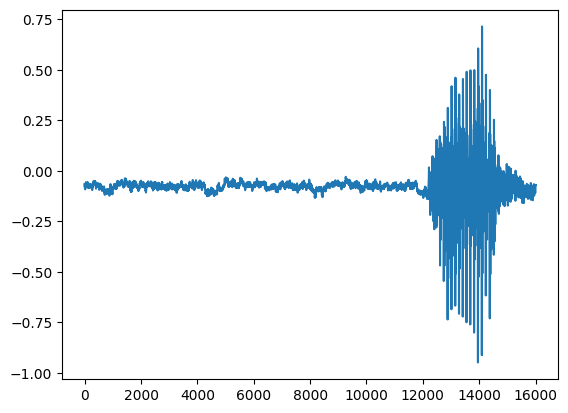

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

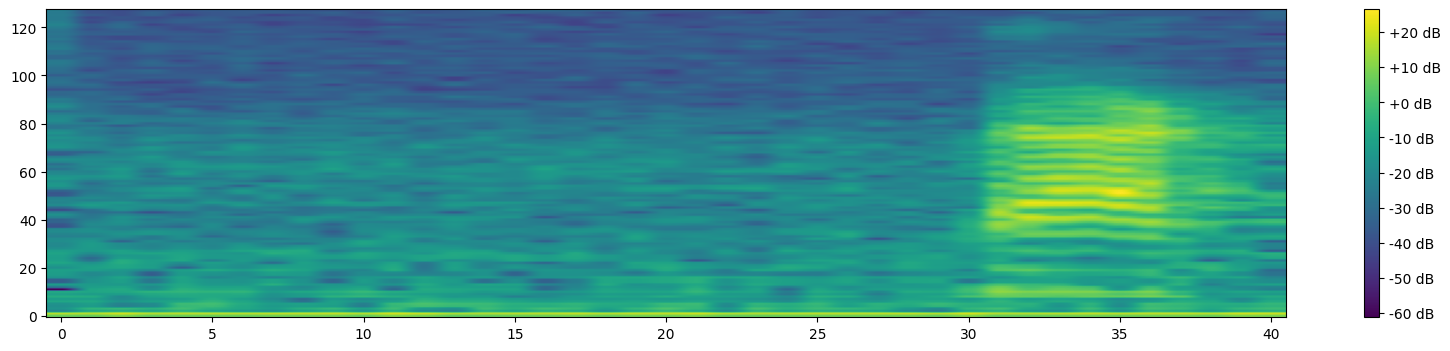

Shape of the Mel spectrogram: torch.Size([1, 128, 41])


In [9]:
new_sample_rate = 8000

# 1. Resample
resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
resampled_waveform = resampler(waveform)

# 2. Convert to Mel-spectrogram
mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128)
mel_spectrogram = mel_transform(resampled_waveform)

# 3. Convert to dB scale
db_transform = torchaudio.transforms.AmplitudeToDB()
db_mel_spectrogram = db_transform(mel_spectrogram)

mel_spectrogram_transform = torch.nn.Sequential(
    torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate),
    torchaudio.transforms.MelSpectrogram(sample_rate=new_sample_rate, n_mels=128),
    torchaudio.transforms.AmplitudeToDB()
)


# Display
plt.figure(figsize=(20, 4))
plt.imshow(db_mel_spectrogram[0].detach().numpy(), cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(format="%+2.0f dB")
plt.show()

print("Shape of the Mel spectrogram:", mel_spectrogram.shape)
# Listen to the resampled audio
ipd.Audio(resampled_waveform.numpy(), rate=new_sample_rate)


In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))

def index_to_label(tensor):
    # Convert tensor of indices into its string labels
    if tensor.dim() == 0:  # If tensor is a scalar
        return labels[tensor.item()]
    else:  # If tensor is not a scalar
        return [labels[index] for index in tensor.cpu().numpy()]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 512

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [12]:
print(torch.__version__)

2.0.1+cu118


In [13]:
# Re-define the entire model architecture and then instantiate and test the model

# Define the model architecture
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # This is the skip connection:
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.skip(x)
        return F.relu(out)# Correcting the indentation and redefining AcousticModel

class AcousticModel(nn.Module):
    def __init__(self, n_input, n_channel):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)  # Reduced stride
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(2)  # Reduced stride
        self.resblock1 = ResBlock(n_channel, n_channel)
        self.resblock2 = ResBlock(n_channel, n_channel)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.resblock1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.resblock2(x)
        return x



class RecurrentLayers(nn.Module):
    def __init__(self, n_channel, hidden_dim, num_layers):
        super().__init__()
        self.gru = nn.GRU(n_channel, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.gru3 = nn.GRU(hidden_dim*2, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x, _ = self.gru(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        return x

class TransformerAttention(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward, dropout, num_layers):
        super().__init__()
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=nhead, dropout=dropout)
        self.relu3 = nn.ReLU()

    def forward(self, x):
        x = self.transformer(x)
        x, _ = self.attention(x, x, x)
        return self.relu3(x)

class nueraspeechASR(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32, hidden_dim=128, num_layers=1, d_model=256, nhead=4, dim_feedforward=256, dropout=0.1):
        super().__init__()
        self.acoustic_model = AcousticModel(n_input, n_channel)
        self.recurrent_layers = RecurrentLayers(n_channel, hidden_dim, num_layers)
        self.transformer_attention = TransformerAttention(d_model, nhead, dim_feedforward, dropout, num_layers)
        self.fc1 = nn.Linear(hidden_dim*2, n_output)
        self.relu4 = nn.ReLU()

    def forward(self, x):
        x = self.acoustic_model(x)
        x = x.permute(0, 2, 1)
        x = self.recurrent_layers(x)
        x = self.transformer_attention(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.relu4(x)
        return F.log_softmax(x, dim=1)

# Testing the model
n_input = 128  # Number of Mel channels
n_output = 35  # Number of classes/labels

# Initialize the model
model = nueraspeechASR(n_input=n_input, n_output=n_output)
print(model)

# Print number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters()):,} trainable parameters')

# Adjust the shape of the input tensor for testing purposes
x = torch.randn(1, 128, 8000)  # [batch_size, n_mels, time]
OUT = model(x)
print(OUT.shape)
model = model.to(device)


nueraspeechASR(
  (acoustic_model): AcousticModel(
    (conv1): Conv1d(128, 32, kernel_size=(5,), stride=(2,))
    (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU()
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
    (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU()
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (resblock1): ResBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Sequential()
    )
    (resbloc

In [25]:
# @title Default title text

n_epoch = 200

# Hyperparameters
lr = 50e-4
weight_decay = 0.0001
dropout_rate = 0.3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=n_epoch,
                                            anneal_strategy='linear')

PATH = "nueraspeech.pth"
pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")



Training Progress:   0%|          | 0/84843 [01:24<?, ?it/s]


In [26]:
def train(model, epoch, log_interval):
    model.train()
    pbar = tqdm(total=len(train_loader.dataset), desc="Training Progress")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.squeeze(1)  # This will remove the single channel dimension, turning [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())


In [27]:
def wer(s1, s2):
    """
    Compute the Word Error Rate between two lists of words.
    """
    b = set(s1 + s2)
    word2char = dict(zip(b, range(len(b))))

    w1 = [chr(word2char[w]) for w in s1]
    w2 = [chr(word2char[w]) for w in s2]

    return editdistance.eval(" ".join(w1), " ".join(w2)) / len(s2)
def cer(s1, s2):
    """
    Compute the Character Error Rate between two lists of words.
    """
    s1 = " ".join(s1)
    s2 = " ".join(s2)

    return editdistance.eval(s1, s2) / len(s2)


def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)
wer_over_epochs = []
cer_over_epochs = []
def test(model, epoch):
    model.eval()
    correct = 0
    total_wer, total_cer, total_samples = 0, 0, 0

    for data, target in test_loader:
        # Apply Mel-spectrogram transform
        data = mel_spectrogram_transform(data)

        # Remove channel dimension after applying mel transform
        data = data.squeeze(1)  # This will convert [batch_size, 1, 128, 41] into [batch_size, 128, 41]

        data = data.to(device)
        target = target.to(device)

        output = model(data)
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # Compute WER and CER
        pred_str = index_to_label(pred)  # Convert the prediction indices to string
        target_str = index_to_label(target)  # Convert target indices to string

        total_wer += wer(pred_str, target_str)
        total_cer += cer(pred_str, target_str)
        total_samples += 1

        # update progress bar
        pbar.update(pbar_update)

    avg_wer = total_wer / total_samples
    avg_cer = total_cer / total_samples

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)")
    print(f"Average WER: {avg_wer:.4f}\nAverage CER: {avg_cer:.4f}\n")

    return avg_wer, avg_cer

In [28]:
log_interval = 20
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []


for epoch in range(1, n_epoch + 1):
    train(model, epoch, log_interval)
    wer_epoch, cer_epoch = test(model, epoch)
    wer_over_epochs.append(wer_epoch)
    cer_over_epochs.append(cer_epoch)
    scheduler.step()
   # Save
    torch.save(model.state_dict(), PATH)
    print("saved")
# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1754:07:10, 74.43s/it]

Train Epoch: 1 [0/84843 (0%)]	Loss: 3.221439


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1600:01:13, 67.89s/it]

Train Epoch: 1 [10240/84843 (12%)]	Loss: 3.058455


Training Progress:   0%|          | 0.2180851063829788/84843 [00:15<1719:11:19, 72.95s/it] 

Train Epoch: 1 [20480/84843 (24%)]	Loss: 2.981179


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1604:02:54, 68.06s/it]

Train Epoch: 1 [30720/84843 (36%)]	Loss: 2.953607


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1625:09:10, 68.96s/it]

Train Epoch: 1 [40960/84843 (48%)]	Loss: 2.927081


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1656:15:33, 70.28s/it]

Train Epoch: 1 [51200/84843 (60%)]	Loss: 2.906909


Training Progress:   0%|          | 0.6436170212765958/84843 [00:44<1607:05:25, 68.19s/it]

Train Epoch: 1 [61440/84843 (72%)]	Loss: 2.935341


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1685:35:31, 71.52s/it]

Train Epoch: 1 [71680/84843 (84%)]	Loss: 2.897098


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1593:58:11, 67.63s/it]

Train Epoch: 1 [81920/84843 (96%)]	Loss: 2.812466


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1613:21:43, 68.46s/it]


Training Progress:   0%|          | 0.005319148936170213/84843 [01:22<363705:09:16, 15432.49s/it]

Training Progress:   0%|          | 0.010638297872340425/84843 [01:22<150875:13:00, 6401.83s/it] 

Training Progress:   0%|          | 0.015957446808510637/84843 [01:22<82876:11:19, 3516.55s/it] 

Training Progress:   0%|          | 0.02127659574468085/84843 [01:23<50906:22:25, 2160.02s/it] 

Training Progress:   0%|          | 0.026595744680851064/84843 [01:23<33221:38:15, 1409.64s/it]

Training Progress:   0%|          | 0.031914893617021274/84843 [01:24<22556:14:14, 957.09s/it] 

Training Progress:   0%|          | 0.03723404255319149/84843 [01:24<15712:18:51, 666.69s/it] 

Training Progress:   0%|          | 0.0425531914893617/84843 [01:24<11221:52:42, 476.16s/it] 

Training Progress:   0%|          | 0.047872340425531915/84843 [01:25<8216:33:02, 348.64s/it]

Training Progress:   0%|          |


Test Epoch: 1	Accuracy: 1824/11005 (17%)
Average WER: 0.8381
Average CER: 0.6351

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1587:08:46, 67.34s/it]

Train Epoch: 2 [0/84843 (0%)]	Loss: 2.733748


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1823:52:25, 77.39s/it]

Train Epoch: 2 [10240/84843 (12%)]	Loss: 2.816368


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1583:43:02, 67.20s/it] 

Train Epoch: 2 [20480/84843 (24%)]	Loss: 2.866320


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1607:02:38, 68.19s/it]

Train Epoch: 2 [30720/84843 (36%)]	Loss: 2.715785


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1805:53:23, 76.63s/it]

Train Epoch: 2 [40960/84843 (48%)]	Loss: 2.476064


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1593:29:13, 67.61s/it]

Train Epoch: 2 [51200/84843 (60%)]	Loss: 2.604877


Training Progress:   0%|          | 0.6436170212765958/84843 [00:44<1623:00:38, 68.87s/it]

Train Epoch: 2 [61440/84843 (72%)]	Loss: 2.494298


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1608:41:44, 68.26s/it]

Train Epoch: 2 [71680/84843 (84%)]	Loss: 2.468943


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1598:25:03, 67.82s/it]

Train Epoch: 2 [81920/84843 (96%)]	Loss: 2.418755


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1616:04:36, 68.57s/it]


Training Progress:   0%|          | 0.12234042553191482/84843 [02:30<82017:24:16, 3480.11s/it]

Training Progress:   0%|          | 0.12765957446808504/84843 [02:31<57872:12:30, 2455.60s/it]

Training Progress:   0%|          | 0.13297872340425526/84843 [02:31<40982:47:01, 1738.96s/it]

Training Progress:   0%|          | 0.13829787234042548/84843 [02:31<29145:12:30, 1236.67s/it]

Training Progress:   0%|          | 0.1436170212765957/84843 [02:32<20868:13:26, 885.47s/it]  

Training Progress:   0%|          | 0.14893617021276592/84843 [02:32<15065:44:34, 639.26s/it]

Training Progress:   0%|          | 0.15425531914893614/84843 [02:32<11009:51:29, 467.16s/it]

Training Progress:   0%|          | 0.15957446808510636/84843 [02:33<8172:35:37, 346.77s/it] 

Training Progress:   0%|          | 0.16489361702127658/84843 [02:33<6187:54:55, 262.56s/it]

Training Progress:   0%|          | 0.17021276595


Test Epoch: 2	Accuracy: 2519/11005 (23%)
Average WER: 0.7764
Average CER: 0.5910

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1517:00:14, 64.37s/it]

Train Epoch: 3 [0/84843 (0%)]	Loss: 2.336469


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1559:05:48, 66.15s/it]

Train Epoch: 3 [10240/84843 (12%)]	Loss: 2.386451


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1557:06:21, 66.07s/it] 

Train Epoch: 3 [20480/84843 (24%)]	Loss: 2.254263


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1805:27:40, 76.61s/it]

Train Epoch: 3 [30720/84843 (36%)]	Loss: 2.370605


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1632:00:35, 69.25s/it]

Train Epoch: 3 [40960/84843 (48%)]	Loss: 2.230531


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1625:36:04, 68.98s/it]

Train Epoch: 3 [51200/84843 (60%)]	Loss: 2.321242


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1615:52:30, 68.56s/it]

Train Epoch: 3 [61440/84843 (72%)]	Loss: 2.360054


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1590:44:07, 67.50s/it]

Train Epoch: 3 [71680/84843 (84%)]	Loss: 2.182020


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1775:07:51, 75.32s/it]

Train Epoch: 3 [81920/84843 (96%)]	Loss: 1.991140


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1605:44:41, 68.13s/it]


Training Progress:   0%|          | 0.23936170212765967/84843 [03:38<81474:05:03, 3457.06s/it]

Training Progress:   0%|          | 0.2446808510638299/84843 [03:39<57522:17:15, 2440.75s/it] 

Training Progress:   0%|          | 0.2500000000000001/84843 [03:39<40762:55:24, 1729.63s/it]

Training Progress:   0%|          | 0.2553191489361703/84843 [03:40<29013:04:12, 1231.07s/it]

Training Progress:   0%|          | 0.2606382978723405/84843 [03:40<20786:59:04, 882.02s/it] 

Training Progress:   0%|          | 0.2659574468085107/84843 [03:40<15026:29:55, 637.60s/it]

Training Progress:   0%|          | 0.2712765957446809/84843 [03:41<11007:05:00, 467.05s/it]

Training Progress:   0%|          | 0.2765957446808511/84843 [03:41<8201:56:50, 348.02s/it] 

Training Progress:   0%|          | 0.28191489361702127/84843 [03:41<6232:27:47, 264.45s/it]

Training Progress:   0%|          | 0.28723404255319146


Test Epoch: 3	Accuracy: 3103/11005 (28%)
Average WER: 0.7245
Average CER: 0.5954

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1899:03:30, 80.58s/it]

Train Epoch: 4 [0/84843 (0%)]	Loss: 2.109982


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1552:31:16, 65.88s/it]

Train Epoch: 4 [10240/84843 (12%)]	Loss: 2.022110


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1637:33:00, 69.48s/it] 

Train Epoch: 4 [20480/84843 (24%)]	Loss: 2.119398


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1551:19:55, 65.83s/it]

Train Epoch: 4 [30720/84843 (36%)]	Loss: 2.086158


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1564:58:56, 66.40s/it]

Train Epoch: 4 [40960/84843 (48%)]	Loss: 1.877372


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1644:12:58, 69.77s/it]

Train Epoch: 4 [51200/84843 (60%)]	Loss: 2.162709


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1563:49:10, 66.36s/it]

Train Epoch: 4 [61440/84843 (72%)]	Loss: 2.002349


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1640:31:11, 69.61s/it]

Train Epoch: 4 [71680/84843 (84%)]	Loss: 2.143915


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1549:46:44, 65.76s/it]

Train Epoch: 4 [81920/84843 (96%)]	Loss: 1.939778


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1580:20:45, 67.06s/it]


Training Progress:   0%|          | 0.35638297872340396/84843 [04:46<80219:05:33, 3403.82s/it]

Training Progress:   0%|          | 0.36170212765957416/84843 [04:46<56670:27:30, 2404.61s/it]

Training Progress:   0%|          | 0.36702127659574435/84843 [04:46<40211:03:26, 1706.22s/it]

Training Progress:   0%|          | 0.37234042553191454/84843 [04:47<28717:06:24, 1218.51s/it]

Training Progress:   0%|          | 0.37765957446808474/84843 [04:47<20659:29:23, 876.61s/it] 

Training Progress:   0%|          | 0.38297872340425493/84843 [04:48<15021:19:19, 637.38s/it]

Training Progress:   0%|          | 0.3882978723404251/84843 [04:48<11064:19:56, 469.48s/it] 

Training Progress:   0%|          | 0.3936170212765953/84843 [04:48<8198:01:11, 347.85s/it] 

Training Progress:   0%|          | 0.3989361702127655/84843 [04:49<6218:57:10, 263.88s/it]

Training Progress:   0%|          | 0.4042553191489


Test Epoch: 4	Accuracy: 3398/11005 (31%)
Average WER: 0.6983
Average CER: 0.6210

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1512:31:22, 64.18s/it]

Train Epoch: 5 [0/84843 (0%)]	Loss: 1.992352


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1652:27:55, 70.12s/it]

Train Epoch: 5 [10240/84843 (12%)]	Loss: 1.937350


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1589:04:54, 67.43s/it] 

Train Epoch: 5 [20480/84843 (24%)]	Loss: 1.965582


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1601:34:24, 67.96s/it]

Train Epoch: 5 [30720/84843 (36%)]	Loss: 1.944635


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1716:13:54, 72.82s/it]

Train Epoch: 5 [40960/84843 (48%)]	Loss: 1.911449


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1607:37:00, 68.21s/it]

Train Epoch: 5 [51200/84843 (60%)]	Loss: 1.902350


Training Progress:   0%|          | 0.6436170212765958/84843 [00:44<1678:29:08, 71.22s/it]

Train Epoch: 5 [61440/84843 (72%)]	Loss: 1.892581


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1608:34:42, 68.25s/it]

Train Epoch: 5 [71680/84843 (84%)]	Loss: 1.984385


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1605:25:40, 68.12s/it]

Train Epoch: 5 [81920/84843 (96%)]	Loss: 2.070301


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1609:07:08, 68.28s/it]


Training Progress:   0%|          | 0.4734042553191482/84843 [05:54<81621:12:01, 3463.31s/it]

Training Progress:   0%|          | 0.4787234042553184/84843 [05:54<57626:22:08, 2445.18s/it]

Training Progress:   0%|          | 0.4840425531914886/84843 [05:55<40838:28:26, 1732.84s/it]

Training Progress:   0%|          | 0.4893617021276588/84843 [05:55<29078:19:54, 1233.84s/it]

Training Progress:   0%|          | 0.494680851063829/84843 [05:55<20841:00:38, 884.32s/it]  

Training Progress:   0%|          | 0.49999999999999917/84843 [05:56<15063:50:57, 639.18s/it]

Training Progress:   0%|          | 0.5053191489361694/84843 [05:56<11037:26:53, 468.34s/it] 

Training Progress:   0%|          | 0.5106382978723396/84843 [05:56<8216:19:41, 348.63s/it] 

Training Progress:   0%|          | 0.5159574468085099/84843 [05:57<6256:24:42, 265.47s/it]

Training Progress:   0%|          | 0.5212765957446801/8


Test Epoch: 5	Accuracy: 3741/11005 (34%)
Average WER: 0.6679
Average CER: 0.6216

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1589:31:23, 67.45s/it]

Train Epoch: 6 [0/84843 (0%)]	Loss: 1.985228


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1596:51:22, 67.76s/it]

Train Epoch: 6 [10240/84843 (12%)]	Loss: 1.783574


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1598:46:11, 67.84s/it] 

Train Epoch: 6 [20480/84843 (24%)]	Loss: 1.870008


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1781:01:59, 75.57s/it]

Train Epoch: 6 [30720/84843 (36%)]	Loss: 2.045610


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1592:39:19, 67.58s/it]

Train Epoch: 6 [40960/84843 (48%)]	Loss: 1.904810


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1621:23:58, 68.80s/it]

Train Epoch: 6 [51200/84843 (60%)]	Loss: 1.918501


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1596:10:08, 67.73s/it]

Train Epoch: 6 [61440/84843 (72%)]	Loss: 1.835672


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1575:05:05, 66.83s/it]

Train Epoch: 6 [71680/84843 (84%)]	Loss: 1.844049


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1823:38:02, 77.38s/it]

Train Epoch: 6 [81920/84843 (96%)]	Loss: 1.978759


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1605:45:34, 68.14s/it]


Training Progress:   0%|          | 0.5904255319148933/84843 [07:02<81507:44:59, 3458.51s/it]

Training Progress:   0%|          | 0.5957446808510636/84843 [07:03<57534:24:04, 2441.28s/it]

Training Progress:   0%|          | 0.6010638297872338/84843 [07:03<40754:30:04, 1729.28s/it]

Training Progress:   0%|          | 0.6063829787234041/84843 [07:03<28999:41:44, 1230.50s/it]

Training Progress:   0%|          | 0.6117021276595743/84843 [07:04<20755:43:28, 880.70s/it] 

Training Progress:   0%|          | 0.6170212765957446/84843 [07:04<14988:45:31, 636.00s/it]

Training Progress:   0%|          | 0.6223404255319148/84843 [07:04<10960:33:40, 465.07s/it]

Training Progress:   0%|          | 0.6276595744680851/84843 [07:05<8144:40:40, 345.59s/it] 

Training Progress:   0%|          | 0.6329787234042553/84843 [07:05<6187:26:13, 262.54s/it]

Training Progress:   0%|          | 0.6382978723404256/848


Test Epoch: 6	Accuracy: 3592/11005 (33%)
Average WER: 0.6811
Average CER: 0.6676

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1531:01:22, 64.96s/it]

Train Epoch: 7 [0/84843 (0%)]	Loss: 1.884983


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1621:50:17, 68.82s/it]

Train Epoch: 7 [10240/84843 (12%)]	Loss: 1.763099


Training Progress:   0%|          | 0.2180851063829788/84843 [00:15<1783:54:46, 75.69s/it] 

Train Epoch: 7 [20480/84843 (24%)]	Loss: 1.863527


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1582:07:22, 67.13s/it]

Train Epoch: 7 [30720/84843 (36%)]	Loss: 1.885495


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1595:51:32, 67.71s/it]

Train Epoch: 7 [40960/84843 (48%)]	Loss: 1.922605


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1604:37:55, 68.09s/it]

Train Epoch: 7 [51200/84843 (60%)]	Loss: 1.833314


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1574:56:54, 66.83s/it]

Train Epoch: 7 [61440/84843 (72%)]	Loss: 1.817630


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1752:16:28, 74.35s/it]

Train Epoch: 7 [71680/84843 (84%)]	Loss: 1.696624


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1668:50:59, 70.81s/it]

Train Epoch: 7 [81920/84843 (96%)]	Loss: 1.822961


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1603:20:39, 68.03s/it]


Training Progress:   0%|          | 0.7074468085106388/84843 [08:10<81352:28:02, 3451.92s/it]

Training Progress:   0%|          | 0.712765957446809/84843 [08:10<57447:16:21, 2437.58s/it] 

Training Progress:   0%|          | 0.7180851063829793/84843 [08:11<40787:26:32, 1730.68s/it]

Training Progress:   0%|          | 0.7234042553191495/84843 [08:11<29176:53:43, 1238.02s/it]

Training Progress:   0%|          | 0.7287234042553198/84843 [08:12<21039:14:04, 892.73s/it] 

Training Progress:   0%|          | 0.73404255319149/84843 [08:12<15318:35:12, 649.99s/it]  

Training Progress:   0%|          | 0.7393617021276603/84843 [08:13<11270:55:05, 478.24s/it]

Training Progress:   0%|          | 0.7446808510638305/84843 [08:13<8406:09:10, 356.69s/it] 

Training Progress:   0%|          | 0.7500000000000008/84843 [08:13<6394:41:23, 271.34s/it]

Training Progress:   0%|          | 0.755319148936171/8484


Test Epoch: 7	Accuracy: 3946/11005 (36%)
Average WER: 0.6497
Average CER: 0.6178

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1624:39:23, 68.94s/it]

Train Epoch: 8 [0/84843 (0%)]	Loss: 1.828455


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1644:52:51, 69.79s/it]

Train Epoch: 8 [10240/84843 (12%)]	Loss: 1.893701


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1577:34:06, 66.94s/it] 

Train Epoch: 8 [20480/84843 (24%)]	Loss: 1.812363


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1586:50:11, 67.33s/it]

Train Epoch: 8 [30720/84843 (36%)]	Loss: 1.813730


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1708:11:20, 72.48s/it]

Train Epoch: 8 [40960/84843 (48%)]	Loss: 1.714679


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1581:27:57, 67.10s/it]

Train Epoch: 8 [51200/84843 (60%)]	Loss: 1.798768


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1652:18:19, 70.11s/it]

Train Epoch: 8 [61440/84843 (72%)]	Loss: 1.874573


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1573:40:49, 66.77s/it]

Train Epoch: 8 [71680/84843 (84%)]	Loss: 1.791291


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1593:52:31, 67.63s/it]

Train Epoch: 8 [81920/84843 (96%)]	Loss: 1.845507


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1600:04:23, 67.89s/it]


Training Progress:   0%|          | 0.8244680851063843/84843 [09:18<81202:15:32, 3445.55s/it]

Training Progress:   0%|          | 0.8297872340425545/84843 [09:19<57312:23:19, 2431.86s/it]

Training Progress:   0%|          | 0.8351063829787247/84843 [09:19<40594:41:39, 1722.50s/it]

Training Progress:   0%|          | 0.840425531914895/84843 [09:19<28874:17:55, 1225.19s/it] 

Training Progress:   0%|          | 0.8457446808510652/84843 [09:20<20685:13:04, 877.71s/it]

Training Progress:   0%|          | 0.8510638297872355/84843 [09:20<14942:35:21, 634.04s/it]

Training Progress:   0%|          | 0.8563829787234057/84843 [09:21<10940:10:19, 464.21s/it]

Training Progress:   0%|          | 0.861702127659576/84843 [09:21<8126:39:29, 344.83s/it]  

Training Progress:   0%|          | 0.8670212765957462/84843 [09:21<6166:47:58, 261.67s/it]

Training Progress:   0%|          | 0.8723404255319165/8484


Test Epoch: 8	Accuracy: 3531/11005 (32%)
Average WER: 0.6865
Average CER: 0.6685

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1503:54:37, 63.81s/it]

Train Epoch: 9 [0/84843 (0%)]	Loss: 1.600755


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1534:41:12, 65.12s/it]

Train Epoch: 9 [10240/84843 (12%)]	Loss: 1.826566


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1592:25:54, 67.57s/it] 

Train Epoch: 9 [20480/84843 (24%)]	Loss: 1.738693


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1733:47:27, 73.57s/it]

Train Epoch: 9 [30720/84843 (36%)]	Loss: 1.707982


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1580:10:14, 67.05s/it]

Train Epoch: 9 [40960/84843 (48%)]	Loss: 1.602882


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1680:57:05, 71.33s/it]

Train Epoch: 9 [51200/84843 (60%)]	Loss: 1.747808


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1572:36:30, 66.73s/it]

Train Epoch: 9 [61440/84843 (72%)]	Loss: 1.827041


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1596:15:48, 67.73s/it]

Train Epoch: 9 [71680/84843 (84%)]	Loss: 1.944247


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1759:37:03, 74.66s/it]

Train Epoch: 9 [81920/84843 (96%)]	Loss: 1.627836


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1588:50:01, 67.42s/it]


Training Progress:   0%|          | 0.9414893617021297/84843 [10:26<80652:32:39, 3422.23s/it]

Training Progress:   0%|          | 0.9468085106383/84843 [10:26<56943:37:57, 2416.22s/it]   

Training Progress:   0%|          | 0.9521276595744702/84843 [10:27<40356:08:08, 1712.38s/it]

Training Progress:   0%|          | 0.9574468085106405/84843 [10:27<28898:25:01, 1226.21s/it]

Training Progress:   0%|          | 0.9627659574468107/84843 [10:27<20704:24:22, 878.53s/it] 

Training Progress:   0%|          | 0.968085106382981/84843 [10:28<14964:26:10, 634.97s/it] 

Training Progress:   0%|          | 0.9734042553191512/84843 [10:28<10964:59:00, 465.26s/it]

Training Progress:   0%|          | 0.9787234042553214/84843 [10:29<8157:11:45, 346.12s/it] 

Training Progress:   0%|          | 0.9840425531914917/84843 [10:29<6209:49:06, 263.49s/it]

Training Progress:   0%|          | 0.989361702127662/8484


Test Epoch: 9	Accuracy: 4033/11005 (37%)
Average WER: 0.6420
Average CER: 0.6041

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1572:02:55, 66.70s/it]

Train Epoch: 10 [0/84843 (0%)]	Loss: 1.725003


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1538:57:06, 65.30s/it]

Train Epoch: 10 [10240/84843 (12%)]	Loss: 1.703071


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1788:33:17, 75.89s/it] 

Train Epoch: 10 [20480/84843 (24%)]	Loss: 1.711852


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1583:12:11, 67.18s/it]

Train Epoch: 10 [30720/84843 (36%)]	Loss: 1.662794


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1617:34:28, 68.64s/it]

Train Epoch: 10 [40960/84843 (48%)]	Loss: 1.752075


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1603:27:57, 68.04s/it]

Train Epoch: 10 [51200/84843 (60%)]	Loss: 1.700508


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1592:21:01, 67.57s/it]

Train Epoch: 10 [61440/84843 (72%)]	Loss: 1.716152


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1817:21:43, 77.11s/it]

Train Epoch: 10 [71680/84843 (84%)]	Loss: 1.775967


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1575:53:38, 66.87s/it]

Train Epoch: 10 [81920/84843 (96%)]	Loss: 1.561309


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1592:17:52, 67.56s/it]


Training Progress:   0%|          | 1.058510638297874/84843 [11:34<80834:09:34, 3429.94s/it]

Training Progress:   0%|          | 1.063829787234044/84843 [11:34<57068:55:06, 2421.54s/it]

Training Progress:   0%|          | 1.0691489361702142/84843 [11:34<40447:35:24, 1716.27s/it]

Training Progress:   0%|          | 1.0744680851063844/84843 [11:35<28817:28:28, 1222.78s/it]

Training Progress:   0%|          | 1.0797872340425545/84843 [11:35<20762:23:09, 880.99s/it] 

Training Progress:   0%|          | 1.0851063829787246/84843 [11:36<15105:35:39, 640.96s/it]

Training Progress:   0%|          | 1.0904255319148948/84843 [11:36<11166:22:13, 473.81s/it]

Training Progress:   0%|          | 1.095744680851065/84843 [11:36<8392:01:46, 356.09s/it]  

Training Progress:   0%|          | 1.101063829787235/84843 [11:37<6388:39:42, 271.08s/it]

Training Progress:   0%|          | 1.1063829787234052/84843 


Test Epoch: 10	Accuracy: 4262/11005 (39%)
Average WER: 0.6216
Average CER: 0.5944

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1582:29:50, 67.15s/it]

Train Epoch: 11 [0/84843 (0%)]	Loss: 1.750966


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1677:42:36, 71.19s/it]

Train Epoch: 11 [10240/84843 (12%)]	Loss: 1.656916


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1560:08:31, 66.20s/it] 

Train Epoch: 11 [20480/84843 (24%)]	Loss: 1.688344


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1608:44:48, 68.26s/it]

Train Epoch: 11 [30720/84843 (36%)]	Loss: 1.683558


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1629:12:51, 69.13s/it]

Train Epoch: 11 [40960/84843 (48%)]	Loss: 1.739871


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1593:02:09, 67.60s/it]

Train Epoch: 11 [51200/84843 (60%)]	Loss: 1.682057


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1677:38:56, 71.19s/it]

Train Epoch: 11 [61440/84843 (72%)]	Loss: 1.714108


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1577:21:41, 66.93s/it]

Train Epoch: 11 [71680/84843 (84%)]	Loss: 1.814136


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1568:58:17, 66.57s/it]

Train Epoch: 11 [81920/84843 (96%)]	Loss: 1.734508


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1593:43:41, 67.62s/it]


Training Progress:   0%|          | 1.175531914893617/84843 [12:42<80931:27:05, 3434.08s/it]

Training Progress:   0%|          | 1.180851063829787/84843 [12:42<57111:59:01, 2423.37s/it]

Training Progress:   0%|          | 1.1861702127659572/84843 [12:42<40464:03:14, 1716.97s/it]

Training Progress:   0%|          | 1.1914893617021274/84843 [12:43<28785:42:29, 1221.43s/it]

Training Progress:   0%|          | 1.1968085106382975/84843 [12:43<20610:21:59, 874.54s/it] 

Training Progress:   0%|          | 1.2021276595744677/84843 [12:43<14874:21:28, 631.15s/it]

Training Progress:   0%|          | 1.2074468085106378/84843 [12:44<10875:18:41, 461.46s/it]

Training Progress:   0%|          | 1.212765957446808/84843 [12:44<8076:36:57, 342.71s/it]  

Training Progress:   0%|          | 1.218085106382978/84843 [12:44<6125:01:58, 259.90s/it]

Training Progress:   0%|          | 1.2234042553191482/84843 


Test Epoch: 11	Accuracy: 3771/11005 (34%)
Average WER: 0.6652
Average CER: 0.6257

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1496:53:08, 63.51s/it]

Train Epoch: 12 [0/84843 (0%)]	Loss: 1.672165


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1590:32:00, 67.49s/it]

Train Epoch: 12 [10240/84843 (12%)]	Loss: 1.623033


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1578:31:58, 66.98s/it] 

Train Epoch: 12 [20480/84843 (24%)]	Loss: 1.640366


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1691:56:06, 71.79s/it]

Train Epoch: 12 [30720/84843 (36%)]	Loss: 1.674440


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1590:45:34, 67.50s/it]

Train Epoch: 12 [40960/84843 (48%)]	Loss: 1.759040


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1670:03:53, 70.86s/it]

Train Epoch: 12 [51200/84843 (60%)]	Loss: 1.856140


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1585:56:42, 67.29s/it]

Train Epoch: 12 [61440/84843 (72%)]	Loss: 1.631390


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1588:58:25, 67.42s/it]

Train Epoch: 12 [71680/84843 (84%)]	Loss: 1.670269


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1783:04:36, 75.66s/it]

Train Epoch: 12 [81920/84843 (96%)]	Loss: 1.778198


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1603:35:22, 68.04s/it]


Training Progress:   0%|          | 1.29255319148936/84843 [13:50<81384:25:31, 3453.30s/it]

Training Progress:   0%|          | 1.2978723404255301/84843 [13:50<57449:14:47, 2437.68s/it]

Training Progress:   0%|          | 1.3031914893617003/84843 [13:50<40714:52:35, 1727.61s/it]

Training Progress:   0%|          | 1.3085106382978704/84843 [13:51<28982:35:55, 1229.79s/it]

Training Progress:   0%|          | 1.3138297872340405/84843 [13:51<20747:14:04, 880.35s/it] 

Training Progress:   0%|          | 1.3191489361702107/84843 [13:51<14974:07:54, 635.38s/it]

Training Progress:   0%|          | 1.3244680851063808/84843 [13:52<10955:37:57, 464.87s/it]

Training Progress:   0%|          | 1.329787234042551/84843 [13:52<8126:16:49, 344.81s/it]  

Training Progress:   0%|          | 1.335106382978721/84843 [13:52<6159:04:21, 261.34s/it]

Training Progress:   0%|          | 1.3404255319148912/84843 


Test Epoch: 12	Accuracy: 4276/11005 (39%)
Average WER: 0.6204
Average CER: 0.6290

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1551:35:32, 65.84s/it]

Train Epoch: 13 [0/84843 (0%)]	Loss: 1.767113


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1595:03:54, 67.68s/it]

Train Epoch: 13 [10240/84843 (12%)]	Loss: 1.638181


Training Progress:   0%|          | 0.2180851063829788/84843 [00:15<1783:38:33, 75.68s/it] 

Train Epoch: 13 [20480/84843 (24%)]	Loss: 1.720091


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1556:15:29, 66.03s/it]

Train Epoch: 13 [30720/84843 (36%)]	Loss: 1.658592


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1630:34:50, 69.19s/it]

Train Epoch: 13 [40960/84843 (48%)]	Loss: 1.667964


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1586:22:09, 67.31s/it]

Train Epoch: 13 [51200/84843 (60%)]	Loss: 1.581987


Training Progress:   0%|          | 0.6436170212765958/84843 [00:44<1597:34:34, 67.79s/it]

Train Epoch: 13 [61440/84843 (72%)]	Loss: 1.613011


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1807:27:02, 76.69s/it]

Train Epoch: 13 [71680/84843 (84%)]	Loss: 1.732285


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1584:58:31, 67.25s/it]

Train Epoch: 13 [81920/84843 (96%)]	Loss: 1.734674


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1607:45:36, 68.22s/it]


Training Progress:   0%|          | 1.409574468085103/84843 [14:58<81572:19:13, 3461.28s/it]

Training Progress:   0%|          | 1.4148936170212731/84843 [14:58<57585:37:15, 2443.47s/it]

Training Progress:   0%|          | 1.4202127659574433/84843 [14:58<40813:48:20, 1731.81s/it]

Training Progress:   0%|          | 1.4255319148936134/84843 [14:59<29078:58:59, 1233.88s/it]

Training Progress:   0%|          | 1.4308510638297836/84843 [14:59<20949:54:36, 888.95s/it] 

Training Progress:   0%|          | 1.4361702127659537/84843 [15:00<15235:06:31, 646.46s/it]

Training Progress:   0%|          | 1.4414893617021238/84843 [15:00<11264:58:41, 478.00s/it]

Training Progress:   0%|          | 1.446808510638294/84843 [15:00<8429:19:37, 357.67s/it]  

Training Progress:   0%|          | 1.452127659574464/84843 [15:01<6413:51:27, 272.15s/it]

Training Progress:   0%|          | 1.4574468085106342/84843


Test Epoch: 13	Accuracy: 4147/11005 (38%)
Average WER: 0.6318
Average CER: 0.6076

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1559:45:06, 66.18s/it]

Train Epoch: 14 [0/84843 (0%)]	Loss: 1.708520


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1710:48:49, 72.59s/it]

Train Epoch: 14 [10240/84843 (12%)]	Loss: 1.474241


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1605:19:38, 68.12s/it] 

Train Epoch: 14 [20480/84843 (24%)]	Loss: 1.644351


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1612:09:36, 68.41s/it]

Train Epoch: 14 [30720/84843 (36%)]	Loss: 1.690232


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1667:53:25, 70.77s/it]

Train Epoch: 14 [40960/84843 (48%)]	Loss: 1.679723


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1582:32:41, 67.15s/it]

Train Epoch: 14 [51200/84843 (60%)]	Loss: 1.609322


Training Progress:   0%|          | 0.6436170212765958/84843 [00:44<1688:15:46, 71.64s/it]

Train Epoch: 14 [61440/84843 (72%)]	Loss: 1.710243


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1575:21:00, 66.84s/it]

Train Epoch: 14 [71680/84843 (84%)]	Loss: 1.681058


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1592:47:03, 67.58s/it]

Train Epoch: 14 [81920/84843 (96%)]	Loss: 1.608781


Training Progress:   0%|          | 0.882978723404257/84843 [01:00<1606:51:53, 68.18s/it]


Training Progress:   0%|          | 1.526595744680846/84843 [16:06<81613:32:10, 3463.03s/it]

Training Progress:   0%|          | 1.5319148936170162/84843 [16:06<57611:19:46, 2444.57s/it]

Training Progress:   0%|          | 1.5372340425531863/84843 [16:07<40841:29:42, 1732.99s/it]

Training Progress:   0%|          | 1.5425531914893564/84843 [16:07<29076:46:55, 1233.79s/it]

Training Progress:   0%|          | 1.5478723404255266/84843 [16:08<20835:04:56, 884.08s/it] 

Training Progress:   0%|          | 1.5531914893616967/84843 [16:08<15060:03:04, 639.03s/it]

Training Progress:   0%|          | 1.5585106382978668/84843 [16:08<11034:47:25, 468.23s/it]

Training Progress:   0%|          | 1.563829787234037/84843 [16:09<8208:30:00, 348.30s/it]  

Training Progress:   0%|          | 1.5691489361702071/84843 [16:09<6239:38:48, 264.76s/it]

Training Progress:   0%|          | 1.5744680851063773/8484


Test Epoch: 14	Accuracy: 4320/11005 (39%)
Average WER: 0.6165
Average CER: 0.5945

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1608:59:34, 68.27s/it]

Train Epoch: 15 [0/84843 (0%)]	Loss: 1.562046


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1570:40:07, 66.65s/it]

Train Epoch: 15 [10240/84843 (12%)]	Loss: 1.581108


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1578:56:51, 67.00s/it] 

Train Epoch: 15 [20480/84843 (24%)]	Loss: 1.633080


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1737:31:05, 73.73s/it]

Train Epoch: 15 [30720/84843 (36%)]	Loss: 1.641811


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1593:30:10, 67.61s/it]

Train Epoch: 15 [40960/84843 (48%)]	Loss: 1.573267


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1657:27:18, 70.33s/it]

Train Epoch: 15 [51200/84843 (60%)]	Loss: 1.492394


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1580:47:32, 67.08s/it]

Train Epoch: 15 [61440/84843 (72%)]	Loss: 1.602119


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1594:07:21, 67.64s/it]

Train Epoch: 15 [71680/84843 (84%)]	Loss: 1.484454


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1714:25:37, 72.75s/it]

Train Epoch: 15 [81920/84843 (96%)]	Loss: 1.432258


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1593:22:25, 67.61s/it]


Training Progress:   0%|          | 1.643617021276589/84843 [17:14<80852:06:48, 3430.73s/it]

Training Progress:   0%|          | 1.6489361702127592/84843 [17:14<57058:06:03, 2421.10s/it]

Training Progress:   0%|          | 1.6542553191489293/84843 [17:15<40417:39:06, 1715.01s/it]

Training Progress:   0%|          | 1.6595744680850995/84843 [17:15<28755:41:44, 1220.17s/it]

Training Progress:   0%|          | 1.6648936170212696/84843 [17:15<20582:22:19, 873.35s/it] 

Training Progress:   0%|          | 1.6702127659574397/84843 [17:16<14852:16:08, 630.21s/it]

Training Progress:   0%|          | 1.6755319148936099/84843 [17:16<10867:42:44, 461.14s/it]

Training Progress:   0%|          | 1.68085106382978/84843 [17:16<8068:51:30, 342.38s/it]   

Training Progress:   0%|          | 1.6861702127659501/84843 [17:17<6125:18:13, 259.91s/it]

Training Progress:   0%|          | 1.6914893617021203/8484


Test Epoch: 15	Accuracy: 4523/11005 (41%)
Average WER: 0.5985
Average CER: 0.5536

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1506:52:55, 63.94s/it]

Train Epoch: 16 [0/84843 (0%)]	Loss: 1.509206


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1593:45:08, 67.63s/it]

Train Epoch: 16 [10240/84843 (12%)]	Loss: 1.566798


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1769:58:28, 75.10s/it] 

Train Epoch: 16 [20480/84843 (24%)]	Loss: 1.599979


Training Progress:   0%|          | 0.3244680851063828/84843 [00:22<1577:35:17, 66.94s/it]

Train Epoch: 16 [30720/84843 (36%)]	Loss: 1.549342


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1641:53:23, 69.67s/it]

Train Epoch: 16 [40960/84843 (48%)]	Loss: 1.595266


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1581:16:26, 67.10s/it]

Train Epoch: 16 [51200/84843 (60%)]	Loss: 1.687518


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1591:48:24, 67.54s/it]

Train Epoch: 16 [61440/84843 (72%)]	Loss: 1.593876


Training Progress:   0%|          | 0.7500000000000008/84843 [00:51<1791:47:01, 76.03s/it]

Train Epoch: 16 [71680/84843 (84%)]	Loss: 1.553400


Training Progress:   0%|          | 0.8563829787234057/84843 [00:58<1582:50:00, 67.16s/it]

Train Epoch: 16 [81920/84843 (96%)]	Loss: 1.478987


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1600:15:10, 67.90s/it]


Training Progress:   0%|          | 1.760638297872332/84843 [18:21<81160:59:33, 3443.84s/it]

Training Progress:   0%|          | 1.7659574468085022/84843 [18:22<57274:54:18, 2430.30s/it]

Training Progress:   0%|          | 1.7712765957446723/84843 [18:22<40561:03:27, 1721.09s/it]

Training Progress:   0%|          | 1.7765957446808425/84843 [18:22<28857:35:36, 1224.49s/it]

Training Progress:   0%|          | 1.7819148936170126/84843 [18:23<20687:12:30, 877.80s/it] 

Training Progress:   0%|          | 1.7872340425531827/84843 [18:23<15032:47:41, 637.87s/it]

Training Progress:   0%|          | 1.7925531914893529/84843 [18:24<11077:55:53, 470.06s/it]

Training Progress:   0%|          | 1.797872340425523/84843 [18:24<8280:28:31, 351.36s/it]  

Training Progress:   0%|          | 1.8031914893616932/84843 [18:24<6339:32:35, 269.00s/it]

Training Progress:   0%|          | 1.8085106382978633/8484


Test Epoch: 16	Accuracy: 4082/11005 (37%)
Average WER: 0.6376
Average CER: 0.6078

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1493:57:26, 63.39s/it]

Train Epoch: 17 [0/84843 (0%)]	Loss: 1.481713


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1699:41:19, 72.12s/it]

Train Epoch: 17 [10240/84843 (12%)]	Loss: 1.408443


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1534:13:53, 65.10s/it] 

Train Epoch: 17 [20480/84843 (24%)]	Loss: 1.693164


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1583:26:57, 67.19s/it]

Train Epoch: 17 [30720/84843 (36%)]	Loss: 1.549866


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1525:12:35, 64.72s/it]

Train Epoch: 17 [40960/84843 (48%)]	Loss: 1.588184


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1519:36:19, 64.48s/it]

Train Epoch: 17 [51200/84843 (60%)]	Loss: 1.663125


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1638:58:00, 69.54s/it]

Train Epoch: 17 [61440/84843 (72%)]	Loss: 1.443907


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1550:56:43, 65.81s/it]

Train Epoch: 17 [71680/84843 (84%)]	Loss: 1.570673


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1649:42:46, 70.00s/it]

Train Epoch: 17 [81920/84843 (96%)]	Loss: 1.496408


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1547:06:03, 65.65s/it]


Training Progress:   0%|          | 1.877659574468075/84843 [19:27<78534:07:23, 3332.38s/it]

Training Progress:   0%|          | 1.8829787234042452/84843 [19:28<55447:16:05, 2352.75s/it]

Training Progress:   0%|          | 1.8882978723404154/84843 [19:28<39299:51:38, 1667.58s/it]

Training Progress:   0%|          | 1.8936170212765855/84843 [19:28<27974:56:15, 1187.04s/it]

Training Progress:   0%|          | 1.8989361702127556/84843 [19:29<20052:55:50, 850.89s/it] 

Training Progress:   0%|          | 1.9042553191489258/84843 [19:29<14499:46:01, 615.26s/it]

Training Progress:   0%|          | 1.909574468085096/84843 [19:29<10625:11:33, 450.85s/it] 

Training Progress:   0%|          | 1.914893617021266/84843 [19:30<7897:48:33, 335.12s/it] 

Training Progress:   0%|          | 1.9202127659574362/84843 [19:30<6018:59:15, 255.40s/it]

Training Progress:   0%|          | 1.9255319148936063/84843


Test Epoch: 17	Accuracy: 4503/11005 (41%)
Average WER: 0.6002
Average CER: 0.5750

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1979:12:11, 83.98s/it]

Train Epoch: 18 [0/84843 (0%)]	Loss: 1.507455


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1615:36:43, 68.55s/it]

Train Epoch: 18 [10240/84843 (12%)]	Loss: 1.590569


Training Progress:   0%|          | 0.2180851063829788/84843 [00:15<1651:05:23, 70.06s/it] 

Train Epoch: 18 [20480/84843 (24%)]	Loss: 1.411710


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1517:36:15, 64.39s/it]

Train Epoch: 18 [30720/84843 (36%)]	Loss: 1.484226


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1550:59:35, 65.81s/it]

Train Epoch: 18 [40960/84843 (48%)]	Loss: 1.546253


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1522:35:52, 64.61s/it]

Train Epoch: 18 [51200/84843 (60%)]	Loss: 1.447842


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1518:21:02, 64.43s/it]

Train Epoch: 18 [61440/84843 (72%)]	Loss: 1.734491


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1691:35:22, 71.78s/it]

Train Epoch: 18 [71680/84843 (84%)]	Loss: 1.490528


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1537:18:55, 65.23s/it]

Train Epoch: 18 [81920/84843 (96%)]	Loss: 1.496270


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1555:54:42, 66.02s/it]


Training Progress:   0%|          | 1.994680851063818/84843 [20:33<79145:20:29, 3358.32s/it]

Training Progress:   0%|          | 1.9999999999999882/84843 [20:34<55879:50:19, 2371.11s/it]

Training Progress:   0%|          | 2.0053191489361586/84843 [20:34<39602:06:03, 1680.41s/it]

Training Progress:   0%|          | 2.0106382978723287/84843 [20:34<28192:52:58, 1196.29s/it]

Training Progress:   0%|          | 2.015957446808499/84843 [20:35<20211:32:36, 857.62s/it]  

Training Progress:   0%|          | 2.021276595744669/84843 [20:35<14621:38:47, 620.43s/it]

Training Progress:   0%|          | 2.026595744680839/84843 [20:36<10813:14:22, 458.83s/it]

Training Progress:   0%|          | 2.0319148936170093/84843 [20:36<8097:09:14, 343.58s/it]

Training Progress:   0%|          | 2.0372340425531794/84843 [20:36<6195:03:27, 262.87s/it]

Training Progress:   0%|          | 2.0425531914893496/84843 [


Test Epoch: 18	Accuracy: 4180/11005 (38%)
Average WER: 0.6289
Average CER: 0.6189

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1570:54:51, 66.66s/it]

Train Epoch: 19 [0/84843 (0%)]	Loss: 1.413761


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1725:16:10, 73.21s/it]

Train Epoch: 19 [10240/84843 (12%)]	Loss: 1.584592


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1538:30:11, 65.28s/it] 

Train Epoch: 19 [20480/84843 (24%)]	Loss: 1.499624


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1584:08:51, 67.22s/it]

Train Epoch: 19 [30720/84843 (36%)]	Loss: 1.585144


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1523:37:41, 64.65s/it]

Train Epoch: 19 [40960/84843 (48%)]	Loss: 1.509836


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1550:55:57, 65.81s/it]

Train Epoch: 19 [51200/84843 (60%)]	Loss: 1.460818


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1532:57:33, 65.05s/it]

Train Epoch: 19 [61440/84843 (72%)]	Loss: 1.506957


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1529:25:44, 64.90s/it]

Train Epoch: 19 [71680/84843 (84%)]	Loss: 1.621088


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1680:50:15, 71.32s/it]

Train Epoch: 19 [81920/84843 (96%)]	Loss: 1.578290


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1540:51:12, 65.38s/it]


Training Progress:   0%|          | 2.1117021276595613/84843 [21:39<78211:20:55, 3318.69s/it]

Training Progress:   0%|          | 2.1170212765957315/84843 [21:39<55222:06:36, 2343.21s/it]

Training Progress:   0%|          | 2.1223404255319016/84843 [21:40<39149:54:39, 1661.22s/it]

Training Progress:   0%|          | 2.1276595744680717/84843 [21:40<27873:38:03, 1182.74s/it]

Training Progress:   0%|          | 2.132978723404242/84843 [21:40<19975:40:48, 847.62s/it]  

Training Progress:   0%|          | 2.138297872340412/84843 [21:41<14581:48:44, 618.74s/it]

Training Progress:   0%|          | 2.143617021276582/84843 [21:41<10690:42:03, 453.63s/it]

Training Progress:   0%|          | 2.1489361702127523/84843 [21:42<7942:50:23, 337.03s/it]

Training Progress:   0%|          | 2.1542553191489224/84843 [21:42<6036:10:35, 256.13s/it]

Training Progress:   0%|          | 2.1595744680850926/84843 


Test Epoch: 19	Accuracy: 4529/11005 (41%)
Average WER: 0.5979
Average CER: 0.5951

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1682:44:06, 71.40s/it]

Train Epoch: 20 [0/84843 (0%)]	Loss: 1.431427


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1512:54:05, 64.19s/it]

Train Epoch: 20 [10240/84843 (12%)]	Loss: 1.460914


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1656:09:17, 70.27s/it] 

Train Epoch: 20 [20480/84843 (24%)]	Loss: 1.411972


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1526:34:06, 64.77s/it]

Train Epoch: 20 [30720/84843 (36%)]	Loss: 1.291361


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1576:22:38, 66.89s/it]

Train Epoch: 20 [40960/84843 (48%)]	Loss: 1.385623


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1525:10:05, 64.72s/it]

Train Epoch: 20 [51200/84843 (60%)]	Loss: 1.622169


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1540:42:20, 65.37s/it]

Train Epoch: 20 [61440/84843 (72%)]	Loss: 1.620754


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1750:25:50, 74.27s/it]

Train Epoch: 20 [71680/84843 (84%)]	Loss: 1.493472


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1541:54:27, 65.43s/it]

Train Epoch: 20 [81920/84843 (96%)]	Loss: 1.573905


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1539:29:00, 65.32s/it]


Training Progress:   0%|          | 2.2287234042553044/84843 [22:45<78153:58:56, 3316.26s/it]

Training Progress:   0%|          | 2.2340425531914745/84843 [22:45<55205:44:26, 2342.51s/it]

Training Progress:   0%|          | 2.2393617021276446/84843 [22:45<39145:03:02, 1661.02s/it]

Training Progress:   0%|          | 2.2446808510638148/84843 [22:46<27895:28:55, 1183.67s/it]

Training Progress:   0%|          | 2.249999999999985/84843 [22:46<20012:59:57, 849.20s/it]  

Training Progress:   0%|          | 2.255319148936155/84843 [22:46<14525:20:42, 616.35s/it]

Training Progress:   0%|          | 2.260638297872325/84843 [22:47<10745:56:56, 455.98s/it]

Training Progress:   0%|          | 2.2659574468084953/84843 [22:47<8073:31:52, 342.58s/it]

Training Progress:   0%|          | 2.2712765957446654/84843 [22:48<6207:02:43, 263.38s/it]

Training Progress:   0%|          | 2.2765957446808356/84843 


Test Epoch: 20	Accuracy: 4206/11005 (38%)
Average WER: 0.6266
Average CER: 0.6286

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1579:59:14, 67.04s/it]

Train Epoch: 21 [0/84843 (0%)]	Loss: 1.509508


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1716:21:39, 72.83s/it]

Train Epoch: 21 [10240/84843 (12%)]	Loss: 1.471832


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1534:11:16, 65.10s/it] 

Train Epoch: 21 [20480/84843 (24%)]	Loss: 1.456866


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1548:10:29, 65.69s/it]

Train Epoch: 21 [30720/84843 (36%)]	Loss: 1.451891


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1522:59:02, 64.62s/it]

Train Epoch: 21 [40960/84843 (48%)]	Loss: 1.310378


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1562:51:27, 66.31s/it]

Train Epoch: 21 [51200/84843 (60%)]	Loss: 1.503726


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1619:26:01, 68.72s/it]

Train Epoch: 21 [61440/84843 (72%)]	Loss: 1.445123


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1516:00:05, 64.33s/it]

Train Epoch: 21 [71680/84843 (84%)]	Loss: 1.605724


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1639:25:21, 69.56s/it]

Train Epoch: 21 [81920/84843 (96%)]	Loss: 1.338862


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1532:48:38, 65.04s/it]


Training Progress:   0%|          | 2.3457446808510474/84843 [23:50<77843:42:53, 3303.10s/it]

Training Progress:   0%|          | 2.3510638297872175/84843 [23:51<54974:45:48, 2332.72s/it]

Training Progress:   0%|          | 2.3563829787233876/84843 [23:51<38979:26:48, 1654.00s/it]

Training Progress:   0%|          | 2.361702127659558/84843 [23:51<27766:02:51, 1178.18s/it] 

Training Progress:   0%|          | 2.367021276595728/84843 [23:52<19909:58:09, 844.83s/it] 

Training Progress:   0%|          | 2.372340425531898/84843 [23:52<14410:58:02, 611.49s/it]

Training Progress:   0%|          | 2.377659574468068/84843 [23:52<10575:54:48, 448.76s/it]

Training Progress:   0%|          | 2.3829787234042383/84843 [23:53<7892:06:43, 334.88s/it]

Training Progress:   0%|          | 2.3882978723404085/84843 [23:53<6025:30:41, 255.68s/it]

Training Progress:   0%|          | 2.3936170212765786/84843 [


Test Epoch: 21	Accuracy: 4519/11005 (41%)
Average WER: 0.5988
Average CER: 0.5727

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1855:38:12, 78.74s/it]

Train Epoch: 22 [0/84843 (0%)]	Loss: 1.699645


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1537:26:02, 65.24s/it]

Train Epoch: 22 [10240/84843 (12%)]	Loss: 1.443085


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1594:10:58, 67.64s/it] 

Train Epoch: 22 [20480/84843 (24%)]	Loss: 1.495234


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1537:13:53, 65.23s/it]

Train Epoch: 22 [30720/84843 (36%)]	Loss: 1.548336


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1527:45:55, 64.83s/it]

Train Epoch: 22 [40960/84843 (48%)]	Loss: 1.545946


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1489:15:05, 63.19s/it]

Train Epoch: 22 [51200/84843 (60%)]	Loss: 1.632449


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1488:45:46, 63.17s/it]

Train Epoch: 22 [61440/84843 (72%)]	Loss: 1.521258


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1725:17:12, 73.21s/it]

Train Epoch: 22 [71680/84843 (84%)]	Loss: 1.571729


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1485:46:44, 63.04s/it]

Train Epoch: 22 [81920/84843 (96%)]	Loss: 1.425826


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1533:35:55, 65.07s/it]


Training Progress:   0%|          | 2.4627659574467904/84843 [24:56<77880:29:25, 3304.67s/it]

Training Progress:   0%|          | 2.4680851063829605/84843 [24:56<54972:26:35, 2332.62s/it]

Training Progress:   0%|          | 2.4734042553191307/84843 [24:56<38952:46:48, 1652.87s/it]

Training Progress:   0%|          | 2.478723404255301/84843 [24:57<27715:15:26, 1176.03s/it] 

Training Progress:   0%|          | 2.484042553191471/84843 [24:57<19864:14:17, 842.89s/it] 

Training Progress:   0%|          | 2.489361702127641/84843 [24:57<14422:50:58, 612.00s/it]

Training Progress:   0%|          | 2.494680851063811/84843 [24:58<10640:22:10, 451.50s/it]

Training Progress:   0%|          | 2.4999999999999813/84843 [24:58<7964:57:43, 337.97s/it]

Training Progress:   0%|          | 2.5053191489361515/84843 [24:59<6100:02:25, 258.84s/it]

Training Progress:   0%|          | 2.5106382978723216/84843 [


Test Epoch: 22	Accuracy: 4002/11005 (36%)
Average WER: 0.6447
Average CER: 0.6409

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1531:15:30, 64.97s/it]

Train Epoch: 23 [0/84843 (0%)]	Loss: 1.434569


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1657:36:59, 70.33s/it]

Train Epoch: 23 [10240/84843 (12%)]	Loss: 1.326743


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1540:31:12, 65.37s/it] 

Train Epoch: 23 [20480/84843 (24%)]	Loss: 1.376370


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1564:16:23, 66.37s/it]

Train Epoch: 23 [30720/84843 (36%)]	Loss: 1.564549


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1546:33:08, 65.62s/it]

Train Epoch: 23 [40960/84843 (48%)]	Loss: 1.333156


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1511:03:09, 64.12s/it]

Train Epoch: 23 [51200/84843 (60%)]	Loss: 1.462522


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1564:08:51, 66.37s/it]

Train Epoch: 23 [61440/84843 (72%)]	Loss: 1.377495


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1515:28:05, 64.30s/it]

Train Epoch: 23 [71680/84843 (84%)]	Loss: 1.435513


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1684:32:35, 71.48s/it]

Train Epoch: 23 [81920/84843 (96%)]	Loss: 1.469741


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1529:06:37, 64.88s/it]


Training Progress:   0%|          | 2.5797872340425334/84843 [26:01<77602:26:51, 3292.87s/it]

Training Progress:   0%|          | 2.5851063829787035/84843 [26:01<54806:05:30, 2325.57s/it]

Training Progress:   0%|          | 2.5904255319148737/84843 [26:01<38857:56:29, 1648.84s/it]

Training Progress:   0%|          | 2.595744680851044/84843 [26:02<27663:49:46, 1173.85s/it] 

Training Progress:   0%|          | 2.601063829787214/84843 [26:02<19820:25:58, 841.03s/it] 

Training Progress:   0%|          | 2.606382978723384/84843 [26:02<14323:09:54, 607.77s/it]

Training Progress:   0%|          | 2.6117021276595542/84843 [26:03<10496:10:40, 445.38s/it]

Training Progress:   0%|          | 2.6170212765957244/84843 [26:03<7809:10:10, 331.36s/it] 

Training Progress:   0%|          | 2.6223404255318945/84843 [26:04<5948:04:46, 252.39s/it]

Training Progress:   0%|          | 2.6276595744680646/84843


Test Epoch: 23	Accuracy: 4779/11005 (43%)
Average WER: 0.5757
Average CER: 0.5911

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1510:57:57, 64.11s/it]

Train Epoch: 24 [0/84843 (0%)]	Loss: 1.390384


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1525:09:06, 64.71s/it]

Train Epoch: 24 [10240/84843 (12%)]	Loss: 1.388378


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1721:11:37, 73.03s/it] 

Train Epoch: 24 [20480/84843 (24%)]	Loss: 1.408435


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1517:31:50, 64.39s/it]

Train Epoch: 24 [30720/84843 (36%)]	Loss: 1.406430


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1555:28:30, 66.00s/it]

Train Epoch: 24 [40960/84843 (48%)]	Loss: 1.387868


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1513:22:29, 64.21s/it]

Train Epoch: 24 [51200/84843 (60%)]	Loss: 1.659812


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1571:08:51, 66.67s/it]

Train Epoch: 24 [61440/84843 (72%)]	Loss: 1.426829


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1626:06:43, 69.00s/it]

Train Epoch: 24 [71680/84843 (84%)]	Loss: 1.423393


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1529:13:10, 64.89s/it]

Train Epoch: 24 [81920/84843 (96%)]	Loss: 1.448180


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1533:27:20, 65.07s/it]


Training Progress:   0%|          | 2.6968085106382764/84843 [27:06<77802:57:32, 3301.39s/it]

Training Progress:   0%|          | 2.7021276595744466/84843 [27:06<54903:40:44, 2329.71s/it]

Training Progress:   0%|          | 2.7074468085106167/84843 [27:06<38898:27:37, 1650.57s/it]

Training Progress:   0%|          | 2.712765957446787/84843 [27:07<27682:32:54, 1174.64s/it] 

Training Progress:   0%|          | 2.718085106382957/84843 [27:07<19824:16:51, 841.20s/it] 

Training Progress:   0%|          | 2.723404255319127/84843 [27:07<14300:30:47, 606.81s/it]

Training Progress:   0%|          | 2.7287234042552972/84843 [27:08<10467:27:17, 444.16s/it]

Training Progress:   0%|          | 2.7340425531914674/84843 [27:08<7777:31:22, 330.02s/it] 

Training Progress:   0%|          | 2.7393617021276375/84843 [27:09<5956:10:20, 252.74s/it]

Training Progress:   0%|          | 2.7446808510638077/84843


Test Epoch: 24	Accuracy: 4535/11005 (41%)
Average WER: 0.5974
Average CER: 0.5980

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1525:57:43, 64.75s/it]

Train Epoch: 25 [0/84843 (0%)]	Loss: 1.432138


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1484:31:51, 62.99s/it]

Train Epoch: 25 [10240/84843 (12%)]	Loss: 1.384374


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1530:55:26, 64.96s/it] 

Train Epoch: 25 [20480/84843 (24%)]	Loss: 1.487268


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1700:13:10, 72.14s/it]

Train Epoch: 25 [30720/84843 (36%)]	Loss: 1.457558


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1510:52:12, 64.11s/it]

Train Epoch: 25 [40960/84843 (48%)]	Loss: 1.406411


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1575:06:12, 66.83s/it]

Train Epoch: 25 [51200/84843 (60%)]	Loss: 1.576579


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1513:44:01, 64.23s/it]

Train Epoch: 25 [61440/84843 (72%)]	Loss: 1.458356


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1529:59:35, 64.92s/it]

Train Epoch: 25 [71680/84843 (84%)]	Loss: 1.415561


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1501:39:39, 63.72s/it]

Train Epoch: 25 [81920/84843 (96%)]	Loss: 1.444912


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1528:28:56, 64.86s/it]


Training Progress:   0%|          | 2.8138297872340194/84843 [28:11<77582:51:31, 3292.05s/it]

Training Progress:   0%|          | 2.8191489361701896/84843 [28:11<54784:35:26, 2324.66s/it]

Training Progress:   0%|          | 2.8244680851063597/84843 [28:11<38840:53:47, 1648.13s/it]

Training Progress:   0%|          | 2.82978723404253/84843 [28:12<27663:08:46, 1173.82s/it]  

Training Progress:   0%|          | 2.8351063829787/84843 [28:12<19826:55:01, 841.31s/it]  

Training Progress:   0%|          | 2.84042553191487/84843 [28:12<14331:33:27, 608.13s/it]

Training Progress:   0%|          | 2.8457446808510403/84843 [28:13<10512:19:48, 446.07s/it]

Training Progress:   0%|          | 2.8510638297872104/84843 [28:13<7825:54:03, 332.07s/it] 

Training Progress:   0%|          | 2.8563829787233805/84843 [28:13<5952:47:02, 252.59s/it]

Training Progress:   0%|          | 2.8617021276595507/84843 [


Test Epoch: 25	Accuracy: 4499/11005 (41%)
Average WER: 0.6006
Average CER: 0.5985

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1498:13:49, 63.57s/it]

Train Epoch: 26 [0/84843 (0%)]	Loss: 1.472377


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1482:24:42, 62.90s/it]

Train Epoch: 26 [10240/84843 (12%)]	Loss: 1.470553


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1468:45:58, 62.32s/it] 

Train Epoch: 26 [20480/84843 (24%)]	Loss: 1.451546


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1493:40:45, 63.38s/it]

Train Epoch: 26 [30720/84843 (36%)]	Loss: 1.466453


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1736:55:40, 73.70s/it]

Train Epoch: 26 [40960/84843 (48%)]	Loss: 1.404921


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1527:27:43, 64.81s/it]

Train Epoch: 26 [51200/84843 (60%)]	Loss: 1.430641


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1547:56:28, 65.68s/it]

Train Epoch: 26 [61440/84843 (72%)]	Loss: 1.582897


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1514:24:44, 64.26s/it]

Train Epoch: 26 [71680/84843 (84%)]	Loss: 1.349071


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1509:06:35, 64.03s/it]

Train Epoch: 26 [81920/84843 (96%)]	Loss: 1.435611


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1522:36:21, 64.61s/it]


Training Progress:   0%|          | 2.9308510638297625/84843 [29:15<77284:41:10, 3279.40s/it]

Training Progress:   0%|          | 2.9361702127659326/84843 [29:16<54542:41:29, 2314.40s/it]

Training Progress:   0%|          | 2.9414893617021027/84843 [29:16<38659:08:49, 1640.42s/it]

Training Progress:   0%|          | 2.946808510638273/84843 [29:16<27499:36:34, 1166.89s/it] 

Training Progress:   0%|          | 2.952127659574443/84843 [29:17<19685:15:06, 835.30s/it] 

Training Progress:   0%|          | 2.957446808510613/84843 [29:17<14225:38:13, 603.63s/it]

Training Progress:   0%|          | 2.9627659574467833/84843 [29:17<10398:30:42, 441.24s/it]

Training Progress:   0%|          | 2.9680851063829534/84843 [29:18<7725:47:24, 327.83s/it] 

Training Progress:   0%|          | 2.9734042553191236/84843 [29:18<5868:00:07, 249.00s/it]

Training Progress:   0%|          | 2.9787234042552937/84843


Test Epoch: 26	Accuracy: 4735/11005 (43%)
Average WER: 0.5796
Average CER: 0.5641

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1508:08:01, 63.99s/it]

Train Epoch: 27 [0/84843 (0%)]	Loss: 1.367628


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1493:49:04, 63.38s/it]

Train Epoch: 27 [10240/84843 (12%)]	Loss: 1.426484


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1482:27:15, 62.90s/it] 

Train Epoch: 27 [20480/84843 (24%)]	Loss: 1.583134


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1492:11:38, 63.32s/it]

Train Epoch: 27 [30720/84843 (36%)]	Loss: 1.416421


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1531:37:33, 64.99s/it]

Train Epoch: 27 [40960/84843 (48%)]	Loss: 1.348166


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1733:56:09, 73.57s/it]

Train Epoch: 27 [51200/84843 (60%)]	Loss: 1.369906


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1534:09:01, 65.10s/it]

Train Epoch: 27 [61440/84843 (72%)]	Loss: 1.367009


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1572:17:58, 66.72s/it]

Train Epoch: 27 [71680/84843 (84%)]	Loss: 1.354919


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1580:44:32, 67.07s/it]

Train Epoch: 27 [81920/84843 (96%)]	Loss: 1.451980


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1521:20:42, 64.55s/it]


Training Progress:   0%|          | 3.0478723404255055/84843 [30:20<77361:33:38, 3282.67s/it]

Training Progress:   0%|          | 3.0531914893616756/84843 [30:21<54756:02:49, 2323.45s/it]

Training Progress:   0%|          | 3.0585106382978458/84843 [30:21<38824:38:12, 1647.44s/it]

Training Progress:   0%|          | 3.063829787234016/84843 [30:21<27661:25:54, 1173.75s/it] 

Training Progress:   0%|          | 3.069148936170186/84843 [30:22<19838:54:28, 841.82s/it] 

Training Progress:   0%|          | 3.074468085106356/84843 [30:22<14341:55:08, 608.57s/it]

Training Progress:   0%|          | 3.0797872340425263/84843 [30:22<10522:31:13, 446.50s/it]

Training Progress:   0%|          | 3.0851063829786964/84843 [30:23<7828:40:15, 332.19s/it] 

Training Progress:   0%|          | 3.0904255319148666/84843 [30:23<5965:02:16, 253.11s/it]

Training Progress:   0%|          | 3.0957446808510367/84843


Test Epoch: 27	Accuracy: 4644/11005 (42%)
Average WER: 0.5877
Average CER: 0.5902

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1557:34:13, 66.09s/it]

Train Epoch: 28 [0/84843 (0%)]	Loss: 1.363728


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1568:37:17, 66.56s/it]

Train Epoch: 28 [10240/84843 (12%)]	Loss: 1.550580


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1495:56:12, 63.47s/it] 

Train Epoch: 28 [20480/84843 (24%)]	Loss: 1.347947


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1520:48:03, 64.53s/it]

Train Epoch: 28 [30720/84843 (36%)]	Loss: 1.473069


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1655:38:57, 70.25s/it]

Train Epoch: 28 [40960/84843 (48%)]	Loss: 1.202387


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1521:25:41, 64.56s/it]

Train Epoch: 28 [51200/84843 (60%)]	Loss: 1.384712


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1574:23:37, 66.80s/it]

Train Epoch: 28 [61440/84843 (72%)]	Loss: 1.280382


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1544:58:02, 65.56s/it]

Train Epoch: 28 [71680/84843 (84%)]	Loss: 1.545176


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1540:22:39, 65.36s/it]

Train Epoch: 28 [81920/84843 (96%)]	Loss: 1.323411


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1537:47:26, 65.25s/it]


Training Progress:   0%|          | 3.1648936170212485/84843 [31:26<78061:13:46, 3312.36s/it]

Training Progress:   0%|          | 3.1702127659574186/84843 [31:26<55118:24:45, 2338.83s/it]

Training Progress:   0%|          | 3.1755319148935888/84843 [31:26<39220:17:05, 1664.23s/it]

Training Progress:   0%|          | 3.180851063829759/84843 [31:27<27921:41:54, 1184.80s/it] 

Training Progress:   0%|          | 3.186170212765929/84843 [31:27<20013:33:30, 849.23s/it] 

Training Progress:   0%|          | 3.191489361702099/84843 [31:27<14468:18:19, 613.93s/it]

Training Progress:   0%|          | 3.1968085106382693/84843 [31:28<10606:44:48, 450.08s/it]

Training Progress:   0%|          | 3.2021276595744395/84843 [31:28<7886:50:18, 334.66s/it] 

Training Progress:   0%|          | 3.2074468085106096/84843 [31:28<6008:16:14, 254.95s/it]

Training Progress:   0%|          | 3.2127659574467797/84843


Test Epoch: 28	Accuracy: 4598/11005 (42%)
Average WER: 0.5918
Average CER: 0.5878

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1511:54:59, 64.15s/it]

Train Epoch: 29 [0/84843 (0%)]	Loss: 1.396775


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1476:41:09, 62.66s/it]

Train Epoch: 29 [10240/84843 (12%)]	Loss: 1.447407


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1551:22:55, 65.83s/it] 

Train Epoch: 29 [20480/84843 (24%)]	Loss: 1.287156


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1558:04:37, 66.11s/it]

Train Epoch: 29 [30720/84843 (36%)]	Loss: 1.425950


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1551:02:00, 65.81s/it]

Train Epoch: 29 [40960/84843 (48%)]	Loss: 1.273157


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1654:44:00, 70.21s/it]

Train Epoch: 29 [51200/84843 (60%)]	Loss: 1.350928


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1515:37:01, 64.31s/it]

Train Epoch: 29 [61440/84843 (72%)]	Loss: 1.371503


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1549:45:42, 65.76s/it]

Train Epoch: 29 [71680/84843 (84%)]	Loss: 1.260267


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1509:32:03, 64.05s/it]

Train Epoch: 29 [81920/84843 (96%)]	Loss: 1.495106


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1525:17:52, 64.72s/it]


Training Progress:   0%|          | 3.2819148936169915/84843 [32:31<77552:01:46, 3290.76s/it]

Training Progress:   0%|          | 3.2872340425531617/84843 [32:31<54826:24:54, 2326.45s/it]

Training Progress:   0%|          | 3.292553191489332/84843 [32:32<38888:54:34, 1650.17s/it] 

Training Progress:   0%|          | 3.297872340425502/84843 [32:32<27696:51:11, 1175.26s/it]

Training Progress:   0%|          | 3.303191489361672/84843 [32:32<19848:11:04, 842.22s/it] 

Training Progress:   0%|          | 3.308510638297842/84843 [32:33<14355:56:45, 609.17s/it]

Training Progress:   0%|          | 3.3138297872340123/84843 [32:33<10523:36:42, 446.55s/it]

Training Progress:   0%|          | 3.3191489361701825/84843 [32:33<7829:02:49, 332.21s/it] 

Training Progress:   0%|          | 3.3244680851063526/84843 [32:34<5967:47:48, 253.23s/it]

Training Progress:   0%|          | 3.3297872340425227/84843 


Test Epoch: 29	Accuracy: 4443/11005 (40%)
Average WER: 0.6056
Average CER: 0.6275

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1526:21:13, 64.77s/it]

Train Epoch: 30 [0/84843 (0%)]	Loss: 1.419037


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1533:25:36, 65.07s/it]

Train Epoch: 30 [10240/84843 (12%)]	Loss: 1.379242


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1514:57:09, 64.28s/it] 

Train Epoch: 30 [20480/84843 (24%)]	Loss: 1.465582


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1536:27:16, 65.19s/it]

Train Epoch: 30 [30720/84843 (36%)]	Loss: 1.536467


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1752:09:49, 74.35s/it]

Train Epoch: 30 [40960/84843 (48%)]	Loss: 1.341916


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1512:09:09, 64.16s/it]

Train Epoch: 30 [51200/84843 (60%)]	Loss: 1.557986


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1583:18:51, 67.18s/it]

Train Epoch: 30 [61440/84843 (72%)]	Loss: 1.474313


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1529:29:40, 64.90s/it]

Train Epoch: 30 [71680/84843 (84%)]	Loss: 1.335751


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1534:01:31, 65.09s/it]

Train Epoch: 30 [81920/84843 (96%)]	Loss: 1.349763


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1541:15:00, 65.40s/it]


Training Progress:   0%|          | 3.3989361702127345/84843 [33:36<78202:44:58, 3318.38s/it]

Training Progress:   0%|          | 3.4042553191489047/84843 [33:37<55199:42:50, 2342.29s/it]

Training Progress:   0%|          | 3.409574468085075/84843 [33:37<39105:53:53, 1659.38s/it] 

Training Progress:   0%|          | 3.414893617021245/84843 [33:37<27829:36:54, 1180.89s/it]

Training Progress:   0%|          | 3.420212765957415/84843 [33:38<19922:39:56, 845.38s/it] 

Training Progress:   0%|          | 3.425531914893585/84843 [33:38<14389:59:43, 610.61s/it]

Training Progress:   0%|          | 3.4308510638297554/84843 [33:38<10519:01:44, 446.35s/it]

Training Progress:   0%|          | 3.4361702127659255/84843 [33:39<7808:05:29, 331.32s/it] 

Training Progress:   0%|          | 3.4414893617020956/84843 [33:39<5932:51:00, 251.75s/it]

Training Progress:   0%|          | 3.4468085106382658/84843 


Test Epoch: 30	Accuracy: 4607/11005 (42%)
Average WER: 0.5910
Average CER: 0.5813

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1472:51:16, 62.50s/it]

Train Epoch: 31 [0/84843 (0%)]	Loss: 1.334613


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1554:05:42, 65.94s/it]

Train Epoch: 31 [10240/84843 (12%)]	Loss: 1.420066


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1525:42:08, 64.74s/it] 

Train Epoch: 31 [20480/84843 (24%)]	Loss: 1.307128


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1666:29:08, 70.71s/it]

Train Epoch: 31 [30720/84843 (36%)]	Loss: 1.215008


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1526:00:35, 64.75s/it]

Train Epoch: 31 [40960/84843 (48%)]	Loss: 1.396242


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1627:50:10, 69.07s/it]

Train Epoch: 31 [51200/84843 (60%)]	Loss: 1.393672


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1530:38:54, 64.95s/it]

Train Epoch: 31 [61440/84843 (72%)]	Loss: 1.557382


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1555:16:38, 65.99s/it]

Train Epoch: 31 [71680/84843 (84%)]	Loss: 1.428300


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1528:14:21, 64.85s/it]

Train Epoch: 31 [81920/84843 (96%)]	Loss: 1.346921


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1541:59:50, 65.43s/it]


Training Progress:   0%|          | 3.5159574468084775/84843 [34:42<78334:38:50, 3323.98s/it]

Training Progress:   0%|          | 3.5212765957446477/84843 [34:42<55387:11:56, 2350.25s/it]

Training Progress:   0%|          | 3.526595744680818/84843 [34:43<39270:28:06, 1666.37s/it] 

Training Progress:   0%|          | 3.531914893616988/84843 [34:43<27929:46:01, 1185.15s/it]

Training Progress:   0%|          | 3.537234042553158/84843 [34:43<19993:32:28, 848.39s/it] 

Training Progress:   0%|          | 3.5425531914893282/84843 [34:44<14434:08:05, 612.48s/it]

Training Progress:   0%|          | 3.5478723404254984/84843 [34:44<10555:55:43, 447.92s/it]

Training Progress:   0%|          | 3.5531914893616685/84843 [34:44<7829:31:47, 332.23s/it] 

Training Progress:   0%|          | 3.5585106382978386/84843 [34:45<5936:56:34, 251.92s/it]

Training Progress:   0%|          | 3.563829787234009/84843 


Test Epoch: 31	Accuracy: 4605/11005 (42%)
Average WER: 0.5912
Average CER: 0.6120

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1516:20:52, 64.34s/it]

Train Epoch: 32 [0/84843 (0%)]	Loss: 1.347368


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1530:43:54, 64.95s/it]

Train Epoch: 32 [10240/84843 (12%)]	Loss: 1.370297


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1520:38:24, 64.52s/it] 

Train Epoch: 32 [20480/84843 (24%)]	Loss: 1.259152


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1537:54:40, 65.26s/it]

Train Epoch: 32 [30720/84843 (36%)]	Loss: 1.296547


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1727:30:12, 73.30s/it]

Train Epoch: 32 [40960/84843 (48%)]	Loss: 1.534761


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1548:04:03, 65.69s/it]

Train Epoch: 32 [51200/84843 (60%)]	Loss: 1.398427


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1612:45:42, 68.43s/it]

Train Epoch: 32 [61440/84843 (72%)]	Loss: 1.237811


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1540:40:54, 65.37s/it]

Train Epoch: 32 [71680/84843 (84%)]	Loss: 1.276887


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1525:56:40, 64.75s/it]

Train Epoch: 32 [81920/84843 (96%)]	Loss: 1.335566


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1548:52:49, 65.72s/it]


Training Progress:   0%|          | 3.6329787234042206/84843 [35:47<78563:44:33, 3333.71s/it]

Training Progress:   0%|          | 3.6382978723403907/84843 [35:48<55473:17:05, 2353.91s/it]

Training Progress:   0%|          | 3.643617021276561/84843 [35:48<39329:40:41, 1668.88s/it] 

Training Progress:   0%|          | 3.648936170212731/84843 [35:48<27996:01:14, 1187.96s/it]

Training Progress:   0%|          | 3.654255319148901/84843 [35:49<20054:39:31, 850.98s/it] 

Training Progress:   0%|          | 3.6595744680850713/84843 [35:49<14489:01:31, 614.81s/it]

Training Progress:   0%|          | 3.6648936170212414/84843 [35:50<10625:02:57, 450.85s/it]

Training Progress:   0%|          | 3.6702127659574115/84843 [35:50<7914:34:08, 335.84s/it] 

Training Progress:   0%|          | 3.6755319148935817/84843 [35:50<6034:29:56, 256.06s/it]

Training Progress:   0%|          | 3.680851063829752/84843 


Test Epoch: 32	Accuracy: 4492/11005 (41%)
Average WER: 0.6012
Average CER: 0.5918

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1546:31:30, 65.62s/it]

Train Epoch: 33 [0/84843 (0%)]	Loss: 1.408696


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1490:23:40, 63.24s/it]

Train Epoch: 33 [10240/84843 (12%)]	Loss: 1.451854


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1564:42:06, 66.39s/it] 

Train Epoch: 33 [20480/84843 (24%)]	Loss: 1.327305


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1527:58:19, 64.83s/it]

Train Epoch: 33 [30720/84843 (36%)]	Loss: 1.430249


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1550:18:30, 65.78s/it]

Train Epoch: 33 [40960/84843 (48%)]	Loss: 1.370096


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1777:05:22, 75.40s/it]

Train Epoch: 33 [51200/84843 (60%)]	Loss: 1.301495


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1550:17:32, 65.78s/it]

Train Epoch: 33 [61440/84843 (72%)]	Loss: 1.283100


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1550:28:36, 65.79s/it]

Train Epoch: 33 [71680/84843 (84%)]	Loss: 1.440848


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1538:08:50, 65.27s/it]

Train Epoch: 33 [81920/84843 (96%)]	Loss: 1.525388


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1536:09:41, 65.18s/it]


Training Progress:   0%|          | 3.7499999999999636/84843 [36:53<78078:53:10, 3313.14s/it]

Training Progress:   0%|          | 3.7553191489361337/84843 [36:53<55170:13:18, 2341.05s/it]

Training Progress:   0%|          | 3.760638297872304/84843 [36:54<39203:40:34, 1663.54s/it] 

Training Progress:   0%|          | 3.765957446808474/84843 [36:54<27919:11:20, 1184.70s/it]

Training Progress:   0%|          | 3.771276595744644/84843 [36:55<19985:36:13, 848.05s/it] 

Training Progress:   0%|          | 3.7765957446808143/84843 [36:55<14429:03:16, 612.27s/it]

Training Progress:   0%|          | 3.7819148936169844/84843 [36:55<10557:39:19, 448.00s/it]

Training Progress:   0%|          | 3.7872340425531545/84843 [36:56<7838:01:17, 332.59s/it] 

Training Progress:   0%|          | 3.7925531914893247/84843 [36:56<5939:17:25, 252.02s/it]

Training Progress:   0%|          | 3.797872340425495/84843 


Test Epoch: 33	Accuracy: 4843/11005 (44%)
Average WER: 0.5700
Average CER: 0.5735

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1518:16:48, 64.42s/it]

Train Epoch: 34 [0/84843 (0%)]	Loss: 1.467060


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1533:06:38, 65.05s/it]

Train Epoch: 34 [10240/84843 (12%)]	Loss: 1.520090


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1526:20:30, 64.76s/it] 

Train Epoch: 34 [20480/84843 (24%)]	Loss: 1.252782


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1561:16:35, 66.25s/it]

Train Epoch: 34 [30720/84843 (36%)]	Loss: 1.384414


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1599:01:34, 67.85s/it]

Train Epoch: 34 [40960/84843 (48%)]	Loss: 1.399575


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1549:59:03, 65.77s/it]

Train Epoch: 34 [51200/84843 (60%)]	Loss: 1.464611


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1667:59:16, 70.78s/it]

Train Epoch: 34 [61440/84843 (72%)]	Loss: 1.341006


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1572:07:16, 66.71s/it]

Train Epoch: 34 [71680/84843 (84%)]	Loss: 1.267207


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1533:43:35, 65.08s/it]

Train Epoch: 34 [81920/84843 (96%)]	Loss: 1.221748


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1536:36:00, 65.20s/it]


Training Progress:   0%|          | 3.8670212765957066/84843 [37:58<77948:44:20, 3307.62s/it]

Training Progress:   0%|          | 3.8723404255318767/84843 [37:58<55023:13:13, 2334.81s/it]

Training Progress:   0%|          | 3.877659574468047/84843 [37:59<38977:41:46, 1653.95s/it] 

Training Progress:   0%|          | 3.882978723404217/84843 [37:59<27741:28:54, 1177.16s/it]

Training Progress:   0%|          | 3.888297872340387/84843 [37:59<19869:02:53, 843.11s/it] 

Training Progress:   0%|          | 3.8936170212765573/84843 [38:00<14344:58:42, 608.70s/it]

Training Progress:   0%|          | 3.8989361702127274/84843 [38:00<10499:20:14, 445.52s/it]

Training Progress:   0%|          | 3.9042553191488976/84843 [38:00<7794:53:25, 330.76s/it] 

Training Progress:   0%|          | 3.9095744680850677/84843 [38:01<5918:38:28, 251.15s/it]

Training Progress:   0%|          | 3.914893617021238/84843 


Test Epoch: 34	Accuracy: 4579/11005 (42%)
Average WER: 0.5935
Average CER: 0.6014

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1787:43:47, 75.86s/it]

Train Epoch: 35 [0/84843 (0%)]	Loss: 1.248239


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1484:53:58, 63.01s/it]

Train Epoch: 35 [10240/84843 (12%)]	Loss: 1.382915


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1514:01:10, 64.24s/it] 

Train Epoch: 35 [20480/84843 (24%)]	Loss: 1.341677


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1488:51:06, 63.17s/it]

Train Epoch: 35 [30720/84843 (36%)]	Loss: 1.238356


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1525:56:55, 64.75s/it]

Train Epoch: 35 [40960/84843 (48%)]	Loss: 1.283717


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1639:44:40, 69.58s/it]

Train Epoch: 35 [51200/84843 (60%)]	Loss: 1.333980


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1549:49:25, 65.76s/it]

Train Epoch: 35 [61440/84843 (72%)]	Loss: 1.347707


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1676:33:41, 71.14s/it]

Train Epoch: 35 [71680/84843 (84%)]	Loss: 1.311794


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1545:27:39, 65.58s/it]

Train Epoch: 35 [81920/84843 (96%)]	Loss: 1.453079


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1528:22:45, 64.85s/it]


Training Progress:   0%|          | 3.9840425531914496/84843 [39:03<77699:27:48, 3297.05s/it]

Training Progress:   0%|          | 3.9893617021276198/84843 [39:03<54868:33:50, 2328.25s/it]

Training Progress:   0%|          | 3.99468085106379/84843 [39:04<38930:40:54, 1651.96s/it]  

Training Progress:   0%|          | 3.99999999999996/84843 [39:04<27787:37:58, 1179.12s/it]

Training Progress:   0%|          | 4.00531914893613/84843 [39:05<20013:13:36, 849.23s/it] 

Training Progress:   0%|          | 4.0106382978723/84843 [39:05<14586:12:33, 618.94s/it] 

Training Progress:   0%|          | 4.01595744680847/84843 [39:05<10801:36:02, 458.35s/it]

Training Progress:   0%|          | 4.021276595744641/84843 [39:06<8037:14:32, 341.05s/it]

Training Progress:   0%|          | 4.026595744680811/84843 [39:06<6103:01:18, 258.97s/it]

Training Progress:   0%|          | 4.031914893616981/84843 [39:07<47


Test Epoch: 35	Accuracy: 4844/11005 (44%)
Average WER: 0.5700
Average CER: 0.5935

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1563:18:00, 66.33s/it]

Train Epoch: 36 [0/84843 (0%)]	Loss: 1.304204


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1675:49:40, 71.11s/it]

Train Epoch: 36 [10240/84843 (12%)]	Loss: 1.315387


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1518:38:00, 64.44s/it] 

Train Epoch: 36 [20480/84843 (24%)]	Loss: 1.306100


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1545:41:48, 65.59s/it]

Train Epoch: 36 [30720/84843 (36%)]	Loss: 1.448245


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1553:37:09, 65.92s/it]

Train Epoch: 36 [40960/84843 (48%)]	Loss: 1.325050


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1532:43:13, 65.04s/it]

Train Epoch: 36 [51200/84843 (60%)]	Loss: 1.265234


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1741:37:09, 73.90s/it]

Train Epoch: 36 [61440/84843 (72%)]	Loss: 1.356886


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1527:59:35, 64.84s/it]

Train Epoch: 36 [71680/84843 (84%)]	Loss: 1.329232


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1706:57:25, 72.43s/it]

Train Epoch: 36 [81920/84843 (96%)]	Loss: 1.330560


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1546:55:00, 65.64s/it]


Training Progress:   0%|          | 4.101063829787193/84843 [40:09<78541:20:05, 3332.77s/it]

Training Progress:   0%|          | 4.106382978723363/84843 [40:09<55454:31:54, 2353.12s/it]

Training Progress:   0%|          | 4.111702127659533/84843 [40:10<39316:51:38, 1668.35s/it]

Training Progress:   0%|          | 4.117021276595703/84843 [40:10<28005:16:41, 1188.36s/it]

Training Progress:   0%|          | 4.122340425531873/84843 [40:10<20063:13:08, 851.35s/it] 

Training Progress:   0%|          | 4.127659574468043/84843 [40:11<14509:28:27, 615.69s/it]

Training Progress:   0%|          | 4.1329787234042135/84843 [40:11<10643:45:32, 451.65s/it]

Training Progress:   0%|          | 4.138297872340384/84843 [40:11<7913:58:11, 335.82s/it]  

Training Progress:   0%|          | 4.143617021276554/84843 [40:12<6021:01:51, 255.49s/it]

Training Progress:   0%|          | 4.148936170212724/84843 [40:1


Test Epoch: 36	Accuracy: 4892/11005 (44%)
Average WER: 0.5657
Average CER: 0.6059

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1592:55:13, 67.59s/it]

Train Epoch: 37 [0/84843 (0%)]	Loss: 1.256150


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1528:52:58, 64.87s/it]

Train Epoch: 37 [10240/84843 (12%)]	Loss: 1.315967


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1560:39:39, 66.22s/it] 

Train Epoch: 37 [20480/84843 (24%)]	Loss: 1.421363


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1532:52:46, 65.04s/it]

Train Epoch: 37 [30720/84843 (36%)]	Loss: 1.200886


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1522:02:55, 64.58s/it]

Train Epoch: 37 [40960/84843 (48%)]	Loss: 1.339444


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1721:02:01, 73.03s/it]

Train Epoch: 37 [51200/84843 (60%)]	Loss: 1.334462


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1490:14:45, 63.23s/it]

Train Epoch: 37 [61440/84843 (72%)]	Loss: 1.375669


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1560:41:59, 66.22s/it]

Train Epoch: 37 [71680/84843 (84%)]	Loss: 1.338834


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1476:28:28, 62.65s/it]

Train Epoch: 37 [81920/84843 (96%)]	Loss: 1.461574


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1524:43:12, 64.70s/it]


Training Progress:   0%|          | 4.218085106382936/84843 [41:14<77569:13:23, 3291.53s/it]

Training Progress:   0%|          | 4.223404255319106/84843 [41:14<54753:19:06, 2323.37s/it]

Training Progress:   0%|          | 4.228723404255276/84843 [41:15<38902:43:09, 1650.78s/it]

Training Progress:   0%|          | 4.234042553191446/84843 [41:15<27728:10:16, 1176.60s/it]

Training Progress:   0%|          | 4.239361702127616/84843 [41:16<19950:08:12, 846.55s/it] 

Training Progress:   0%|          | 4.244680851063786/84843 [41:16<14500:20:54, 615.30s/it]

Training Progress:   0%|          | 4.2499999999999565/84843 [41:16<10662:53:19, 452.46s/it]

Training Progress:   0%|          | 4.255319148936127/84843 [41:17<7918:53:57, 336.03s/it]  

Training Progress:   0%|          | 4.260638297872297/84843 [41:17<6013:36:06, 255.18s/it]

Training Progress:   0%|          | 4.265957446808467/84843 [41:1


Test Epoch: 37	Accuracy: 4814/11005 (44%)
Average WER: 0.5726
Average CER: 0.5936

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1458:54:34, 61.90s/it]

Train Epoch: 38 [0/84843 (0%)]	Loss: 1.386424


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1633:11:28, 69.30s/it]

Train Epoch: 38 [10240/84843 (12%)]	Loss: 1.330601


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1539:43:18, 65.33s/it] 

Train Epoch: 38 [20480/84843 (24%)]	Loss: 1.378943


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1543:13:50, 65.48s/it]

Train Epoch: 38 [30720/84843 (36%)]	Loss: 1.302462


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1541:50:15, 65.42s/it]

Train Epoch: 38 [40960/84843 (48%)]	Loss: 1.347304


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1502:27:20, 63.75s/it]

Train Epoch: 38 [51200/84843 (60%)]	Loss: 1.462510


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1659:36:25, 70.42s/it]

Train Epoch: 38 [61440/84843 (72%)]	Loss: 1.260136


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1504:49:03, 63.85s/it]

Train Epoch: 38 [71680/84843 (84%)]	Loss: 1.308747


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1596:46:15, 67.75s/it]

Train Epoch: 38 [81920/84843 (96%)]	Loss: 1.261380


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1521:44:58, 64.57s/it]


Training Progress:   0%|          | 4.335106382978679/84843 [42:19<77193:51:59, 3275.60s/it]

Training Progress:   0%|          | 4.340425531914849/84843 [42:19<54480:58:02, 2311.82s/it]

Training Progress:   0%|          | 4.345744680851019/84843 [42:20<38615:34:29, 1638.59s/it]

Training Progress:   0%|          | 4.351063829787189/84843 [42:20<27493:06:57, 1166.63s/it]

Training Progress:   0%|          | 4.356382978723359/84843 [42:20<19838:23:30, 841.81s/it] 

Training Progress:   0%|          | 4.361702127659529/84843 [42:21<14323:57:53, 607.82s/it]

Training Progress:   0%|          | 4.3670212765956995/84843 [42:21<10479:10:57, 444.67s/it]

Training Progress:   0%|          | 4.37234042553187/84843 [42:21<7777:58:06, 330.05s/it]   

Training Progress:   0%|          | 4.37765957446804/84843 [42:22<5903:23:34, 250.50s/it]

Training Progress:   0%|          | 4.38297872340421/84843 [42:22<


Test Epoch: 38	Accuracy: 5085/11005 (46%)
Average WER: 0.5486
Average CER: 0.5839

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1571:33:19, 66.68s/it]

Train Epoch: 39 [0/84843 (0%)]	Loss: 1.273094


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1468:16:04, 62.30s/it]

Train Epoch: 39 [10240/84843 (12%)]	Loss: 1.493431


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1745:40:36, 74.07s/it] 

Train Epoch: 39 [20480/84843 (24%)]	Loss: 1.274154


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1500:36:50, 63.67s/it]

Train Epoch: 39 [30720/84843 (36%)]	Loss: 1.329904


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1560:36:57, 66.22s/it]

Train Epoch: 39 [40960/84843 (48%)]	Loss: 1.237803


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1502:56:18, 63.77s/it]

Train Epoch: 39 [51200/84843 (60%)]	Loss: 1.272138


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1537:48:37, 65.25s/it]

Train Epoch: 39 [61440/84843 (72%)]	Loss: 1.258305


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1500:14:17, 63.66s/it]

Train Epoch: 39 [71680/84843 (84%)]	Loss: 1.443376


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1516:57:53, 64.37s/it]

Train Epoch: 39 [81920/84843 (96%)]	Loss: 1.450769


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1509:13:17, 64.04s/it]


Training Progress:   0%|          | 4.452127659574422/84843 [43:23<76551:37:36, 3248.36s/it]

Training Progress:   0%|          | 4.457446808510592/84843 [43:23<54031:09:21, 2292.73s/it]

Training Progress:   0%|          | 4.462765957446762/84843 [43:23<38277:34:00, 1624.25s/it]

Training Progress:   0%|          | 4.468085106382932/84843 [43:24<27233:20:26, 1155.61s/it]

Training Progress:   0%|          | 4.473404255319102/84843 [43:24<19499:36:12, 827.44s/it] 

Training Progress:   0%|          | 4.478723404255272/84843 [43:24<14074:22:24, 597.23s/it]

Training Progress:   0%|          | 4.4840425531914425/84843 [43:25<10297:22:32, 436.95s/it]

Training Progress:   0%|          | 4.489361702127613/84843 [43:25<7655:00:11, 324.83s/it]  

Training Progress:   0%|          | 4.494680851063783/84843 [43:25<5809:57:12, 246.54s/it]

Training Progress:   0%|          | 4.499999999999953/84843 [43:2


Test Epoch: 39	Accuracy: 4675/11005 (42%)
Average WER: 0.5850
Average CER: 0.5992

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1495:42:47, 63.47s/it]

Train Epoch: 40 [0/84843 (0%)]	Loss: 1.175702


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1514:34:21, 64.27s/it]

Train Epoch: 40 [10240/84843 (12%)]	Loss: 1.373641


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1512:26:32, 64.18s/it] 

Train Epoch: 40 [20480/84843 (24%)]	Loss: 1.256364


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1717:45:00, 72.89s/it]

Train Epoch: 40 [30720/84843 (36%)]	Loss: 1.397855


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1490:03:30, 63.23s/it]

Train Epoch: 40 [40960/84843 (48%)]	Loss: 1.433607


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1555:59:54, 66.02s/it]

Train Epoch: 40 [51200/84843 (60%)]	Loss: 1.277763


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1466:56:15, 62.24s/it]

Train Epoch: 40 [61440/84843 (72%)]	Loss: 1.416714


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1486:20:09, 63.07s/it]

Train Epoch: 40 [71680/84843 (84%)]	Loss: 1.539086


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1462:19:33, 62.05s/it]

Train Epoch: 40 [81920/84843 (96%)]	Loss: 1.269915


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1485:50:34, 63.05s/it]


Training Progress:   0%|          | 4.569148936170165/84843 [44:26<75531:31:00, 3205.07s/it]

Training Progress:   0%|          | 4.574468085106335/84843 [44:26<53431:11:05, 2267.28s/it]

Training Progress:   0%|          | 4.579787234042505/84843 [44:27<38000:02:09, 1612.48s/it]

Training Progress:   0%|          | 4.585106382978675/84843 [44:27<27066:15:03, 1148.52s/it]

Training Progress:   0%|          | 4.590425531914845/84843 [44:28<19406:40:03, 823.49s/it] 

Training Progress:   0%|          | 4.595744680851015/84843 [44:28<14030:33:02, 595.37s/it]

Training Progress:   0%|          | 4.6010638297871855/84843 [44:28<10284:43:16, 436.42s/it]

Training Progress:   0%|          | 4.606382978723356/84843 [44:29<7660:42:58, 325.07s/it]  

Training Progress:   0%|          | 4.611702127659526/84843 [44:29<5847:36:28, 248.14s/it]

Training Progress:   0%|          | 4.617021276595696/84843 [44:2


Test Epoch: 40	Accuracy: 4708/11005 (43%)
Average WER: 0.5820
Average CER: 0.6084

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1504:44:19, 63.85s/it]

Train Epoch: 41 [0/84843 (0%)]	Loss: 1.307199


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1508:13:32, 64.00s/it]

Train Epoch: 41 [10240/84843 (12%)]	Loss: 1.285765


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1508:37:11, 64.01s/it] 

Train Epoch: 41 [20480/84843 (24%)]	Loss: 1.388459


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1473:56:04, 62.54s/it]

Train Epoch: 41 [30720/84843 (36%)]	Loss: 1.324859


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1518:48:27, 64.45s/it]

Train Epoch: 41 [40960/84843 (48%)]	Loss: 1.413554


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1494:47:16, 63.43s/it]

Train Epoch: 41 [51200/84843 (60%)]	Loss: 1.298151


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1593:49:06, 67.63s/it]

Train Epoch: 41 [61440/84843 (72%)]	Loss: 1.311232


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1520:03:52, 64.50s/it]

Train Epoch: 41 [71680/84843 (84%)]	Loss: 1.320605


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1530:36:03, 64.95s/it]

Train Epoch: 41 [81920/84843 (96%)]	Loss: 1.384458


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1503:55:38, 63.81s/it]


Training Progress:   0%|          | 4.686170212765908/84843 [45:30<76378:36:23, 3241.02s/it]

Training Progress:   0%|          | 4.691489361702078/84843 [45:30<53942:10:47, 2288.96s/it]

Training Progress:   0%|          | 4.696808510638248/84843 [45:31<38270:57:16, 1623.98s/it]

Training Progress:   0%|          | 4.702127659574418/84843 [45:31<27277:29:22, 1157.48s/it]

Training Progress:   0%|          | 4.707446808510588/84843 [45:32<19569:21:36, 830.40s/it] 

Training Progress:   0%|          | 4.712765957446758/84843 [45:32<14168:47:37, 601.23s/it]

Training Progress:   0%|          | 4.7180851063829286/84843 [45:32<10419:17:57, 442.13s/it]

Training Progress:   0%|          | 4.723404255319099/84843 [45:33<7765:37:38, 329.52s/it]  

Training Progress:   0%|          | 4.728723404255269/84843 [45:33<5927:39:25, 251.53s/it]

Training Progress:   0%|          | 4.734042553191439/84843 [45:3


Test Epoch: 41	Accuracy: 4759/11005 (43%)
Average WER: 0.5775
Average CER: 0.6089

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1522:54:17, 64.62s/it]

Train Epoch: 42 [0/84843 (0%)]	Loss: 1.262093


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1491:47:36, 63.30s/it]

Train Epoch: 42 [10240/84843 (12%)]	Loss: 1.359966


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1516:59:02, 64.37s/it] 

Train Epoch: 42 [20480/84843 (24%)]	Loss: 1.295625


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1498:09:39, 63.57s/it]

Train Epoch: 42 [30720/84843 (36%)]	Loss: 1.284130


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1512:05:52, 64.16s/it]

Train Epoch: 42 [40960/84843 (48%)]	Loss: 1.216180


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1618:53:32, 68.69s/it]

Train Epoch: 42 [51200/84843 (60%)]	Loss: 1.374522


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1497:03:56, 63.52s/it]

Train Epoch: 42 [61440/84843 (72%)]	Loss: 1.293933


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1579:13:37, 67.01s/it]

Train Epoch: 42 [71680/84843 (84%)]	Loss: 1.280556


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1489:40:09, 63.21s/it]

Train Epoch: 42 [81920/84843 (96%)]	Loss: 1.377377


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1503:47:53, 63.81s/it]


Training Progress:   0%|          | 4.803191489361651/84843 [46:35<76516:20:38, 3246.87s/it]

Training Progress:   0%|          | 4.808510638297821/84843 [46:35<54043:15:15, 2293.26s/it]

Training Progress:   0%|          | 4.813829787233991/84843 [46:35<38429:13:42, 1630.70s/it]

Training Progress:   0%|          | 4.819148936170161/84843 [46:36<27448:58:25, 1164.76s/it]

Training Progress:   0%|          | 4.824468085106331/84843 [46:36<19754:05:04, 838.24s/it] 

Training Progress:   0%|          | 4.829787234042501/84843 [46:37<14345:07:06, 608.72s/it]

Training Progress:   0%|          | 4.835106382978672/84843 [46:37<10533:29:00, 446.98s/it]

Training Progress:   0%|          | 4.840425531914842/84843 [46:37<7835:34:45, 332.49s/it] 

Training Progress:   0%|          | 4.845744680851012/84843 [46:38<5964:22:36, 253.09s/it]

Training Progress:   0%|          | 4.851063829787182/84843 [46:38<


Test Epoch: 42	Accuracy: 4812/11005 (44%)
Average WER: 0.5728
Average CER: 0.6221

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1502:07:11, 63.74s/it]

Train Epoch: 43 [0/84843 (0%)]	Loss: 1.409731


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1599:59:02, 67.89s/it]

Train Epoch: 43 [10240/84843 (12%)]	Loss: 1.230210


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1498:02:37, 63.56s/it] 

Train Epoch: 43 [20480/84843 (24%)]	Loss: 1.371946


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1504:15:56, 63.83s/it]

Train Epoch: 43 [30720/84843 (36%)]	Loss: 1.193762


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1495:52:17, 63.47s/it]

Train Epoch: 43 [40960/84843 (48%)]	Loss: 1.249847


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1506:35:03, 63.93s/it]

Train Epoch: 43 [51200/84843 (60%)]	Loss: 1.397550


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1713:10:17, 72.69s/it]

Train Epoch: 43 [61440/84843 (72%)]	Loss: 1.160229


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1499:03:12, 63.61s/it]

Train Epoch: 43 [71680/84843 (84%)]	Loss: 1.293781


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1556:04:08, 66.03s/it]

Train Epoch: 43 [81920/84843 (96%)]	Loss: 1.279107


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1513:19:00, 64.21s/it]


Training Progress:   0%|          | 4.920212765957394/84843 [47:39<76817:16:47, 3259.65s/it]

Training Progress:   0%|          | 4.925531914893564/84843 [47:40<54237:54:40, 2301.52s/it]

Training Progress:   0%|          | 4.930851063829734/84843 [47:40<38456:13:43, 1631.84s/it]

Training Progress:   0%|          | 4.936170212765904/84843 [47:40<27372:38:23, 1161.52s/it]

Training Progress:   0%|          | 4.941489361702074/84843 [47:41<19602:48:53, 831.82s/it] 

Training Progress:   0%|          | 4.9468085106382444/84843 [47:41<14174:20:29, 601.47s/it]

Training Progress:   0%|          | 4.952127659574415/84843 [47:41<10392:08:35, 440.98s/it] 

Training Progress:   0%|          | 4.957446808510585/84843 [47:42<7725:32:17, 327.82s/it] 

Training Progress:   0%|          | 4.962765957446755/84843 [47:42<5881:56:33, 249.59s/it]

Training Progress:   0%|          | 4.968085106382925/84843 [47:4


Test Epoch: 43	Accuracy: 4769/11005 (43%)
Average WER: 0.5766
Average CER: 0.6263

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1832:37:37, 77.76s/it]

Train Epoch: 44 [0/84843 (0%)]	Loss: 1.292267


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1480:11:02, 62.81s/it]

Train Epoch: 44 [10240/84843 (12%)]	Loss: 1.190776


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1567:12:28, 66.50s/it] 

Train Epoch: 44 [20480/84843 (24%)]	Loss: 1.310749


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1502:38:24, 63.76s/it]

Train Epoch: 44 [30720/84843 (36%)]	Loss: 1.454923


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1502:51:49, 63.77s/it]

Train Epoch: 44 [40960/84843 (48%)]	Loss: 1.214147


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1501:56:48, 63.73s/it]

Train Epoch: 44 [51200/84843 (60%)]	Loss: 1.261025


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1460:21:45, 61.97s/it]

Train Epoch: 44 [61440/84843 (72%)]	Loss: 1.255742


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1622:48:35, 68.86s/it]

Train Epoch: 44 [71680/84843 (84%)]	Loss: 1.355041


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1503:34:04, 63.80s/it]

Train Epoch: 44 [81920/84843 (96%)]	Loss: 1.149057


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1502:08:15, 63.74s/it]


Training Progress:   0%|          | 5.037234042553137/84843 [48:43<76298:03:22, 3237.62s/it]

Training Progress:   0%|          | 5.042553191489307/84843 [48:43<53844:34:44, 2284.83s/it]

Training Progress:   0%|          | 5.047872340425477/84843 [48:44<38138:19:34, 1618.36s/it]

Training Progress:   0%|          | 5.053191489361647/84843 [48:44<27135:32:46, 1151.47s/it]

Training Progress:   0%|          | 5.058510638297817/84843 [48:44<19421:24:30, 824.13s/it] 

Training Progress:   0%|          | 5.0638297872339875/84843 [48:45<14023:57:47, 595.09s/it]

Training Progress:   0%|          | 5.069148936170158/84843 [48:45<10256:00:09, 435.20s/it] 

Training Progress:   0%|          | 5.074468085106328/84843 [48:45<7652:06:44, 324.71s/it] 

Training Progress:   0%|          | 5.079787234042498/84843 [48:46<5855:01:46, 248.45s/it]

Training Progress:   0%|          | 5.085106382978668/84843 [48:4


Test Epoch: 44	Accuracy: 5056/11005 (46%)
Average WER: 0.5511
Average CER: 0.4820

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1565:55:22, 66.44s/it]

Train Epoch: 45 [0/84843 (0%)]	Loss: 1.251896


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1515:21:01, 64.30s/it]

Train Epoch: 45 [10240/84843 (12%)]	Loss: 1.253350


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1501:16:41, 63.70s/it] 

Train Epoch: 45 [20480/84843 (24%)]	Loss: 1.167482


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1668:33:12, 70.80s/it]

Train Epoch: 45 [30720/84843 (36%)]	Loss: 1.126238


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1490:15:18, 63.23s/it]

Train Epoch: 45 [40960/84843 (48%)]	Loss: 1.272028


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1526:15:52, 64.76s/it]

Train Epoch: 45 [51200/84843 (60%)]	Loss: 1.259539


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1494:22:49, 63.41s/it]

Train Epoch: 45 [61440/84843 (72%)]	Loss: 1.122439


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1503:39:26, 63.80s/it]

Train Epoch: 45 [71680/84843 (84%)]	Loss: 1.235255


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1485:07:46, 63.02s/it]

Train Epoch: 45 [81920/84843 (96%)]	Loss: 1.218734


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:28:57, 64.09s/it]


Training Progress:   0%|          | 5.15425531914888/84843 [49:47<76631:54:59, 3251.79s/it]

Training Progress:   0%|          | 5.15957446808505/84843 [49:48<54076:54:06, 2294.69s/it]

Training Progress:   0%|          | 5.16489361702122/84843 [49:48<38298:49:23, 1625.17s/it]

Training Progress:   0%|          | 5.17021276595739/84843 [49:48<27241:46:50, 1155.98s/it]

Training Progress:   0%|          | 5.17553191489356/84843 [49:49<19503:15:13, 827.60s/it] 

Training Progress:   0%|          | 5.1808510638297305/84843 [49:49<14076:53:04, 597.34s/it]

Training Progress:   0%|          | 5.186170212765901/84843 [49:49<10312:52:22, 437.62s/it] 

Training Progress:   0%|          | 5.191489361702071/84843 [49:50<7656:29:34, 324.89s/it] 

Training Progress:   0%|          | 5.196808510638241/84843 [49:50<5804:27:49, 246.31s/it]

Training Progress:   0%|          | 5.202127659574411/84843 [49:50<453


Test Epoch: 45	Accuracy: 4582/11005 (42%)
Average WER: 0.5932
Average CER: 0.5734

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1435:28:54, 60.91s/it]

Train Epoch: 46 [0/84843 (0%)]	Loss: 1.226969


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1517:45:04, 64.40s/it]

Train Epoch: 46 [10240/84843 (12%)]	Loss: 1.159747


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1493:24:29, 63.37s/it] 

Train Epoch: 46 [20480/84843 (24%)]	Loss: 1.208942


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1495:17:24, 63.45s/it]

Train Epoch: 46 [30720/84843 (36%)]	Loss: 1.323887


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1689:51:15, 71.70s/it]

Train Epoch: 46 [40960/84843 (48%)]	Loss: 1.248556


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1496:44:15, 63.51s/it]

Train Epoch: 46 [51200/84843 (60%)]	Loss: 1.126422


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1556:48:38, 66.06s/it]

Train Epoch: 46 [61440/84843 (72%)]	Loss: 1.182961


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1500:30:54, 63.67s/it]

Train Epoch: 46 [71680/84843 (84%)]	Loss: 1.156304


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1530:09:48, 64.93s/it]

Train Epoch: 46 [81920/84843 (96%)]	Loss: 1.208592


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:17:59, 64.30s/it]


Training Progress:   0%|          | 5.271276595744623/84843 [50:51<76845:51:11, 3260.87s/it]

Training Progress:   0%|          | 5.276595744680793/84843 [50:52<54247:59:25, 2301.96s/it]

Training Progress:   0%|          | 5.281914893616963/84843 [50:52<38457:54:40, 1631.92s/it]

Training Progress:   0%|          | 5.287234042553133/84843 [50:52<27348:54:01, 1160.52s/it]

Training Progress:   0%|          | 5.292553191489303/84843 [50:53<19583:09:20, 830.99s/it] 

Training Progress:   0%|          | 5.2978723404254735/84843 [50:53<14135:43:10, 599.83s/it]

Training Progress:   0%|          | 5.303191489361644/84843 [50:53<10344:03:18, 438.94s/it] 

Training Progress:   0%|          | 5.308510638297814/84843 [50:54<7680:41:40, 325.92s/it] 

Training Progress:   0%|          | 5.313829787233984/84843 [50:54<5804:55:37, 246.33s/it]

Training Progress:   0%|          | 5.319148936170154/84843 [50:5


Test Epoch: 46	Accuracy: 4760/11005 (43%)
Average WER: 0.5774
Average CER: 0.5478

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1494:31:44, 63.41s/it]

Train Epoch: 47 [0/84843 (0%)]	Loss: 1.141064


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1522:53:26, 64.62s/it]

Train Epoch: 47 [10240/84843 (12%)]	Loss: 1.208870


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1507:20:46, 63.96s/it] 

Train Epoch: 47 [20480/84843 (24%)]	Loss: 1.201644


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1477:16:30, 62.68s/it]

Train Epoch: 47 [30720/84843 (36%)]	Loss: 1.225258


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1507:06:52, 63.95s/it]

Train Epoch: 47 [40960/84843 (48%)]	Loss: 1.284398


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1633:39:50, 69.32s/it]

Train Epoch: 47 [51200/84843 (60%)]	Loss: 1.286229


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1487:12:06, 63.10s/it]

Train Epoch: 47 [61440/84843 (72%)]	Loss: 1.078841


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1605:10:57, 68.11s/it]

Train Epoch: 47 [71680/84843 (84%)]	Loss: 1.219856


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1494:38:17, 63.42s/it]

Train Epoch: 47 [81920/84843 (96%)]	Loss: 1.312807


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1495:52:30, 63.47s/it]


Training Progress:   0%|          | 5.388297872340366/84843 [51:55<75952:36:05, 3222.97s/it]

Training Progress:   0%|          | 5.393617021276536/84843 [51:55<53749:59:23, 2280.83s/it]

Training Progress:   0%|          | 5.398936170212706/84843 [51:55<38115:13:35, 1617.38s/it]

Training Progress:   0%|          | 5.404255319148876/84843 [51:56<27207:35:50, 1154.53s/it]

Training Progress:   0%|          | 5.409574468085046/84843 [51:56<19555:10:42, 829.80s/it] 

Training Progress:   0%|          | 5.4148936170212165/84843 [51:57<14212:32:25, 603.10s/it]

Training Progress:   0%|          | 5.420212765957387/84843 [51:57<10494:06:03, 445.31s/it] 

Training Progress:   0%|          | 5.425531914893557/84843 [51:57<7778:35:59, 330.08s/it] 

Training Progress:   0%|          | 5.430851063829727/84843 [51:58<5893:10:04, 250.07s/it]

Training Progress:   0%|          | 5.436170212765897/84843 [51:5


Test Epoch: 47	Accuracy: 4850/11005 (44%)
Average WER: 0.5694
Average CER: 0.5422

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1426:49:10, 60.54s/it]

Train Epoch: 48 [0/84843 (0%)]	Loss: 1.251194


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1651:57:53, 70.10s/it]

Train Epoch: 48 [10240/84843 (12%)]	Loss: 1.140222


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1502:11:40, 63.74s/it] 

Train Epoch: 48 [20480/84843 (24%)]	Loss: 1.102004


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1542:04:08, 65.43s/it]

Train Epoch: 48 [30720/84843 (36%)]	Loss: 1.144831


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1499:50:44, 63.64s/it]

Train Epoch: 48 [40960/84843 (48%)]	Loss: 1.267620


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1521:48:34, 64.57s/it]

Train Epoch: 48 [51200/84843 (60%)]	Loss: 1.274840


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1466:04:50, 62.21s/it]

Train Epoch: 48 [61440/84843 (72%)]	Loss: 1.225664


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1527:19:31, 64.81s/it]

Train Epoch: 48 [71680/84843 (84%)]	Loss: 1.297846


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1748:19:25, 74.18s/it]

Train Epoch: 48 [81920/84843 (96%)]	Loss: 1.215180


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1507:15:11, 63.96s/it]


Training Progress:   0%|          | 5.505319148936109/84843 [52:59<76488:14:46, 3245.71s/it]

Training Progress:   0%|          | 5.510638297872279/84843 [52:59<54018:54:10, 2292.24s/it]

Training Progress:   0%|          | 5.515957446808449/84843 [52:59<38302:25:14, 1625.33s/it]

Training Progress:   0%|          | 5.521276595744619/84843 [53:00<27279:24:40, 1157.58s/it]

Training Progress:   0%|          | 5.526595744680789/84843 [53:00<19551:57:37, 829.67s/it] 

Training Progress:   0%|          | 5.5319148936169595/84843 [53:00<14137:52:30, 599.93s/it]

Training Progress:   0%|          | 5.53723404255313/84843 [53:01<10384:22:16, 440.65s/it]  

Training Progress:   0%|          | 5.5425531914893/84843 [53:01<7737:14:04, 328.32s/it]  

Training Progress:   0%|          | 5.54787234042547/84843 [53:02<5867:55:28, 249.00s/it]

Training Progress:   0%|          | 5.55319148936164/84843 [53:02<4


Test Epoch: 48	Accuracy: 4630/11005 (42%)
Average WER: 0.5890
Average CER: 0.5848

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1520:41:26, 64.52s/it]

Train Epoch: 49 [0/84843 (0%)]	Loss: 1.061256


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1506:13:26, 63.91s/it]

Train Epoch: 49 [10240/84843 (12%)]	Loss: 1.181342


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1715:41:59, 72.80s/it] 

Train Epoch: 49 [20480/84843 (24%)]	Loss: 1.118167


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1486:18:59, 63.07s/it]

Train Epoch: 49 [30720/84843 (36%)]	Loss: 1.051575


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1540:06:08, 65.35s/it]

Train Epoch: 49 [40960/84843 (48%)]	Loss: 1.123468


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1493:14:15, 63.36s/it]

Train Epoch: 49 [51200/84843 (60%)]	Loss: 1.181829


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1515:59:10, 64.33s/it]

Train Epoch: 49 [61440/84843 (72%)]	Loss: 1.307189


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1521:47:53, 64.57s/it]

Train Epoch: 49 [71680/84843 (84%)]	Loss: 1.165783


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1479:47:31, 62.79s/it]

Train Epoch: 49 [81920/84843 (96%)]	Loss: 1.205551


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:59:36, 64.16s/it]


Training Progress:   0%|          | 5.622340425531852/84843 [54:03<76783:24:57, 3258.24s/it]

Training Progress:   0%|          | 5.627659574468022/84843 [54:03<54213:06:10, 2300.49s/it]

Training Progress:   0%|          | 5.632978723404192/84843 [54:04<38433:10:21, 1630.88s/it]

Training Progress:   0%|          | 5.638297872340362/84843 [54:04<27372:18:35, 1161.52s/it]

Training Progress:   0%|          | 5.643617021276532/84843 [54:05<19612:59:34, 832.26s/it] 

Training Progress:   0%|          | 5.648936170212703/84843 [54:05<14198:40:56, 602.51s/it]

Training Progress:   0%|          | 5.654255319148873/84843 [54:05<10426:26:57, 442.44s/it]

Training Progress:   0%|          | 5.659574468085043/84843 [54:06<7765:12:08, 329.51s/it] 

Training Progress:   0%|          | 5.664893617021213/84843 [54:06<5901:23:41, 250.42s/it]

Training Progress:   0%|          | 5.670212765957383/84843 [54:06<


Test Epoch: 49	Accuracy: 4793/11005 (44%)
Average WER: 0.5745
Average CER: 0.6088

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1511:17:47, 64.13s/it]

Train Epoch: 50 [0/84843 (0%)]	Loss: 1.166512


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1495:51:04, 63.47s/it]

Train Epoch: 50 [10240/84843 (12%)]	Loss: 1.185571


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1510:59:10, 64.11s/it] 

Train Epoch: 50 [20480/84843 (24%)]	Loss: 1.171656


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1702:00:18, 72.22s/it]

Train Epoch: 50 [30720/84843 (36%)]	Loss: 1.238006


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1491:58:02, 63.31s/it]

Train Epoch: 50 [40960/84843 (48%)]	Loss: 1.134580


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1533:53:18, 65.09s/it]

Train Epoch: 50 [51200/84843 (60%)]	Loss: 1.287562


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1505:55:29, 63.90s/it]

Train Epoch: 50 [61440/84843 (72%)]	Loss: 1.171083


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1520:08:05, 64.50s/it]

Train Epoch: 50 [71680/84843 (84%)]	Loss: 1.114162


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1615:01:37, 68.53s/it]

Train Epoch: 50 [81920/84843 (96%)]	Loss: 1.340395


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:19:32, 64.13s/it]


Training Progress:   0%|          | 5.739361702127595/84843 [55:08<76697:10:12, 3254.58s/it]

Training Progress:   0%|          | 5.744680851063765/84843 [55:08<54133:21:51, 2297.11s/it]

Training Progress:   0%|          | 5.749999999999935/84843 [55:08<38357:36:41, 1627.67s/it]

Training Progress:   0%|          | 5.755319148936105/84843 [55:09<27283:13:34, 1157.74s/it]

Training Progress:   0%|          | 5.760638297872275/84843 [55:09<19525:13:20, 828.54s/it] 

Training Progress:   0%|          | 5.765957446808446/84843 [55:09<14091:34:16, 597.96s/it]

Training Progress:   0%|          | 5.771276595744616/84843 [55:10<10305:56:27, 437.32s/it]

Training Progress:   0%|          | 5.776595744680786/84843 [55:10<7646:03:45, 324.45s/it] 

Training Progress:   0%|          | 5.781914893616956/84843 [55:10<5788:25:47, 245.63s/it]

Training Progress:   0%|          | 5.787234042553126/84843 [55:11<


Test Epoch: 50	Accuracy: 4738/11005 (43%)
Average WER: 0.5794
Average CER: 0.5560

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1446:31:33, 61.38s/it]

Train Epoch: 51 [0/84843 (0%)]	Loss: 1.236631


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1514:53:11, 64.28s/it]

Train Epoch: 51 [10240/84843 (12%)]	Loss: 1.093831


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1522:10:40, 64.59s/it] 

Train Epoch: 51 [20480/84843 (24%)]	Loss: 1.215939


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1573:42:16, 66.77s/it]

Train Epoch: 51 [30720/84843 (36%)]	Loss: 1.140486


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1799:05:08, 76.34s/it]

Train Epoch: 51 [40960/84843 (48%)]	Loss: 1.254512


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1573:28:27, 66.77s/it]

Train Epoch: 51 [51200/84843 (60%)]	Loss: 1.123995


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1612:34:16, 68.42s/it]

Train Epoch: 51 [61440/84843 (72%)]	Loss: 1.083628


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1535:49:38, 65.17s/it]

Train Epoch: 51 [71680/84843 (84%)]	Loss: 1.223970


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1545:21:05, 65.57s/it]

Train Epoch: 51 [81920/84843 (96%)]	Loss: 1.192190


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1563:34:24, 66.35s/it]


Training Progress:   0%|          | 5.856382978723338/84843 [56:13<79316:18:51, 3365.73s/it]

Training Progress:   0%|          | 5.861702127659508/84843 [56:14<56001:41:38, 2376.39s/it]

Training Progress:   0%|          | 5.867021276595678/84843 [56:14<39708:36:29, 1685.00s/it]

Training Progress:   0%|          | 5.872340425531848/84843 [56:14<28270:00:23, 1199.62s/it]

Training Progress:   0%|          | 5.8776595744680185/84843 [56:15<20269:25:37, 860.12s/it]

Training Progress:   0%|          | 5.882978723404189/84843 [56:15<14656:58:41, 621.96s/it] 

Training Progress:   0%|          | 5.888297872340359/84843 [56:16<10741:48:05, 455.82s/it]

Training Progress:   0%|          | 5.893617021276529/84843 [56:16<8003:19:59, 339.62s/it] 

Training Progress:   0%|          | 5.898936170212699/84843 [56:16<6078:14:29, 257.93s/it]

Training Progress:   0%|          | 5.904255319148869/84843 [56:17


Test Epoch: 51	Accuracy: 4871/11005 (44%)
Average WER: 0.5676
Average CER: 0.5607

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1561:25:03, 66.25s/it]

Train Epoch: 52 [0/84843 (0%)]	Loss: 1.170955


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1505:20:49, 63.87s/it]

Train Epoch: 52 [10240/84843 (12%)]	Loss: 1.068498


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1539:56:30, 65.34s/it] 

Train Epoch: 52 [20480/84843 (24%)]	Loss: 1.171804


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1709:06:52, 72.52s/it]

Train Epoch: 52 [30720/84843 (36%)]	Loss: 1.241099


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1568:38:58, 66.56s/it]

Train Epoch: 52 [40960/84843 (48%)]	Loss: 1.143425


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1590:37:18, 67.49s/it]

Train Epoch: 52 [51200/84843 (60%)]	Loss: 1.144305


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1547:20:18, 65.66s/it]

Train Epoch: 52 [61440/84843 (72%)]	Loss: 1.209574


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1559:24:50, 66.17s/it]

Train Epoch: 52 [71680/84843 (84%)]	Loss: 1.283325


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1781:28:38, 75.59s/it]

Train Epoch: 52 [81920/84843 (96%)]	Loss: 1.173164


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1561:02:54, 66.24s/it]


Training Progress:   0%|          | 5.973404255319081/84843 [57:20<79272:11:40, 3363.86s/it]

Training Progress:   0%|          | 5.978723404255251/84843 [57:20<55970:15:16, 2375.06s/it]

Training Progress:   0%|          | 5.984042553191421/84843 [57:21<39674:53:17, 1683.58s/it]

Training Progress:   0%|          | 5.989361702127591/84843 [57:21<28239:13:17, 1198.31s/it]

Training Progress:   0%|          | 5.9946808510637615/84843 [57:21<20218:10:06, 857.94s/it]

Training Progress:   0%|          | 5.999999999999932/84843 [57:22<14590:42:43, 619.15s/it] 

Training Progress:   0%|          | 6.005319148936102/84843 [57:22<10698:49:20, 454.00s/it]

Training Progress:   0%|          | 6.010638297872272/84843 [57:23<7942:52:11, 337.05s/it] 

Training Progress:   0%|          | 6.015957446808442/84843 [57:23<6017:00:22, 255.33s/it]

Training Progress:   0%|          | 6.021276595744612/84843 [57:23


Test Epoch: 52	Accuracy: 4778/11005 (43%)
Average WER: 0.5758
Average CER: 0.5815

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1521:13:23, 64.55s/it]

Train Epoch: 53 [0/84843 (0%)]	Loss: 1.149306


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1574:02:51, 66.79s/it]

Train Epoch: 53 [10240/84843 (12%)]	Loss: 1.124627


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1759:40:02, 74.67s/it] 

Train Epoch: 53 [20480/84843 (24%)]	Loss: 1.231596


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1551:19:58, 65.83s/it]

Train Epoch: 53 [30720/84843 (36%)]	Loss: 1.229417


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1594:34:04, 67.66s/it]

Train Epoch: 53 [40960/84843 (48%)]	Loss: 1.168323


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1555:09:27, 65.99s/it]

Train Epoch: 53 [51200/84843 (60%)]	Loss: 1.227003


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1566:04:39, 66.45s/it]

Train Epoch: 53 [61440/84843 (72%)]	Loss: 1.218596


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1781:15:27, 75.58s/it]

Train Epoch: 53 [71680/84843 (84%)]	Loss: 1.246769


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1571:58:23, 66.70s/it]

Train Epoch: 53 [81920/84843 (96%)]	Loss: 1.283311


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1576:34:22, 66.90s/it]


Training Progress:   0%|          | 6.090425531914824/84843 [58:27<80022:08:47, 3395.69s/it]

Training Progress:   0%|          | 6.095744680850994/84843 [58:27<56518:49:45, 2398.34s/it]

Training Progress:   0%|          | 6.101063829787164/84843 [58:27<40069:20:02, 1700.32s/it]

Training Progress:   0%|          | 6.106382978723334/84843 [58:28<28549:08:08, 1211.46s/it]

Training Progress:   0%|          | 6.1117021276595045/84843 [58:28<20455:16:42, 868.01s/it]

Training Progress:   0%|          | 6.117021276595675/84843 [58:29<14844:58:42, 629.94s/it] 

Training Progress:   0%|          | 6.122340425531845/84843 [58:29<11001:23:30, 466.84s/it]

Training Progress:   0%|          | 6.127659574468015/84843 [58:29<8271:23:54, 350.99s/it] 

Training Progress:   0%|          | 6.132978723404185/84843 [58:30<6348:34:36, 269.40s/it]

Training Progress:   0%|          | 6.138297872340355/84843 [58:30


Test Epoch: 53	Accuracy: 4975/11005 (45%)
Average WER: 0.5583
Average CER: 0.5398

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1652:45:16, 70.13s/it]

Train Epoch: 54 [0/84843 (0%)]	Loss: 1.055205


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1810:19:13, 76.81s/it]

Train Epoch: 54 [10240/84843 (12%)]	Loss: 1.255551


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1577:23:23, 66.93s/it] 

Train Epoch: 54 [20480/84843 (24%)]	Loss: 0.990806


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1581:50:20, 67.12s/it]

Train Epoch: 54 [30720/84843 (36%)]	Loss: 1.146642


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1585:52:29, 67.29s/it]

Train Epoch: 54 [40960/84843 (48%)]	Loss: 1.310675


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1569:10:14, 66.58s/it]

Train Epoch: 54 [51200/84843 (60%)]	Loss: 1.126100


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1781:11:42, 75.58s/it]

Train Epoch: 54 [61440/84843 (72%)]	Loss: 1.194132


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1541:41:15, 65.42s/it]

Train Epoch: 54 [71680/84843 (84%)]	Loss: 1.183778


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1589:48:12, 67.46s/it]

Train Epoch: 54 [81920/84843 (96%)]	Loss: 1.098632


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1576:23:59, 66.89s/it]


Training Progress:   0%|          | 6.207446808510567/84843 [59:34<80068:31:10, 3397.66s/it]

Training Progress:   0%|          | 6.212765957446737/84843 [59:34<56523:04:47, 2398.52s/it]

Training Progress:   0%|          | 6.218085106382907/84843 [59:35<40087:07:36, 1701.07s/it]

Training Progress:   0%|          | 6.223404255319077/84843 [59:35<28568:42:24, 1212.30s/it]

Training Progress:   0%|          | 6.2287234042552475/84843 [59:36<20477:36:45, 868.96s/it]

Training Progress:   0%|          | 6.234042553191418/84843 [59:36<14812:35:53, 628.56s/it] 

Training Progress:   0%|          | 6.239361702127588/84843 [59:36<10856:38:53, 460.70s/it]

Training Progress:   0%|          | 6.244680851063758/84843 [59:37<8072:28:37, 342.55s/it] 

Training Progress:   0%|          | 6.249999999999928/84843 [59:37<6143:37:34, 260.70s/it]

Training Progress:   0%|          | 6.255319148936098/84843 [59:37


Test Epoch: 54	Accuracy: 5160/11005 (47%)
Average WER: 0.5419
Average CER: 0.5546

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1793:30:06, 76.10s/it]

Train Epoch: 55 [0/84843 (0%)]	Loss: 1.293490


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1555:46:32, 66.01s/it]

Train Epoch: 55 [10240/84843 (12%)]	Loss: 1.017112


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1567:02:29, 66.49s/it] 

Train Epoch: 55 [20480/84843 (24%)]	Loss: 1.126249


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1545:24:07, 65.57s/it]

Train Epoch: 55 [30720/84843 (36%)]	Loss: 1.141806


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1546:50:43, 65.64s/it]

Train Epoch: 55 [40960/84843 (48%)]	Loss: 1.084342


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1801:55:05, 76.46s/it]

Train Epoch: 55 [51200/84843 (60%)]	Loss: 1.063127


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1556:43:37, 66.05s/it]

Train Epoch: 55 [61440/84843 (72%)]	Loss: 1.137484


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1585:33:27, 67.28s/it]

Train Epoch: 55 [71680/84843 (84%)]	Loss: 1.152454


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1558:00:13, 66.11s/it]

Train Epoch: 55 [81920/84843 (96%)]	Loss: 1.295228


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1565:01:19, 66.41s/it]


Training Progress:   0%|          | 6.32446808510631/84843 [1:00:41<79647:34:24, 3379.80s/it]

Training Progress:   0%|          | 6.32978723404248/84843 [1:00:41<56315:40:19, 2389.73s/it]

Training Progress:   0%|          | 6.33510638297865/84843 [1:00:42<40032:49:07, 1698.77s/it]

Training Progress:   0%|          | 6.34042553191482/84843 [1:00:42<28598:16:31, 1213.55s/it]

Training Progress:   0%|          | 6.3457446808509905/84843 [1:00:43<20573:04:12, 873.01s/it]

Training Progress:   0%|          | 6.351063829787161/84843 [1:00:43<14879:02:27, 631.38s/it] 

Training Progress:   0%|          | 6.356382978723331/84843 [1:00:43<10900:32:57, 462.56s/it]

Training Progress:   0%|          | 6.361702127659501/84843 [1:00:44<8107:28:37, 344.04s/it] 

Training Progress:   0%|          | 6.367021276595671/84843 [1:00:44<6162:41:04, 261.51s/it]

Training Progress:   0%|          | 6.37234042553184


Test Epoch: 55	Accuracy: 4972/11005 (45%)
Average WER: 0.5586
Average CER: 0.5523

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1621:57:08, 68.82s/it]

Train Epoch: 56 [0/84843 (0%)]	Loss: 1.090568


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1593:22:12, 67.61s/it]

Train Epoch: 56 [10240/84843 (12%)]	Loss: 1.152019


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1576:54:20, 66.91s/it] 

Train Epoch: 56 [20480/84843 (24%)]	Loss: 1.258848


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1568:26:10, 66.55s/it]

Train Epoch: 56 [30720/84843 (36%)]	Loss: 1.349620


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1752:13:50, 74.35s/it]

Train Epoch: 56 [40960/84843 (48%)]	Loss: 1.096559


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1553:14:10, 65.91s/it]

Train Epoch: 56 [51200/84843 (60%)]	Loss: 1.155120


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1595:58:41, 67.72s/it]

Train Epoch: 56 [61440/84843 (72%)]	Loss: 1.096043


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1574:23:33, 66.80s/it]

Train Epoch: 56 [71680/84843 (84%)]	Loss: 1.139660


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1559:43:10, 66.18s/it]

Train Epoch: 56 [81920/84843 (96%)]	Loss: 1.201432


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1582:54:28, 67.17s/it]


Training Progress:   0%|          | 6.441489361702053/84843 [1:01:48<80316:29:09, 3408.19s/it]

Training Progress:   0%|          | 6.446808510638223/84843 [1:01:49<56680:47:53, 2405.22s/it]

Training Progress:   0%|          | 6.452127659574393/84843 [1:01:49<40203:48:35, 1706.03s/it]

Training Progress:   0%|          | 6.457446808510563/84843 [1:01:49<28627:58:15, 1214.81s/it]

Training Progress:   0%|          | 6.4627659574467335/84843 [1:01:50<20551:52:24, 872.11s/it]

Training Progress:   0%|          | 6.468085106382904/84843 [1:01:50<14873:35:21, 631.15s/it] 

Training Progress:   0%|          | 6.473404255319074/84843 [1:01:51<10915:43:29, 463.20s/it]

Training Progress:   0%|          | 6.478723404255244/84843 [1:01:51<8119:20:31, 344.54s/it] 

Training Progress:   0%|          | 6.484042553191414/84843 [1:01:51<6163:52:12, 261.56s/it]

Training Progress:   0%|          | 6.4893617021


Test Epoch: 56	Accuracy: 5044/11005 (46%)
Average WER: 0.5522
Average CER: 0.5547

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1583:00:11, 67.17s/it]

Train Epoch: 57 [0/84843 (0%)]	Loss: 1.117282


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1566:36:34, 66.47s/it]

Train Epoch: 57 [10240/84843 (12%)]	Loss: 1.239322


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1568:29:24, 66.55s/it] 

Train Epoch: 57 [20480/84843 (24%)]	Loss: 1.335154


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1789:16:01, 75.92s/it]

Train Epoch: 57 [30720/84843 (36%)]	Loss: 1.068918


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1559:33:34, 66.17s/it]

Train Epoch: 57 [40960/84843 (48%)]	Loss: 1.240082


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1593:44:21, 67.62s/it]

Train Epoch: 57 [51200/84843 (60%)]	Loss: 1.110269


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1579:40:43, 67.03s/it]

Train Epoch: 57 [61440/84843 (72%)]	Loss: 1.164255


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1563:32:08, 66.34s/it]

Train Epoch: 57 [71680/84843 (84%)]	Loss: 1.133023


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1716:52:32, 72.85s/it]

Train Epoch: 57 [81920/84843 (96%)]	Loss: 1.149328


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1579:02:20, 67.00s/it]


Training Progress:   0%|          | 6.558510638297796/84843 [1:02:56<80197:37:35, 3403.15s/it]

Training Progress:   0%|          | 6.563829787233966/84843 [1:02:56<56621:32:05, 2402.71s/it]

Training Progress:   0%|          | 6.569148936170136/84843 [1:02:56<40142:57:05, 1703.45s/it]

Training Progress:   0%|          | 6.574468085106306/84843 [1:02:57<28594:11:52, 1213.38s/it]

Training Progress:   0%|          | 6.579787234042477/84843 [1:02:57<20495:07:25, 869.70s/it] 

Training Progress:   0%|          | 6.585106382978647/84843 [1:02:58<14829:09:34, 629.27s/it]

Training Progress:   0%|          | 6.590425531914817/84843 [1:02:58<10867:34:48, 461.16s/it]

Training Progress:   0%|          | 6.595744680850987/84843 [1:02:58<8073:33:32, 342.60s/it] 

Training Progress:   0%|          | 6.601063829787157/84843 [1:02:59<6127:18:02, 260.01s/it]

Training Progress:   0%|          | 6.60638297872


Test Epoch: 57	Accuracy: 4978/11005 (45%)
Average WER: 0.5581
Average CER: 0.5485

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1586:28:39, 67.32s/it]

Train Epoch: 58 [0/84843 (0%)]	Loss: 1.076694


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1552:22:43, 65.87s/it]

Train Epoch: 58 [10240/84843 (12%)]	Loss: 1.328100


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1741:23:51, 73.89s/it] 

Train Epoch: 58 [20480/84843 (24%)]	Loss: 1.187498


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1551:23:36, 65.83s/it]

Train Epoch: 58 [30720/84843 (36%)]	Loss: 1.142005


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1573:06:04, 66.75s/it]

Train Epoch: 58 [40960/84843 (48%)]	Loss: 1.094784


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1539:38:40, 65.33s/it]

Train Epoch: 58 [51200/84843 (60%)]	Loss: 0.994421


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1565:03:06, 66.41s/it]

Train Epoch: 58 [61440/84843 (72%)]	Loss: 1.092033


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1747:48:11, 74.16s/it]

Train Epoch: 58 [71680/84843 (84%)]	Loss: 1.129023


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1533:59:33, 65.09s/it]

Train Epoch: 58 [81920/84843 (96%)]	Loss: 1.166807


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1566:21:07, 66.46s/it]


Training Progress:   0%|          | 6.675531914893539/84843 [1:04:02<79497:44:20, 3373.46s/it]

Training Progress:   0%|          | 6.680851063829709/84843 [1:04:03<56141:51:25, 2382.36s/it]

Training Progress:   0%|          | 6.686170212765879/84843 [1:04:03<39830:54:33, 1690.21s/it]

Training Progress:   0%|          | 6.691489361702049/84843 [1:04:03<28385:32:05, 1204.53s/it]

Training Progress:   0%|          | 6.69680851063822/84843 [1:04:04<20374:03:18, 864.57s/it]  

Training Progress:   0%|          | 6.70212765957439/84843 [1:04:04<14848:56:04, 630.11s/it]

Training Progress:   0%|          | 6.70744680851056/84843 [1:04:05<11016:35:52, 467.49s/it]

Training Progress:   0%|          | 6.71276595744673/84843 [1:04:05<8326:54:20, 353.35s/it] 

Training Progress:   0%|          | 6.7180851063829/84843 [1:04:06<6445:03:05, 273.49s/it] 

Training Progress:   0%|          | 6.72340425531907/


Test Epoch: 58	Accuracy: 5226/11005 (47%)
Average WER: 0.5360
Average CER: 0.5514

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1600:19:23, 67.90s/it]

Train Epoch: 59 [0/84843 (0%)]	Loss: 1.105783


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1762:46:06, 74.80s/it]

Train Epoch: 59 [10240/84843 (12%)]	Loss: 1.134239


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1568:14:24, 66.54s/it] 

Train Epoch: 59 [20480/84843 (24%)]	Loss: 1.075905


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1572:02:25, 66.70s/it]

Train Epoch: 59 [30720/84843 (36%)]	Loss: 1.173757


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1548:12:32, 65.69s/it]

Train Epoch: 59 [40960/84843 (48%)]	Loss: 1.076167


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1560:40:01, 66.22s/it]

Train Epoch: 59 [51200/84843 (60%)]	Loss: 1.256415


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1746:29:11, 74.11s/it]

Train Epoch: 59 [61440/84843 (72%)]	Loss: 1.050185


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1558:22:12, 66.12s/it]

Train Epoch: 59 [71680/84843 (84%)]	Loss: 1.079683


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1598:18:06, 67.82s/it]

Train Epoch: 59 [81920/84843 (96%)]	Loss: 1.196017


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1581:03:10, 67.09s/it]


Training Progress:   0%|          | 6.792553191489282/84843 [1:05:10<80366:20:07, 3410.32s/it]

Training Progress:   0%|          | 6.797872340425452/84843 [1:05:11<56720:31:33, 2406.92s/it]

Training Progress:   0%|          | 6.803191489361622/84843 [1:05:11<40197:21:25, 1705.76s/it]

Training Progress:   0%|          | 6.8085106382977925/84843 [1:05:11<28585:44:41, 1213.03s/it]

Training Progress:   0%|          | 6.813829787233963/84843 [1:05:12<20476:53:36, 868.93s/it]  

Training Progress:   0%|          | 6.819148936170133/84843 [1:05:12<14785:52:43, 627.43s/it]

Training Progress:   0%|          | 6.824468085106303/84843 [1:05:12<10819:52:43, 459.14s/it]

Training Progress:   0%|          | 6.829787234042473/84843 [1:05:13<8037:28:03, 341.07s/it] 

Training Progress:   0%|          | 6.835106382978643/84843 [1:05:13<6095:48:45, 258.67s/it]

Training Progress:   0%|          | 6.840425531


Test Epoch: 59	Accuracy: 5267/11005 (48%)
Average WER: 0.5324
Average CER: 0.5357

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1712:34:49, 72.67s/it]

Train Epoch: 60 [0/84843 (0%)]	Loss: 1.055229


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1510:56:56, 64.11s/it]

Train Epoch: 60 [10240/84843 (12%)]	Loss: 1.133003


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1607:06:39, 68.19s/it] 

Train Epoch: 60 [20480/84843 (24%)]	Loss: 1.064473


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1579:21:54, 67.01s/it]

Train Epoch: 60 [30720/84843 (36%)]	Loss: 1.047287


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1559:10:45, 66.16s/it]

Train Epoch: 60 [40960/84843 (48%)]	Loss: 1.061014


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1749:23:47, 74.23s/it]

Train Epoch: 60 [51200/84843 (60%)]	Loss: 1.111082


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1543:16:11, 65.48s/it]

Train Epoch: 60 [61440/84843 (72%)]	Loss: 1.066629


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1616:37:15, 68.60s/it]

Train Epoch: 60 [71680/84843 (84%)]	Loss: 1.031432


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1552:32:34, 65.88s/it]

Train Epoch: 60 [81920/84843 (96%)]	Loss: 1.127767


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1565:31:53, 66.43s/it]


Training Progress:   0%|          | 6.909574468085025/84843 [1:06:17<79644:33:46, 3379.70s/it]

Training Progress:   0%|          | 6.914893617021195/84843 [1:06:17<56317:59:49, 2389.84s/it]

Training Progress:   0%|          | 6.920212765957365/84843 [1:06:18<40011:57:58, 1697.90s/it]

Training Progress:   0%|          | 6.9255319148935355/84843 [1:06:18<28579:49:12, 1212.78s/it]

Training Progress:   0%|          | 6.930851063829706/84843 [1:06:18<20545:26:58, 871.84s/it]  

Training Progress:   0%|          | 6.936170212765876/84843 [1:06:19<14893:08:25, 631.99s/it]

Training Progress:   0%|          | 6.941489361702046/84843 [1:06:19<10911:00:48, 463.01s/it]

Training Progress:   0%|          | 6.946808510638216/84843 [1:06:19<8097:15:57, 343.61s/it] 

Training Progress:   0%|          | 6.952127659574386/84843 [1:06:20<6143:03:11, 260.68s/it]

Training Progress:   0%|          | 6.957446808


Test Epoch: 60	Accuracy: 4967/11005 (45%)
Average WER: 0.5590
Average CER: 0.5503

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1405:53:16, 59.65s/it]

Train Epoch: 61 [0/84843 (0%)]	Loss: 1.148105


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1546:10:33, 65.61s/it]

Train Epoch: 61 [10240/84843 (12%)]	Loss: 1.198511


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1514:33:14, 64.26s/it] 

Train Epoch: 61 [20480/84843 (24%)]	Loss: 1.081757


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1482:14:34, 62.89s/it]

Train Epoch: 61 [30720/84843 (36%)]	Loss: 1.036943


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1503:19:38, 63.79s/it]

Train Epoch: 61 [40960/84843 (48%)]	Loss: 1.123258


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1482:00:51, 62.88s/it]

Train Epoch: 61 [51200/84843 (60%)]	Loss: 1.061594


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1723:34:25, 73.13s/it]

Train Epoch: 61 [61440/84843 (72%)]	Loss: 1.157629


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1493:19:03, 63.36s/it]

Train Epoch: 61 [71680/84843 (84%)]	Loss: 1.013596


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1549:55:17, 65.77s/it]

Train Epoch: 61 [81920/84843 (96%)]	Loss: 1.166304


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1504:14:21, 63.83s/it]


Training Progress:   0%|          | 7.026595744680768/84843 [1:07:21<76344:49:47, 3239.68s/it]

Training Progress:   0%|          | 7.031914893616938/84843 [1:07:21<53914:43:45, 2287.86s/it]

Training Progress:   0%|          | 7.037234042553108/84843 [1:07:22<38235:48:41, 1622.53s/it]

Training Progress:   0%|          | 7.0425531914892785/84843 [1:07:22<27239:44:44, 1155.91s/it]

Training Progress:   0%|          | 7.047872340425449/84843 [1:07:22<19534:47:48, 828.96s/it]  

Training Progress:   0%|          | 7.053191489361619/84843 [1:07:23<14280:28:40, 605.99s/it]

Training Progress:   0%|          | 7.058510638297789/84843 [1:07:23<10509:31:13, 445.97s/it]

Training Progress:   0%|          | 7.063829787233959/84843 [1:07:24<7833:39:47, 332.42s/it] 

Training Progress:   0%|          | 7.069148936170129/84843 [1:07:24<5967:18:36, 253.22s/it]

Training Progress:   0%|          | 7.074468085


Test Epoch: 61	Accuracy: 4866/11005 (44%)
Average WER: 0.5680
Average CER: 0.5562

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1782:24:24, 75.63s/it]

Train Epoch: 62 [0/84843 (0%)]	Loss: 1.073350


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1506:51:13, 63.94s/it]

Train Epoch: 62 [10240/84843 (12%)]	Loss: 1.015507


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1554:53:40, 65.98s/it] 

Train Epoch: 62 [20480/84843 (24%)]	Loss: 0.992234


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1497:33:30, 63.54s/it]

Train Epoch: 62 [30720/84843 (36%)]	Loss: 1.046886


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1498:30:05, 63.58s/it]

Train Epoch: 62 [40960/84843 (48%)]	Loss: 0.954985


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1489:13:06, 63.19s/it]

Train Epoch: 62 [51200/84843 (60%)]	Loss: 1.003797


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1495:55:05, 63.47s/it]

Train Epoch: 62 [61440/84843 (72%)]	Loss: 1.090637


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1751:45:52, 74.33s/it]

Train Epoch: 62 [71680/84843 (84%)]	Loss: 0.846672


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1503:21:54, 63.79s/it]

Train Epoch: 62 [81920/84843 (96%)]	Loss: 1.084461


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1507:59:29, 63.99s/it]


Training Progress:   0%|          | 7.143617021276511/84843 [1:08:26<76692:30:12, 3254.44s/it]

Training Progress:   0%|          | 7.148936170212681/84843 [1:08:26<54168:31:33, 2298.64s/it]

Training Progress:   0%|          | 7.154255319148851/84843 [1:08:26<38406:04:19, 1629.76s/it]

Training Progress:   0%|          | 7.1595744680850215/84843 [1:08:27<27345:04:18, 1160.39s/it]

Training Progress:   0%|          | 7.164893617021192/84843 [1:08:27<19654:40:16, 834.04s/it]  

Training Progress:   0%|          | 7.170212765957362/84843 [1:08:27<14313:08:57, 607.38s/it]

Training Progress:   0%|          | 7.175531914893532/84843 [1:08:28<10570:08:02, 448.54s/it]

Training Progress:   0%|          | 7.180851063829702/84843 [1:08:28<7909:16:56, 335.63s/it] 

Training Progress:   0%|          | 7.186170212765872/84843 [1:08:29<6100:02:25, 258.85s/it]

Training Progress:   0%|          | 7.191489361


Test Epoch: 62	Accuracy: 5054/11005 (46%)
Average WER: 0.5513
Average CER: 0.5434

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1496:50:13, 63.51s/it]

Train Epoch: 63 [0/84843 (0%)]	Loss: 1.183549


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1740:42:56, 73.86s/it]

Train Epoch: 63 [10240/84843 (12%)]	Loss: 1.172904


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1492:23:41, 63.32s/it] 

Train Epoch: 63 [20480/84843 (24%)]	Loss: 1.035326


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1542:35:58, 65.45s/it]

Train Epoch: 63 [30720/84843 (36%)]	Loss: 1.071399


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1493:21:51, 63.37s/it]

Train Epoch: 63 [40960/84843 (48%)]	Loss: 1.060247


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1475:19:22, 62.60s/it]

Train Epoch: 63 [51200/84843 (60%)]	Loss: 1.026533


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1495:56:37, 63.48s/it]

Train Epoch: 63 [61440/84843 (72%)]	Loss: 1.154011


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1525:33:26, 64.73s/it]

Train Epoch: 63 [71680/84843 (84%)]	Loss: 1.021655


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1674:27:30, 71.05s/it]

Train Epoch: 63 [81920/84843 (96%)]	Loss: 1.013510


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:25:28, 64.09s/it]


Training Progress:   0%|          | 7.260638297872254/84843 [1:09:30<76700:35:30, 3254.79s/it]

Training Progress:   0%|          | 7.265957446808424/84843 [1:09:30<54174:17:02, 2298.88s/it]

Training Progress:   0%|          | 7.271276595744594/84843 [1:09:31<38434:09:01, 1630.95s/it]

Training Progress:   0%|          | 7.2765957446807645/84843 [1:09:31<27378:10:01, 1161.79s/it]

Training Progress:   0%|          | 7.281914893616935/84843 [1:09:32<19633:15:09, 833.14s/it]  

Training Progress:   0%|          | 7.287234042553105/84843 [1:09:32<14228:45:58, 603.80s/it]

Training Progress:   0%|          | 7.292553191489275/84843 [1:09:32<10449:37:04, 443.43s/it]

Training Progress:   0%|          | 7.297872340425445/84843 [1:09:33<7786:09:29, 330.41s/it] 

Training Progress:   0%|          | 7.303191489361615/84843 [1:09:33<5936:39:09, 251.92s/it]

Training Progress:   0%|          | 7.308510638


Test Epoch: 63	Accuracy: 5213/11005 (47%)
Average WER: 0.5372
Average CER: 0.5184

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1621:04:08, 68.78s/it]

Train Epoch: 64 [0/84843 (0%)]	Loss: 0.995957


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1497:12:58, 63.53s/it]

Train Epoch: 64 [10240/84843 (12%)]	Loss: 1.005823


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1610:26:11, 68.33s/it] 

Train Epoch: 64 [20480/84843 (24%)]	Loss: 0.976752


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1485:38:43, 63.04s/it]

Train Epoch: 64 [30720/84843 (36%)]	Loss: 0.993607


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1587:30:17, 67.36s/it]

Train Epoch: 64 [40960/84843 (48%)]	Loss: 0.964356


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1508:14:47, 64.00s/it]

Train Epoch: 64 [51200/84843 (60%)]	Loss: 1.019463


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1528:51:27, 64.87s/it]

Train Epoch: 64 [61440/84843 (72%)]	Loss: 1.087038


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1516:43:44, 64.36s/it]

Train Epoch: 64 [71680/84843 (84%)]	Loss: 0.859383


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1527:56:11, 64.83s/it]

Train Epoch: 64 [81920/84843 (96%)]	Loss: 1.016357


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1519:10:06, 64.46s/it]


Training Progress:   0%|          | 7.377659574467997/84843 [1:10:35<77167:43:06, 3274.61s/it]

Training Progress:   0%|          | 7.382978723404167/84843 [1:10:35<54503:40:53, 2312.86s/it]

Training Progress:   0%|          | 7.388297872340337/84843 [1:10:36<38652:27:26, 1640.22s/it]

Training Progress:   0%|          | 7.3936170212765076/84843 [1:10:36<27520:39:33, 1167.84s/it]

Training Progress:   0%|          | 7.398936170212678/84843 [1:10:36<19730:16:52, 837.25s/it]  

Training Progress:   0%|          | 7.404255319148848/84843 [1:10:37<14268:51:20, 605.50s/it]

Training Progress:   0%|          | 7.409574468085018/84843 [1:10:37<10482:11:57, 444.81s/it]

Training Progress:   0%|          | 7.414893617021188/84843 [1:10:37<7800:24:54, 331.01s/it] 

Training Progress:   0%|          | 7.420212765957358/84843 [1:10:38<5926:38:18, 251.50s/it]

Training Progress:   0%|          | 7.425531914


Test Epoch: 64	Accuracy: 5190/11005 (47%)
Average WER: 0.5392
Average CER: 0.5532

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1519:17:05, 64.47s/it]

Train Epoch: 65 [0/84843 (0%)]	Loss: 1.000942


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1471:39:58, 62.44s/it]

Train Epoch: 65 [10240/84843 (12%)]	Loss: 0.956628


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1472:28:37, 62.48s/it] 

Train Epoch: 65 [20480/84843 (24%)]	Loss: 1.077659


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1722:43:06, 73.10s/it]

Train Epoch: 65 [30720/84843 (36%)]	Loss: 0.972043


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1503:48:26, 63.81s/it]

Train Epoch: 65 [40960/84843 (48%)]	Loss: 0.999247


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1554:24:19, 65.96s/it]

Train Epoch: 65 [51200/84843 (60%)]	Loss: 1.066301


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1479:23:25, 62.77s/it]

Train Epoch: 65 [61440/84843 (72%)]	Loss: 0.919078


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1475:30:19, 62.61s/it]

Train Epoch: 65 [71680/84843 (84%)]	Loss: 1.093749


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1473:34:21, 62.53s/it]

Train Epoch: 65 [81920/84843 (96%)]	Loss: 0.955326


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1492:30:54, 63.33s/it]


Training Progress:   0%|          | 7.49468085106374/84843 [1:11:39<75898:53:05, 3220.77s/it]

Training Progress:   0%|          | 7.49999999999991/84843 [1:11:39<53705:58:40, 2279.02s/it]

Training Progress:   0%|          | 7.50531914893608/84843 [1:11:40<38088:49:37, 1616.30s/it]

Training Progress:   0%|          | 7.510638297872251/84843 [1:11:40<27120:21:42, 1150.85s/it]

Training Progress:   0%|          | 7.515957446808421/84843 [1:11:40<19447:50:57, 825.27s/it] 

Training Progress:   0%|          | 7.521276595744591/84843 [1:11:41<14078:24:00, 597.42s/it]

Training Progress:   0%|          | 7.526595744680761/84843 [1:11:41<10329:38:23, 438.34s/it]

Training Progress:   0%|          | 7.531914893616931/84843 [1:11:41<7698:13:06, 326.67s/it] 

Training Progress:   0%|          | 7.537234042553101/84843 [1:11:42<5868:23:52, 249.03s/it]

Training Progress:   0%|          | 7.54255319148927


Test Epoch: 65	Accuracy: 5113/11005 (46%)
Average WER: 0.5461
Average CER: 0.5301

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1491:19:26, 63.28s/it]

Train Epoch: 66 [0/84843 (0%)]	Loss: 0.981357


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1532:32:43, 65.03s/it]

Train Epoch: 66 [10240/84843 (12%)]	Loss: 0.970283


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1505:33:38, 63.88s/it] 

Train Epoch: 66 [20480/84843 (24%)]	Loss: 1.031834


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1521:56:16, 64.58s/it]

Train Epoch: 66 [30720/84843 (36%)]	Loss: 0.980654


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1665:44:43, 70.68s/it]

Train Epoch: 66 [40960/84843 (48%)]	Loss: 0.977390


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1523:47:00, 64.66s/it]

Train Epoch: 66 [51200/84843 (60%)]	Loss: 1.081504


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1539:18:10, 65.32s/it]

Train Epoch: 66 [61440/84843 (72%)]	Loss: 0.939187


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1470:22:18, 62.39s/it]

Train Epoch: 66 [71680/84843 (84%)]	Loss: 1.074607


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1517:16:28, 64.38s/it]

Train Epoch: 66 [81920/84843 (96%)]	Loss: 0.957575


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:00:18, 64.28s/it]


Training Progress:   0%|          | 7.611702127659483/84843 [1:12:43<76886:59:51, 3262.71s/it]

Training Progress:   0%|          | 7.617021276595653/84843 [1:12:44<54273:29:41, 2303.10s/it]

Training Progress:   0%|          | 7.6223404255318234/84843 [1:12:44<38462:48:34, 1632.17s/it]

Training Progress:   0%|          | 7.627659574467994/84843 [1:12:44<27353:15:59, 1160.74s/it] 

Training Progress:   0%|          | 7.632978723404164/84843 [1:12:45<19583:46:39, 831.04s/it] 

Training Progress:   0%|          | 7.638297872340334/84843 [1:12:45<14147:49:37, 600.36s/it]

Training Progress:   0%|          | 7.643617021276504/84843 [1:12:45<10362:05:45, 439.72s/it]

Training Progress:   0%|          | 7.648936170212674/84843 [1:12:46<7690:38:00, 326.35s/it] 

Training Progress:   0%|          | 7.654255319148844/84843 [1:12:46<5835:56:18, 247.65s/it]

Training Progress:   0%|          | 7.659574468


Test Epoch: 66	Accuracy: 5194/11005 (47%)
Average WER: 0.5389
Average CER: 0.5267

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1421:29:55, 60.32s/it]

Train Epoch: 67 [0/84843 (0%)]	Loss: 0.997403


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1456:27:59, 61.80s/it]

Train Epoch: 67 [10240/84843 (12%)]	Loss: 1.054254


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1510:27:48, 64.09s/it] 

Train Epoch: 67 [20480/84843 (24%)]	Loss: 1.050861


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1483:09:05, 62.93s/it]

Train Epoch: 67 [30720/84843 (36%)]	Loss: 1.056877


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1516:42:43, 64.36s/it]

Train Epoch: 67 [40960/84843 (48%)]	Loss: 1.114654


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1566:07:51, 66.45s/it]

Train Epoch: 67 [51200/84843 (60%)]	Loss: 1.118332


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1493:59:56, 63.39s/it]

Train Epoch: 67 [61440/84843 (72%)]	Loss: 1.061221


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1652:05:56, 70.10s/it]

Train Epoch: 67 [71680/84843 (84%)]	Loss: 1.195950


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1515:52:59, 64.32s/it]

Train Epoch: 67 [81920/84843 (96%)]	Loss: 1.041799


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1503:05:17, 63.78s/it]


Training Progress:   0%|          | 7.728723404255226/84843 [1:13:47<76459:28:16, 3244.57s/it]

Training Progress:   0%|          | 7.734042553191396/84843 [1:13:48<53988:48:16, 2291.02s/it]

Training Progress:   0%|          | 7.7393617021275665/84843 [1:13:48<38278:27:39, 1624.35s/it]

Training Progress:   0%|          | 7.744680851063737/84843 [1:13:48<27251:21:12, 1156.42s/it] 

Training Progress:   0%|          | 7.749999999999907/84843 [1:13:49<19609:01:56, 832.11s/it] 

Training Progress:   0%|          | 7.755319148936077/84843 [1:13:49<14281:56:02, 606.06s/it]

Training Progress:   0%|          | 7.760638297872247/84843 [1:13:49<10564:46:34, 448.32s/it]

Training Progress:   0%|          | 7.765957446808417/84843 [1:13:50<7977:23:17, 338.52s/it] 

Training Progress:   0%|          | 7.771276595744587/84843 [1:13:50<6067:16:15, 257.47s/it]

Training Progress:   0%|          | 7.776595744


Test Epoch: 67	Accuracy: 5181/11005 (47%)
Average WER: 0.5400
Average CER: 0.5287

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1490:34:37, 63.25s/it]

Train Epoch: 68 [0/84843 (0%)]	Loss: 0.934084


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1699:12:42, 72.10s/it]

Train Epoch: 68 [10240/84843 (12%)]	Loss: 1.059738


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1498:34:57, 63.59s/it] 

Train Epoch: 68 [20480/84843 (24%)]	Loss: 1.071605


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1542:56:56, 65.47s/it]

Train Epoch: 68 [30720/84843 (36%)]	Loss: 0.942388


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1509:25:15, 64.05s/it]

Train Epoch: 68 [40960/84843 (48%)]	Loss: 0.925523


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1475:13:23, 62.60s/it]

Train Epoch: 68 [51200/84843 (60%)]	Loss: 0.977404


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1471:59:32, 62.46s/it]

Train Epoch: 68 [61440/84843 (72%)]	Loss: 1.008201


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1448:40:18, 61.47s/it]

Train Epoch: 68 [71680/84843 (84%)]	Loss: 0.986242


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1608:46:18, 68.26s/it]

Train Epoch: 68 [81920/84843 (96%)]	Loss: 1.024128


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1489:38:09, 63.21s/it]


Training Progress:   0%|          | 7.845744680850969/84843 [1:14:51<75660:52:00, 3210.69s/it]

Training Progress:   0%|          | 7.851063829787139/84843 [1:14:51<53422:24:25, 2266.99s/it]

Training Progress:   0%|          | 7.8563829787233095/84843 [1:14:52<37877:15:39, 1607.33s/it]

Training Progress:   0%|          | 7.86170212765948/84843 [1:14:52<26980:00:41, 1144.90s/it]  

Training Progress:   0%|          | 7.86702127659565/84843 [1:14:52<19336:17:08, 820.54s/it] 

Training Progress:   0%|          | 7.87234042553182/84843 [1:14:53<13979:09:07, 593.21s/it]

Training Progress:   0%|          | 7.87765957446799/84843 [1:14:53<10269:48:15, 435.80s/it]

Training Progress:   0%|          | 7.88297872340416/84843 [1:14:53<7642:12:25, 324.30s/it] 

Training Progress:   0%|          | 7.88829787234033/84843 [1:14:54<5803:35:00, 246.28s/it]

Training Progress:   0%|          | 7.89361702127650


Test Epoch: 68	Accuracy: 5188/11005 (47%)
Average WER: 0.5394
Average CER: 0.5372

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1499:12:46, 63.61s/it]

Train Epoch: 69 [0/84843 (0%)]	Loss: 0.874592


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1531:33:30, 64.99s/it]

Train Epoch: 69 [10240/84843 (12%)]	Loss: 0.974620


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1629:20:36, 69.14s/it] 

Train Epoch: 69 [20480/84843 (24%)]	Loss: 0.934618


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1494:11:34, 63.40s/it]

Train Epoch: 69 [30720/84843 (36%)]	Loss: 0.961164


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1577:31:19, 66.94s/it]

Train Epoch: 69 [40960/84843 (48%)]	Loss: 1.056702


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1491:04:45, 63.27s/it]

Train Epoch: 69 [51200/84843 (60%)]	Loss: 1.131236


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1509:26:58, 64.05s/it]

Train Epoch: 69 [61440/84843 (72%)]	Loss: 1.071962


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1498:50:25, 63.60s/it]

Train Epoch: 69 [71680/84843 (84%)]	Loss: 0.860724


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1505:39:06, 63.89s/it]

Train Epoch: 69 [81920/84843 (96%)]	Loss: 1.047161


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:23:54, 64.30s/it]


Training Progress:   0%|          | 7.962765957446712/84843 [1:15:55<76940:24:36, 3264.99s/it]

Training Progress:   0%|          | 7.968085106382882/84843 [1:15:56<54329:32:27, 2305.49s/it]

Training Progress:   0%|          | 7.9734042553190525/84843 [1:15:56<38519:58:04, 1634.61s/it]

Training Progress:   0%|          | 7.978723404255223/84843 [1:15:56<27425:22:37, 1163.80s/it] 

Training Progress:   0%|          | 7.984042553191393/84843 [1:15:57<19653:49:09, 834.02s/it] 

Training Progress:   0%|          | 7.989361702127563/84843 [1:15:57<14220:09:08, 603.44s/it]

Training Progress:   0%|          | 7.994680851063733/84843 [1:15:57<10429:19:09, 442.57s/it]

Training Progress:   0%|          | 7.999999999999903/84843 [1:15:58<7770:56:30, 329.76s/it] 

Training Progress:   0%|          | 8.005319148936074/84843 [1:15:58<5914:00:07, 250.96s/it]

Training Progress:   0%|          | 8.010638297


Test Epoch: 69	Accuracy: 5360/11005 (49%)
Average WER: 0.5241
Average CER: 0.5362

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1500:37:07, 63.67s/it]

Train Epoch: 70 [0/84843 (0%)]	Loss: 1.039709


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1502:22:38, 63.75s/it]

Train Epoch: 70 [10240/84843 (12%)]	Loss: 1.031551


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1497:48:24, 63.55s/it] 

Train Epoch: 70 [20480/84843 (24%)]	Loss: 1.119958


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1701:07:15, 72.18s/it]

Train Epoch: 70 [30720/84843 (36%)]	Loss: 0.930064


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1485:26:41, 63.03s/it]

Train Epoch: 70 [40960/84843 (48%)]	Loss: 1.069743


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1550:42:39, 65.80s/it]

Train Epoch: 70 [51200/84843 (60%)]	Loss: 1.113770


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1528:10:48, 64.84s/it]

Train Epoch: 70 [61440/84843 (72%)]	Loss: 1.069330


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1523:49:40, 64.66s/it]

Train Epoch: 70 [71680/84843 (84%)]	Loss: 1.083080


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1582:37:14, 67.15s/it]

Train Epoch: 70 [81920/84843 (96%)]	Loss: 1.059685


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1518:18:35, 64.42s/it]


Training Progress:   0%|          | 8.079787234042456/84843 [1:17:00<77085:25:48, 3271.15s/it]

Training Progress:   0%|          | 8.085106382978626/84843 [1:17:00<54421:59:18, 2309.42s/it]

Training Progress:   0%|          | 8.090425531914796/84843 [1:17:01<38594:45:48, 1637.78s/it]

Training Progress:   0%|          | 8.095744680850967/84843 [1:17:01<27484:43:13, 1166.32s/it]

Training Progress:   0%|          | 8.101063829787137/84843 [1:17:01<19702:18:08, 836.07s/it] 

Training Progress:   0%|          | 8.106382978723307/84843 [1:17:02<14260:43:25, 605.16s/it]

Training Progress:   0%|          | 8.111702127659477/84843 [1:17:02<10454:35:24, 443.64s/it]

Training Progress:   0%|          | 8.117021276595647/84843 [1:17:03<7785:41:01, 330.39s/it] 

Training Progress:   0%|          | 8.122340425531817/84843 [1:17:03<5913:21:07, 250.94s/it]

Training Progress:   0%|          | 8.12765957446


Test Epoch: 70	Accuracy: 5382/11005 (49%)
Average WER: 0.5222
Average CER: 0.5271

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1518:17:34, 64.42s/it]

Train Epoch: 71 [0/84843 (0%)]	Loss: 1.055067


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1514:57:08, 64.28s/it]

Train Epoch: 71 [10240/84843 (12%)]	Loss: 1.015463


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1587:16:05, 67.35s/it] 

Train Epoch: 71 [20480/84843 (24%)]	Loss: 0.991841


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1505:01:30, 63.86s/it]

Train Epoch: 71 [30720/84843 (36%)]	Loss: 1.077930


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1647:40:31, 69.91s/it]

Train Epoch: 71 [40960/84843 (48%)]	Loss: 1.001536


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1491:12:47, 63.27s/it]

Train Epoch: 71 [51200/84843 (60%)]	Loss: 0.948606


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1522:19:26, 64.59s/it]

Train Epoch: 71 [61440/84843 (72%)]	Loss: 1.047957


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1499:45:54, 63.64s/it]

Train Epoch: 71 [71680/84843 (84%)]	Loss: 0.924205


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1495:43:40, 63.47s/it]

Train Epoch: 71 [81920/84843 (96%)]	Loss: 1.082119


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:22:38, 64.51s/it]


Training Progress:   0%|          | 8.1968085106382/84843 [1:18:05<77155:07:54, 3274.11s/it]

Training Progress:   0%|          | 8.20212765957437/84843 [1:18:05<54467:53:41, 2311.37s/it]

Training Progress:   0%|          | 8.20744680851054/84843 [1:18:05<38596:41:40, 1637.87s/it]

Training Progress:   0%|          | 8.21276595744671/84843 [1:18:06<27464:47:45, 1165.48s/it]

Training Progress:   0%|          | 8.21808510638288/84843 [1:18:06<19652:13:22, 833.95s/it] 

Training Progress:   0%|          | 8.22340425531905/84843 [1:18:06<14179:57:28, 601.73s/it]

Training Progress:   0%|          | 8.22872340425522/84843 [1:18:07<10404:27:10, 441.52s/it]

Training Progress:   0%|          | 8.23404255319139/84843 [1:18:07<7733:18:24, 328.17s/it] 

Training Progress:   0%|          | 8.23936170212756/84843 [1:18:07<5857:00:49, 248.54s/it]

Training Progress:   0%|          | 8.24468085106373/84843 


Test Epoch: 71	Accuracy: 5214/11005 (47%)
Average WER: 0.5371
Average CER: 0.5421

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1501:39:37, 63.72s/it]

Train Epoch: 72 [0/84843 (0%)]	Loss: 0.982371


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1449:13:59, 61.49s/it]

Train Epoch: 72 [10240/84843 (12%)]	Loss: 1.083373


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1499:08:23, 63.61s/it] 

Train Epoch: 72 [20480/84843 (24%)]	Loss: 1.000718


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1602:25:37, 67.99s/it]

Train Epoch: 72 [30720/84843 (36%)]	Loss: 0.967037


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1510:44:19, 64.10s/it]

Train Epoch: 72 [40960/84843 (48%)]	Loss: 1.007777


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1609:20:35, 68.29s/it]

Train Epoch: 72 [51200/84843 (60%)]	Loss: 1.009083


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1519:58:42, 64.50s/it]

Train Epoch: 72 [61440/84843 (72%)]	Loss: 1.012642


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1517:31:18, 64.39s/it]

Train Epoch: 72 [71680/84843 (84%)]	Loss: 0.922845


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1588:22:06, 67.40s/it]

Train Epoch: 72 [81920/84843 (96%)]	Loss: 1.046909


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1504:53:17, 63.86s/it]


Training Progress:   0%|          | 8.313829787233942/84843 [1:19:09<76422:03:39, 3243.01s/it]

Training Progress:   0%|          | 8.319148936170112/84843 [1:19:09<54016:59:54, 2292.24s/it]

Training Progress:   0%|          | 8.324468085106282/84843 [1:19:09<38343:59:33, 1627.15s/it]

Training Progress:   0%|          | 8.329787234042453/84843 [1:19:10<27334:23:47, 1159.95s/it]

Training Progress:   0%|          | 8.335106382978623/84843 [1:19:10<19575:39:24, 830.70s/it] 

Training Progress:   0%|          | 8.340425531914793/84843 [1:19:10<14130:49:29, 599.65s/it]

Training Progress:   0%|          | 8.345744680850963/84843 [1:19:11<10346:24:44, 439.06s/it]

Training Progress:   0%|          | 8.351063829787133/84843 [1:19:11<7675:38:52, 325.72s/it] 

Training Progress:   0%|          | 8.356382978723303/84843 [1:19:11<5804:20:42, 246.31s/it]

Training Progress:   0%|          | 8.36170212765


Test Epoch: 72	Accuracy: 5299/11005 (48%)
Average WER: 0.5296
Average CER: 0.5320

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1445:03:12, 61.32s/it]

Train Epoch: 73 [0/84843 (0%)]	Loss: 0.875221


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1536:23:16, 65.19s/it]

Train Epoch: 73 [10240/84843 (12%)]	Loss: 1.053994


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1497:44:10, 63.55s/it] 

Train Epoch: 73 [20480/84843 (24%)]	Loss: 0.914821


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1518:56:03, 64.45s/it]

Train Epoch: 73 [30720/84843 (36%)]	Loss: 0.994345


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1505:18:37, 63.87s/it]

Train Epoch: 73 [40960/84843 (48%)]	Loss: 1.157285


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1520:00:36, 64.50s/it]

Train Epoch: 73 [51200/84843 (60%)]	Loss: 1.068839


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1706:45:05, 72.42s/it]

Train Epoch: 73 [61440/84843 (72%)]	Loss: 1.024940


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1505:19:02, 63.87s/it]

Train Epoch: 73 [71680/84843 (84%)]	Loss: 1.104591


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1548:07:04, 65.69s/it]

Train Epoch: 73 [81920/84843 (96%)]	Loss: 1.157070


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:47:01, 64.15s/it]


Training Progress:   0%|          | 8.430851063829685/84843 [1:20:13<76710:38:10, 3255.26s/it]

Training Progress:   0%|          | 8.436170212765855/84843 [1:20:13<54164:34:53, 2298.50s/it]

Training Progress:   0%|          | 8.441489361702025/84843 [1:20:13<38409:46:54, 1629.94s/it]

Training Progress:   0%|          | 8.446808510638196/84843 [1:20:14<27345:20:28, 1160.41s/it]

Training Progress:   0%|          | 8.452127659574366/84843 [1:20:14<19610:44:16, 832.19s/it] 

Training Progress:   0%|          | 8.457446808510536/84843 [1:20:14<14185:52:23, 601.99s/it]

Training Progress:   0%|          | 8.462765957446706/84843 [1:20:15<10399:09:13, 441.29s/it]

Training Progress:   0%|          | 8.468085106382876/84843 [1:20:15<7749:40:04, 328.86s/it] 

Training Progress:   0%|          | 8.473404255319046/84843 [1:20:15<5891:08:29, 249.99s/it]

Training Progress:   0%|          | 8.47872340425


Test Epoch: 73	Accuracy: 4949/11005 (45%)
Average WER: 0.5606
Average CER: 0.5709

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1830:23:38, 77.67s/it]

Train Epoch: 74 [0/84843 (0%)]	Loss: 0.986841


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1511:04:23, 64.12s/it]

Train Epoch: 74 [10240/84843 (12%)]	Loss: 0.960510


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1574:00:51, 66.79s/it] 

Train Epoch: 74 [20480/84843 (24%)]	Loss: 1.070010


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1501:02:45, 63.69s/it]

Train Epoch: 74 [30720/84843 (36%)]	Loss: 1.096214


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1522:22:11, 64.60s/it]

Train Epoch: 74 [40960/84843 (48%)]	Loss: 1.067305


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1515:00:48, 64.28s/it]

Train Epoch: 74 [51200/84843 (60%)]	Loss: 1.129209


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1483:55:06, 62.97s/it]

Train Epoch: 74 [61440/84843 (72%)]	Loss: 0.923987


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1731:15:09, 73.46s/it]

Train Epoch: 74 [71680/84843 (84%)]	Loss: 0.920583


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1510:35:22, 64.10s/it]

Train Epoch: 74 [81920/84843 (96%)]	Loss: 1.079119


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1516:18:27, 64.34s/it]


Training Progress:   0%|          | 8.547872340425428/84843 [1:21:17<77117:48:16, 3272.54s/it]

Training Progress:   0%|          | 8.553191489361598/84843 [1:21:18<54449:34:58, 2310.60s/it]

Training Progress:   0%|          | 8.558510638297768/84843 [1:21:18<38604:55:09, 1638.22s/it]

Training Progress:   0%|          | 8.563829787233939/84843 [1:21:18<27474:47:04, 1165.91s/it]

Training Progress:   0%|          | 8.569148936170109/84843 [1:21:19<19692:35:04, 835.67s/it] 

Training Progress:   0%|          | 8.574468085106279/84843 [1:21:19<14308:02:49, 607.17s/it]

Training Progress:   0%|          | 8.579787234042449/84843 [1:21:19<10557:42:03, 448.02s/it]

Training Progress:   0%|          | 8.58510638297862/84843 [1:21:20<7965:27:38, 338.02s/it]  

Training Progress:   0%|          | 8.59042553191479/84843 [1:21:20<6173:32:57, 261.98s/it]

Training Progress:   0%|          | 8.595744680850


Test Epoch: 74	Accuracy: 5054/11005 (46%)
Average WER: 0.5513
Average CER: 0.5385

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1504:05:43, 63.82s/it]

Train Epoch: 75 [0/84843 (0%)]	Loss: 1.009098


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1729:15:04, 73.37s/it]

Train Epoch: 75 [10240/84843 (12%)]	Loss: 1.066747


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1485:33:09, 63.03s/it] 

Train Epoch: 75 [20480/84843 (24%)]	Loss: 0.960699


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1552:12:38, 65.86s/it]

Train Epoch: 75 [30720/84843 (36%)]	Loss: 1.082643


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1514:54:46, 64.28s/it]

Train Epoch: 75 [40960/84843 (48%)]	Loss: 1.150137


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1500:19:33, 63.66s/it]

Train Epoch: 75 [51200/84843 (60%)]	Loss: 1.148712


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1508:02:28, 63.99s/it]

Train Epoch: 75 [61440/84843 (72%)]	Loss: 0.948373


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1508:25:48, 64.01s/it]

Train Epoch: 75 [71680/84843 (84%)]	Loss: 1.064122


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1723:56:44, 73.15s/it]

Train Epoch: 75 [81920/84843 (96%)]	Loss: 1.021174


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1517:36:35, 64.39s/it]


Training Progress:   0%|          | 8.664893617021171/84843 [1:22:22<77053:26:19, 3269.81s/it]

Training Progress:   0%|          | 8.670212765957341/84843 [1:22:22<54399:08:11, 2308.46s/it]

Training Progress:   0%|          | 8.675531914893511/84843 [1:22:23<38586:17:20, 1637.43s/it]

Training Progress:   0%|          | 8.680851063829682/84843 [1:22:23<27478:23:56, 1166.06s/it]

Training Progress:   0%|          | 8.686170212765852/84843 [1:22:24<19715:25:39, 836.64s/it] 

Training Progress:   0%|          | 8.691489361702022/84843 [1:22:24<14254:15:39, 604.89s/it]

Training Progress:   0%|          | 8.696808510638192/84843 [1:22:24<10446:52:22, 443.32s/it]

Training Progress:   0%|          | 8.702127659574362/84843 [1:22:25<7785:42:47, 330.39s/it] 

Training Progress:   0%|          | 8.707446808510532/84843 [1:22:25<5914:56:15, 251.00s/it]

Training Progress:   0%|          | 8.71276595744


Test Epoch: 75	Accuracy: 5269/11005 (48%)
Average WER: 0.5322
Average CER: 0.5318

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1571:46:00, 66.69s/it]

Train Epoch: 76 [0/84843 (0%)]	Loss: 1.122647


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1502:59:48, 63.77s/it]

Train Epoch: 76 [10240/84843 (12%)]	Loss: 0.993713


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1720:11:03, 72.99s/it] 

Train Epoch: 76 [20480/84843 (24%)]	Loss: 0.813411


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1534:53:56, 65.13s/it]

Train Epoch: 76 [30720/84843 (36%)]	Loss: 0.995444


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1557:10:40, 66.07s/it]

Train Epoch: 76 [40960/84843 (48%)]	Loss: 1.148029


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1504:16:13, 63.83s/it]

Train Epoch: 76 [51200/84843 (60%)]	Loss: 1.045255


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1496:42:38, 63.51s/it]

Train Epoch: 76 [61440/84843 (72%)]	Loss: 1.095970


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1491:48:47, 63.30s/it]

Train Epoch: 76 [71680/84843 (84%)]	Loss: 0.973539


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1481:57:06, 62.88s/it]

Train Epoch: 76 [81920/84843 (96%)]	Loss: 0.963302


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1512:23:16, 64.17s/it]


Training Progress:   0%|          | 8.781914893616914/84843 [1:23:26<76741:51:13, 3256.59s/it]

Training Progress:   0%|          | 8.787234042553084/84843 [1:23:27<54162:07:50, 2298.41s/it]

Training Progress:   0%|          | 8.792553191489255/84843 [1:23:27<38384:25:04, 1628.87s/it]

Training Progress:   0%|          | 8.797872340425425/84843 [1:23:27<27301:05:29, 1158.54s/it]

Training Progress:   0%|          | 8.803191489361595/84843 [1:23:28<19539:50:00, 829.19s/it] 

Training Progress:   0%|          | 8.808510638297765/84843 [1:23:28<14106:14:06, 598.61s/it]

Training Progress:   0%|          | 8.813829787233935/84843 [1:23:28<10319:11:03, 437.90s/it]

Training Progress:   0%|          | 8.819148936170105/84843 [1:23:29<7667:41:37, 325.38s/it] 

Training Progress:   0%|          | 8.824468085106275/84843 [1:23:29<5814:06:08, 246.73s/it]

Training Progress:   0%|          | 8.82978723404


Test Epoch: 76	Accuracy: 5228/11005 (48%)
Average WER: 0.5359
Average CER: 0.5281

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1420:55:49, 60.29s/it]

Train Epoch: 77 [0/84843 (0%)]	Loss: 1.041373


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1497:53:55, 63.56s/it]

Train Epoch: 77 [10240/84843 (12%)]	Loss: 0.986742


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1477:27:48, 62.69s/it] 

Train Epoch: 77 [20480/84843 (24%)]	Loss: 1.067623


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1518:13:51, 64.42s/it]

Train Epoch: 77 [30720/84843 (36%)]	Loss: 0.957714


Training Progress:   0%|          | 0.43085106382978666/84843 [00:26<1490:44:15, 63.25s/it]

Train Epoch: 77 [40960/84843 (48%)]	Loss: 0.942799


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1701:22:35, 72.19s/it]

Train Epoch: 77 [51200/84843 (60%)]	Loss: 0.974628


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1512:55:31, 64.20s/it]

Train Epoch: 77 [61440/84843 (72%)]	Loss: 0.872582


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1556:41:24, 66.05s/it]

Train Epoch: 77 [71680/84843 (84%)]	Loss: 1.089204


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1521:30:21, 64.56s/it]

Train Epoch: 77 [81920/84843 (96%)]	Loss: 0.984514


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1492:49:40, 63.34s/it]


Training Progress:   0%|          | 8.898936170212657/84843 [1:24:30<75845:40:30, 3218.57s/it]

Training Progress:   0%|          | 8.904255319148827/84843 [1:24:30<53654:51:44, 2276.89s/it]

Training Progress:   0%|          | 8.909574468084998/84843 [1:24:31<38150:56:54, 1618.96s/it]

Training Progress:   0%|          | 8.914893617021168/84843 [1:24:31<27216:38:41, 1154.96s/it]

Training Progress:   0%|          | 8.920212765957338/84843 [1:24:31<19503:27:40, 827.64s/it] 

Training Progress:   0%|          | 8.925531914893508/84843 [1:24:32<14103:51:57, 598.51s/it]

Training Progress:   0%|          | 8.930851063829678/84843 [1:24:32<10351:25:21, 439.27s/it]

Training Progress:   0%|          | 8.936170212765848/84843 [1:24:32<7719:19:52, 327.58s/it] 

Training Progress:   0%|          | 8.941489361702018/84843 [1:24:33<5862:33:07, 248.78s/it]

Training Progress:   0%|          | 8.94680851063


Test Epoch: 77	Accuracy: 5398/11005 (49%)
Average WER: 0.5208
Average CER: 0.5523

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1489:43:40, 63.21s/it]

Train Epoch: 78 [0/84843 (0%)]	Loss: 0.822128


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1535:53:42, 65.17s/it]

Train Epoch: 78 [10240/84843 (12%)]	Loss: 1.002277


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1486:02:22, 63.05s/it] 

Train Epoch: 78 [20480/84843 (24%)]	Loss: 0.905328


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1490:51:01, 63.26s/it]

Train Epoch: 78 [30720/84843 (36%)]	Loss: 0.997249


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1626:42:06, 69.02s/it]

Train Epoch: 78 [40960/84843 (48%)]	Loss: 1.094773


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1497:13:07, 63.53s/it]

Train Epoch: 78 [51200/84843 (60%)]	Loss: 1.046546


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1628:43:10, 69.11s/it]

Train Epoch: 78 [61440/84843 (72%)]	Loss: 0.944899


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1523:33:27, 64.65s/it]

Train Epoch: 78 [71680/84843 (84%)]	Loss: 1.044938


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1521:04:10, 64.54s/it]

Train Epoch: 78 [81920/84843 (96%)]	Loss: 1.082855


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1516:18:27, 64.34s/it]


Training Progress:   0%|          | 9.0159574468084/84843 [1:25:34<76981:46:09, 3266.78s/it]

Training Progress:   0%|          | 9.02127659574457/84843 [1:25:35<54349:48:50, 2306.38s/it]

Training Progress:   0%|          | 9.02659574468074/84843 [1:25:35<38514:45:37, 1634.41s/it]

Training Progress:   0%|          | 9.03191489361691/84843 [1:25:36<27412:27:09, 1163.27s/it]

Training Progress:   0%|          | 9.03723404255308/84843 [1:25:36<19613:53:31, 832.33s/it] 

Training Progress:   0%|          | 9.042553191489251/84843 [1:25:36<14159:40:25, 600.88s/it]

Training Progress:   0%|          | 9.047872340425421/84843 [1:25:36<10362:38:28, 439.75s/it]

Training Progress:   0%|          | 9.053191489361591/84843 [1:25:37<7701:15:36, 326.81s/it] 

Training Progress:   0%|          | 9.058510638297761/84843 [1:25:37<5853:31:43, 248.40s/it]

Training Progress:   0%|          | 9.063829787233932/8


Test Epoch: 78	Accuracy: 5347/11005 (49%)
Average WER: 0.5253
Average CER: 0.5399

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1754:32:27, 74.45s/it]

Train Epoch: 79 [0/84843 (0%)]	Loss: 1.105024


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1498:36:19, 63.59s/it]

Train Epoch: 79 [10240/84843 (12%)]	Loss: 1.013549


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1550:00:14, 65.77s/it] 

Train Epoch: 79 [20480/84843 (24%)]	Loss: 0.968576


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1508:30:20, 64.01s/it]

Train Epoch: 79 [30720/84843 (36%)]	Loss: 1.122202


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1497:23:55, 63.54s/it]

Train Epoch: 79 [40960/84843 (48%)]	Loss: 1.021384


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1513:52:21, 64.24s/it]

Train Epoch: 79 [51200/84843 (60%)]	Loss: 1.074217


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1512:14:09, 64.17s/it]

Train Epoch: 79 [61440/84843 (72%)]	Loss: 1.063918


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1696:00:52, 71.96s/it]

Train Epoch: 79 [71680/84843 (84%)]	Loss: 1.053113


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1509:18:22, 64.04s/it]

Train Epoch: 79 [81920/84843 (96%)]	Loss: 0.994686


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1512:31:50, 64.18s/it]


Training Progress:   0%|          | 9.132978723404143/84843 [1:26:39<76831:37:11, 3260.42s/it]

Training Progress:   0%|          | 9.138297872340313/84843 [1:26:39<54231:48:09, 2301.37s/it]

Training Progress:   0%|          | 9.143617021276484/84843 [1:26:39<38417:56:29, 1630.30s/it]

Training Progress:   0%|          | 9.148936170212654/84843 [1:26:40<27325:58:55, 1159.60s/it]

Training Progress:   0%|          | 9.154255319148824/84843 [1:26:40<19574:07:32, 830.65s/it] 

Training Progress:   0%|          | 9.159574468084994/84843 [1:26:40<14221:00:27, 603.48s/it]

Training Progress:   0%|          | 9.164893617021164/84843 [1:26:41<10502:49:34, 445.70s/it]

Training Progress:   0%|          | 9.170212765957334/84843 [1:26:41<7898:44:01, 335.19s/it] 

Training Progress:   0%|          | 9.175531914893504/84843 [1:26:42<6042:31:04, 256.42s/it]

Training Progress:   0%|          | 9.18085106382


Test Epoch: 79	Accuracy: 5335/11005 (48%)
Average WER: 0.5264
Average CER: 0.5418

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1519:30:54, 64.48s/it]

Train Epoch: 80 [0/84843 (0%)]	Loss: 1.084894


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1681:23:08, 71.34s/it]

Train Epoch: 80 [10240/84843 (12%)]	Loss: 1.070162


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1543:35:12, 65.50s/it] 

Train Epoch: 80 [20480/84843 (24%)]	Loss: 0.986697


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1564:27:50, 66.38s/it]

Train Epoch: 80 [30720/84843 (36%)]	Loss: 0.882917


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1505:28:32, 63.88s/it]

Train Epoch: 80 [40960/84843 (48%)]	Loss: 1.027519


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1533:45:02, 65.08s/it]

Train Epoch: 80 [51200/84843 (60%)]	Loss: 0.803908


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1529:42:59, 64.91s/it]

Train Epoch: 80 [61440/84843 (72%)]	Loss: 0.968351


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1522:29:23, 64.60s/it]

Train Epoch: 80 [71680/84843 (84%)]	Loss: 1.103647


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1751:27:15, 74.32s/it]

Train Epoch: 80 [81920/84843 (96%)]	Loss: 1.049409


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:07:12, 64.50s/it]


Training Progress:   0%|          | 9.249999999999886/84843 [1:27:43<77115:26:23, 3272.47s/it]

Training Progress:   0%|          | 9.255319148936056/84843 [1:27:43<54416:14:02, 2309.20s/it]

Training Progress:   0%|          | 9.260638297872227/84843 [1:27:44<38542:35:08, 1635.59s/it]

Training Progress:   0%|          | 9.265957446808397/84843 [1:27:44<27439:53:17, 1164.44s/it]

Training Progress:   0%|          | 9.271276595744567/84843 [1:27:44<19636:59:29, 833.31s/it] 

Training Progress:   0%|          | 9.276595744680737/84843 [1:27:45<14180:19:30, 601.76s/it]

Training Progress:   0%|          | 9.281914893616907/84843 [1:27:45<10385:03:08, 440.70s/it]

Training Progress:   0%|          | 9.287234042553077/84843 [1:27:45<7701:16:35, 326.81s/it] 

Training Progress:   0%|          | 9.292553191489247/84843 [1:27:46<5826:34:07, 247.26s/it]

Training Progress:   0%|          | 9.29787234042


Test Epoch: 80	Accuracy: 5108/11005 (46%)
Average WER: 0.5465
Average CER: 0.5130

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1502:26:08, 63.75s/it]

Train Epoch: 81 [0/84843 (0%)]	Loss: 1.098663


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1500:37:18, 63.67s/it]

Train Epoch: 81 [10240/84843 (12%)]	Loss: 0.929286


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1650:18:26, 70.02s/it] 

Train Epoch: 81 [20480/84843 (24%)]	Loss: 0.853945


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1496:02:55, 63.48s/it]

Train Epoch: 81 [30720/84843 (36%)]	Loss: 0.909180


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1593:39:40, 67.62s/it]

Train Epoch: 81 [40960/84843 (48%)]	Loss: 0.891902


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1494:43:38, 63.42s/it]

Train Epoch: 81 [51200/84843 (60%)]	Loss: 0.890102


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1509:08:19, 64.04s/it]

Train Epoch: 81 [61440/84843 (72%)]	Loss: 0.944661


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1507:30:32, 63.97s/it]

Train Epoch: 81 [71680/84843 (84%)]	Loss: 0.971161


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1491:26:54, 63.28s/it]

Train Epoch: 81 [81920/84843 (96%)]	Loss: 0.924127


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:33:28, 64.31s/it]


Training Progress:   0%|          | 9.36702127659563/84843 [1:28:47<76869:04:23, 3262.02s/it]

Training Progress:   0%|          | 9.3723404255318/84843 [1:28:47<54253:41:22, 2302.31s/it] 

Training Progress:   0%|          | 9.37765957446797/84843 [1:28:48<38443:26:08, 1631.39s/it]

Training Progress:   0%|          | 9.38297872340414/84843 [1:28:48<27345:18:19, 1160.43s/it]

Training Progress:   0%|          | 9.38829787234031/84843 [1:28:48<19574:57:12, 830.68s/it] 

Training Progress:   0%|          | 9.39361702127648/84843 [1:28:49<14141:59:49, 600.13s/it]

Training Progress:   0%|          | 9.39893617021265/84843 [1:28:49<10345:38:09, 439.03s/it]

Training Progress:   0%|          | 9.40425531914882/84843 [1:28:49<7685:08:50, 326.13s/it] 

Training Progress:   0%|          | 9.40957446808499/84843 [1:28:50<5825:27:36, 247.21s/it]

Training Progress:   0%|          | 9.41489361702116/84843


Test Epoch: 81	Accuracy: 4957/11005 (45%)
Average WER: 0.5599
Average CER: 0.5424

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1552:54:12, 65.89s/it]

Train Epoch: 82 [0/84843 (0%)]	Loss: 0.871861


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1534:32:13, 65.11s/it]

Train Epoch: 82 [10240/84843 (12%)]	Loss: 1.004787


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1509:47:46, 64.06s/it] 

Train Epoch: 82 [20480/84843 (24%)]	Loss: 0.880876


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1550:32:23, 65.79s/it]

Train Epoch: 82 [30720/84843 (36%)]	Loss: 0.899779


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1526:13:05, 64.76s/it]

Train Epoch: 82 [40960/84843 (48%)]	Loss: 1.044226


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1625:20:03, 68.97s/it]

Train Epoch: 82 [51200/84843 (60%)]	Loss: 0.985129


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1498:11:45, 63.57s/it]

Train Epoch: 82 [61440/84843 (72%)]	Loss: 0.966664


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1524:49:56, 64.70s/it]

Train Epoch: 82 [71680/84843 (84%)]	Loss: 0.981107


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1494:09:04, 63.40s/it]

Train Epoch: 82 [81920/84843 (96%)]	Loss: 0.947682


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1521:12:34, 64.55s/it]


Training Progress:   0%|          | 9.484042553191372/84843 [1:29:52<77229:32:01, 3277.32s/it]

Training Progress:   0%|          | 9.489361702127542/84843 [1:29:52<54593:04:53, 2316.72s/it]

Training Progress:   0%|          | 9.494680851063713/84843 [1:29:52<38677:15:10, 1641.31s/it]

Training Progress:   0%|          | 9.499999999999883/84843 [1:29:53<27511:01:59, 1167.46s/it]

Training Progress:   0%|          | 9.505319148936053/84843 [1:29:53<19696:28:21, 835.84s/it] 

Training Progress:   0%|          | 9.510638297872223/84843 [1:29:53<14225:49:02, 603.69s/it]

Training Progress:   0%|          | 9.515957446808393/84843 [1:29:54<10411:05:34, 441.81s/it]

Training Progress:   0%|          | 9.521276595744563/84843 [1:29:54<7722:56:46, 327.73s/it] 

Training Progress:   0%|          | 9.526595744680733/84843 [1:29:54<5836:23:19, 247.67s/it]

Training Progress:   0%|          | 9.53191489361


Test Epoch: 82	Accuracy: 5236/11005 (48%)
Average WER: 0.5352
Average CER: 0.5106

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1435:49:18, 60.92s/it]

Train Epoch: 83 [0/84843 (0%)]	Loss: 0.976499


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1538:21:15, 65.27s/it]

Train Epoch: 83 [10240/84843 (12%)]	Loss: 0.894098


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1486:50:14, 63.09s/it] 

Train Epoch: 83 [20480/84843 (24%)]	Loss: 0.907783


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1535:30:49, 65.15s/it]

Train Epoch: 83 [30720/84843 (36%)]	Loss: 0.888311


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1495:02:31, 63.44s/it]

Train Epoch: 83 [40960/84843 (48%)]	Loss: 0.982796


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1483:31:35, 62.95s/it]

Train Epoch: 83 [51200/84843 (60%)]	Loss: 0.848832


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1700:39:53, 72.16s/it]

Train Epoch: 83 [61440/84843 (72%)]	Loss: 0.937481


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1464:21:16, 62.14s/it]

Train Epoch: 83 [71680/84843 (84%)]	Loss: 0.978806


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1526:47:02, 64.78s/it]

Train Epoch: 83 [81920/84843 (96%)]	Loss: 1.013656


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1498:34:38, 63.59s/it]


Training Progress:   0%|          | 9.601063829787115/84843 [1:30:55<76136:59:18, 3230.96s/it]

Training Progress:   0%|          | 9.606382978723286/84843 [1:30:55<53735:11:43, 2280.31s/it]

Training Progress:   0%|          | 9.611702127659456/84843 [1:30:56<38091:53:39, 1616.47s/it]

Training Progress:   0%|          | 9.617021276595626/84843 [1:30:56<27102:32:09, 1150.13s/it]

Training Progress:   0%|          | 9.622340425531796/84843 [1:30:56<19398:18:24, 823.19s/it] 

Training Progress:   0%|          | 9.627659574467966/84843 [1:30:57<14008:54:59, 594.48s/it]

Training Progress:   0%|          | 9.632978723404136/84843 [1:30:57<10261:19:35, 435.45s/it]

Training Progress:   0%|          | 9.638297872340306/84843 [1:30:57<7617:59:49, 323.28s/it] 

Training Progress:   0%|          | 9.643617021276476/84843 [1:30:58<5774:41:02, 245.06s/it]

Training Progress:   0%|          | 9.64893617021


Test Epoch: 83	Accuracy: 5347/11005 (49%)
Average WER: 0.5253
Average CER: 0.5192

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1768:18:38, 75.03s/it]

Train Epoch: 84 [0/84843 (0%)]	Loss: 0.858414


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1512:13:44, 64.17s/it]

Train Epoch: 84 [10240/84843 (12%)]	Loss: 0.917956


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1571:53:22, 66.70s/it] 

Train Epoch: 84 [20480/84843 (24%)]	Loss: 0.945826


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1503:51:47, 63.81s/it]

Train Epoch: 84 [30720/84843 (36%)]	Loss: 1.039914


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1520:14:22, 64.51s/it]

Train Epoch: 84 [40960/84843 (48%)]	Loss: 0.958521


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1489:08:33, 63.19s/it]

Train Epoch: 84 [51200/84843 (60%)]	Loss: 0.945987


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1504:47:31, 63.85s/it]

Train Epoch: 84 [61440/84843 (72%)]	Loss: 1.048651


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1737:04:24, 73.71s/it]

Train Epoch: 84 [71680/84843 (84%)]	Loss: 0.918804


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1513:03:14, 64.20s/it]

Train Epoch: 84 [81920/84843 (96%)]	Loss: 1.011616


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1509:38:19, 64.06s/it]


Training Progress:   0%|          | 9.718085106382858/84843 [1:31:59<76697:30:26, 3254.75s/it]

Training Progress:   0%|          | 9.723404255319029/84843 [1:31:59<54150:26:25, 2297.94s/it]

Training Progress:   0%|          | 9.728723404255199/84843 [1:32:00<38398:04:30, 1629.47s/it]

Training Progress:   0%|          | 9.734042553191369/84843 [1:32:00<27344:37:34, 1160.40s/it]

Training Progress:   0%|          | 9.739361702127539/84843 [1:32:00<19599:53:27, 831.74s/it] 

Training Progress:   0%|          | 9.744680851063709/84843 [1:32:01<14425:47:46, 612.18s/it]

Training Progress:   0%|          | 9.74999999999988/84843 [1:32:01<10679:52:02, 453.21s/it] 

Training Progress:   0%|          | 9.75531914893605/84843 [1:32:02<8020:38:35, 340.37s/it] 

Training Progress:   0%|          | 9.76063829787222/84843 [1:32:02<6178:41:28, 262.20s/it]

Training Progress:   0%|          | 9.7659574468083


Test Epoch: 84	Accuracy: 5368/11005 (49%)
Average WER: 0.5234
Average CER: 0.5074

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1573:56:22, 66.78s/it]

Train Epoch: 85 [0/84843 (0%)]	Loss: 0.856085


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1723:16:04, 73.12s/it]

Train Epoch: 85 [10240/84843 (12%)]	Loss: 0.992549


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1530:33:08, 64.94s/it] 

Train Epoch: 85 [20480/84843 (24%)]	Loss: 0.970617


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1544:05:07, 65.52s/it]

Train Epoch: 85 [30720/84843 (36%)]	Loss: 0.873370


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1492:32:50, 63.33s/it]

Train Epoch: 85 [40960/84843 (48%)]	Loss: 0.964842


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1532:04:54, 65.01s/it]

Train Epoch: 85 [51200/84843 (60%)]	Loss: 0.898959


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1606:16:43, 68.16s/it]

Train Epoch: 85 [61440/84843 (72%)]	Loss: 0.916782


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1521:08:42, 64.54s/it]

Train Epoch: 85 [71680/84843 (84%)]	Loss: 0.950076


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1596:19:39, 67.73s/it]

Train Epoch: 85 [81920/84843 (96%)]	Loss: 0.864113


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1518:08:48, 64.42s/it]


Training Progress:   0%|          | 9.835106382978601/84843 [1:33:04<77076:06:43, 3270.82s/it]

Training Progress:   0%|          | 9.840425531914772/84843 [1:33:04<54418:54:28, 2309.33s/it]

Training Progress:   0%|          | 9.845744680850942/84843 [1:33:05<38581:38:32, 1637.26s/it]

Training Progress:   0%|          | 9.851063829787112/84843 [1:33:05<27476:43:02, 1166.01s/it]

Training Progress:   0%|          | 9.856382978723282/84843 [1:33:05<19696:05:12, 835.83s/it] 

Training Progress:   0%|          | 9.861702127659452/84843 [1:33:06<14249:30:47, 604.70s/it]

Training Progress:   0%|          | 9.867021276595622/84843 [1:33:06<10433:47:25, 442.77s/it]

Training Progress:   0%|          | 9.872340425531792/84843 [1:33:06<7768:36:00, 329.67s/it] 

Training Progress:   0%|          | 9.877659574467962/84843 [1:33:07<5897:48:05, 250.28s/it]

Training Progress:   0%|          | 9.88297872340


Test Epoch: 85	Accuracy: 5192/11005 (47%)
Average WER: 0.5185
Average CER: 0.3971

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1442:56:03, 61.23s/it]

Train Epoch: 86 [0/84843 (0%)]	Loss: 0.783802


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1445:11:38, 61.32s/it]

Train Epoch: 86 [10240/84843 (12%)]	Loss: 0.822568


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1638:37:53, 69.53s/it] 

Train Epoch: 86 [20480/84843 (24%)]	Loss: 0.898647


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1477:45:36, 62.70s/it]

Train Epoch: 86 [30720/84843 (36%)]	Loss: 0.952677


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1558:52:38, 66.15s/it]

Train Epoch: 86 [40960/84843 (48%)]	Loss: 0.758916


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1489:07:20, 63.19s/it]

Train Epoch: 86 [51200/84843 (60%)]	Loss: 0.800167


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1537:54:58, 65.26s/it]

Train Epoch: 86 [61440/84843 (72%)]	Loss: 0.942452


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1507:24:31, 63.96s/it]

Train Epoch: 86 [71680/84843 (84%)]	Loss: 0.861957


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1520:50:15, 64.53s/it]

Train Epoch: 86 [81920/84843 (96%)]	Loss: 0.786005


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1504:18:40, 63.83s/it]


Training Progress:   0%|          | 9.952127659574344/84843 [1:34:08<76339:53:27, 3239.58s/it]

Training Progress:   0%|          | 9.957446808510515/84843 [1:34:08<53913:45:16, 2287.90s/it]

Training Progress:   0%|          | 9.962765957446685/84843 [1:34:09<38217:46:59, 1621.82s/it]

Training Progress:   0%|          | 9.968085106382855/84843 [1:34:09<27210:29:07, 1154.71s/it]

Training Progress:   0%|          | 9.973404255319025/84843 [1:34:09<19500:50:42, 827.54s/it] 

Training Progress:   0%|          | 9.978723404255195/84843 [1:34:10<14116:57:08, 599.07s/it]

Training Progress:   0%|          | 9.984042553191365/84843 [1:34:10<10345:58:07, 439.04s/it]

Training Progress:   0%|          | 9.989361702127535/84843 [1:34:10<7694:00:15, 326.51s/it] 

Training Progress:   0%|          | 9.994680851063706/84843 [1:34:11<5857:54:49, 248.59s/it]

Training Progress:   0%|          | 9.99999999999


Test Epoch: 86	Accuracy: 5381/11005 (49%)
Average WER: 0.5025
Average CER: 0.4223

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1543:16:02, 65.48s/it]

Train Epoch: 87 [0/84843 (0%)]	Loss: 0.830450


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1529:51:45, 64.91s/it]

Train Epoch: 87 [10240/84843 (12%)]	Loss: 0.870753


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1504:05:40, 63.82s/it] 

Train Epoch: 87 [20480/84843 (24%)]	Loss: 0.875680


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1642:53:37, 69.71s/it]

Train Epoch: 87 [30720/84843 (36%)]	Loss: 0.854763


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1458:52:50, 61.90s/it]

Train Epoch: 87 [40960/84843 (48%)]	Loss: 0.915510


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1532:37:08, 65.03s/it]

Train Epoch: 87 [51200/84843 (60%)]	Loss: 0.737437


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1465:57:42, 62.20s/it]

Train Epoch: 87 [61440/84843 (72%)]	Loss: 0.891078


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1517:37:49, 64.40s/it]

Train Epoch: 87 [71680/84843 (84%)]	Loss: 0.883615


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1490:35:44, 63.25s/it]

Train Epoch: 87 [81920/84843 (96%)]	Loss: 0.826548


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1495:36:06, 63.46s/it]


Training Progress:   0%|          | 10.069148936170087/84843 [1:35:12<76008:15:35, 3225.51s/it]

Training Progress:   0%|          | 10.074468085106258/84843 [1:35:12<53729:20:42, 2280.08s/it]

Training Progress:   0%|          | 10.079787234042428/84843 [1:35:13<38150:28:51, 1618.97s/it]

Training Progress:   0%|          | 10.085106382978598/84843 [1:35:13<27214:21:03, 1154.88s/it]

Training Progress:   0%|          | 10.090425531914768/84843 [1:35:13<19493:26:34, 827.23s/it] 

Training Progress:   0%|          | 10.095744680850938/84843 [1:35:14<14106:27:31, 598.63s/it]

Training Progress:   0%|          | 10.101063829787108/84843 [1:35:14<10361:28:18, 439.70s/it]

Training Progress:   0%|          | 10.106382978723278/84843 [1:35:14<7704:53:58, 326.97s/it] 

Training Progress:   0%|          | 10.111702127659449/84843 [1:35:15<5848:57:51, 248.21s/it]

Training Progress:   0%|          | 10.1


Test Epoch: 87	Accuracy: 5380/11005 (49%)
Average WER: 0.5038
Average CER: 0.4263

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1521:54:12, 64.58s/it]

Train Epoch: 88 [0/84843 (0%)]	Loss: 0.907337


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1481:04:12, 62.84s/it]

Train Epoch: 88 [10240/84843 (12%)]	Loss: 0.818167


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1463:52:32, 62.11s/it] 

Train Epoch: 88 [20480/84843 (24%)]	Loss: 0.934172


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1509:11:19, 64.04s/it]

Train Epoch: 88 [30720/84843 (36%)]	Loss: 0.843265


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1576:48:28, 66.91s/it]

Train Epoch: 88 [40960/84843 (48%)]	Loss: 0.739233


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1484:28:58, 62.99s/it]

Train Epoch: 88 [51200/84843 (60%)]	Loss: 0.846637


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1615:54:13, 68.57s/it]

Train Epoch: 88 [61440/84843 (72%)]	Loss: 0.830469


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1500:44:37, 63.68s/it]

Train Epoch: 88 [71680/84843 (84%)]	Loss: 0.936166


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1511:05:10, 64.12s/it]

Train Epoch: 88 [81920/84843 (96%)]	Loss: 0.908581


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1505:50:31, 63.90s/it]


Training Progress:   0%|          | 10.18617021276583/84843 [1:36:16<76438:59:38, 3243.80s/it]

Training Progress:   0%|          | 10.191489361702/84843 [1:36:16<53948:31:03, 2289.38s/it]  

Training Progress:   0%|          | 10.19680851063817/84843 [1:36:17<38209:12:15, 1621.46s/it]

Training Progress:   0%|          | 10.20212765957434/84843 [1:36:17<27189:17:17, 1153.82s/it]

Training Progress:   0%|          | 10.207446808510511/84843 [1:36:17<19482:55:25, 826.79s/it]

Training Progress:   0%|          | 10.212765957446681/84843 [1:36:17<14063:59:00, 596.83s/it]

Training Progress:   0%|          | 10.218085106382851/84843 [1:36:18<10275:42:35, 436.06s/it]

Training Progress:   0%|          | 10.223404255319021/84843 [1:36:18<7635:22:27, 324.02s/it] 

Training Progress:   0%|          | 10.228723404255192/84843 [1:36:18<5788:15:50, 245.63s/it]

Training Progress:   0%|          | 10.234042


Test Epoch: 88	Accuracy: 5304/11005 (48%)
Average WER: 0.5126
Average CER: 0.4400

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1737:14:05, 73.71s/it]

Train Epoch: 89 [0/84843 (0%)]	Loss: 0.756962


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1480:52:20, 62.84s/it]

Train Epoch: 89 [10240/84843 (12%)]	Loss: 0.909604


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1538:28:40, 65.28s/it] 

Train Epoch: 89 [20480/84843 (24%)]	Loss: 0.841064


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1496:44:04, 63.51s/it]

Train Epoch: 89 [30720/84843 (36%)]	Loss: 0.898373


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1529:06:01, 64.88s/it]

Train Epoch: 89 [40960/84843 (48%)]	Loss: 0.954678


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1504:18:11, 63.83s/it]

Train Epoch: 89 [51200/84843 (60%)]	Loss: 0.864070


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1476:25:08, 62.65s/it]

Train Epoch: 89 [61440/84843 (72%)]	Loss: 0.842908


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1671:46:49, 70.94s/it]

Train Epoch: 89 [71680/84843 (84%)]	Loss: 0.841424


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1507:53:44, 63.98s/it]

Train Epoch: 89 [81920/84843 (96%)]	Loss: 0.818505


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1503:10:19, 63.78s/it]


Training Progress:   0%|          | 10.303191489361573/84843 [1:37:20<76404:59:44, 3242.36s/it]

Training Progress:   0%|          | 10.308510638297744/84843 [1:37:20<53955:18:10, 2289.67s/it]

Training Progress:   0%|          | 10.313829787233914/84843 [1:37:20<38275:20:47, 1624.27s/it]

Training Progress:   0%|          | 10.319148936170084/84843 [1:37:21<27268:28:49, 1157.18s/it]

Training Progress:   0%|          | 10.324468085106254/84843 [1:37:21<19615:51:30, 832.43s/it] 

Training Progress:   0%|          | 10.329787234042424/84843 [1:37:22<14279:30:46, 605.97s/it]

Training Progress:   0%|          | 10.335106382978594/84843 [1:37:22<10549:41:12, 447.69s/it]

Training Progress:   0%|          | 10.340425531914764/84843 [1:37:22<7904:25:13, 335.44s/it] 

Training Progress:   0%|          | 10.345744680850935/84843 [1:37:23<6088:20:28, 258.37s/it]

Training Progress:   0%|          | 10.3


Test Epoch: 89	Accuracy: 5342/11005 (49%)
Average WER: 0.5070
Average CER: 0.4302

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1607:11:11, 68.20s/it]

Train Epoch: 90 [0/84843 (0%)]	Loss: 0.808537


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1674:20:27, 71.04s/it]

Train Epoch: 90 [10240/84843 (12%)]	Loss: 0.669067


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1521:45:54, 64.57s/it] 

Train Epoch: 90 [20480/84843 (24%)]	Loss: 0.781595


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1526:16:05, 64.76s/it]

Train Epoch: 90 [30720/84843 (36%)]	Loss: 0.808246


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1507:47:53, 63.98s/it]

Train Epoch: 90 [40960/84843 (48%)]	Loss: 0.908156


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1512:22:59, 64.17s/it]

Train Epoch: 90 [51200/84843 (60%)]	Loss: 0.868103


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1487:52:37, 63.13s/it]

Train Epoch: 90 [61440/84843 (72%)]	Loss: 0.762087


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1515:02:02, 64.29s/it]

Train Epoch: 90 [71680/84843 (84%)]	Loss: 0.958240


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1676:18:21, 71.13s/it]

Train Epoch: 90 [81920/84843 (96%)]	Loss: 0.742167


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:31:06, 64.09s/it]


Training Progress:   0%|          | 10.420212765957316/84843 [1:38:24<76628:15:45, 3251.84s/it]

Training Progress:   0%|          | 10.425531914893487/84843 [1:38:24<54079:31:12, 2294.95s/it]

Training Progress:   0%|          | 10.430851063829657/84843 [1:38:25<38314:25:55, 1625.93s/it]

Training Progress:   0%|          | 10.436170212765827/84843 [1:38:25<27264:02:43, 1156.99s/it]

Training Progress:   0%|          | 10.441489361701997/84843 [1:38:25<19524:12:32, 828.54s/it] 

Training Progress:   0%|          | 10.446808510638167/84843 [1:38:26<14100:20:47, 598.37s/it]

Training Progress:   0%|          | 10.452127659574337/84843 [1:38:26<10307:14:53, 437.40s/it]

Training Progress:   0%|          | 10.457446808510507/84843 [1:38:26<7650:04:12, 324.64s/it] 

Training Progress:   0%|          | 10.462765957446678/84843 [1:38:27<5796:25:15, 245.98s/it]

Training Progress:   0%|          | 10.4


Test Epoch: 90	Accuracy: 5421/11005 (49%)
Average WER: 0.5025
Average CER: 0.4262

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1427:30:22, 60.57s/it]

Train Epoch: 91 [0/84843 (0%)]	Loss: 0.865699


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1500:39:50, 63.68s/it]

Train Epoch: 91 [10240/84843 (12%)]	Loss: 0.774799


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1666:56:30, 70.73s/it] 

Train Epoch: 91 [20480/84843 (24%)]	Loss: 0.833110


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1504:27:29, 63.84s/it]

Train Epoch: 91 [30720/84843 (36%)]	Loss: 0.869587


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1576:56:40, 66.91s/it]

Train Epoch: 91 [40960/84843 (48%)]	Loss: 0.812843


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1490:04:18, 63.23s/it]

Train Epoch: 91 [51200/84843 (60%)]	Loss: 0.796010


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1487:52:42, 63.13s/it]

Train Epoch: 91 [61440/84843 (72%)]	Loss: 0.796448


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1467:11:42, 62.26s/it]

Train Epoch: 91 [71680/84843 (84%)]	Loss: 0.855837


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1497:31:01, 63.54s/it]

Train Epoch: 91 [81920/84843 (96%)]	Loss: 0.933250


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1496:27:42, 63.50s/it]


Training Progress:   0%|          | 10.53723404255306/84843 [1:39:27<75939:40:58, 3222.62s/it]

Training Progress:   0%|          | 10.54255319148923/84843 [1:39:28<53619:56:51, 2275.45s/it]

Training Progress:   0%|          | 10.5478723404254/84843 [1:39:28<38010:01:25, 1613.02s/it] 

Training Progress:   0%|          | 10.55319148936157/84843 [1:39:28<27079:03:03, 1149.14s/it]

Training Progress:   0%|          | 10.55851063829774/84843 [1:39:29<19410:49:50, 823.73s/it] 

Training Progress:   0%|          | 10.56382978723391/84843 [1:39:29<14052:36:35, 596.34s/it]

Training Progress:   0%|          | 10.56914893617008/84843 [1:39:29<10298:49:05, 437.05s/it]

Training Progress:   0%|          | 10.57446808510625/84843 [1:39:30<7677:27:49, 325.81s/it] 

Training Progress:   0%|          | 10.57978723404242/84843 [1:39:30<5833:17:15, 247.54s/it]

Training Progress:   0%|          | 10.5851063829


Test Epoch: 91	Accuracy: 5138/11005 (47%)
Average WER: 0.5266
Average CER: 0.4573

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1581:36:31, 67.11s/it]

Train Epoch: 92 [0/84843 (0%)]	Loss: 0.865618


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1481:11:32, 62.85s/it]

Train Epoch: 92 [10240/84843 (12%)]	Loss: 0.750340


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1467:14:40, 62.26s/it] 

Train Epoch: 92 [20480/84843 (24%)]	Loss: 0.770665


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1473:27:03, 62.52s/it]

Train Epoch: 92 [30720/84843 (36%)]	Loss: 0.891850


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1452:07:56, 61.62s/it]

Train Epoch: 92 [40960/84843 (48%)]	Loss: 0.792313


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1622:57:23, 68.86s/it]

Train Epoch: 92 [51200/84843 (60%)]	Loss: 0.908284


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1509:06:37, 64.03s/it]

Train Epoch: 92 [61440/84843 (72%)]	Loss: 0.916067


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1586:23:52, 67.31s/it]

Train Epoch: 92 [71680/84843 (84%)]	Loss: 0.929083


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1555:13:06, 65.99s/it]

Train Epoch: 92 [81920/84843 (96%)]	Loss: 0.791072


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1490:19:51, 63.24s/it]


Training Progress:   0%|          | 10.654255319148803/84843 [1:40:31<75693:44:11, 3212.19s/it]

Training Progress:   0%|          | 10.659574468084973/84843 [1:40:31<53551:03:14, 2272.53s/it]

Training Progress:   0%|          | 10.664893617021143/84843 [1:40:32<38035:32:50, 1614.10s/it]

Training Progress:   0%|          | 10.670212765957313/84843 [1:40:32<27172:21:15, 1153.10s/it]

Training Progress:   0%|          | 10.675531914893483/84843 [1:40:33<19533:08:28, 828.92s/it] 

Training Progress:   0%|          | 10.680851063829653/84843 [1:40:33<14200:29:46, 602.62s/it]

Training Progress:   0%|          | 10.686170212765823/84843 [1:40:33<10413:08:19, 441.90s/it]

Training Progress:   0%|          | 10.691489361701993/84843 [1:40:34<7757:36:35, 329.21s/it] 

Training Progress:   0%|          | 10.696808510638164/84843 [1:40:34<5901:37:33, 250.45s/it]

Training Progress:   0%|          | 10.7


Test Epoch: 92	Accuracy: 5513/11005 (50%)
Average WER: 0.4938
Average CER: 0.4376

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1518:30:18, 64.43s/it]

Train Epoch: 93 [0/84843 (0%)]	Loss: 0.809623


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1583:36:41, 67.19s/it]

Train Epoch: 93 [10240/84843 (12%)]	Loss: 0.768858


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1456:59:45, 61.82s/it] 

Train Epoch: 93 [20480/84843 (24%)]	Loss: 0.714998


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1519:08:05, 64.46s/it]

Train Epoch: 93 [30720/84843 (36%)]	Loss: 0.825267


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1499:30:13, 63.63s/it]

Train Epoch: 93 [40960/84843 (48%)]	Loss: 0.839281


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1500:43:53, 63.68s/it]

Train Epoch: 93 [51200/84843 (60%)]	Loss: 0.823244


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1711:58:34, 72.64s/it]

Train Epoch: 93 [61440/84843 (72%)]	Loss: 0.772088


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1509:35:02, 64.05s/it]

Train Epoch: 93 [71680/84843 (84%)]	Loss: 0.944536


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1567:33:38, 66.51s/it]

Train Epoch: 93 [81920/84843 (96%)]	Loss: 0.795523


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1513:25:08, 64.22s/it]


Training Progress:   0%|          | 10.771276595744546/84843 [1:41:36<76792:23:35, 3258.82s/it]

Training Progress:   0%|          | 10.776595744680716/84843 [1:41:36<54205:31:56, 2300.30s/it]

Training Progress:   0%|          | 10.781914893616886/84843 [1:41:36<38550:03:49, 1635.94s/it]

Training Progress:   0%|          | 10.787234042553056/84843 [1:41:37<27419:48:38, 1163.61s/it]

Training Progress:   0%|          | 10.792553191489226/84843 [1:41:37<19636:46:53, 833.32s/it] 

Training Progress:   0%|          | 10.797872340425396/84843 [1:41:37<14175:07:02, 601.55s/it]

Training Progress:   0%|          | 10.803191489361566/84843 [1:41:38<10355:41:10, 439.46s/it]

Training Progress:   0%|          | 10.808510638297737/84843 [1:41:38<7713:37:24, 327.34s/it] 

Training Progress:   0%|          | 10.813829787233907/84843 [1:41:38<5834:47:03, 247.61s/it]

Training Progress:   0%|          | 10.8


Test Epoch: 93	Accuracy: 5633/11005 (51%)
Average WER: 0.4834
Average CER: 0.4359

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1903:36:25, 80.77s/it]

Train Epoch: 94 [0/84843 (0%)]	Loss: 0.801232


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1464:53:10, 62.16s/it]

Train Epoch: 94 [10240/84843 (12%)]	Loss: 0.882340


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1647:22:14, 69.90s/it] 

Train Epoch: 94 [20480/84843 (24%)]	Loss: 0.865917


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1455:00:34, 61.74s/it]

Train Epoch: 94 [30720/84843 (36%)]	Loss: 0.903937


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1508:26:03, 64.01s/it]

Train Epoch: 94 [40960/84843 (48%)]	Loss: 0.719734


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1490:28:06, 63.24s/it]

Train Epoch: 94 [51200/84843 (60%)]	Loss: 0.888591


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1554:45:04, 65.97s/it]

Train Epoch: 94 [61440/84843 (72%)]	Loss: 0.732108


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1497:20:15, 63.53s/it]

Train Epoch: 94 [71680/84843 (84%)]	Loss: 0.948630


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1521:04:46, 64.54s/it]

Train Epoch: 94 [81920/84843 (96%)]	Loss: 0.783920


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1497:45:09, 63.55s/it]


Training Progress:   0%|          | 10.888297872340289/84843 [1:42:39<76031:47:14, 3226.54s/it]

Training Progress:   0%|          | 10.893617021276459/84843 [1:42:39<53661:02:48, 2277.20s/it]

Training Progress:   0%|          | 10.898936170212629/84843 [1:42:40<38019:29:54, 1613.42s/it]

Training Progress:   0%|          | 10.904255319148799/84843 [1:42:40<27049:35:08, 1147.90s/it]

Training Progress:   0%|          | 10.90957446808497/84843 [1:42:40<19364:51:06, 821.78s/it]  

Training Progress:   0%|          | 10.91489361702114/84843 [1:42:41<13989:13:27, 593.66s/it]

Training Progress:   0%|          | 10.92021276595731/84843 [1:42:41<10244:28:34, 434.74s/it]

Training Progress:   0%|          | 10.92553191489348/84843 [1:42:41<7608:22:39, 322.88s/it] 

Training Progress:   0%|          | 10.93085106382965/84843 [1:42:42<5764:10:57, 244.61s/it]

Training Progress:   0%|          | 10.93617


Test Epoch: 94	Accuracy: 5636/11005 (51%)
Average WER: 0.4833
Average CER: 0.4278

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1464:48:10, 62.15s/it]

Train Epoch: 95 [0/84843 (0%)]	Loss: 0.788105


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1454:49:08, 61.73s/it]

Train Epoch: 95 [10240/84843 (12%)]	Loss: 0.896719


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1490:05:58, 63.23s/it] 

Train Epoch: 95 [20480/84843 (24%)]	Loss: 0.830221


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1636:09:52, 69.42s/it]

Train Epoch: 95 [30720/84843 (36%)]	Loss: 0.727697


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1486:59:46, 63.10s/it]

Train Epoch: 95 [40960/84843 (48%)]	Loss: 0.726881


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1630:10:27, 69.17s/it]

Train Epoch: 95 [51200/84843 (60%)]	Loss: 0.890432


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1500:59:22, 63.69s/it]

Train Epoch: 95 [61440/84843 (72%)]	Loss: 0.791980


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1497:19:48, 63.53s/it]

Train Epoch: 95 [71680/84843 (84%)]	Loss: 0.734569


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1474:00:58, 62.55s/it]

Train Epoch: 95 [81920/84843 (96%)]	Loss: 0.792601


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1496:41:15, 63.51s/it]


Training Progress:   0%|          | 11.005319148936032/84843 [1:43:43<76017:03:33, 3225.92s/it]

Training Progress:   0%|          | 11.010638297872202/84843 [1:43:43<53707:58:50, 2279.20s/it]

Training Progress:   0%|          | 11.015957446808372/84843 [1:43:44<38113:19:21, 1617.41s/it]

Training Progress:   0%|          | 11.021276595744542/84843 [1:43:44<27180:53:11, 1153.47s/it]

Training Progress:   0%|          | 11.026595744680712/84843 [1:43:44<19465:17:36, 826.05s/it] 

Training Progress:   0%|          | 11.031914893616882/84843 [1:43:45<14056:06:29, 596.50s/it]

Training Progress:   0%|          | 11.037234042553052/84843 [1:43:45<10274:58:52, 436.04s/it]

Training Progress:   0%|          | 11.042553191489223/84843 [1:43:45<7620:28:19, 323.39s/it] 

Training Progress:   0%|          | 11.047872340425393/84843 [1:43:46<5774:46:11, 245.06s/it]

Training Progress:   0%|          | 11.0


Test Epoch: 95	Accuracy: 5314/11005 (48%)
Average WER: 0.5125
Average CER: 0.4403

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1574:34:05, 66.81s/it]

Train Epoch: 96 [0/84843 (0%)]	Loss: 0.841241


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1528:10:47, 64.84s/it]

Train Epoch: 96 [10240/84843 (12%)]	Loss: 0.868655


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1444:47:03, 61.30s/it] 

Train Epoch: 96 [20480/84843 (24%)]	Loss: 0.767586


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1506:49:39, 63.94s/it]

Train Epoch: 96 [30720/84843 (36%)]	Loss: 0.737831


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1521:50:42, 64.57s/it]

Train Epoch: 96 [40960/84843 (48%)]	Loss: 0.806699


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1498:22:20, 63.58s/it]

Train Epoch: 96 [51200/84843 (60%)]	Loss: 0.808354


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1610:34:22, 68.34s/it]

Train Epoch: 96 [61440/84843 (72%)]	Loss: 0.785240


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1516:04:56, 64.33s/it]

Train Epoch: 96 [71680/84843 (84%)]	Loss: 0.665378


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1612:56:30, 68.44s/it]

Train Epoch: 96 [81920/84843 (96%)]	Loss: 0.774126


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1500:41:38, 63.68s/it]


Training Progress:   0%|          | 11.122340425531775/84843 [1:44:46<76147:48:08, 3231.47s/it]

Training Progress:   0%|          | 11.127659574467945/84843 [1:44:47<53766:53:26, 2281.70s/it]

Training Progress:   0%|          | 11.132978723404115/84843 [1:44:47<38113:39:16, 1617.42s/it]

Training Progress:   0%|          | 11.138297872340285/84843 [1:44:47<27135:45:35, 1151.56s/it]

Training Progress:   0%|          | 11.143617021276455/84843 [1:44:48<19473:52:37, 826.41s/it] 

Training Progress:   0%|          | 11.148936170212625/84843 [1:44:48<14082:45:52, 597.63s/it]

Training Progress:   0%|          | 11.154255319148795/84843 [1:44:48<10318:51:28, 437.90s/it]

Training Progress:   0%|          | 11.159574468084966/84843 [1:44:49<7693:04:33, 326.47s/it] 

Training Progress:   0%|          | 11.164893617021136/84843 [1:44:49<5850:00:47, 248.26s/it]

Training Progress:   0%|          | 11.1


Test Epoch: 96	Accuracy: 5515/11005 (50%)
Average WER: 0.4953
Average CER: 0.4390

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1555:27:38, 66.00s/it]

Train Epoch: 97 [0/84843 (0%)]	Loss: 0.821316


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1497:10:56, 63.53s/it]

Train Epoch: 97 [10240/84843 (12%)]	Loss: 0.742511


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1714:24:56, 72.75s/it] 

Train Epoch: 97 [20480/84843 (24%)]	Loss: 0.786997


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1487:44:17, 63.13s/it]

Train Epoch: 97 [30720/84843 (36%)]	Loss: 0.681199


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1551:24:16, 65.83s/it]

Train Epoch: 97 [40960/84843 (48%)]	Loss: 0.749210


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1515:25:04, 64.30s/it]

Train Epoch: 97 [51200/84843 (60%)]	Loss: 0.762148


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1534:51:59, 65.13s/it]

Train Epoch: 97 [61440/84843 (72%)]	Loss: 0.726843


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1606:18:51, 68.16s/it]

Train Epoch: 97 [71680/84843 (84%)]	Loss: 0.755232


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1508:27:01, 64.01s/it]

Train Epoch: 97 [81920/84843 (96%)]	Loss: 0.795546


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1514:07:30, 64.25s/it]


Training Progress:   0%|          | 11.239361702127518/84843 [1:45:51<76857:33:48, 3261.60s/it]

Training Progress:   0%|          | 11.244680851063688/84843 [1:45:51<54276:09:38, 2303.31s/it]

Training Progress:   0%|          | 11.249999999999858/84843 [1:45:51<38471:37:28, 1632.62s/it]

Training Progress:   0%|          | 11.255319148936028/84843 [1:45:52<27376:07:16, 1161.76s/it]

Training Progress:   0%|          | 11.260638297872198/84843 [1:45:52<19623:39:08, 832.77s/it] 

Training Progress:   0%|          | 11.265957446808368/84843 [1:45:52<14194:26:38, 602.37s/it]

Training Progress:   0%|          | 11.271276595744538/84843 [1:45:53<10401:48:11, 441.42s/it]

Training Progress:   0%|          | 11.276595744680709/84843 [1:45:53<7778:20:38, 330.09s/it] 

Training Progress:   0%|          | 11.281914893616879/84843 [1:45:54<5999:28:38, 254.60s/it]

Training Progress:   0%|          | 11.2


Test Epoch: 97	Accuracy: 5555/11005 (50%)
Average WER: 0.4905
Average CER: 0.4344

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1554:33:57, 65.96s/it]

Train Epoch: 98 [0/84843 (0%)]	Loss: 0.779622


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1575:58:24, 66.87s/it]

Train Epoch: 98 [10240/84843 (12%)]	Loss: 0.584153


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1507:57:22, 63.98s/it] 

Train Epoch: 98 [20480/84843 (24%)]	Loss: 0.639451


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1662:05:21, 70.52s/it]

Train Epoch: 98 [30720/84843 (36%)]	Loss: 0.697743


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1509:00:35, 64.03s/it]

Train Epoch: 98 [40960/84843 (48%)]	Loss: 0.742988


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1500:27:22, 63.67s/it]

Train Epoch: 98 [51200/84843 (60%)]	Loss: 0.785597


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1483:10:05, 62.93s/it]

Train Epoch: 98 [61440/84843 (72%)]	Loss: 0.727532


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1526:33:19, 64.77s/it]

Train Epoch: 98 [71680/84843 (84%)]	Loss: 0.683999


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1600:54:40, 67.93s/it]

Train Epoch: 98 [81920/84843 (96%)]	Loss: 0.807068


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:51:37, 64.11s/it]


Training Progress:   0%|          | 11.35638297872326/84843 [1:46:55<76704:12:55, 3255.10s/it]

Training Progress:   0%|          | 11.36170212765943/84843 [1:46:56<54190:11:53, 2299.67s/it]

Training Progress:   0%|          | 11.367021276595601/84843 [1:46:56<38426:23:10, 1630.70s/it]

Training Progress:   0%|          | 11.372340425531771/84843 [1:46:56<27377:27:44, 1161.82s/it]

Training Progress:   0%|          | 11.377659574467941/84843 [1:46:57<19651:23:28, 833.95s/it] 

Training Progress:   0%|          | 11.382978723404111/84843 [1:46:57<14240:46:40, 604.34s/it]

Training Progress:   0%|          | 11.388297872340281/84843 [1:46:57<10447:42:21, 443.37s/it]

Training Progress:   0%|          | 11.393617021276452/84843 [1:46:58<7799:31:51, 330.99s/it] 

Training Progress:   0%|          | 11.398936170212622/84843 [1:46:58<5942:18:30, 252.17s/it]

Training Progress:   0%|          | 11.404


Test Epoch: 98	Accuracy: 5237/11005 (48%)
Average WER: 0.5193
Average CER: 0.4627

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1550:28:29, 65.79s/it]

Train Epoch: 99 [0/84843 (0%)]	Loss: 0.781251


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1506:35:41, 63.93s/it]

Train Epoch: 99 [10240/84843 (12%)]	Loss: 0.694470


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1635:44:15, 69.41s/it] 

Train Epoch: 99 [20480/84843 (24%)]	Loss: 0.789834


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1520:23:59, 64.51s/it]

Train Epoch: 99 [30720/84843 (36%)]	Loss: 0.760516


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1583:37:22, 67.20s/it]

Train Epoch: 99 [40960/84843 (48%)]	Loss: 0.762930


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1508:58:04, 64.03s/it]

Train Epoch: 99 [51200/84843 (60%)]	Loss: 0.704207


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1538:17:40, 65.27s/it]

Train Epoch: 99 [61440/84843 (72%)]	Loss: 0.768888


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1575:19:26, 66.84s/it]

Train Epoch: 99 [71680/84843 (84%)]	Loss: 0.705609


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1520:59:51, 64.54s/it]

Train Epoch: 99 [81920/84843 (96%)]	Loss: 0.740281


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1512:43:26, 64.19s/it]


Training Progress:   0%|          | 11.473404255319004/84843 [1:48:00<76801:53:50, 3259.25s/it]

Training Progress:   0%|          | 11.478723404255174/84843 [1:48:00<54201:38:35, 2300.16s/it]

Training Progress:   0%|          | 11.484042553191344/84843 [1:48:00<38392:01:13, 1629.24s/it]

Training Progress:   0%|          | 11.489361702127514/84843 [1:48:01<27324:05:47, 1159.55s/it]

Training Progress:   0%|          | 11.494680851063684/84843 [1:48:01<19568:41:43, 830.44s/it] 

Training Progress:   0%|          | 11.499999999999854/84843 [1:48:01<14134:26:21, 599.82s/it]

Training Progress:   0%|          | 11.505319148936024/84843 [1:48:02<10343:42:15, 438.96s/it]

Training Progress:   0%|          | 11.510638297872195/84843 [1:48:02<7678:02:16, 325.83s/it] 

Training Progress:   0%|          | 11.515957446808365/84843 [1:48:02<5813:34:35, 246.71s/it]

Training Progress:   0%|          | 11.5


Test Epoch: 99	Accuracy: 5564/11005 (51%)
Average WER: 0.4897
Average CER: 0.4316

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1454:11:23, 61.70s/it]

Train Epoch: 100 [0/84843 (0%)]	Loss: 0.665289


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1495:21:11, 63.45s/it]

Train Epoch: 100 [10240/84843 (12%)]	Loss: 0.714587


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1564:21:23, 66.38s/it] 

Train Epoch: 100 [20480/84843 (24%)]	Loss: 0.822207


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1559:59:11, 66.19s/it]

Train Epoch: 100 [30720/84843 (36%)]	Loss: 0.621099


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1512:02:11, 64.16s/it]

Train Epoch: 100 [40960/84843 (48%)]	Loss: 0.853547


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1654:25:22, 70.20s/it]

Train Epoch: 100 [51200/84843 (60%)]	Loss: 0.696396


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1514:13:12, 64.25s/it]

Train Epoch: 100 [61440/84843 (72%)]	Loss: 0.689425


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1548:20:16, 65.70s/it]

Train Epoch: 100 [71680/84843 (84%)]	Loss: 0.733986


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1528:06:54, 64.84s/it]

Train Epoch: 100 [81920/84843 (96%)]	Loss: 0.610586


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1523:26:05, 64.64s/it]


Training Progress:   0%|          | 11.590425531914747/84843 [1:49:04<77385:01:17, 3284.00s/it]

Training Progress:   0%|          | 11.595744680850917/84843 [1:49:05<54773:43:11, 2324.44s/it]

Training Progress:   0%|          | 11.601063829787087/84843 [1:49:05<38839:14:25, 1648.23s/it]

Training Progress:   0%|          | 11.606382978723257/84843 [1:49:06<27652:32:49, 1173.49s/it]

Training Progress:   0%|          | 11.611702127659427/84843 [1:49:06<19841:17:36, 842.01s/it] 

Training Progress:   0%|          | 11.617021276595597/84843 [1:49:06<14352:26:30, 609.08s/it]

Training Progress:   0%|          | 11.622340425531767/84843 [1:49:07<10505:37:57, 445.83s/it]

Training Progress:   0%|          | 11.627659574467938/84843 [1:49:07<7838:07:13, 332.63s/it] 

Training Progress:   0%|          | 11.632978723404108/84843 [1:49:07<5946:35:16, 252.36s/it]

Training Progress:   0%|          | 11.6


Test Epoch: 100	Accuracy: 5715/11005 (52%)
Average WER: 0.4771
Average CER: 0.4171

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1555:43:56, 66.01s/it]

Train Epoch: 101 [0/84843 (0%)]	Loss: 0.689389


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1497:55:07, 63.56s/it]

Train Epoch: 101 [10240/84843 (12%)]	Loss: 0.661077


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1519:47:45, 64.49s/it] 

Train Epoch: 101 [20480/84843 (24%)]	Loss: 0.698311


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1470:18:52, 62.39s/it]

Train Epoch: 101 [30720/84843 (36%)]	Loss: 0.872442


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1624:19:05, 68.92s/it]

Train Epoch: 101 [40960/84843 (48%)]	Loss: 0.758973


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1482:53:29, 62.92s/it]

Train Epoch: 101 [51200/84843 (60%)]	Loss: 0.753851


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1553:47:51, 65.93s/it]

Train Epoch: 101 [61440/84843 (72%)]	Loss: 0.760885


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1504:09:53, 63.82s/it]

Train Epoch: 101 [71680/84843 (84%)]	Loss: 0.838669


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1652:17:21, 70.11s/it]

Train Epoch: 101 [81920/84843 (96%)]	Loss: 0.741421


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:27:55, 64.30s/it]


Training Progress:   0%|          | 11.70744680851049/84843 [1:50:09<76945:34:13, 3265.35s/it]

Training Progress:   0%|          | 11.71276595744666/84843 [1:50:09<54325:37:37, 2305.43s/it]

Training Progress:   0%|          | 11.71808510638283/84843 [1:50:10<38504:50:55, 1634.04s/it]

Training Progress:   0%|          | 11.723404255319/84843 [1:50:10<27419:55:38, 1163.62s/it]  

Training Progress:   0%|          | 11.72872340425517/84843 [1:50:10<19657:31:13, 834.21s/it]

Training Progress:   0%|          | 11.73404255319134/84843 [1:50:11<14215:38:07, 603.27s/it]

Training Progress:   0%|          | 11.73936170212751/84843 [1:50:11<10408:25:21, 441.70s/it]

Training Progress:   0%|          | 11.74468085106368/84843 [1:50:11<7749:00:31, 328.85s/it] 

Training Progress:   0%|          | 11.74999999999985/84843 [1:50:12<5888:28:13, 249.89s/it]

Training Progress:   0%|          | 11.75531914893


Test Epoch: 101	Accuracy: 5753/11005 (52%)
Average WER: 0.4715
Average CER: 0.4126

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1535:28:43, 65.15s/it]

Train Epoch: 102 [0/84843 (0%)]	Loss: 0.758539


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1478:45:18, 62.75s/it]

Train Epoch: 102 [10240/84843 (12%)]	Loss: 0.680165


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1469:50:55, 62.37s/it] 

Train Epoch: 102 [20480/84843 (24%)]	Loss: 0.822191


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1463:26:37, 62.10s/it]

Train Epoch: 102 [30720/84843 (36%)]	Loss: 0.733299


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1454:06:21, 61.70s/it]

Train Epoch: 102 [40960/84843 (48%)]	Loss: 0.668625


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1584:35:19, 67.24s/it]

Train Epoch: 102 [51200/84843 (60%)]	Loss: 0.673575


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1521:02:22, 64.54s/it]

Train Epoch: 102 [61440/84843 (72%)]	Loss: 0.699719


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1658:44:47, 70.38s/it]

Train Epoch: 102 [71680/84843 (84%)]	Loss: 0.689199


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1502:34:17, 63.76s/it]

Train Epoch: 102 [81920/84843 (96%)]	Loss: 0.691992


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1492:14:40, 63.32s/it]


Training Progress:   0%|          | 11.824468085106233/84843 [1:51:13<75830:16:13, 3218.03s/it]

Training Progress:   0%|          | 11.829787234042403/84843 [1:51:13<53525:18:16, 2271.47s/it]

Training Progress:   0%|          | 11.835106382978573/84843 [1:51:13<37945:19:40, 1610.29s/it]

Training Progress:   0%|          | 11.840425531914743/84843 [1:51:14<27042:41:04, 1147.62s/it]

Training Progress:   0%|          | 11.845744680850913/84843 [1:51:14<19497:20:22, 827.41s/it] 

Training Progress:   0%|          | 11.851063829787083/84843 [1:51:15<14224:40:29, 603.66s/it]

Training Progress:   0%|          | 11.856382978723254/84843 [1:51:15<10551:32:20, 447.78s/it]

Training Progress:   0%|          | 11.861702127659424/84843 [1:51:16<7972:37:55, 338.34s/it] 

Training Progress:   0%|          | 11.867021276595594/84843 [1:51:16<6069:02:05, 257.55s/it]

Training Progress:   0%|          | 11.8


Test Epoch: 102	Accuracy: 5655/11005 (51%)
Average WER: 0.4817
Average CER: 0.4314

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1548:56:35, 65.72s/it]

Train Epoch: 103 [0/84843 (0%)]	Loss: 0.793062


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1659:22:49, 70.41s/it]

Train Epoch: 103 [10240/84843 (12%)]	Loss: 0.711156


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1499:14:26, 63.61s/it] 

Train Epoch: 103 [20480/84843 (24%)]	Loss: 0.849235


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1523:01:52, 64.62s/it]

Train Epoch: 103 [30720/84843 (36%)]	Loss: 0.738326


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1487:36:37, 63.12s/it]

Train Epoch: 103 [40960/84843 (48%)]	Loss: 0.607062


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1477:17:43, 62.68s/it]

Train Epoch: 103 [51200/84843 (60%)]	Loss: 0.809580


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1567:29:45, 66.51s/it]

Train Epoch: 103 [61440/84843 (72%)]	Loss: 0.688237


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1493:12:41, 63.36s/it]

Train Epoch: 103 [71680/84843 (84%)]	Loss: 0.653623


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1582:22:29, 67.14s/it]

Train Epoch: 103 [81920/84843 (96%)]	Loss: 0.671928


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1500:50:34, 63.68s/it]


Training Progress:   0%|          | 11.941489361701976/84843 [1:52:17<76234:04:05, 3235.17s/it]

Training Progress:   0%|          | 11.946808510638146/84843 [1:52:17<53799:25:15, 2283.10s/it]

Training Progress:   0%|          | 11.952127659574316/84843 [1:52:18<38116:14:40, 1617.55s/it]

Training Progress:   0%|          | 11.957446808510486/84843 [1:52:18<27122:54:30, 1151.02s/it]

Training Progress:   0%|          | 11.962765957446656/84843 [1:52:18<19546:18:00, 829.49s/it] 

Training Progress:   0%|          | 11.968085106382826/84843 [1:52:19<14102:06:08, 598.46s/it]

Training Progress:   0%|          | 11.973404255318997/84843 [1:52:19<10307:31:11, 437.42s/it]

Training Progress:   0%|          | 11.978723404255167/84843 [1:52:19<7648:56:02, 324.60s/it] 

Training Progress:   0%|          | 11.984042553191337/84843 [1:52:20<5824:34:24, 247.18s/it]

Training Progress:   0%|          | 11.9


Test Epoch: 103	Accuracy: 5488/11005 (50%)
Average WER: 0.4972
Average CER: 0.4366

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1453:59:35, 61.69s/it]

Train Epoch: 104 [0/84843 (0%)]	Loss: 0.790402


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1447:10:27, 61.41s/it]

Train Epoch: 104 [10240/84843 (12%)]	Loss: 0.797390


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1656:57:18, 70.31s/it] 

Train Epoch: 104 [20480/84843 (24%)]	Loss: 0.711067


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1472:54:40, 62.50s/it]

Train Epoch: 104 [30720/84843 (36%)]	Loss: 0.724652


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1602:13:08, 67.98s/it]

Train Epoch: 104 [40960/84843 (48%)]	Loss: 0.711798


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1514:27:37, 64.26s/it]

Train Epoch: 104 [51200/84843 (60%)]	Loss: 0.684687


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1522:12:34, 64.59s/it]

Train Epoch: 104 [61440/84843 (72%)]	Loss: 0.712590


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1447:01:15, 61.40s/it]

Train Epoch: 104 [71680/84843 (84%)]	Loss: 0.838718


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1442:58:00, 61.23s/it]

Train Epoch: 104 [81920/84843 (96%)]	Loss: 0.730412


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1492:05:00, 63.31s/it]


Training Progress:   0%|          | 12.058510638297719/84843 [1:53:20<75725:52:23, 3213.61s/it]

Training Progress:   0%|          | 12.063829787233889/84843 [1:53:21<53444:35:19, 2268.05s/it]

Training Progress:   0%|          | 12.069148936170059/84843 [1:53:21<37883:36:45, 1607.68s/it]

Training Progress:   0%|          | 12.07446808510623/84843 [1:53:21<26958:47:23, 1144.06s/it] 

Training Progress:   0%|          | 12.0797872340424/84843 [1:53:22<19314:54:59, 819.67s/it]  

Training Progress:   0%|          | 12.08510638297857/84843 [1:53:22<13961:42:51, 592.50s/it]

Training Progress:   0%|          | 12.09042553191474/84843 [1:53:22<10219:00:39, 433.67s/it]

Training Progress:   0%|          | 12.09574468085091/84843 [1:53:23<7584:10:51, 321.85s/it] 

Training Progress:   0%|          | 12.10106382978708/84843 [1:53:23<5778:39:39, 245.23s/it]

Training Progress:   0%|          | 12.106382


Test Epoch: 104	Accuracy: 5453/11005 (50%)
Average WER: 0.5029
Average CER: 0.4483

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1552:07:44, 65.86s/it]

Train Epoch: 105 [0/84843 (0%)]	Loss: 0.614977


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1427:09:01, 60.56s/it]

Train Epoch: 105 [10240/84843 (12%)]	Loss: 0.704206


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1480:01:36, 62.80s/it] 

Train Epoch: 105 [20480/84843 (24%)]	Loss: 0.801939


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1481:35:33, 62.87s/it]

Train Epoch: 105 [30720/84843 (36%)]	Loss: 0.757226


Training Progress:   0%|          | 0.43085106382978666/84843 [00:26<1469:31:56, 62.35s/it]

Train Epoch: 105 [40960/84843 (48%)]	Loss: 0.828633


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1659:32:25, 70.42s/it]

Train Epoch: 105 [51200/84843 (60%)]	Loss: 0.782977


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1484:22:10, 62.98s/it]

Train Epoch: 105 [61440/84843 (72%)]	Loss: 0.628136


Training Progress:   0%|          | 0.7500000000000008/84843 [00:46<1533:34:13, 65.07s/it]

Train Epoch: 105 [71680/84843 (84%)]	Loss: 0.780592


Training Progress:   0%|          | 0.8563829787234057/84843 [00:53<1489:14:01, 63.19s/it]

Train Epoch: 105 [81920/84843 (96%)]	Loss: 0.781716


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1469:12:50, 62.34s/it]


Training Progress:   0%|          | 12.175531914893462/84843 [1:54:23<74650:54:02, 3167.99s/it]

Training Progress:   0%|          | 12.180851063829632/84843 [1:54:23<52731:27:31, 2237.79s/it]

Training Progress:   0%|          | 12.186170212765802/84843 [1:54:24<37408:42:08, 1587.53s/it]

Training Progress:   0%|          | 12.191489361701972/84843 [1:54:24<26745:41:43, 1135.02s/it]

Training Progress:   0%|          | 12.196808510638142/84843 [1:54:25<19272:17:56, 817.87s/it] 

Training Progress:   0%|          | 12.202127659574312/84843 [1:54:25<14044:15:11, 596.00s/it]

Training Progress:   0%|          | 12.207446808510483/84843 [1:54:25<10404:57:46, 441.56s/it]

Training Progress:   0%|          | 12.212765957446653/84843 [1:54:26<7740:09:07, 328.47s/it] 

Training Progress:   0%|          | 12.218085106382823/84843 [1:54:26<5874:56:49, 249.32s/it]

Training Progress:   0%|          | 12.2


Test Epoch: 105	Accuracy: 5137/11005 (47%)
Average WER: 0.5293
Average CER: 0.4713

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1539:47:26, 65.34s/it]

Train Epoch: 106 [0/84843 (0%)]	Loss: 0.717205


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1594:10:36, 67.64s/it]

Train Epoch: 106 [10240/84843 (12%)]	Loss: 0.797352


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1507:51:26, 63.98s/it] 

Train Epoch: 106 [20480/84843 (24%)]	Loss: 0.709979


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1518:05:32, 64.41s/it]

Train Epoch: 106 [30720/84843 (36%)]	Loss: 0.746997


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1518:50:52, 64.45s/it]

Train Epoch: 106 [40960/84843 (48%)]	Loss: 0.696074


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1474:03:32, 62.55s/it]

Train Epoch: 106 [51200/84843 (60%)]	Loss: 0.677722


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1575:42:09, 66.86s/it]

Train Epoch: 106 [61440/84843 (72%)]	Loss: 0.751329


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1462:47:17, 62.07s/it]

Train Epoch: 106 [71680/84843 (84%)]	Loss: 0.703858


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1591:10:48, 67.52s/it]

Train Epoch: 106 [81920/84843 (96%)]	Loss: 0.635199


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1502:05:25, 63.74s/it]


Training Progress:   0%|          | 12.292553191489205/84843 [1:55:27<76264:06:34, 3236.46s/it]

Training Progress:   0%|          | 12.297872340425375/84843 [1:55:28<53847:33:09, 2285.15s/it]

Training Progress:   0%|          | 12.303191489361545/84843 [1:55:28<38166:19:48, 1619.68s/it]

Training Progress:   0%|          | 12.308510638297715/84843 [1:55:28<27174:10:53, 1153.20s/it]

Training Progress:   0%|          | 12.313829787233885/84843 [1:55:29<19497:08:37, 827.41s/it] 

Training Progress:   0%|          | 12.319148936170055/84843 [1:55:29<14109:57:24, 598.79s/it]

Training Progress:   0%|          | 12.324468085106226/84843 [1:55:29<10348:46:39, 439.18s/it]

Training Progress:   0%|          | 12.329787234042396/84843 [1:55:30<7706:30:20, 327.04s/it] 

Training Progress:   0%|          | 12.335106382978566/84843 [1:55:30<5854:46:04, 248.46s/it]

Training Progress:   0%|          | 12.3


Test Epoch: 106	Accuracy: 5442/11005 (49%)
Average WER: 0.5019
Average CER: 0.4507

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1651:20:51, 70.07s/it]

Train Epoch: 107 [0/84843 (0%)]	Loss: 0.739696


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1504:59:30, 63.86s/it]

Train Epoch: 107 [10240/84843 (12%)]	Loss: 0.814940


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1659:29:36, 70.41s/it] 

Train Epoch: 107 [20480/84843 (24%)]	Loss: 0.659986


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1502:09:58, 63.74s/it]

Train Epoch: 107 [30720/84843 (36%)]	Loss: 0.615923


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1523:32:18, 64.65s/it]

Train Epoch: 107 [40960/84843 (48%)]	Loss: 0.661281


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1500:42:07, 63.68s/it]

Train Epoch: 107 [51200/84843 (60%)]	Loss: 0.661941


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1509:15:01, 64.04s/it]

Train Epoch: 107 [61440/84843 (72%)]	Loss: 0.656699


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1593:19:48, 67.61s/it]

Train Epoch: 107 [71680/84843 (84%)]	Loss: 0.759150


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1481:11:50, 62.85s/it]

Train Epoch: 107 [81920/84843 (96%)]	Loss: 0.629287


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1514:03:46, 64.24s/it]


Training Progress:   0%|          | 12.409574468084948/84843 [1:56:32<76839:41:34, 3260.89s/it]

Training Progress:   0%|          | 12.414893617021118/84843 [1:56:32<54251:05:23, 2302.28s/it]

Training Progress:   0%|          | 12.420212765957288/84843 [1:56:32<38452:20:24, 1631.82s/it]

Training Progress:   0%|          | 12.425531914893458/84843 [1:56:33<27379:54:13, 1161.94s/it]

Training Progress:   0%|          | 12.430851063829628/84843 [1:56:33<19631:45:55, 833.12s/it] 

Training Progress:   0%|          | 12.436170212765798/84843 [1:56:33<14199:39:11, 602.60s/it]

Training Progress:   0%|          | 12.441489361701969/84843 [1:56:34<10414:15:05, 441.96s/it]

Training Progress:   0%|          | 12.446808510638139/84843 [1:56:34<7754:06:17, 329.07s/it] 

Training Progress:   0%|          | 12.452127659574309/84843 [1:56:34<5915:46:38, 251.05s/it]

Training Progress:   0%|          | 12.4


Test Epoch: 107	Accuracy: 5453/11005 (50%)
Average WER: 0.5004
Average CER: 0.4469

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1532:01:16, 65.01s/it]

Train Epoch: 108 [0/84843 (0%)]	Loss: 0.774522


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1488:07:50, 63.14s/it]

Train Epoch: 108 [10240/84843 (12%)]	Loss: 0.768075


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1514:36:14, 64.27s/it] 

Train Epoch: 108 [20480/84843 (24%)]	Loss: 0.669397


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1709:32:28, 72.54s/it]

Train Epoch: 108 [30720/84843 (36%)]	Loss: 0.651698


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1499:10:37, 63.61s/it]

Train Epoch: 108 [40960/84843 (48%)]	Loss: 0.763355


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1483:47:48, 62.96s/it]

Train Epoch: 108 [51200/84843 (60%)]	Loss: 0.663067


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1473:57:20, 62.54s/it]

Train Epoch: 108 [61440/84843 (72%)]	Loss: 0.693116


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1477:12:47, 62.68s/it]

Train Epoch: 108 [71680/84843 (84%)]	Loss: 0.792958


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1499:18:02, 63.62s/it]

Train Epoch: 108 [81920/84843 (96%)]	Loss: 0.808259


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1508:12:36, 64.00s/it]


Training Progress:   0%|          | 12.52659574468069/84843 [1:57:36<76556:00:56, 3248.85s/it]

Training Progress:   0%|          | 12.531914893616861/84843 [1:57:36<54039:09:15, 2293.29s/it]

Training Progress:   0%|          | 12.537234042553031/84843 [1:57:37<38285:49:08, 1624.76s/it]

Training Progress:   0%|          | 12.542553191489201/84843 [1:57:37<27244:32:41, 1156.19s/it]

Training Progress:   0%|          | 12.547872340425371/84843 [1:57:37<19500:45:22, 827.57s/it] 

Training Progress:   0%|          | 12.553191489361541/84843 [1:57:38<14078:54:58, 597.48s/it]

Training Progress:   0%|          | 12.558510638297712/84843 [1:57:38<10302:08:18, 437.20s/it]

Training Progress:   0%|          | 12.563829787233882/84843 [1:57:38<7650:04:08, 324.65s/it] 

Training Progress:   0%|          | 12.569148936170052/84843 [1:57:39<5809:04:52, 246.52s/it]

Training Progress:   0%|          | 12.57


Test Epoch: 108	Accuracy: 5627/11005 (51%)
Average WER: 0.4841
Average CER: 0.4181

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1571:17:21, 66.67s/it]

Train Epoch: 109 [0/84843 (0%)]	Loss: 0.695007


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1487:05:32, 63.10s/it]

Train Epoch: 109 [10240/84843 (12%)]	Loss: 0.682570


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1485:42:14, 63.04s/it] 

Train Epoch: 109 [20480/84843 (24%)]	Loss: 0.688724


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1485:08:02, 63.02s/it]

Train Epoch: 109 [30720/84843 (36%)]	Loss: 0.751406


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1659:07:54, 70.40s/it]

Train Epoch: 109 [40960/84843 (48%)]	Loss: 0.770763


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1465:09:28, 62.17s/it]

Train Epoch: 109 [51200/84843 (60%)]	Loss: 0.580659


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1544:52:10, 65.55s/it]

Train Epoch: 109 [61440/84843 (72%)]	Loss: 0.616386


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1450:49:47, 61.56s/it]

Train Epoch: 109 [71680/84843 (84%)]	Loss: 0.772208


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1502:39:06, 63.76s/it]

Train Epoch: 109 [81920/84843 (96%)]	Loss: 0.727362


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1488:05:56, 63.14s/it]


Training Progress:   0%|          | 12.643617021276434/84843 [1:58:39<75540:12:09, 3205.75s/it]

Training Progress:   0%|          | 12.648936170212604/84843 [1:58:39<53378:15:54, 2265.25s/it]

Training Progress:   0%|          | 12.654255319148774/84843 [1:58:40<37866:37:26, 1606.97s/it]

Training Progress:   0%|          | 12.659574468084944/84843 [1:58:40<26978:35:01, 1144.91s/it]

Training Progress:   0%|          | 12.664893617021114/84843 [1:58:40<19347:16:30, 821.05s/it] 

Training Progress:   0%|          | 12.670212765957285/84843 [1:58:41<14013:20:09, 594.69s/it]

Training Progress:   0%|          | 12.675531914893455/84843 [1:58:41<10301:45:08, 437.18s/it]

Training Progress:   0%|          | 12.680851063829625/84843 [1:58:41<7712:46:07, 327.31s/it] 

Training Progress:   0%|          | 12.686170212765795/84843 [1:58:42<5879:06:09, 249.50s/it]

Training Progress:   0%|          | 12.6


Test Epoch: 109	Accuracy: 5316/11005 (48%)
Average WER: 0.5151
Average CER: 0.4821

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1567:03:34, 66.49s/it]

Train Epoch: 110 [0/84843 (0%)]	Loss: 0.668310


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1470:41:07, 62.40s/it]

Train Epoch: 110 [10240/84843 (12%)]	Loss: 0.582496


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1500:15:49, 63.66s/it] 

Train Epoch: 110 [20480/84843 (24%)]	Loss: 0.707938


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1497:22:59, 63.54s/it]

Train Epoch: 110 [30720/84843 (36%)]	Loss: 0.723650


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1472:28:49, 62.48s/it]

Train Epoch: 110 [40960/84843 (48%)]	Loss: 0.779413


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1690:10:41, 71.72s/it]

Train Epoch: 110 [51200/84843 (60%)]	Loss: 0.718964


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1498:08:53, 63.57s/it]

Train Epoch: 110 [61440/84843 (72%)]	Loss: 0.714756


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1569:48:29, 66.61s/it]

Train Epoch: 110 [71680/84843 (84%)]	Loss: 0.743849


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1496:21:06, 63.49s/it]

Train Epoch: 110 [81920/84843 (96%)]	Loss: 0.626518


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1494:14:46, 63.40s/it]


Training Progress:   0%|          | 12.760638297872177/84843 [1:59:43<75975:18:06, 3224.22s/it]

Training Progress:   0%|          | 12.765957446808347/84843 [1:59:43<53666:37:16, 2277.49s/it]

Training Progress:   0%|          | 12.771276595744517/84843 [1:59:44<38116:10:11, 1617.56s/it]

Training Progress:   0%|          | 12.776595744680687/84843 [1:59:44<27262:05:10, 1156.94s/it]

Training Progress:   0%|          | 12.781914893616857/84843 [1:59:45<19668:53:12, 834.70s/it] 

Training Progress:   0%|          | 12.787234042553028/84843 [1:59:45<14343:33:38, 608.71s/it]

Training Progress:   0%|          | 12.792553191489198/84843 [1:59:46<10583:46:38, 449.15s/it]

Training Progress:   0%|          | 12.797872340425368/84843 [1:59:46<7894:22:37, 335.02s/it] 

Training Progress:   0%|          | 12.803191489361538/84843 [1:59:46<6014:47:26, 255.25s/it]

Training Progress:   0%|          | 12.8


Test Epoch: 110	Accuracy: 5439/11005 (49%)
Average WER: 0.5033
Average CER: 0.4667

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1549:25:40, 65.74s/it]

Train Epoch: 111 [0/84843 (0%)]	Loss: 0.665731


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1559:24:15, 66.17s/it]

Train Epoch: 111 [10240/84843 (12%)]	Loss: 0.645487


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1473:09:45, 62.51s/it] 

Train Epoch: 111 [20480/84843 (24%)]	Loss: 0.705614


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1526:44:42, 64.78s/it]

Train Epoch: 111 [30720/84843 (36%)]	Loss: 0.596430


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1486:41:51, 63.08s/it]

Train Epoch: 111 [40960/84843 (48%)]	Loss: 0.686936


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1470:28:47, 62.39s/it]

Train Epoch: 111 [51200/84843 (60%)]	Loss: 0.753749


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1624:47:33, 68.94s/it]

Train Epoch: 111 [61440/84843 (72%)]	Loss: 0.717367


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1487:45:53, 63.13s/it]

Train Epoch: 111 [71680/84843 (84%)]	Loss: 0.681131


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1593:49:22, 67.63s/it]

Train Epoch: 111 [81920/84843 (96%)]	Loss: 0.750290


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1501:52:05, 63.73s/it]


Training Progress:   0%|          | 12.87765957446792/84843 [2:00:47<76257:19:50, 3236.19s/it]

Training Progress:   0%|          | 12.88297872340409/84843 [2:00:48<53862:25:33, 2285.80s/it]

Training Progress:   0%|          | 12.88829787234026/84843 [2:00:48<38216:41:51, 1621.83s/it]

Training Progress:   0%|          | 12.89361702127643/84843 [2:00:49<27233:13:27, 1155.72s/it]

Training Progress:   0%|          | 12.8989361702126/84843 [2:00:49<19550:11:18, 829.67s/it]  

Training Progress:   0%|          | 12.90425531914877/84843 [2:00:49<14169:10:00, 601.31s/it]

Training Progress:   0%|          | 12.90957446808494/84843 [2:00:50<10438:29:49, 442.99s/it]

Training Progress:   0%|          | 12.91489361702111/84843 [2:00:50<7812:41:12, 331.55s/it] 

Training Progress:   0%|          | 12.920212765957281/84843 [2:00:50<5971:53:55, 253.43s/it]

Training Progress:   0%|          | 12.925531914


Test Epoch: 111	Accuracy: 5460/11005 (50%)
Average WER: 0.4994
Average CER: 0.4578

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1943:22:51, 82.46s/it]

Train Epoch: 112 [0/84843 (0%)]	Loss: 0.750312


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1495:12:40, 63.44s/it]

Train Epoch: 112 [10240/84843 (12%)]	Loss: 0.672815


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1634:32:05, 69.36s/it] 

Train Epoch: 112 [20480/84843 (24%)]	Loss: 0.684273


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1527:01:38, 64.79s/it]

Train Epoch: 112 [30720/84843 (36%)]	Loss: 0.625574


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1542:00:46, 65.43s/it]

Train Epoch: 112 [40960/84843 (48%)]	Loss: 0.809674


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1503:49:50, 63.81s/it]

Train Epoch: 112 [51200/84843 (60%)]	Loss: 0.490293


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1523:23:54, 64.64s/it]

Train Epoch: 112 [61440/84843 (72%)]	Loss: 0.622316


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1584:21:33, 67.23s/it]

Train Epoch: 112 [71680/84843 (84%)]	Loss: 0.668440


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1549:02:55, 65.73s/it]

Train Epoch: 112 [81920/84843 (96%)]	Loss: 0.675137


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:30:18, 64.52s/it]


Training Progress:   0%|          | 12.994680851063663/84843 [2:01:52<77205:40:04, 3276.44s/it]

Training Progress:   0%|          | 12.999999999999833/84843 [2:01:53<54646:22:59, 2319.07s/it]

Training Progress:   0%|          | 13.005319148936003/84843 [2:01:53<38734:03:27, 1643.79s/it]

Training Progress:   0%|          | 13.010638297872173/84843 [2:01:54<27577:50:05, 1170.34s/it]

Training Progress:   0%|          | 13.015957446808343/84843 [2:01:54<19772:23:24, 839.10s/it] 

Training Progress:   0%|          | 13.021276595744514/84843 [2:01:54<14284:05:55, 606.19s/it]

Training Progress:   0%|          | 13.026595744680684/84843 [2:01:55<10458:47:16, 443.85s/it]

Training Progress:   0%|          | 13.031914893616854/84843 [2:01:55<7782:59:06, 330.29s/it] 

Training Progress:   0%|          | 13.037234042553024/84843 [2:01:55<5959:39:50, 252.92s/it]

Training Progress:   0%|          | 13.0


Test Epoch: 112	Accuracy: 5615/11005 (51%)
Average WER: 0.4882
Average CER: 0.4521

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1500:41:07, 63.68s/it]

Train Epoch: 113 [0/84843 (0%)]	Loss: 0.547921


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1597:40:36, 67.79s/it]

Train Epoch: 113 [10240/84843 (12%)]	Loss: 0.686276


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1496:02:33, 63.48s/it] 

Train Epoch: 113 [20480/84843 (24%)]	Loss: 0.541173


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1697:31:40, 72.03s/it]

Train Epoch: 113 [30720/84843 (36%)]	Loss: 0.602426


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1503:14:26, 63.78s/it]

Train Epoch: 113 [40960/84843 (48%)]	Loss: 0.638960


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1568:25:51, 66.55s/it]

Train Epoch: 113 [51200/84843 (60%)]	Loss: 0.598413


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1512:44:41, 64.19s/it]

Train Epoch: 113 [61440/84843 (72%)]	Loss: 0.685559


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1517:07:36, 64.37s/it]

Train Epoch: 113 [71680/84843 (84%)]	Loss: 0.632408


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1595:20:46, 67.69s/it]

Train Epoch: 113 [81920/84843 (96%)]	Loss: 0.566186


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1521:11:23, 64.55s/it]


Training Progress:   0%|          | 13.111702127659406/84843 [2:02:57<77233:18:25, 3277.62s/it]

Training Progress:   0%|          | 13.117021276595576/84843 [2:02:58<54530:39:41, 2314.17s/it]

Training Progress:   0%|          | 13.122340425531746/84843 [2:02:58<38664:45:12, 1640.85s/it]

Training Progress:   0%|          | 13.127659574467916/84843 [2:02:58<27522:57:59, 1168.02s/it]

Training Progress:   0%|          | 13.132978723404086/84843 [2:02:59<19728:10:57, 837.22s/it] 

Training Progress:   0%|          | 13.138297872340257/84843 [2:02:59<14268:19:44, 605.52s/it]

Training Progress:   0%|          | 13.143617021276427/84843 [2:02:59<10456:51:20, 443.77s/it]

Training Progress:   0%|          | 13.148936170212597/84843 [2:03:00<7784:55:02, 330.38s/it] 

Training Progress:   0%|          | 13.154255319148767/84843 [2:03:00<5936:42:47, 251.94s/it]

Training Progress:   0%|          | 13.1


Test Epoch: 113	Accuracy: 5613/11005 (51%)
Average WER: 0.4860
Average CER: 0.4724

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1663:36:35, 70.59s/it]

Train Epoch: 114 [0/84843 (0%)]	Loss: 0.583575


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1515:09:23, 64.29s/it]

Train Epoch: 114 [10240/84843 (12%)]	Loss: 0.605340


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1566:24:08, 66.46s/it] 

Train Epoch: 114 [20480/84843 (24%)]	Loss: 0.627058


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1510:11:45, 64.08s/it]

Train Epoch: 114 [30720/84843 (36%)]	Loss: 0.738295


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1623:58:05, 68.91s/it]

Train Epoch: 114 [40960/84843 (48%)]	Loss: 0.672941


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1519:45:55, 64.49s/it]

Train Epoch: 114 [51200/84843 (60%)]	Loss: 0.758070


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1539:06:50, 65.31s/it]

Train Epoch: 114 [61440/84843 (72%)]	Loss: 0.731601


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1510:40:39, 64.10s/it]

Train Epoch: 114 [71680/84843 (84%)]	Loss: 0.756283


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1516:49:55, 64.36s/it]

Train Epoch: 114 [81920/84843 (96%)]	Loss: 0.717224


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1523:24:57, 64.64s/it]


Training Progress:   0%|          | 13.228723404255149/84843 [2:04:02<77372:02:02, 3283.51s/it]

Training Progress:   0%|          | 13.234042553191319/84843 [2:04:03<54632:05:23, 2318.47s/it]

Training Progress:   0%|          | 13.23936170212749/84843 [2:04:03<38737:08:13, 1643.92s/it] 

Training Progress:   0%|          | 13.24468085106366/84843 [2:04:03<27577:23:28, 1170.33s/it]

Training Progress:   0%|          | 13.24999999999983/84843 [2:04:04<19769:22:15, 838.97s/it] 

Training Progress:   0%|          | 13.255319148936/84843 [2:04:04<14301:32:53, 606.93s/it]  

Training Progress:   0%|          | 13.26063829787217/84843 [2:04:04<10499:35:16, 445.58s/it]

Training Progress:   0%|          | 13.26595744680834/84843 [2:04:05<7838:42:30, 332.66s/it] 

Training Progress:   0%|          | 13.27127659574451/84843 [2:04:05<5977:19:15, 253.67s/it]

Training Progress:   0%|          | 13.2765957


Test Epoch: 114	Accuracy: 5532/11005 (50%)
Average WER: 0.4954
Average CER: 0.4557

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1513:20:37, 64.21s/it]

Train Epoch: 115 [0/84843 (0%)]	Loss: 0.596341


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1468:19:04, 62.30s/it]

Train Epoch: 115 [10240/84843 (12%)]	Loss: 0.634328


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1519:20:00, 64.47s/it] 

Train Epoch: 115 [20480/84843 (24%)]	Loss: 0.733772


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1507:59:41, 63.99s/it]

Train Epoch: 115 [30720/84843 (36%)]	Loss: 0.600448


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1515:21:55, 64.30s/it]

Train Epoch: 115 [40960/84843 (48%)]	Loss: 0.648043


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1687:54:25, 71.62s/it]

Train Epoch: 115 [51200/84843 (60%)]	Loss: 0.758152


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1543:36:18, 65.50s/it]

Train Epoch: 115 [61440/84843 (72%)]	Loss: 0.626946


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1542:23:58, 65.45s/it]

Train Epoch: 115 [71680/84843 (84%)]	Loss: 0.601841


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1545:09:24, 65.56s/it]

Train Epoch: 115 [81920/84843 (96%)]	Loss: 0.680574


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:20:32, 64.09s/it]


Training Progress:   0%|          | 13.345744680850892/84843 [2:05:07<76755:36:31, 3257.35s/it]

Training Progress:   0%|          | 13.351063829787062/84843 [2:05:07<54270:15:39, 2303.12s/it]

Training Progress:   0%|          | 13.356382978723232/84843 [2:05:08<38532:51:27, 1635.26s/it]

Training Progress:   0%|          | 13.361702127659402/84843 [2:05:08<27491:05:59, 1166.67s/it]

Training Progress:   0%|          | 13.367021276595572/84843 [2:05:08<19746:35:24, 838.01s/it] 

Training Progress:   0%|          | 13.372340425531743/84843 [2:05:09<14292:52:00, 606.56s/it]

Training Progress:   0%|          | 13.377659574467913/84843 [2:05:09<10458:15:48, 443.83s/it]

Training Progress:   0%|          | 13.382978723404083/84843 [2:05:09<7762:07:14, 329.41s/it] 

Training Progress:   0%|          | 13.388297872340253/84843 [2:05:10<5877:10:12, 249.42s/it]

Training Progress:   0%|          | 13.3


Test Epoch: 115	Accuracy: 5572/11005 (51%)
Average WER: 0.4931
Average CER: 0.4629

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1478:31:53, 62.74s/it]

Train Epoch: 116 [0/84843 (0%)]	Loss: 0.568396


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1638:10:16, 69.51s/it]

Train Epoch: 116 [10240/84843 (12%)]	Loss: 0.653981


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1521:07:27, 64.54s/it] 

Train Epoch: 116 [20480/84843 (24%)]	Loss: 0.725516


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1559:17:17, 66.16s/it]

Train Epoch: 116 [30720/84843 (36%)]	Loss: 0.561794


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1512:26:18, 64.18s/it]

Train Epoch: 116 [40960/84843 (48%)]	Loss: 0.650287


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1546:25:00, 65.62s/it]

Train Epoch: 116 [51200/84843 (60%)]	Loss: 0.620480


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1718:03:38, 72.90s/it]

Train Epoch: 116 [61440/84843 (72%)]	Loss: 0.610138


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1480:46:07, 62.83s/it]

Train Epoch: 116 [71680/84843 (84%)]	Loss: 0.657427


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1554:21:09, 65.95s/it]

Train Epoch: 116 [81920/84843 (96%)]	Loss: 0.667277


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1537:28:00, 65.24s/it]


Training Progress:   0%|          | 13.462765957446635/84843 [2:06:12<77983:22:14, 3309.46s/it]

Training Progress:   0%|          | 13.468085106382805/84843 [2:06:12<55039:29:22, 2335.77s/it]

Training Progress:   0%|          | 13.473404255318975/84843 [2:06:13<38998:17:44, 1655.01s/it]

Training Progress:   0%|          | 13.478723404255145/84843 [2:06:13<27732:12:08, 1176.90s/it]

Training Progress:   0%|          | 13.484042553191316/84843 [2:06:13<19855:42:37, 842.64s/it] 

Training Progress:   0%|          | 13.489361702127486/84843 [2:06:14<14354:15:10, 609.17s/it]

Training Progress:   0%|          | 13.494680851063656/84843 [2:06:14<10510:22:21, 446.04s/it]

Training Progress:   0%|          | 13.499999999999826/84843 [2:06:14<7824:37:19, 332.06s/it] 

Training Progress:   0%|          | 13.505319148935996/84843 [2:06:15<5937:31:50, 251.98s/it]

Training Progress:   0%|          | 13.5


Test Epoch: 116	Accuracy: 5502/11005 (50%)
Average WER: 0.4982
Average CER: 0.4804

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1873:53:30, 79.51s/it]

Train Epoch: 117 [0/84843 (0%)]	Loss: 0.623838


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1522:26:13, 64.60s/it]

Train Epoch: 117 [10240/84843 (12%)]	Loss: 0.572004


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1569:50:10, 66.61s/it] 

Train Epoch: 117 [20480/84843 (24%)]	Loss: 0.652865


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1528:01:07, 64.84s/it]

Train Epoch: 117 [30720/84843 (36%)]	Loss: 0.687895


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1535:23:35, 65.15s/it]

Train Epoch: 117 [40960/84843 (48%)]	Loss: 0.633628


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1552:02:11, 65.86s/it]

Train Epoch: 117 [51200/84843 (60%)]	Loss: 0.651282


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1522:24:17, 64.60s/it]

Train Epoch: 117 [61440/84843 (72%)]	Loss: 0.841948


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1659:53:03, 70.43s/it]

Train Epoch: 117 [71680/84843 (84%)]	Loss: 0.635424


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1485:02:49, 63.01s/it]

Train Epoch: 117 [81920/84843 (96%)]	Loss: 0.608975


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1526:36:13, 64.78s/it]


Training Progress:   0%|          | 13.579787234042378/84843 [2:07:17<77521:58:23, 3289.89s/it]

Training Progress:   0%|          | 13.585106382978548/84843 [2:07:17<54733:01:35, 2322.77s/it]

Training Progress:   0%|          | 13.590425531914718/84843 [2:07:17<38779:52:24, 1645.74s/it]

Training Progress:   0%|          | 13.595744680850888/84843 [2:07:18<27590:38:10, 1170.89s/it]

Training Progress:   0%|          | 13.601063829787059/84843 [2:07:18<19796:21:21, 840.12s/it] 

Training Progress:   0%|          | 13.606382978723229/84843 [2:07:18<14341:10:21, 608.61s/it]

Training Progress:   0%|          | 13.611702127659399/84843 [2:07:19<10573:08:36, 448.70s/it]

Training Progress:   0%|          | 13.617021276595569/84843 [2:07:19<7893:16:45, 334.98s/it] 

Training Progress:   0%|          | 13.622340425531739/84843 [2:07:20<6057:35:18, 257.07s/it]

Training Progress:   0%|          | 13.6


Test Epoch: 117	Accuracy: 5328/11005 (48%)
Average WER: 0.5129
Average CER: 0.4904

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1554:30:17, 65.96s/it]

Train Epoch: 118 [0/84843 (0%)]	Loss: 0.599171


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1702:46:00, 72.25s/it]

Train Epoch: 118 [10240/84843 (12%)]	Loss: 0.590873


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1488:11:52, 63.15s/it] 

Train Epoch: 118 [20480/84843 (24%)]	Loss: 0.762436


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1563:47:07, 66.35s/it]

Train Epoch: 118 [30720/84843 (36%)]	Loss: 0.681753


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1530:13:43, 64.93s/it]

Train Epoch: 118 [40960/84843 (48%)]	Loss: 0.687326


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1511:46:51, 64.15s/it]

Train Epoch: 118 [51200/84843 (60%)]	Loss: 0.670245


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1524:08:12, 64.67s/it]

Train Epoch: 118 [61440/84843 (72%)]	Loss: 0.611308


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1504:49:01, 63.85s/it]

Train Epoch: 118 [71680/84843 (84%)]	Loss: 0.611024


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1704:06:58, 72.31s/it]

Train Epoch: 118 [81920/84843 (96%)]	Loss: 0.765727


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1526:21:45, 64.77s/it]


Training Progress:   0%|          | 13.696808510638121/84843 [2:08:22<77469:50:55, 3287.68s/it]

Training Progress:   0%|          | 13.702127659574291/84843 [2:08:22<54708:36:51, 2321.73s/it]

Training Progress:   0%|          | 13.707446808510461/84843 [2:08:22<38787:40:54, 1646.08s/it]

Training Progress:   0%|          | 13.712765957446631/84843 [2:08:23<27632:00:15, 1172.65s/it]

Training Progress:   0%|          | 13.718085106382802/84843 [2:08:23<19832:42:03, 841.66s/it] 

Training Progress:   0%|          | 13.723404255318972/84843 [2:08:23<14368:08:04, 609.76s/it]

Training Progress:   0%|          | 13.728723404255142/84843 [2:08:24<10534:54:37, 447.08s/it]

Training Progress:   0%|          | 13.734042553191312/84843 [2:08:24<7847:18:31, 333.03s/it] 

Training Progress:   0%|          | 13.739361702127482/84843 [2:08:24<5978:43:08, 253.73s/it]

Training Progress:   0%|          | 13.7


Test Epoch: 118	Accuracy: 5130/11005 (47%)
Average WER: 0.5328
Average CER: 0.5158

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1675:43:30, 71.10s/it]

Train Epoch: 119 [0/84843 (0%)]	Loss: 0.622032


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1561:04:03, 66.24s/it]

Train Epoch: 119 [10240/84843 (12%)]	Loss: 0.749648


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1682:18:01, 71.38s/it] 

Train Epoch: 119 [20480/84843 (24%)]	Loss: 0.677490


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1599:23:02, 67.86s/it]

Train Epoch: 119 [30720/84843 (36%)]	Loss: 0.682990


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1587:54:59, 67.38s/it]

Train Epoch: 119 [40960/84843 (48%)]	Loss: 0.609058


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1502:30:42, 63.75s/it]

Train Epoch: 119 [51200/84843 (60%)]	Loss: 0.525804


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1493:12:47, 63.36s/it]

Train Epoch: 119 [61440/84843 (72%)]	Loss: 0.738568


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1701:19:06, 72.19s/it]

Train Epoch: 119 [71680/84843 (84%)]	Loss: 0.642837


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1509:35:28, 64.05s/it]

Train Epoch: 119 [81920/84843 (96%)]	Loss: 0.550102


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1543:19:16, 65.49s/it]


Training Progress:   0%|          | 13.813829787233864/84843 [2:09:27<78335:46:54, 3324.43s/it]

Training Progress:   0%|          | 13.819148936170034/84843 [2:09:27<55280:03:15, 2345.99s/it]

Training Progress:   0%|          | 13.824468085106204/84843 [2:09:28<39197:45:04, 1663.48s/it]

Training Progress:   0%|          | 13.829787234042374/84843 [2:09:28<27910:04:49, 1184.45s/it]

Training Progress:   0%|          | 13.835106382978545/84843 [2:09:29<20018:54:05, 849.57s/it] 

Training Progress:   0%|          | 13.840425531914715/84843 [2:09:29<14480:03:21, 614.51s/it]

Training Progress:   0%|          | 13.845744680850885/84843 [2:09:29<10705:33:33, 454.33s/it]

Training Progress:   0%|          | 13.851063829787055/84843 [2:09:30<8080:06:23, 342.91s/it] 

Training Progress:   0%|          | 13.856382978723225/84843 [2:09:30<6247:51:52, 265.15s/it]

Training Progress:   0%|          | 13.8


Test Epoch: 119	Accuracy: 5573/11005 (51%)
Average WER: 0.4914
Average CER: 0.4732

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1568:59:45, 66.57s/it]

Train Epoch: 120 [0/84843 (0%)]	Loss: 0.736930


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1623:01:24, 68.87s/it]

Train Epoch: 120 [10240/84843 (12%)]	Loss: 0.678261


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1477:29:10, 62.69s/it] 

Train Epoch: 120 [20480/84843 (24%)]	Loss: 0.677593


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1566:23:52, 66.46s/it]

Train Epoch: 120 [30720/84843 (36%)]	Loss: 0.599135


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1499:41:08, 63.63s/it]

Train Epoch: 120 [40960/84843 (48%)]	Loss: 0.639947


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1524:12:38, 64.67s/it]

Train Epoch: 120 [51200/84843 (60%)]	Loss: 0.567874


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1520:58:18, 64.54s/it]

Train Epoch: 120 [61440/84843 (72%)]	Loss: 0.566916


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1518:06:39, 64.42s/it]

Train Epoch: 120 [71680/84843 (84%)]	Loss: 0.657670


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1814:29:57, 76.99s/it]

Train Epoch: 120 [81920/84843 (96%)]	Loss: 0.698824


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:42:01, 64.53s/it]


Training Progress:   0%|          | 13.930851063829607/84843 [2:10:32<77241:10:07, 3277.98s/it]

Training Progress:   0%|          | 13.936170212765777/84843 [2:10:33<54523:54:35, 2313.90s/it]

Training Progress:   0%|          | 13.941489361701947/84843 [2:10:33<38665:04:45, 1640.88s/it]

Training Progress:   0%|          | 13.946808510638117/84843 [2:10:33<27521:23:41, 1167.96s/it]

Training Progress:   0%|          | 13.952127659574288/84843 [2:10:34<19718:44:24, 836.83s/it] 

Training Progress:   0%|          | 13.957446808510458/84843 [2:10:34<14262:26:35, 605.27s/it]

Training Progress:   0%|          | 13.962765957446628/84843 [2:10:34<10445:46:29, 443.30s/it]

Training Progress:   0%|          | 13.968085106382798/84843 [2:10:35<7791:28:27, 330.66s/it] 

Training Progress:   0%|          | 13.973404255318968/84843 [2:10:35<5923:56:24, 251.40s/it]

Training Progress:   0%|          | 13.9


Test Epoch: 120	Accuracy: 5695/11005 (52%)
Average WER: 0.4797
Average CER: 0.4469

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1520:57:36, 64.54s/it]

Train Epoch: 121 [0/84843 (0%)]	Loss: 0.623260


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1499:56:18, 63.64s/it]

Train Epoch: 121 [10240/84843 (12%)]	Loss: 0.600209


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1717:32:47, 72.88s/it] 

Train Epoch: 121 [20480/84843 (24%)]	Loss: 0.633356


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1507:35:22, 63.97s/it]

Train Epoch: 121 [30720/84843 (36%)]	Loss: 0.721409


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1564:55:13, 66.40s/it]

Train Epoch: 121 [40960/84843 (48%)]	Loss: 0.779326


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1516:35:03, 64.35s/it]

Train Epoch: 121 [51200/84843 (60%)]	Loss: 0.703491


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1532:09:49, 65.01s/it]

Train Epoch: 121 [61440/84843 (72%)]	Loss: 0.622235


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1495:14:33, 63.45s/it]

Train Epoch: 121 [71680/84843 (84%)]	Loss: 0.695205


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1527:46:43, 64.83s/it]

Train Epoch: 121 [81920/84843 (96%)]	Loss: 0.720947


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1522:25:39, 64.60s/it]


Training Progress:   0%|          | 14.04787234042535/84843 [2:11:37<77302:47:00, 3280.60s/it]

Training Progress:   0%|          | 14.05319148936152/84843 [2:11:37<54581:08:48, 2316.33s/it]

Training Progress:   0%|          | 14.05851063829769/84843 [2:11:38<38688:50:12, 1641.89s/it]

Training Progress:   0%|          | 14.06382978723386/84843 [2:11:38<27569:13:04, 1169.99s/it]

Training Progress:   0%|          | 14.06914893617003/84843 [2:11:38<19773:13:16, 839.14s/it] 

Training Progress:   0%|          | 14.0744680851062/84843 [2:11:39<14290:46:21, 606.48s/it] 

Training Progress:   0%|          | 14.07978723404237/84843 [2:11:39<10472:37:07, 444.44s/it]

Training Progress:   0%|          | 14.085106382978541/84843 [2:11:39<7802:35:51, 331.13s/it]

Training Progress:   0%|          | 14.090425531914711/84843 [2:11:40<5929:46:12, 251.65s/it]

Training Progress:   0%|          | 14.095744680


Test Epoch: 121	Accuracy: 5696/11005 (52%)
Average WER: 0.4799
Average CER: 0.4509

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1538:16:25, 65.27s/it]

Train Epoch: 122 [0/84843 (0%)]	Loss: 0.682196


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1467:30:15, 62.27s/it]

Train Epoch: 122 [10240/84843 (12%)]	Loss: 0.639124


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1494:01:15, 63.39s/it] 

Train Epoch: 122 [20480/84843 (24%)]	Loss: 0.615466


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1693:37:43, 71.86s/it]

Train Epoch: 122 [30720/84843 (36%)]	Loss: 0.616832


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1496:27:03, 63.50s/it]

Train Epoch: 122 [40960/84843 (48%)]	Loss: 0.548514


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1544:21:46, 65.53s/it]

Train Epoch: 122 [51200/84843 (60%)]	Loss: 0.668785


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1501:57:06, 63.73s/it]

Train Epoch: 122 [61440/84843 (72%)]	Loss: 0.713607


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1464:12:30, 62.13s/it]

Train Epoch: 122 [71680/84843 (84%)]	Loss: 0.645040


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1526:13:26, 64.76s/it]

Train Epoch: 122 [81920/84843 (96%)]	Loss: 0.668008


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1503:27:13, 63.79s/it]


Training Progress:   0%|          | 14.164893617021093/84843 [2:12:41<76386:58:20, 3241.74s/it]

Training Progress:   0%|          | 14.170212765957263/84843 [2:12:42<53921:37:53, 2288.35s/it]

Training Progress:   0%|          | 14.175531914893433/84843 [2:12:42<38225:03:28, 1622.21s/it]

Training Progress:   0%|          | 14.180851063829603/84843 [2:12:42<27334:35:13, 1160.04s/it]

Training Progress:   0%|          | 14.186170212765774/84843 [2:12:43<19576:15:32, 830.79s/it] 

Training Progress:   0%|          | 14.191489361701944/84843 [2:12:43<14152:51:28, 600.62s/it]

Training Progress:   0%|          | 14.196808510638114/84843 [2:12:43<10368:13:09, 440.01s/it]

Training Progress:   0%|          | 14.202127659574284/84843 [2:12:44<7715:09:08, 327.42s/it] 

Training Progress:   0%|          | 14.207446808510454/84843 [2:12:44<5844:36:04, 248.04s/it]

Training Progress:   0%|          | 14.2


Test Epoch: 122	Accuracy: 5527/11005 (50%)
Average WER: 0.4968
Average CER: 0.4579

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1453:20:44, 61.67s/it]

Train Epoch: 123 [0/84843 (0%)]	Loss: 0.603040


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1478:43:09, 62.74s/it]

Train Epoch: 123 [10240/84843 (12%)]	Loss: 0.577376


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1466:15:03, 62.22s/it] 

Train Epoch: 123 [20480/84843 (24%)]	Loss: 0.631898


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1495:25:42, 63.45s/it]

Train Epoch: 123 [30720/84843 (36%)]	Loss: 0.652287


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1526:54:45, 64.79s/it]

Train Epoch: 123 [40960/84843 (48%)]	Loss: 0.671158


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1479:10:20, 62.76s/it]

Train Epoch: 123 [51200/84843 (60%)]	Loss: 0.638095


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1640:43:27, 69.62s/it]

Train Epoch: 123 [61440/84843 (72%)]	Loss: 0.603855


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1514:46:12, 64.27s/it]

Train Epoch: 123 [71680/84843 (84%)]	Loss: 0.711864


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1498:47:59, 63.60s/it]

Train Epoch: 123 [81920/84843 (96%)]	Loss: 0.648486


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1493:57:38, 63.39s/it]


Training Progress:   0%|          | 14.281914893616836/84843 [2:13:45<75839:05:10, 3218.49s/it]

Training Progress:   0%|          | 14.287234042553006/84843 [2:13:45<53568:07:53, 2273.35s/it]

Training Progress:   0%|          | 14.292553191489176/84843 [2:13:45<37992:48:57, 1612.36s/it]

Training Progress:   0%|          | 14.297872340425346/84843 [2:13:46<27069:49:55, 1148.80s/it]

Training Progress:   0%|          | 14.303191489361517/84843 [2:13:46<19420:37:06, 824.18s/it] 

Training Progress:   0%|          | 14.308510638297687/84843 [2:13:46<14052:59:46, 596.39s/it]

Training Progress:   0%|          | 14.313829787233857/84843 [2:13:47<10316:12:39, 437.80s/it]

Training Progress:   0%|          | 14.319148936170027/84843 [2:13:47<7699:00:30, 326.73s/it] 

Training Progress:   0%|          | 14.324468085106197/84843 [2:13:48<5861:36:01, 248.76s/it]

Training Progress:   0%|          | 14.3


Test Epoch: 123	Accuracy: 5446/11005 (49%)
Average WER: 0.5039
Average CER: 0.4886

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1632:12:49, 69.26s/it]

Train Epoch: 124 [0/84843 (0%)]	Loss: 0.641786


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1449:03:36, 61.49s/it]

Train Epoch: 124 [10240/84843 (12%)]	Loss: 0.541082


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1522:28:13, 64.60s/it] 

Train Epoch: 124 [20480/84843 (24%)]	Loss: 0.599714


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1495:19:47, 63.45s/it]

Train Epoch: 124 [30720/84843 (36%)]	Loss: 0.656332


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1525:55:51, 64.75s/it]

Train Epoch: 124 [40960/84843 (48%)]	Loss: 0.659010


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1596:20:04, 67.73s/it]

Train Epoch: 124 [51200/84843 (60%)]	Loss: 0.651821


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1496:40:03, 63.51s/it]

Train Epoch: 124 [61440/84843 (72%)]	Loss: 0.598165


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1603:34:02, 68.04s/it]

Train Epoch: 124 [71680/84843 (84%)]	Loss: 0.593910


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1519:15:52, 64.47s/it]

Train Epoch: 124 [81920/84843 (96%)]	Loss: 0.666889


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1499:47:12, 63.64s/it]


Training Progress:   0%|          | 14.398936170212579/84843 [2:14:49<76368:15:19, 3240.96s/it]

Training Progress:   0%|          | 14.40425531914875/84843 [2:14:49<53934:03:22, 2288.88s/it] 

Training Progress:   0%|          | 14.40957446808492/84843 [2:14:50<38327:59:58, 1626.58s/it]

Training Progress:   0%|          | 14.41489361702109/84843 [2:14:50<27388:33:39, 1162.33s/it]

Training Progress:   0%|          | 14.42021276595726/84843 [2:14:51<19737:18:58, 837.62s/it] 

Training Progress:   0%|          | 14.42553191489343/84843 [2:14:51<14338:35:44, 608.51s/it]

Training Progress:   0%|          | 14.4308510638296/84843 [2:14:51<10578:28:37, 448.94s/it] 

Training Progress:   0%|          | 14.43617021276577/84843 [2:14:52<7965:23:45, 338.04s/it]

Training Progress:   0%|          | 14.44148936170194/84843 [2:14:52<6057:22:03, 257.07s/it]

Training Progress:   0%|          | 14.446808510


Test Epoch: 124	Accuracy: 5394/11005 (49%)
Average WER: 0.5083
Average CER: 0.4797

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1572:39:45, 66.73s/it]

Train Epoch: 125 [0/84843 (0%)]	Loss: 0.708749


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1673:09:11, 70.99s/it]

Train Epoch: 125 [10240/84843 (12%)]	Loss: 0.694897


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1458:39:29, 61.89s/it] 

Train Epoch: 125 [20480/84843 (24%)]	Loss: 0.707310


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1513:09:13, 64.21s/it]

Train Epoch: 125 [30720/84843 (36%)]	Loss: 0.668490


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1457:29:53, 61.84s/it]

Train Epoch: 125 [40960/84843 (48%)]	Loss: 0.695935


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1517:42:46, 64.40s/it]

Train Epoch: 125 [51200/84843 (60%)]	Loss: 0.772254


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1512:53:27, 64.19s/it]

Train Epoch: 125 [61440/84843 (72%)]	Loss: 0.645317


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1512:38:41, 64.18s/it]

Train Epoch: 125 [71680/84843 (84%)]	Loss: 0.645000


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1682:24:52, 71.39s/it]

Train Epoch: 125 [81920/84843 (96%)]	Loss: 0.666010


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1501:47:22, 63.72s/it]


Training Progress:   0%|          | 14.515957446808322/84843 [2:15:53<76256:52:37, 3236.23s/it]

Training Progress:   0%|          | 14.521276595744492/84843 [2:15:54<53828:15:34, 2284.39s/it]

Training Progress:   0%|          | 14.526595744680662/84843 [2:15:54<38147:18:10, 1618.92s/it]

Training Progress:   0%|          | 14.531914893616833/84843 [2:15:54<27137:43:07, 1151.69s/it]

Training Progress:   0%|          | 14.537234042553003/84843 [2:15:55<19430:11:16, 824.59s/it] 

Training Progress:   0%|          | 14.542553191489173/84843 [2:15:55<14026:03:38, 595.25s/it]

Training Progress:   0%|          | 14.547872340425343/84843 [2:15:55<10274:43:19, 436.04s/it]

Training Progress:   0%|          | 14.553191489361513/84843 [2:15:56<7659:07:54, 325.04s/it] 

Training Progress:   0%|          | 14.558510638297683/84843 [2:15:56<5800:51:30, 246.18s/it]

Training Progress:   0%|          | 14.5


Test Epoch: 125	Accuracy: 5507/11005 (50%)
Average WER: 0.4973
Average CER: 0.4682

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1468:24:30, 62.31s/it]

Train Epoch: 126 [0/84843 (0%)]	Loss: 0.539856


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1459:10:28, 61.91s/it]

Train Epoch: 126 [10240/84843 (12%)]	Loss: 0.669029


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1684:35:30, 71.48s/it] 

Train Epoch: 126 [20480/84843 (24%)]	Loss: 0.685613


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1514:06:41, 64.25s/it]

Train Epoch: 126 [30720/84843 (36%)]	Loss: 0.641387


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1563:51:46, 66.36s/it]

Train Epoch: 126 [40960/84843 (48%)]	Loss: 0.627365


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1504:14:07, 63.83s/it]

Train Epoch: 126 [51200/84843 (60%)]	Loss: 0.614206


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1455:02:54, 61.74s/it]

Train Epoch: 126 [61440/84843 (72%)]	Loss: 0.666831


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1516:39:02, 64.35s/it]

Train Epoch: 126 [71680/84843 (84%)]	Loss: 0.610083


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1484:40:29, 63.00s/it]

Train Epoch: 126 [81920/84843 (96%)]	Loss: 0.763855


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1507:44:00, 63.98s/it]


Training Progress:   0%|          | 14.632978723404065/84843 [2:16:57<76523:31:58, 3247.55s/it]

Training Progress:   0%|          | 14.638297872340235/84843 [2:16:57<54063:21:51, 2294.38s/it]

Training Progress:   0%|          | 14.643617021276405/84843 [2:16:58<38346:56:04, 1627.39s/it]

Training Progress:   0%|          | 14.648936170212576/84843 [2:16:58<27300:42:44, 1158.61s/it]

Training Progress:   0%|          | 14.654255319148746/84843 [2:16:58<19575:17:51, 830.75s/it] 

Training Progress:   0%|          | 14.659574468084916/84843 [2:16:59<14164:54:23, 601.14s/it]

Training Progress:   0%|          | 14.664893617021086/84843 [2:16:59<10391:22:25, 441.00s/it]

Training Progress:   0%|          | 14.670212765957256/84843 [2:17:00<7747:50:50, 328.81s/it] 

Training Progress:   0%|          | 14.675531914893426/84843 [2:17:00<5893:43:52, 250.12s/it]

Training Progress:   0%|          | 14.6


Test Epoch: 126	Accuracy: 5515/11005 (50%)
Average WER: 0.4983
Average CER: 0.4644

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1589:20:06, 67.44s/it]

Train Epoch: 127 [0/84843 (0%)]	Loss: 0.627923


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1459:32:02, 61.93s/it]

Train Epoch: 127 [10240/84843 (12%)]	Loss: 0.729886


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1493:37:51, 63.38s/it] 

Train Epoch: 127 [20480/84843 (24%)]	Loss: 0.592920


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1610:06:05, 68.32s/it]

Train Epoch: 127 [30720/84843 (36%)]	Loss: 0.615381


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1481:57:10, 62.88s/it]

Train Epoch: 127 [40960/84843 (48%)]	Loss: 0.623810


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1661:28:24, 70.50s/it]

Train Epoch: 127 [51200/84843 (60%)]	Loss: 0.583096


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1513:41:32, 64.23s/it]

Train Epoch: 127 [61440/84843 (72%)]	Loss: 0.619331


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1547:31:15, 65.66s/it]

Train Epoch: 127 [71680/84843 (84%)]	Loss: 0.689350


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1460:01:13, 61.95s/it]

Train Epoch: 127 [81920/84843 (96%)]	Loss: 0.668248


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1509:25:39, 64.05s/it]


Training Progress:   0%|          | 14.749999999999808/84843 [2:18:02<76698:20:19, 3254.98s/it]

Training Progress:   0%|          | 14.755319148935978/84843 [2:18:02<54210:04:56, 2300.61s/it]

Training Progress:   0%|          | 14.760638297872148/84843 [2:18:02<38507:29:05, 1634.21s/it]

Training Progress:   0%|          | 14.765957446808319/84843 [2:18:03<27440:34:46, 1164.54s/it]

Training Progress:   0%|          | 14.771276595744489/84843 [2:18:03<19650:17:56, 833.93s/it] 

Training Progress:   0%|          | 14.776595744680659/84843 [2:18:03<14183:58:01, 601.95s/it]

Training Progress:   0%|          | 14.781914893616829/84843 [2:18:04<10384:54:18, 440.72s/it]

Training Progress:   0%|          | 14.787234042553/84843 [2:18:04<7702:51:26, 326.90s/it]    

Training Progress:   0%|          | 14.79255319148917/84843 [2:18:04<5832:08:53, 247.51s/it]

Training Progress:   0%|          | 14.79


Test Epoch: 127	Accuracy: 5677/11005 (52%)
Average WER: 0.4834
Average CER: 0.4422

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1539:28:29, 65.32s/it]

Train Epoch: 128 [0/84843 (0%)]	Loss: 0.617867


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1541:16:04, 65.40s/it]

Train Epoch: 128 [10240/84843 (12%)]	Loss: 0.713586


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1508:02:54, 63.99s/it] 

Train Epoch: 128 [20480/84843 (24%)]	Loss: 0.726208


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1481:18:17, 62.85s/it]

Train Epoch: 128 [30720/84843 (36%)]	Loss: 0.583673


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1491:43:51, 63.30s/it]

Train Epoch: 128 [40960/84843 (48%)]	Loss: 0.642915


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1517:33:24, 64.39s/it]

Train Epoch: 128 [51200/84843 (60%)]	Loss: 0.663172


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1739:31:24, 73.81s/it]

Train Epoch: 128 [61440/84843 (72%)]	Loss: 0.645578


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1507:20:48, 63.96s/it]

Train Epoch: 128 [71680/84843 (84%)]	Loss: 0.572317


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1530:14:58, 64.93s/it]

Train Epoch: 128 [81920/84843 (96%)]	Loss: 0.668326


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1507:56:51, 63.98s/it]


Training Progress:   0%|          | 14.867021276595551/84843 [2:19:06<76503:00:51, 3246.69s/it]

Training Progress:   0%|          | 14.872340425531721/84843 [2:19:06<53996:08:37, 2291.53s/it]

Training Progress:   0%|          | 14.877659574467891/84843 [2:19:06<38266:39:07, 1623.99s/it]

Training Progress:   0%|          | 14.882978723404062/84843 [2:19:07<27224:30:37, 1155.37s/it]

Training Progress:   0%|          | 14.888297872340232/84843 [2:19:07<19496:38:41, 827.41s/it] 

Training Progress:   0%|          | 14.893617021276402/84843 [2:19:07<14074:43:02, 597.31s/it]

Training Progress:   0%|          | 14.898936170212572/84843 [2:19:08<10289:52:51, 436.69s/it]

Training Progress:   0%|          | 14.904255319148742/84843 [2:19:08<7644:53:52, 324.44s/it] 

Training Progress:   0%|          | 14.909574468084912/84843 [2:19:08<5804:32:23, 246.34s/it]

Training Progress:   0%|          | 14.9


Test Epoch: 128	Accuracy: 5552/11005 (50%)
Average WER: 0.4939
Average CER: 0.4456

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1755:03:31, 74.47s/it]

Train Epoch: 129 [0/84843 (0%)]	Loss: 0.696310


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1465:29:03, 62.18s/it]

Train Epoch: 129 [10240/84843 (12%)]	Loss: 0.596611


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1609:51:37, 68.31s/it] 

Train Epoch: 129 [20480/84843 (24%)]	Loss: 0.568579


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1505:01:54, 63.86s/it]

Train Epoch: 129 [30720/84843 (36%)]	Loss: 0.690597


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1514:10:55, 64.25s/it]

Train Epoch: 129 [40960/84843 (48%)]	Loss: 0.562184


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1482:47:29, 62.92s/it]

Train Epoch: 129 [51200/84843 (60%)]	Loss: 0.600568


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1519:19:23, 64.47s/it]

Train Epoch: 129 [61440/84843 (72%)]	Loss: 0.626856


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1656:10:42, 70.27s/it]

Train Epoch: 129 [71680/84843 (84%)]	Loss: 0.573087


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1501:40:51, 63.72s/it]

Train Epoch: 129 [81920/84843 (96%)]	Loss: 0.639966


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1506:23:46, 63.92s/it]


Training Progress:   0%|          | 14.984042553191294/84843 [2:20:09<76526:29:31, 3247.69s/it]

Training Progress:   0%|          | 14.989361702127464/84843 [2:20:10<54034:38:46, 2293.17s/it]

Training Progress:   0%|          | 14.994680851063634/84843 [2:20:10<38314:00:33, 1626.00s/it]

Training Progress:   0%|          | 14.999999999999805/84843 [2:20:10<27278:15:43, 1157.66s/it]

Training Progress:   0%|          | 15.005319148935975/84843 [2:20:11<19557:02:30, 829.98s/it] 

Training Progress:   0%|          | 15.010638297872145/84843 [2:20:11<14156:45:38, 600.80s/it]

Training Progress:   0%|          | 15.015957446808315/84843 [2:20:11<10423:05:57, 442.34s/it]

Training Progress:   0%|          | 15.021276595744485/84843 [2:20:12<7841:05:45, 332.77s/it] 

Training Progress:   0%|          | 15.026595744680655/84843 [2:20:12<6062:41:24, 257.29s/it]

Training Progress:   0%|          | 15.0


Test Epoch: 129	Accuracy: 5487/11005 (50%)
Average WER: 0.4974
Average CER: 0.4787

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1547:23:09, 65.66s/it]

Train Epoch: 130 [0/84843 (0%)]	Loss: 0.475671


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1615:28:35, 68.55s/it]

Train Epoch: 130 [10240/84843 (12%)]	Loss: 0.597197


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1511:56:27, 64.15s/it] 

Train Epoch: 130 [20480/84843 (24%)]	Loss: 0.535974


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1622:24:38, 68.84s/it]

Train Epoch: 130 [30720/84843 (36%)]	Loss: 0.608986


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1504:51:50, 63.85s/it]

Train Epoch: 130 [40960/84843 (48%)]	Loss: 0.592300


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1521:35:06, 64.56s/it]

Train Epoch: 130 [51200/84843 (60%)]	Loss: 0.556324


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1497:20:47, 63.53s/it]

Train Epoch: 130 [61440/84843 (72%)]	Loss: 0.653750


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1523:52:40, 64.66s/it]

Train Epoch: 130 [71680/84843 (84%)]	Loss: 0.396686


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1673:40:43, 71.02s/it]

Train Epoch: 130 [81920/84843 (96%)]	Loss: 0.569176


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1524:00:00, 64.67s/it]


Training Progress:   0%|          | 15.101063829787037/84843 [2:21:14<77346:23:56, 3282.49s/it]

Training Progress:   0%|          | 15.106382978723207/84843 [2:21:15<54586:58:34, 2316.61s/it]

Training Progress:   0%|          | 15.111702127659377/84843 [2:21:15<38677:35:32, 1641.43s/it]

Training Progress:   0%|          | 15.117021276595548/84843 [2:21:15<27528:32:32, 1168.28s/it]

Training Progress:   0%|          | 15.122340425531718/84843 [2:21:16<19702:55:14, 836.17s/it] 

Training Progress:   0%|          | 15.127659574467888/84843 [2:21:16<14227:38:58, 603.81s/it]

Training Progress:   0%|          | 15.132978723404058/84843 [2:21:16<10406:57:46, 441.66s/it]

Training Progress:   0%|          | 15.138297872340228/84843 [2:21:17<7733:07:40, 328.19s/it] 

Training Progress:   0%|          | 15.143617021276398/84843 [2:21:17<5854:48:31, 248.47s/it]

Training Progress:   0%|          | 15.1


Test Epoch: 130	Accuracy: 5602/11005 (51%)
Average WER: 0.4863
Average CER: 0.4571

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1504:56:33, 63.86s/it]

Train Epoch: 131 [0/84843 (0%)]	Loss: 0.572741


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1449:39:14, 61.51s/it]

Train Epoch: 131 [10240/84843 (12%)]	Loss: 0.587388


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1547:52:22, 65.68s/it] 

Train Epoch: 131 [20480/84843 (24%)]	Loss: 0.572715


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1520:49:29, 64.53s/it]

Train Epoch: 131 [30720/84843 (36%)]	Loss: 0.613554


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1645:33:51, 69.82s/it]

Train Epoch: 131 [40960/84843 (48%)]	Loss: 0.590900


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1523:56:55, 64.66s/it]

Train Epoch: 131 [51200/84843 (60%)]	Loss: 0.620351


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1536:20:24, 65.19s/it]

Train Epoch: 131 [61440/84843 (72%)]	Loss: 0.576689


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1491:42:19, 63.30s/it]

Train Epoch: 131 [71680/84843 (84%)]	Loss: 0.598813


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1507:48:20, 63.98s/it]

Train Epoch: 131 [81920/84843 (96%)]	Loss: 0.570878


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1505:32:52, 63.88s/it]


Training Progress:   0%|          | 15.21808510638278/84843 [2:22:18<76533:09:23, 3247.99s/it]

Training Progress:   0%|          | 15.22340425531895/84843 [2:22:19<54063:31:11, 2294.40s/it]

Training Progress:   0%|          | 15.22872340425512/84843 [2:22:19<38351:22:59, 1627.59s/it]

Training Progress:   0%|          | 15.23404255319129/84843 [2:22:19<27320:44:26, 1159.46s/it]

Training Progress:   0%|          | 15.23936170212746/84843 [2:22:20<19617:51:41, 832.56s/it] 

Training Progress:   0%|          | 15.244680851063631/84843 [2:22:20<14231:43:10, 603.98s/it]

Training Progress:   0%|          | 15.249999999999801/84843 [2:22:20<10475:08:05, 444.55s/it]

Training Progress:   0%|          | 15.255319148935971/84843 [2:22:21<7808:04:59, 331.37s/it] 

Training Progress:   0%|          | 15.260638297872141/84843 [2:22:21<5945:12:17, 252.31s/it]

Training Progress:   0%|          | 15.265957


Test Epoch: 131	Accuracy: 5823/11005 (53%)
Average WER: 0.4690
Average CER: 0.4364

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1524:20:25, 64.68s/it]

Train Epoch: 132 [0/84843 (0%)]	Loss: 0.735500


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1472:17:38, 62.47s/it]

Train Epoch: 132 [10240/84843 (12%)]	Loss: 0.634140


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1463:13:48, 62.09s/it] 

Train Epoch: 132 [20480/84843 (24%)]	Loss: 0.582912


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1543:15:40, 65.48s/it]

Train Epoch: 132 [30720/84843 (36%)]	Loss: 0.565672


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1467:13:16, 62.26s/it]

Train Epoch: 132 [40960/84843 (48%)]	Loss: 0.523727


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1612:47:20, 68.43s/it]

Train Epoch: 132 [51200/84843 (60%)]	Loss: 0.640378


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1517:47:19, 64.40s/it]

Train Epoch: 132 [61440/84843 (72%)]	Loss: 0.609636


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1519:38:42, 64.48s/it]

Train Epoch: 132 [71680/84843 (84%)]	Loss: 0.557102


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1561:21:45, 66.25s/it]

Train Epoch: 132 [81920/84843 (96%)]	Loss: 0.649927


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:14:11, 64.08s/it]


Training Progress:   0%|          | 15.335106382978523/84843 [2:23:23<76847:04:49, 3261.31s/it]

Training Progress:   0%|          | 15.340425531914693/84843 [2:23:24<54342:00:14, 2306.22s/it]

Training Progress:   0%|          | 15.345744680850864/84843 [2:23:24<38639:20:13, 1639.81s/it]

Training Progress:   0%|          | 15.351063829787034/84843 [2:23:24<27522:53:54, 1168.04s/it]

Training Progress:   0%|          | 15.356382978723204/84843 [2:23:25<19743:43:13, 837.90s/it] 

Training Progress:   0%|          | 15.361702127659374/84843 [2:23:25<14435:58:12, 612.65s/it]

Training Progress:   0%|          | 15.367021276595544/84843 [2:23:26<10614:34:05, 450.47s/it]

Training Progress:   0%|          | 15.372340425531714/84843 [2:23:26<7913:37:32, 335.85s/it] 

Training Progress:   0%|          | 15.377659574467884/84843 [2:23:26<6014:38:07, 255.26s/it]

Training Progress:   0%|          | 15.3


Test Epoch: 132	Accuracy: 5394/11005 (49%)
Average WER: 0.5070
Average CER: 0.4704

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1565:19:03, 66.42s/it]

Train Epoch: 133 [0/84843 (0%)]	Loss: 0.517545


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1495:57:42, 63.48s/it]

Train Epoch: 133 [10240/84843 (12%)]	Loss: 0.562134


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1522:35:24, 64.61s/it] 

Train Epoch: 133 [20480/84843 (24%)]	Loss: 0.572000


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1506:47:42, 63.94s/it]

Train Epoch: 133 [30720/84843 (36%)]	Loss: 0.533899


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1567:22:51, 66.51s/it]

Train Epoch: 133 [40960/84843 (48%)]	Loss: 0.530732


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1518:58:20, 64.45s/it]

Train Epoch: 133 [51200/84843 (60%)]	Loss: 0.627642


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1610:42:13, 68.34s/it]

Train Epoch: 133 [61440/84843 (72%)]	Loss: 0.522157


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1484:42:30, 63.00s/it]

Train Epoch: 133 [71680/84843 (84%)]	Loss: 0.648869


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1532:44:04, 65.04s/it]

Train Epoch: 133 [81920/84843 (96%)]	Loss: 0.588700


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1508:45:06, 64.02s/it]


Training Progress:   0%|          | 15.452127659574266/84843 [2:24:28<76601:11:12, 3250.88s/it]

Training Progress:   0%|          | 15.457446808510436/84843 [2:24:28<54108:28:02, 2296.31s/it]

Training Progress:   0%|          | 15.462765957446607/84843 [2:24:28<38374:03:15, 1628.56s/it]

Training Progress:   0%|          | 15.468085106382777/84843 [2:24:29<27342:04:09, 1160.37s/it]

Training Progress:   0%|          | 15.473404255318947/84843 [2:24:29<19612:09:12, 832.32s/it] 

Training Progress:   0%|          | 15.478723404255117/84843 [2:24:30<14189:42:10, 602.20s/it]

Training Progress:   0%|          | 15.484042553191287/84843 [2:24:30<10441:00:08, 443.11s/it]

Training Progress:   0%|          | 15.489361702127457/84843 [2:24:30<7793:30:51, 330.75s/it] 

Training Progress:   0%|          | 15.494680851063627/84843 [2:24:31<5952:21:16, 252.61s/it]

Training Progress:   0%|          | 15.4


Test Epoch: 133	Accuracy: 5678/11005 (52%)
Average WER: 0.4821
Average CER: 0.4548

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1549:19:05, 65.74s/it]

Train Epoch: 134 [0/84843 (0%)]	Loss: 0.577745


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1502:32:16, 63.75s/it]

Train Epoch: 134 [10240/84843 (12%)]	Loss: 0.515789


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1530:21:35, 64.94s/it] 

Train Epoch: 134 [20480/84843 (24%)]	Loss: 0.561805


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1494:00:01, 63.39s/it]

Train Epoch: 134 [30720/84843 (36%)]	Loss: 0.603986


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1506:51:29, 63.94s/it]

Train Epoch: 134 [40960/84843 (48%)]	Loss: 0.525224


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1629:06:04, 69.13s/it]

Train Epoch: 134 [51200/84843 (60%)]	Loss: 0.592221


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1550:17:56, 65.78s/it]

Train Epoch: 134 [61440/84843 (72%)]	Loss: 0.544204


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1648:26:40, 69.95s/it]

Train Epoch: 134 [71680/84843 (84%)]	Loss: 0.524233


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1570:53:04, 66.66s/it]

Train Epoch: 134 [81920/84843 (96%)]	Loss: 0.523735


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1529:02:13, 64.88s/it]


Training Progress:   0%|          | 15.56914893617001/84843 [2:25:33<77855:52:12, 3304.13s/it]

Training Progress:   0%|          | 15.57446808510618/84843 [2:25:34<55042:10:55, 2335.94s/it]

Training Progress:   0%|          | 15.57978723404235/84843 [2:25:34<39139:46:05, 1661.06s/it]

Training Progress:   0%|          | 15.58510638297852/84843 [2:25:35<27989:38:03, 1187.86s/it]

Training Progress:   0%|          | 15.59042553191469/84843 [2:25:35<20192:28:00, 856.95s/it] 

Training Progress:   0%|          | 15.59574468085086/84843 [2:25:36<14674:23:41, 622.77s/it]

Training Progress:   0%|          | 15.60106382978703/84843 [2:25:36<10758:22:35, 456.58s/it]

Training Progress:   0%|          | 15.6063829787232/84843 [2:25:36<8007:13:45, 339.82s/it]  

Training Progress:   0%|          | 15.61170212765937/84843 [2:25:37<6097:48:49, 258.79s/it]

Training Progress:   0%|          | 15.6170212765


Test Epoch: 134	Accuracy: 5539/11005 (50%)
Average WER: 0.4952
Average CER: 0.4745

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1589:45:23, 67.46s/it]

Train Epoch: 135 [0/84843 (0%)]	Loss: 0.555059


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1606:57:22, 68.19s/it]

Train Epoch: 135 [10240/84843 (12%)]	Loss: 0.600537


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1517:33:34, 64.39s/it] 

Train Epoch: 135 [20480/84843 (24%)]	Loss: 0.607651


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1545:04:23, 65.56s/it]

Train Epoch: 135 [30720/84843 (36%)]	Loss: 0.580529


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1554:37:25, 65.97s/it]

Train Epoch: 135 [40960/84843 (48%)]	Loss: 0.661376


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1569:11:00, 66.58s/it]

Train Epoch: 135 [51200/84843 (60%)]	Loss: 0.555637


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1684:46:13, 71.49s/it]

Train Epoch: 135 [61440/84843 (72%)]	Loss: 0.545928


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1552:19:37, 65.87s/it]

Train Epoch: 135 [71680/84843 (84%)]	Loss: 0.580224


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1608:07:58, 68.24s/it]

Train Epoch: 135 [81920/84843 (96%)]	Loss: 0.711234


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1558:59:40, 66.15s/it]


Training Progress:   0%|          | 15.686170212765752/84843 [2:26:40<79116:45:06, 3357.65s/it]

Training Progress:   0%|          | 15.691489361701922/84843 [2:26:40<55828:52:38, 2369.33s/it]

Training Progress:   0%|          | 15.696808510638093/84843 [2:26:41<39562:16:21, 1678.99s/it]

Training Progress:   0%|          | 15.702127659574263/84843 [2:26:41<28159:37:11, 1195.07s/it]

Training Progress:   0%|          | 15.707446808510433/84843 [2:26:41<20164:02:47, 855.75s/it] 

Training Progress:   0%|          | 15.712765957446603/84843 [2:26:42<14551:46:52, 617.57s/it]

Training Progress:   0%|          | 15.718085106382773/84843 [2:26:42<10660:36:42, 452.43s/it]

Training Progress:   0%|          | 15.723404255318943/84843 [2:26:42<7916:14:06, 335.96s/it] 

Training Progress:   0%|          | 15.728723404255113/84843 [2:26:43<6006:27:16, 254.91s/it]

Training Progress:   0%|          | 15.7


Test Epoch: 135	Accuracy: 5673/11005 (52%)
Average WER: 0.4845
Average CER: 0.4573

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1572:55:24, 66.74s/it]

Train Epoch: 136 [0/84843 (0%)]	Loss: 0.539243


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1501:28:00, 63.71s/it]

Train Epoch: 136 [10240/84843 (12%)]	Loss: 0.590984


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1529:37:58, 64.90s/it] 

Train Epoch: 136 [20480/84843 (24%)]	Loss: 0.519696


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1509:53:08, 64.07s/it]

Train Epoch: 136 [30720/84843 (36%)]	Loss: 0.607952


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1522:39:26, 64.61s/it]

Train Epoch: 136 [40960/84843 (48%)]	Loss: 0.534488


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1691:50:26, 71.79s/it]

Train Epoch: 136 [51200/84843 (60%)]	Loss: 0.559992


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1519:19:13, 64.47s/it]

Train Epoch: 136 [61440/84843 (72%)]	Loss: 0.518890


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1597:34:03, 67.79s/it]

Train Epoch: 136 [71680/84843 (84%)]	Loss: 0.559668


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1498:06:55, 63.57s/it]

Train Epoch: 136 [81920/84843 (96%)]	Loss: 0.539188


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1527:43:41, 64.82s/it]


Training Progress:   0%|          | 15.803191489361495/84843 [2:27:45<77653:51:49, 3295.57s/it]

Training Progress:   0%|          | 15.808510638297665/84843 [2:27:45<54824:35:57, 2326.71s/it]

Training Progress:   0%|          | 15.813829787233836/84843 [2:27:46<38938:20:12, 1652.51s/it]

Training Progress:   0%|          | 15.819148936170006/84843 [2:27:46<27813:12:25, 1180.37s/it]

Training Progress:   0%|          | 15.824468085106176/84843 [2:27:47<20021:44:42, 849.71s/it] 

Training Progress:   0%|          | 15.829787234042346/84843 [2:27:47<14542:49:34, 617.19s/it]

Training Progress:   0%|          | 15.835106382978516/84843 [2:27:47<10709:00:25, 454.48s/it]

Training Progress:   0%|          | 15.840425531914686/84843 [2:27:48<7948:41:44, 337.34s/it] 

Training Progress:   0%|          | 15.845744680850856/84843 [2:27:48<6034:43:09, 256.11s/it]

Training Progress:   0%|          | 15.8


Test Epoch: 136	Accuracy: 5826/11005 (53%)
Average WER: 0.4703
Average CER: 0.4468

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1626:27:27, 69.01s/it]

Train Epoch: 137 [0/84843 (0%)]	Loss: 0.452173


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1681:12:56, 71.34s/it]

Train Epoch: 137 [10240/84843 (12%)]	Loss: 0.545153


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1573:52:19, 66.78s/it] 

Train Epoch: 137 [20480/84843 (24%)]	Loss: 0.596780


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1572:16:52, 66.71s/it]

Train Epoch: 137 [30720/84843 (36%)]	Loss: 0.614491


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1585:48:52, 67.29s/it]

Train Epoch: 137 [40960/84843 (48%)]	Loss: 0.559757


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1522:12:58, 64.59s/it]

Train Epoch: 137 [51200/84843 (60%)]	Loss: 0.487341


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1753:39:01, 74.41s/it]

Train Epoch: 137 [61440/84843 (72%)]	Loss: 0.544496


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1548:46:25, 65.72s/it]

Train Epoch: 137 [71680/84843 (84%)]	Loss: 0.489418


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1603:01:40, 68.02s/it]

Train Epoch: 137 [81920/84843 (96%)]	Loss: 0.527495


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1573:08:00, 66.75s/it]


Training Progress:   0%|          | 15.920212765957238/84843 [2:28:52<79785:02:29, 3386.02s/it]

Training Progress:   0%|          | 15.925531914893408/84843 [2:28:52<56305:59:32, 2389.59s/it]

Training Progress:   0%|          | 15.930851063829579/84843 [2:28:53<39886:51:19, 1692.77s/it]

Training Progress:   0%|          | 15.936170212765749/84843 [2:28:53<28387:35:51, 1204.75s/it]

Training Progress:   0%|          | 15.941489361701919/84843 [2:28:53<20329:36:31, 862.77s/it] 

Training Progress:   0%|          | 15.946808510638089/84843 [2:28:54<14673:17:11, 622.72s/it]

Training Progress:   0%|          | 15.95212765957426/84843 [2:28:54<10733:30:08, 455.52s/it] 

Training Progress:   0%|          | 15.95744680851043/84843 [2:28:54<7953:20:50, 337.53s/it] 

Training Progress:   0%|          | 15.9627659574466/84843 [2:28:55<6034:12:44, 256.09s/it] 

Training Progress:   0%|          | 15.968


Test Epoch: 137	Accuracy: 5401/11005 (49%)
Average WER: 0.5061
Average CER: 0.4679

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1962:23:05, 83.27s/it]

Train Epoch: 138 [0/84843 (0%)]	Loss: 0.450504


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1522:07:37, 64.59s/it]

Train Epoch: 138 [10240/84843 (12%)]	Loss: 0.597145


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1527:20:11, 64.81s/it] 

Train Epoch: 138 [20480/84843 (24%)]	Loss: 0.440362


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1583:36:55, 67.20s/it]

Train Epoch: 138 [30720/84843 (36%)]	Loss: 0.658433


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1549:48:24, 65.76s/it]

Train Epoch: 138 [40960/84843 (48%)]	Loss: 0.502090


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1728:13:11, 73.33s/it]

Train Epoch: 138 [51200/84843 (60%)]	Loss: 0.586608


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1510:50:20, 64.11s/it]

Train Epoch: 138 [61440/84843 (72%)]	Loss: 0.558355


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1602:45:34, 68.01s/it]

Train Epoch: 138 [71680/84843 (84%)]	Loss: 0.596895


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1507:42:29, 63.97s/it]

Train Epoch: 138 [81920/84843 (96%)]	Loss: 0.505750


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1543:41:18, 65.50s/it]


Training Progress:   0%|          | 16.03723404255298/84843 [2:29:58<78473:05:49, 3330.35s/it]

Training Progress:   0%|          | 16.04255319148915/84843 [2:29:58<55412:01:58, 2351.65s/it]

Training Progress:   0%|          | 16.04787234042532/84843 [2:29:58<39315:17:10, 1668.51s/it]

Training Progress:   0%|          | 16.05319148936149/84843 [2:29:59<28046:11:21, 1190.26s/it]

Training Progress:   0%|          | 16.058510638297662/84843 [2:29:59<20175:26:01, 856.23s/it]

Training Progress:   0%|          | 16.063829787233832/84843 [2:29:59<14641:39:24, 621.38s/it]

Training Progress:   0%|          | 16.069148936170002/84843 [2:30:00<10817:49:44, 459.10s/it]

Training Progress:   0%|          | 16.074468085106172/84843 [2:30:00<8104:33:13, 343.95s/it] 

Training Progress:   0%|          | 16.079787234042342/84843 [2:30:01<6125:19:35, 259.95s/it]

Training Progress:   0%|          | 16.085106


Test Epoch: 138	Accuracy: 5610/11005 (51%)
Average WER: 0.4870
Average CER: 0.4484

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1537:38:31, 65.24s/it]

Train Epoch: 139 [0/84843 (0%)]	Loss: 0.595878


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1678:01:35, 71.20s/it]

Train Epoch: 139 [10240/84843 (12%)]	Loss: 0.614616


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1552:31:18, 65.88s/it] 

Train Epoch: 139 [20480/84843 (24%)]	Loss: 0.574383


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1581:31:09, 67.11s/it]

Train Epoch: 139 [30720/84843 (36%)]	Loss: 0.683202


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1542:08:07, 65.44s/it]

Train Epoch: 139 [40960/84843 (48%)]	Loss: 0.543098


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1513:08:40, 64.21s/it]

Train Epoch: 139 [51200/84843 (60%)]	Loss: 0.550863


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1738:01:20, 73.75s/it]

Train Epoch: 139 [61440/84843 (72%)]	Loss: 0.489491


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1496:58:10, 63.52s/it]

Train Epoch: 139 [71680/84843 (84%)]	Loss: 0.564748


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1564:55:43, 66.40s/it]

Train Epoch: 139 [81920/84843 (96%)]	Loss: 0.649534


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1547:25:30, 65.66s/it]


Training Progress:   0%|          | 16.154255319148724/84843 [2:31:03<78556:16:35, 3333.88s/it]

Training Progress:   0%|          | 16.159574468084895/84843 [2:31:04<55460:35:40, 2353.71s/it]

Training Progress:   0%|          | 16.164893617021065/84843 [2:31:04<39300:07:12, 1667.87s/it]

Training Progress:   0%|          | 16.170212765957235/84843 [2:31:04<27972:52:04, 1187.15s/it]

Training Progress:   0%|          | 16.175531914893405/84843 [2:31:05<20044:29:57, 850.68s/it] 

Training Progress:   0%|          | 16.180851063829575/84843 [2:31:05<14486:34:14, 614.80s/it]

Training Progress:   0%|          | 16.186170212765745/84843 [2:31:06<10626:59:51, 451.00s/it]

Training Progress:   0%|          | 16.191489361701915/84843 [2:31:06<7895:34:25, 335.08s/it] 

Training Progress:   0%|          | 16.196808510638085/84843 [2:31:06<5991:12:28, 254.26s/it]

Training Progress:   0%|          | 16.2


Test Epoch: 139	Accuracy: 5678/11005 (52%)
Average WER: 0.4813
Average CER: 0.4377

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1836:17:18, 77.92s/it]

Train Epoch: 140 [0/84843 (0%)]	Loss: 0.575322


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1516:11:22, 64.33s/it]

Train Epoch: 140 [10240/84843 (12%)]	Loss: 0.496444


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1643:45:13, 69.75s/it] 

Train Epoch: 140 [20480/84843 (24%)]	Loss: 0.495199


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1534:00:35, 65.09s/it]

Train Epoch: 140 [30720/84843 (36%)]	Loss: 0.589123


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1555:01:41, 65.98s/it]

Train Epoch: 140 [40960/84843 (48%)]	Loss: 0.473076


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1635:29:29, 69.40s/it]

Train Epoch: 140 [51200/84843 (60%)]	Loss: 0.537008


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1546:38:18, 65.63s/it]

Train Epoch: 140 [61440/84843 (72%)]	Loss: 0.594399


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1636:33:56, 69.44s/it]

Train Epoch: 140 [71680/84843 (84%)]	Loss: 0.523586


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1614:51:47, 68.52s/it]

Train Epoch: 140 [81920/84843 (96%)]	Loss: 0.515483


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1564:16:58, 66.38s/it]


Training Progress:   0%|          | 16.271276595744467/84843 [2:32:10<79449:40:00, 3371.80s/it]

Training Progress:   0%|          | 16.276595744680638/84843 [2:32:10<56177:55:26, 2384.16s/it]

Training Progress:   0%|          | 16.281914893616808/84843 [2:32:11<39929:17:44, 1694.58s/it]

Training Progress:   0%|          | 16.287234042552978/84843 [2:32:11<28530:23:04, 1210.81s/it]

Training Progress:   0%|          | 16.292553191489148/84843 [2:32:11<20550:33:19, 872.15s/it] 

Training Progress:   0%|          | 16.297872340425318/84843 [2:32:12<14884:30:58, 631.69s/it]

Training Progress:   0%|          | 16.303191489361488/84843 [2:32:12<10900:13:29, 462.60s/it]

Training Progress:   0%|          | 16.30851063829766/84843 [2:32:13<8119:27:50, 344.59s/it]  

Training Progress:   0%|          | 16.31382978723383/84843 [2:32:13<6184:55:19, 262.48s/it]

Training Progress:   0%|          | 16.31


Test Epoch: 140	Accuracy: 5565/11005 (51%)
Average WER: 0.4892
Average CER: 0.4358

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1593:32:59, 67.62s/it]

Train Epoch: 141 [0/84843 (0%)]	Loss: 0.426103


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1552:27:26, 65.87s/it]

Train Epoch: 141 [10240/84843 (12%)]	Loss: 0.539085


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1503:56:47, 63.81s/it] 

Train Epoch: 141 [20480/84843 (24%)]	Loss: 0.526928


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1501:05:00, 63.69s/it]

Train Epoch: 141 [30720/84843 (36%)]	Loss: 0.463322


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1531:40:01, 64.99s/it]

Train Epoch: 141 [40960/84843 (48%)]	Loss: 0.501794


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1551:45:46, 65.84s/it]

Train Epoch: 141 [51200/84843 (60%)]	Loss: 0.490611


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1688:18:24, 71.64s/it]

Train Epoch: 141 [61440/84843 (72%)]	Loss: 0.500593


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1574:27:43, 66.81s/it]

Train Epoch: 141 [71680/84843 (84%)]	Loss: 0.469127


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1516:09:34, 64.33s/it]

Train Epoch: 141 [81920/84843 (96%)]	Loss: 0.589187


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1549:15:14, 65.74s/it]


Training Progress:   0%|          | 16.38829787234021/84843 [2:33:16<78631:35:07, 3337.09s/it]

Training Progress:   0%|          | 16.39361702127638/84843 [2:33:16<55505:12:16, 2355.61s/it]

Training Progress:   0%|          | 16.39893617021255/84843 [2:33:17<39482:24:36, 1675.61s/it]

Training Progress:   0%|          | 16.40425531914872/84843 [2:33:17<28105:48:38, 1192.80s/it]

Training Progress:   0%|          | 16.40957446808489/84843 [2:33:17<20118:06:02, 853.80s/it] 

Training Progress:   0%|          | 16.41489361702106/84843 [2:33:18<14535:13:09, 616.87s/it]

Training Progress:   0%|          | 16.42021276595723/84843 [2:33:18<10649:47:13, 451.97s/it]

Training Progress:   0%|          | 16.4255319148934/84843 [2:33:18<7901:04:12, 335.32s/it]  

Training Progress:   0%|          | 16.43085106382957/84843 [2:33:19<5997:35:40, 254.54s/it]

Training Progress:   0%|          | 16.4361702127


Test Epoch: 141	Accuracy: 5897/11005 (54%)
Average WER: 0.4617
Average CER: 0.4091

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1568:41:14, 66.56s/it]

Train Epoch: 142 [0/84843 (0%)]	Loss: 0.580268


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1571:20:11, 66.67s/it]

Train Epoch: 142 [10240/84843 (12%)]	Loss: 0.622171


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1580:48:45, 67.08s/it] 

Train Epoch: 142 [20480/84843 (24%)]	Loss: 0.433937


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1621:12:11, 68.79s/it]

Train Epoch: 142 [30720/84843 (36%)]	Loss: 0.553098


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1535:58:49, 65.17s/it]

Train Epoch: 142 [40960/84843 (48%)]	Loss: 0.496573


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1652:54:05, 70.14s/it]

Train Epoch: 142 [51200/84843 (60%)]	Loss: 0.667253


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1544:23:01, 65.53s/it]

Train Epoch: 142 [61440/84843 (72%)]	Loss: 0.427752


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1571:10:21, 66.67s/it]

Train Epoch: 142 [71680/84843 (84%)]	Loss: 0.482236


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1574:04:35, 66.79s/it]

Train Epoch: 142 [81920/84843 (96%)]	Loss: 0.556748


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1555:52:05, 66.02s/it]


Training Progress:   0%|          | 16.505319148935953/84843 [2:34:22<79111:26:43, 3357.46s/it]

Training Progress:   0%|          | 16.510638297872124/84843 [2:34:23<55959:42:37, 2374.91s/it]

Training Progress:   0%|          | 16.515957446808294/84843 [2:34:23<39698:38:22, 1684.79s/it]

Training Progress:   0%|          | 16.521276595744464/84843 [2:34:23<28266:32:41, 1199.62s/it]

Training Progress:   0%|          | 16.526595744680634/84843 [2:34:24<20251:09:29, 859.45s/it] 

Training Progress:   0%|          | 16.531914893616804/84843 [2:34:24<14658:05:15, 622.08s/it]

Training Progress:   0%|          | 16.537234042552974/84843 [2:34:25<10746:38:41, 456.08s/it]

Training Progress:   0%|          | 16.542553191489144/84843 [2:34:25<8003:58:13, 339.69s/it] 

Training Progress:   0%|          | 16.547872340425315/84843 [2:34:25<6082:47:15, 258.15s/it]

Training Progress:   0%|          | 16.5


Test Epoch: 142	Accuracy: 5804/11005 (53%)
Average WER: 0.4735
Average CER: 0.4305

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1567:53:50, 66.53s/it]

Train Epoch: 143 [0/84843 (0%)]	Loss: 0.459223


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1528:16:27, 64.85s/it]

Train Epoch: 143 [10240/84843 (12%)]	Loss: 0.490174


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1570:30:08, 66.64s/it] 

Train Epoch: 143 [20480/84843 (24%)]	Loss: 0.528685


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1544:18:02, 65.53s/it]

Train Epoch: 143 [30720/84843 (36%)]	Loss: 0.518666


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1808:47:45, 76.75s/it]

Train Epoch: 143 [40960/84843 (48%)]	Loss: 0.536412


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1575:33:50, 66.85s/it]

Train Epoch: 143 [51200/84843 (60%)]	Loss: 0.566797


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1593:37:55, 67.62s/it]

Train Epoch: 143 [61440/84843 (72%)]	Loss: 0.576592


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1528:40:10, 64.86s/it]

Train Epoch: 143 [71680/84843 (84%)]	Loss: 0.602486


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1581:10:24, 67.09s/it]

Train Epoch: 143 [81920/84843 (96%)]	Loss: 0.459653


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1559:22:14, 66.17s/it]


Training Progress:   0%|          | 16.622340425531696/84843 [2:35:29<79148:57:09, 3359.05s/it]

Training Progress:   0%|          | 16.627659574467867/84843 [2:35:29<55878:02:13, 2371.44s/it]

Training Progress:   0%|          | 16.632978723404037/84843 [2:35:29<39578:45:09, 1679.71s/it]

Training Progress:   0%|          | 16.638297872340207/84843 [2:35:30<28154:10:24, 1194.85s/it]

Training Progress:   0%|          | 16.643617021276377/84843 [2:35:30<20152:18:03, 855.26s/it] 

Training Progress:   0%|          | 16.648936170212547/84843 [2:35:30<14548:15:11, 617.42s/it]

Training Progress:   0%|          | 16.654255319148717/84843 [2:35:31<10647:28:59, 451.88s/it]

Training Progress:   0%|          | 16.659574468084887/84843 [2:35:31<7904:42:00, 335.47s/it] 

Training Progress:   0%|          | 16.664893617021058/84843 [2:35:32<5986:26:48, 254.06s/it]

Training Progress:   0%|          | 16.6


Test Epoch: 143	Accuracy: 5755/11005 (52%)
Average WER: 0.4764
Average CER: 0.4454

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1485:56:26, 63.05s/it]

Train Epoch: 144 [0/84843 (0%)]	Loss: 0.487461


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1557:26:17, 66.08s/it]

Train Epoch: 144 [10240/84843 (12%)]	Loss: 0.520667


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1555:59:57, 66.02s/it] 

Train Epoch: 144 [20480/84843 (24%)]	Loss: 0.500383


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1698:46:54, 72.08s/it]

Train Epoch: 144 [30720/84843 (36%)]	Loss: 0.413398


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1559:04:02, 66.15s/it]

Train Epoch: 144 [40960/84843 (48%)]	Loss: 0.424585


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1555:53:22, 66.02s/it]

Train Epoch: 144 [51200/84843 (60%)]	Loss: 0.524074


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1518:02:36, 64.41s/it]

Train Epoch: 144 [61440/84843 (72%)]	Loss: 0.577554


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1538:23:06, 65.28s/it]

Train Epoch: 144 [71680/84843 (84%)]	Loss: 0.426268


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1735:24:46, 73.64s/it]

Train Epoch: 144 [81920/84843 (96%)]	Loss: 0.561320


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1554:47:32, 65.97s/it]


Training Progress:   0%|          | 16.73936170212744/84843 [2:36:35<78940:49:36, 3350.22s/it]

Training Progress:   0%|          | 16.74468085106361/84843 [2:36:35<55747:25:32, 2365.90s/it]

Training Progress:   0%|          | 16.74999999999978/84843 [2:36:36<39544:48:47, 1678.27s/it]

Training Progress:   0%|          | 16.75531914893595/84843 [2:36:36<28147:24:38, 1194.57s/it]

Training Progress:   0%|          | 16.76063829787212/84843 [2:36:36<20186:20:08, 856.70s/it] 

Training Progress:   0%|          | 16.76595744680829/84843 [2:36:37<14599:15:25, 619.59s/it]

Training Progress:   0%|          | 16.77127659574446/84843 [2:36:37<10719:48:45, 454.95s/it]

Training Progress:   0%|          | 16.77659574468063/84843 [2:36:37<7984:16:49, 338.85s/it] 

Training Progress:   0%|          | 16.7819148936168/84843 [2:36:38<6068:23:12, 257.54s/it] 

Training Progress:   0%|          | 16.7872340425


Test Epoch: 144	Accuracy: 5832/11005 (53%)
Average WER: 0.4692
Average CER: 0.4308

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1603:26:45, 68.04s/it]

Train Epoch: 145 [0/84843 (0%)]	Loss: 0.451416


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1607:26:29, 68.21s/it]

Train Epoch: 145 [10240/84843 (12%)]	Loss: 0.490840


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1749:46:24, 74.25s/it] 

Train Epoch: 145 [20480/84843 (24%)]	Loss: 0.478400


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1548:28:50, 65.70s/it]

Train Epoch: 145 [30720/84843 (36%)]	Loss: 0.385116


Training Progress:   0%|          | 0.43085106382978666/84843 [00:29<1580:50:38, 67.08s/it]

Train Epoch: 145 [40960/84843 (48%)]	Loss: 0.486557


Training Progress:   0%|          | 0.5372340425531908/84843 [00:36<1508:39:23, 64.01s/it]

Train Epoch: 145 [51200/84843 (60%)]	Loss: 0.629416


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1517:28:51, 64.39s/it]

Train Epoch: 145 [61440/84843 (72%)]	Loss: 0.460089


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1626:47:03, 69.03s/it]

Train Epoch: 145 [71680/84843 (84%)]	Loss: 0.458270


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1500:46:56, 63.68s/it]

Train Epoch: 145 [81920/84843 (96%)]	Loss: 0.541478


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1558:14:01, 66.12s/it]


Training Progress:   0%|          | 16.856382978723182/84843 [2:37:41<79094:04:01, 3356.73s/it]

Training Progress:   0%|          | 16.861702127659353/84843 [2:37:41<55818:42:58, 2368.93s/it]

Training Progress:   0%|          | 16.867021276595523/84843 [2:37:42<39551:24:39, 1678.55s/it]

Training Progress:   0%|          | 16.872340425531693/84843 [2:37:42<28140:34:33, 1194.28s/it]

Training Progress:   0%|          | 16.877659574467863/84843 [2:37:42<20138:43:00, 854.68s/it] 

Training Progress:   0%|          | 16.882978723404033/84843 [2:37:43<14544:39:46, 617.27s/it]

Training Progress:   0%|          | 16.888297872340203/84843 [2:37:43<10642:57:35, 451.68s/it]

Training Progress:   0%|          | 16.893617021276373/84843 [2:37:44<7984:27:08, 338.86s/it] 

Training Progress:   0%|          | 16.898936170212544/84843 [2:37:44<6165:14:15, 261.65s/it]

Training Progress:   0%|          | 16.9


Test Epoch: 145	Accuracy: 5684/11005 (52%)
Average WER: 0.4818
Average CER: 0.4389

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1586:47:32, 67.33s/it]

Train Epoch: 146 [0/84843 (0%)]	Loss: 0.561338


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1626:30:48, 69.02s/it]

Train Epoch: 146 [10240/84843 (12%)]	Loss: 0.455188


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1500:12:40, 63.66s/it] 

Train Epoch: 146 [20480/84843 (24%)]	Loss: 0.496175


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1639:52:47, 69.58s/it]

Train Epoch: 146 [30720/84843 (36%)]	Loss: 0.458599


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1555:50:32, 66.02s/it]

Train Epoch: 146 [40960/84843 (48%)]	Loss: 0.531259


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1564:52:31, 66.40s/it]

Train Epoch: 146 [51200/84843 (60%)]	Loss: 0.583041


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1544:27:43, 65.53s/it]

Train Epoch: 146 [61440/84843 (72%)]	Loss: 0.485493


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1544:44:27, 65.55s/it]

Train Epoch: 146 [71680/84843 (84%)]	Loss: 0.553975


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1736:49:48, 73.70s/it]

Train Epoch: 146 [81920/84843 (96%)]	Loss: 0.519796


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1555:21:09, 66.00s/it]


Training Progress:   0%|          | 16.973404255318925/84843 [2:38:47<78898:09:58, 3348.42s/it]

Training Progress:   0%|          | 16.978723404255096/84843 [2:38:47<55676:48:44, 2362.91s/it]

Training Progress:   0%|          | 16.984042553191266/84843 [2:38:48<39457:54:22, 1674.59s/it]

Training Progress:   0%|          | 16.989361702127436/84843 [2:38:48<28071:51:43, 1191.36s/it]

Training Progress:   0%|          | 16.994680851063606/84843 [2:38:48<20090:35:07, 852.64s/it] 

Training Progress:   0%|          | 16.999999999999776/84843 [2:38:49<14506:48:16, 615.67s/it]

Training Progress:   0%|          | 17.005319148935946/84843 [2:38:49<10612:30:20, 450.39s/it]

Training Progress:   0%|          | 17.010638297872116/84843 [2:38:50<7888:06:56, 334.77s/it] 

Training Progress:   0%|          | 17.015957446808287/84843 [2:38:50<5997:18:29, 254.52s/it]

Training Progress:   0%|          | 17.0


Test Epoch: 146	Accuracy: 5671/11005 (52%)
Average WER: 0.4817
Average CER: 0.4500

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1501:28:58, 63.71s/it]

Train Epoch: 147 [0/84843 (0%)]	Loss: 0.421567


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1560:46:06, 66.23s/it]

Train Epoch: 147 [10240/84843 (12%)]	Loss: 0.549604


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1694:33:47, 71.90s/it] 

Train Epoch: 147 [20480/84843 (24%)]	Loss: 0.489220


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1585:26:31, 67.27s/it]

Train Epoch: 147 [30720/84843 (36%)]	Loss: 0.578649


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1541:19:25, 65.40s/it]

Train Epoch: 147 [40960/84843 (48%)]	Loss: 0.401379


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1532:04:51, 65.01s/it]

Train Epoch: 147 [51200/84843 (60%)]	Loss: 0.490803


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1515:06:05, 64.29s/it]

Train Epoch: 147 [61440/84843 (72%)]	Loss: 0.407853


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1817:50:27, 77.13s/it]

Train Epoch: 147 [71680/84843 (84%)]	Loss: 0.575439


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1550:39:04, 65.80s/it]

Train Epoch: 147 [81920/84843 (96%)]	Loss: 0.462895


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1549:31:56, 65.75s/it]


Training Progress:   0%|          | 17.09042553191467/84843 [2:39:53<78654:23:17, 3338.08s/it]

Training Progress:   0%|          | 17.09574468085084/84843 [2:39:53<55541:24:00, 2357.17s/it]

Training Progress:   0%|          | 17.10106382978701/84843 [2:39:53<39390:08:58, 1671.71s/it]

Training Progress:   0%|          | 17.10638297872318/84843 [2:39:54<28060:26:15, 1190.88s/it]

Training Progress:   0%|          | 17.11170212765935/84843 [2:39:54<20114:20:57, 853.65s/it] 

Training Progress:   0%|          | 17.11702127659552/84843 [2:39:55<14602:22:06, 619.72s/it]

Training Progress:   0%|          | 17.12234042553169/84843 [2:39:55<10779:13:56, 457.47s/it]

Training Progress:   0%|          | 17.12765957446786/84843 [2:39:55<8116:38:40, 344.47s/it] 

Training Progress:   0%|          | 17.13297872340403/84843 [2:39:56<6244:38:49, 265.02s/it]

Training Progress:   0%|          | 17.1382978723


Test Epoch: 147	Accuracy: 5774/11005 (52%)
Average WER: 0.4735
Average CER: 0.4266

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1593:30:50, 67.61s/it]

Train Epoch: 148 [0/84843 (0%)]	Loss: 0.440143


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1648:59:38, 69.97s/it]

Train Epoch: 148 [10240/84843 (12%)]	Loss: 0.461664


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1500:27:01, 63.67s/it] 

Train Epoch: 148 [20480/84843 (24%)]	Loss: 0.593436


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1631:51:08, 69.24s/it]

Train Epoch: 148 [30720/84843 (36%)]	Loss: 0.583260


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1551:05:14, 65.82s/it]

Train Epoch: 148 [40960/84843 (48%)]	Loss: 0.551363


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1577:40:19, 66.94s/it]

Train Epoch: 148 [51200/84843 (60%)]	Loss: 0.504198


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1653:23:06, 70.16s/it]

Train Epoch: 148 [61440/84843 (72%)]	Loss: 0.602117


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1580:50:45, 67.08s/it]

Train Epoch: 148 [71680/84843 (84%)]	Loss: 0.497990


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1625:55:03, 68.99s/it]

Train Epoch: 148 [81920/84843 (96%)]	Loss: 0.482702


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1561:13:40, 66.25s/it]


Training Progress:   0%|          | 17.20744680851041/84843 [2:40:59<79242:30:02, 3363.05s/it]

Training Progress:   0%|          | 17.21276595744658/84843 [2:41:00<55932:36:55, 2373.78s/it]

Training Progress:   0%|          | 17.218085106382752/84843 [2:41:00<39626:17:53, 1681.74s/it]

Training Progress:   0%|          | 17.223404255318922/84843 [2:41:00<28197:37:44, 1196.71s/it]

Training Progress:   0%|          | 17.228723404255092/84843 [2:41:01<20204:12:14, 857.47s/it] 

Training Progress:   0%|          | 17.234042553191262/84843 [2:41:01<14603:07:32, 619.76s/it]

Training Progress:   0%|          | 17.239361702127432/84843 [2:41:01<10685:09:51, 453.48s/it]

Training Progress:   0%|          | 17.244680851063602/84843 [2:41:02<7948:43:59, 337.34s/it] 

Training Progress:   0%|          | 17.249999999999773/84843 [2:41:02<6024:22:46, 255.67s/it]

Training Progress:   0%|          | 17.255


Test Epoch: 148	Accuracy: 5824/11005 (53%)
Average WER: 0.4681
Average CER: 0.4257

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1881:20:39, 79.83s/it]

Train Epoch: 149 [0/84843 (0%)]	Loss: 0.558419


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1499:46:54, 63.64s/it]

Train Epoch: 149 [10240/84843 (12%)]	Loss: 0.459366


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1676:02:23, 71.12s/it] 

Train Epoch: 149 [20480/84843 (24%)]	Loss: 0.572118


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1576:15:46, 66.88s/it]

Train Epoch: 149 [30720/84843 (36%)]	Loss: 0.560868


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1592:28:48, 67.57s/it]

Train Epoch: 149 [40960/84843 (48%)]	Loss: 0.508660


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1554:32:37, 65.96s/it]

Train Epoch: 149 [51200/84843 (60%)]	Loss: 0.561065


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1558:14:47, 66.12s/it]

Train Epoch: 149 [61440/84843 (72%)]	Loss: 0.521905


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1705:23:32, 72.36s/it]

Train Epoch: 149 [71680/84843 (84%)]	Loss: 0.503090


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1703:10:16, 72.27s/it]

Train Epoch: 149 [81920/84843 (96%)]	Loss: 0.586719


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1569:29:58, 66.60s/it]


Training Progress:   0%|          | 17.324468085106155/84843 [2:42:06<79628:55:39, 3379.45s/it]

Training Progress:   0%|          | 17.329787234042325/84843 [2:42:06<56288:28:35, 2388.88s/it]

Training Progress:   0%|          | 17.335106382978495/84843 [2:42:07<40010:58:07, 1698.06s/it]

Training Progress:   0%|          | 17.340425531914665/84843 [2:42:07<28609:57:49, 1214.21s/it]

Training Progress:   0%|          | 17.345744680850835/84843 [2:42:07<20618:56:52, 875.07s/it] 

Training Progress:   0%|          | 17.351063829787005/84843 [2:42:08<14967:16:27, 635.21s/it]

Training Progress:   0%|          | 17.356382978723175/84843 [2:42:08<10964:57:07, 465.35s/it]

Training Progress:   0%|          | 17.361702127659346/84843 [2:42:09<8150:17:53, 345.90s/it] 

Training Progress:   0%|          | 17.367021276595516/84843 [2:42:09<6192:35:25, 262.81s/it]

Training Progress:   0%|          | 17.3


Test Epoch: 149	Accuracy: 5841/11005 (53%)
Average WER: 0.4672
Average CER: 0.4270

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1671:47:28, 70.94s/it]

Train Epoch: 150 [0/84843 (0%)]	Loss: 0.534687


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1642:55:20, 69.71s/it]

Train Epoch: 150 [10240/84843 (12%)]	Loss: 0.483932


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1584:28:51, 67.23s/it] 

Train Epoch: 150 [20480/84843 (24%)]	Loss: 0.473959


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1555:27:07, 66.00s/it]

Train Epoch: 150 [30720/84843 (36%)]	Loss: 0.394431


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1666:47:12, 70.72s/it]

Train Epoch: 150 [40960/84843 (48%)]	Loss: 0.528949


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1590:15:16, 67.48s/it]

Train Epoch: 150 [51200/84843 (60%)]	Loss: 0.455355


Training Progress:   0%|          | 0.6436170212765958/84843 [00:43<1618:37:46, 68.68s/it]

Train Epoch: 150 [61440/84843 (72%)]	Loss: 0.622881


Training Progress:   0%|          | 0.7500000000000008/84843 [00:50<1556:00:07, 66.02s/it]

Train Epoch: 150 [71680/84843 (84%)]	Loss: 0.484871


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1595:26:32, 67.70s/it]

Train Epoch: 150 [81920/84843 (96%)]	Loss: 0.450947


Training Progress:   0%|          | 0.882978723404257/84843 [00:59<1579:47:37, 67.03s/it]


Training Progress:   0%|          | 17.441489361701898/84843 [2:43:13<80186:25:40, 3403.12s/it]

Training Progress:   0%|          | 17.446808510638068/84843 [2:43:14<56625:27:23, 2403.19s/it]

Training Progress:   0%|          | 17.452127659574238/84843 [2:43:14<40123:28:13, 1702.84s/it]

Training Progress:   0%|          | 17.457446808510408/84843 [2:43:14<28540:13:35, 1211.25s/it]

Training Progress:   0%|          | 17.462765957446578/84843 [2:43:15<20434:18:02, 867.23s/it] 

Training Progress:   0%|          | 17.46808510638275/84843 [2:43:15<14748:24:38, 625.92s/it] 

Training Progress:   0%|          | 17.47340425531892/84843 [2:43:15<10790:25:56, 457.95s/it]

Training Progress:   0%|          | 17.47872340425509/84843 [2:43:16<8026:29:47, 340.64s/it] 

Training Progress:   0%|          | 17.48404255319126/84843 [2:43:16<6093:17:24, 258.60s/it]

Training Progress:   0%|          | 17.4893


Test Epoch: 150	Accuracy: 5912/11005 (54%)
Average WER: 0.4614
Average CER: 0.4266

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1542:35:51, 65.45s/it]

Train Epoch: 151 [0/84843 (0%)]	Loss: 0.490594


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1568:44:11, 66.56s/it]

Train Epoch: 151 [10240/84843 (12%)]	Loss: 0.439105


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1570:49:37, 66.65s/it] 

Train Epoch: 151 [20480/84843 (24%)]	Loss: 0.476104


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1673:08:41, 70.99s/it]

Train Epoch: 151 [30720/84843 (36%)]	Loss: 0.454353


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1545:03:10, 65.56s/it]

Train Epoch: 151 [40960/84843 (48%)]	Loss: 0.423342


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1614:53:06, 68.52s/it]

Train Epoch: 151 [51200/84843 (60%)]	Loss: 0.549562


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1547:58:29, 65.68s/it]

Train Epoch: 151 [61440/84843 (72%)]	Loss: 0.515485


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1554:18:36, 65.95s/it]

Train Epoch: 151 [71680/84843 (84%)]	Loss: 0.500556


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1667:07:31, 70.74s/it]

Train Epoch: 151 [81920/84843 (96%)]	Loss: 0.530176


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1564:19:10, 66.38s/it]


Training Progress:   0%|          | 17.55851063829764/84843 [2:44:20<79458:56:42, 3372.25s/it]

Training Progress:   0%|          | 17.56382978723381/84843 [2:44:20<56116:49:10, 2381.60s/it]

Training Progress:   0%|          | 17.56914893616998/84843 [2:44:20<39801:11:36, 1689.17s/it]

Training Progress:   0%|          | 17.57446808510615/84843 [2:44:21<28333:08:06, 1202.46s/it]

Training Progress:   0%|          | 17.57978723404232/84843 [2:44:21<20466:01:57, 868.58s/it] 

Training Progress:   0%|          | 17.58510638297849/84843 [2:44:22<14796:16:49, 627.96s/it]

Training Progress:   0%|          | 17.59042553191466/84843 [2:44:22<10858:00:52, 460.82s/it]

Training Progress:   0%|          | 17.59574468085083/84843 [2:44:22<8080:04:54, 342.92s/it] 

Training Progress:   0%|          | 17.601063829787/84843 [2:44:23<6146:41:09, 260.87s/it]  

Training Progress:   0%|          | 17.6063829787


Test Epoch: 151	Accuracy: 6064/11005 (55%)
Average WER: 0.4461
Average CER: 0.4037

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1665:25:43, 70.67s/it]

Train Epoch: 152 [0/84843 (0%)]	Loss: 0.411275


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1574:17:15, 66.80s/it]

Train Epoch: 152 [10240/84843 (12%)]	Loss: 0.531285


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1707:41:37, 72.46s/it] 

Train Epoch: 152 [20480/84843 (24%)]	Loss: 0.484963


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1531:21:47, 64.98s/it]

Train Epoch: 152 [30720/84843 (36%)]	Loss: 0.493543


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1595:21:13, 67.69s/it]

Train Epoch: 152 [40960/84843 (48%)]	Loss: 0.482748


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1565:24:01, 66.42s/it]

Train Epoch: 152 [51200/84843 (60%)]	Loss: 0.538655


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1565:24:40, 66.42s/it]

Train Epoch: 152 [61440/84843 (72%)]	Loss: 0.589470


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1560:29:59, 66.21s/it]

Train Epoch: 152 [71680/84843 (84%)]	Loss: 0.463507


Training Progress:   0%|          | 0.8563829787234057/84843 [00:57<1564:14:26, 66.37s/it]

Train Epoch: 152 [81920/84843 (96%)]	Loss: 0.565171


Training Progress:   0%|          | 0.882978723404257/84843 [00:58<1565:19:57, 66.42s/it]


Training Progress:   0%|          | 17.675531914893384/84843 [2:45:26<79487:39:03, 3373.47s/it]

Training Progress:   0%|          | 17.680851063829554/84843 [2:45:27<56136:50:20, 2382.46s/it]

Training Progress:   0%|          | 17.686170212765724/84843 [2:45:27<39812:37:36, 1689.65s/it]

Training Progress:   0%|          | 17.691489361701894/84843 [2:45:28<28357:18:18, 1203.49s/it]

Training Progress:   0%|          | 17.696808510638064/84843 [2:45:28<20329:33:18, 862.79s/it] 

Training Progress:   0%|          | 17.702127659574234/84843 [2:45:28<14699:07:21, 623.83s/it]

Training Progress:   0%|          | 17.707446808510404/84843 [2:45:29<10792:39:25, 458.04s/it]

Training Progress:   0%|          | 17.712765957446575/84843 [2:45:29<8040:03:15, 341.22s/it] 

Training Progress:   0%|          | 17.718085106382745/84843 [2:45:29<6108:19:51, 259.24s/it]

Training Progress:   0%|          | 17.7


Test Epoch: 152	Accuracy: 5848/11005 (53%)
Average WER: 0.4673
Average CER: 0.4217

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1562:27:25, 66.30s/it]

Train Epoch: 153 [0/84843 (0%)]	Loss: 0.579295


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1582:21:44, 67.14s/it]

Train Epoch: 153 [10240/84843 (12%)]	Loss: 0.551501


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1567:57:54, 66.53s/it] 

Train Epoch: 153 [20480/84843 (24%)]	Loss: 0.510875


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1660:21:19, 70.45s/it]

Train Epoch: 153 [30720/84843 (36%)]	Loss: 0.576499


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1496:58:29, 63.52s/it]

Train Epoch: 153 [40960/84843 (48%)]	Loss: 0.409931


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1463:04:34, 62.08s/it]

Train Epoch: 153 [51200/84843 (60%)]	Loss: 0.412783


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1481:53:00, 62.88s/it]

Train Epoch: 153 [61440/84843 (72%)]	Loss: 0.490384


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1463:26:17, 62.10s/it]

Train Epoch: 153 [71680/84843 (84%)]	Loss: 0.448313


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1648:18:53, 69.94s/it]

Train Epoch: 153 [81920/84843 (96%)]	Loss: 0.483800


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1527:16:33, 64.81s/it]


Training Progress:   0%|          | 17.792553191489127/84843 [2:46:32<77510:23:42, 3289.56s/it]

Training Progress:   0%|          | 17.797872340425297/84843 [2:46:32<54695:27:53, 2321.29s/it]

Training Progress:   0%|          | 17.803191489361467/84843 [2:46:33<38751:29:12, 1644.62s/it]

Training Progress:   0%|          | 17.808510638297637/84843 [2:46:33<27560:21:54, 1169.67s/it]

Training Progress:   0%|          | 17.813829787233807/84843 [2:46:33<19734:20:26, 837.53s/it] 

Training Progress:   0%|          | 17.819148936169977/84843 [2:46:34<14262:19:09, 605.30s/it]

Training Progress:   0%|          | 17.824468085106147/84843 [2:46:34<10427:04:43, 442.53s/it]

Training Progress:   0%|          | 17.829787234042318/84843 [2:46:34<7736:57:34, 328.36s/it] 

Training Progress:   0%|          | 17.835106382978488/84843 [2:46:35<5873:46:32, 249.28s/it]

Training Progress:   0%|          | 17.8


Test Epoch: 153	Accuracy: 5736/11005 (52%)
Average WER: 0.4749
Average CER: 0.4346

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1469:36:53, 62.36s/it]

Train Epoch: 154 [0/84843 (0%)]	Loss: 0.443493


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1468:26:52, 62.31s/it]

Train Epoch: 154 [10240/84843 (12%)]	Loss: 0.490887


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1505:20:51, 63.87s/it] 

Train Epoch: 154 [20480/84843 (24%)]	Loss: 0.566288


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1497:31:40, 63.54s/it]

Train Epoch: 154 [30720/84843 (36%)]	Loss: 0.512347


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1683:50:56, 71.45s/it]

Train Epoch: 154 [40960/84843 (48%)]	Loss: 0.467483


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1472:47:55, 62.49s/it]

Train Epoch: 154 [51200/84843 (60%)]	Loss: 0.525237


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1560:42:22, 66.22s/it]

Train Epoch: 154 [61440/84843 (72%)]	Loss: 0.466381


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1503:30:44, 63.80s/it]

Train Epoch: 154 [71680/84843 (84%)]	Loss: 0.379417


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1491:40:13, 63.29s/it]

Train Epoch: 154 [81920/84843 (96%)]	Loss: 0.423158


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1507:50:12, 63.98s/it]


Training Progress:   0%|          | 17.90957446808487/84843 [2:47:36<76515:03:37, 3247.32s/it]

Training Progress:   0%|          | 17.91489361702104/84843 [2:47:36<54025:35:15, 2292.86s/it]

Training Progress:   0%|          | 17.92021276595721/84843 [2:47:36<38308:56:18, 1625.84s/it]

Training Progress:   0%|          | 17.92553191489338/84843 [2:47:37<27274:14:47, 1157.53s/it]

Training Progress:   0%|          | 17.93085106382955/84843 [2:47:37<19564:42:46, 830.33s/it] 

Training Progress:   0%|          | 17.93617021276572/84843 [2:47:37<14160:01:22, 600.96s/it]

Training Progress:   0%|          | 17.94148936170189/84843 [2:47:38<10387:55:59, 440.87s/it]

Training Progress:   0%|          | 17.94680851063806/84843 [2:47:38<7729:27:48, 328.04s/it] 

Training Progress:   0%|          | 17.95212765957423/84843 [2:47:38<5889:34:57, 249.96s/it]

Training Progress:   0%|          | 17.9574468085


Test Epoch: 154	Accuracy: 6109/11005 (56%)
Average WER: 0.4426
Average CER: 0.3941

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1446:22:14, 61.37s/it]

Train Epoch: 155 [0/84843 (0%)]	Loss: 0.506138


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1515:20:50, 64.30s/it]

Train Epoch: 155 [10240/84843 (12%)]	Loss: 0.542962


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1527:13:15, 64.80s/it] 

Train Epoch: 155 [20480/84843 (24%)]	Loss: 0.488009


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1494:42:37, 63.42s/it]

Train Epoch: 155 [30720/84843 (36%)]	Loss: 0.544128


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1516:08:09, 64.33s/it]

Train Epoch: 155 [40960/84843 (48%)]	Loss: 0.484904


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1729:42:03, 73.39s/it]

Train Epoch: 155 [51200/84843 (60%)]	Loss: 0.488101


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1479:33:00, 62.78s/it]

Train Epoch: 155 [61440/84843 (72%)]	Loss: 0.540913


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1533:42:37, 65.08s/it]

Train Epoch: 155 [71680/84843 (84%)]	Loss: 0.564404


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1524:44:52, 64.70s/it]

Train Epoch: 155 [81920/84843 (96%)]	Loss: 0.464490


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1508:11:18, 64.00s/it]


Training Progress:   0%|          | 18.026595744680613/84843 [2:48:40<76702:29:36, 3255.28s/it]

Training Progress:   0%|          | 18.031914893616783/84843 [2:48:41<54272:28:16, 2303.34s/it]

Training Progress:   0%|          | 18.037234042552953/84843 [2:48:41<38562:58:06, 1636.63s/it]

Training Progress:   0%|          | 18.042553191489123/84843 [2:48:41<27568:27:35, 1170.01s/it]

Training Progress:   0%|          | 18.047872340425293/84843 [2:48:42<19756:47:40, 838.49s/it] 

Training Progress:   0%|          | 18.053191489361463/84843 [2:48:42<14308:28:42, 607.26s/it]

Training Progress:   0%|          | 18.058510638297633/84843 [2:48:43<10528:50:01, 446.85s/it]

Training Progress:   0%|          | 18.063829787233804/84843 [2:48:43<7858:53:32, 333.53s/it] 

Training Progress:   0%|          | 18.069148936169974/84843 [2:48:43<5991:59:57, 254.30s/it]

Training Progress:   0%|          | 18.0


Test Epoch: 155	Accuracy: 5737/11005 (52%)
Average WER: 0.4762
Average CER: 0.4390

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1582:00:55, 67.13s/it]

Train Epoch: 156 [0/84843 (0%)]	Loss: 0.505513


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1547:28:49, 65.66s/it]

Train Epoch: 156 [10240/84843 (12%)]	Loss: 0.451568


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1532:23:43, 65.02s/it] 

Train Epoch: 156 [20480/84843 (24%)]	Loss: 0.508202


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1526:54:15, 64.79s/it]

Train Epoch: 156 [30720/84843 (36%)]	Loss: 0.472621


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1620:08:08, 68.74s/it]

Train Epoch: 156 [40960/84843 (48%)]	Loss: 0.604782


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1475:56:17, 62.63s/it]

Train Epoch: 156 [51200/84843 (60%)]	Loss: 0.520898


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1600:07:31, 67.90s/it]

Train Epoch: 156 [61440/84843 (72%)]	Loss: 0.475257


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1508:36:32, 64.01s/it]

Train Epoch: 156 [71680/84843 (84%)]	Loss: 0.601199


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1540:17:43, 65.36s/it]

Train Epoch: 156 [81920/84843 (96%)]	Loss: 0.485472


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1523:57:33, 64.66s/it]


Training Progress:   0%|          | 18.143617021276356/84843 [2:49:45<77382:32:50, 3284.15s/it]

Training Progress:   0%|          | 18.148936170212526/84843 [2:49:46<54609:48:30, 2317.66s/it]

Training Progress:   0%|          | 18.154255319148696/84843 [2:49:46<38704:04:42, 1642.62s/it]

Training Progress:   0%|          | 18.159574468084866/84843 [2:49:46<27567:29:11, 1169.98s/it]

Training Progress:   0%|          | 18.164893617021036/84843 [2:49:47<19742:13:55, 837.87s/it] 

Training Progress:   0%|          | 18.170212765957206/84843 [2:49:47<14261:15:39, 605.25s/it]

Training Progress:   0%|          | 18.175531914893376/84843 [2:49:47<10424:58:39, 442.44s/it]

Training Progress:   0%|          | 18.180851063829547/84843 [2:49:48<7724:10:56, 327.82s/it] 

Training Progress:   0%|          | 18.186170212765717/84843 [2:49:48<5867:55:10, 249.04s/it]

Training Progress:   0%|          | 18.1


Test Epoch: 156	Accuracy: 5763/11005 (52%)
Average WER: 0.4710
Average CER: 0.4210

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1812:12:24, 76.89s/it]

Train Epoch: 157 [0/84843 (0%)]	Loss: 0.493008


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1514:36:06, 64.27s/it]

Train Epoch: 157 [10240/84843 (12%)]	Loss: 0.555177


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1512:48:13, 64.19s/it] 

Train Epoch: 157 [20480/84843 (24%)]	Loss: 0.521050


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1469:50:01, 62.37s/it]

Train Epoch: 157 [30720/84843 (36%)]	Loss: 0.461095


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1480:56:26, 62.84s/it]

Train Epoch: 157 [40960/84843 (48%)]	Loss: 0.537169


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1457:12:40, 61.83s/it]

Train Epoch: 157 [51200/84843 (60%)]	Loss: 0.542739


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1444:31:57, 61.29s/it]

Train Epoch: 157 [61440/84843 (72%)]	Loss: 0.452564


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1685:20:46, 71.51s/it]

Train Epoch: 157 [71680/84843 (84%)]	Loss: 0.558428


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1506:08:46, 63.91s/it]

Train Epoch: 157 [81920/84843 (96%)]	Loss: 0.598832


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1486:52:48, 63.09s/it]


Training Progress:   0%|          | 18.2606382978721/84843 [2:50:49<75612:44:08, 3209.04s/it]

Training Progress:   0%|          | 18.26595744680827/84843 [2:50:49<53397:14:02, 2266.20s/it]

Training Progress:   0%|          | 18.27127659574444/84843 [2:50:49<37875:17:55, 1607.44s/it]

Training Progress:   0%|          | 18.27659574468061/84843 [2:50:50<26967:47:42, 1144.53s/it]

Training Progress:   0%|          | 18.28191489361678/84843 [2:50:50<19370:16:55, 822.08s/it] 

Training Progress:   0%|          | 18.28723404255295/84843 [2:50:50<14024:04:28, 595.19s/it]

Training Progress:   0%|          | 18.29255319148912/84843 [2:50:51<10329:35:42, 438.39s/it]

Training Progress:   0%|          | 18.29787234042529/84843 [2:50:51<7800:56:06, 331.08s/it] 

Training Progress:   0%|          | 18.30319148936146/84843 [2:50:52<6004:12:58, 254.82s/it]

Training Progress:   0%|          | 18.30851063829


Test Epoch: 157	Accuracy: 5615/11005 (51%)
Average WER: 0.4861
Average CER: 0.4368

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1548:12:43, 65.69s/it]

Train Epoch: 158 [0/84843 (0%)]	Loss: 0.488729


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1602:13:32, 67.98s/it]

Train Epoch: 158 [10240/84843 (12%)]	Loss: 0.502307


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1516:17:53, 64.34s/it] 

Train Epoch: 158 [20480/84843 (24%)]	Loss: 0.559295


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1593:00:40, 67.59s/it]

Train Epoch: 158 [30720/84843 (36%)]	Loss: 0.501523


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1516:07:22, 64.33s/it]

Train Epoch: 158 [40960/84843 (48%)]	Loss: 0.512043


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1516:55:54, 64.37s/it]

Train Epoch: 158 [51200/84843 (60%)]	Loss: 0.482485


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1499:41:05, 63.63s/it]

Train Epoch: 158 [61440/84843 (72%)]	Loss: 0.581246


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1521:07:19, 64.54s/it]

Train Epoch: 158 [71680/84843 (84%)]	Loss: 0.414821


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1740:18:43, 73.84s/it]

Train Epoch: 158 [81920/84843 (96%)]	Loss: 0.497468


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1522:56:49, 64.62s/it]


Training Progress:   0%|          | 18.37765957446784/84843 [2:51:54<77265:51:30, 3279.20s/it]

Training Progress:   0%|          | 18.382978723404012/84843 [2:51:54<54526:58:27, 2314.15s/it]

Training Progress:   0%|          | 18.388297872340182/84843 [2:51:54<38634:54:20, 1639.69s/it]

Training Progress:   0%|          | 18.393617021276352/84843 [2:51:55<27479:52:00, 1166.26s/it]

Training Progress:   0%|          | 18.398936170212522/84843 [2:51:55<19667:39:45, 834.71s/it] 

Training Progress:   0%|          | 18.404255319148692/84843 [2:51:55<14209:46:19, 603.07s/it]

Training Progress:   0%|          | 18.409574468084863/84843 [2:51:56<10395:00:09, 441.17s/it]

Training Progress:   0%|          | 18.414893617021033/84843 [2:51:56<7719:39:24, 327.63s/it] 

Training Progress:   0%|          | 18.420212765957203/84843 [2:51:56<5849:56:12, 248.27s/it]

Training Progress:   0%|          | 18.42


Test Epoch: 158	Accuracy: 5765/11005 (52%)
Average WER: 0.4717
Average CER: 0.4158

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1493:36:47, 63.38s/it]

Train Epoch: 159 [0/84843 (0%)]	Loss: 0.556361


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1457:42:57, 61.85s/it]

Train Epoch: 159 [10240/84843 (12%)]	Loss: 0.465081


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1580:24:59, 67.06s/it] 

Train Epoch: 159 [20480/84843 (24%)]	Loss: 0.544652


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1489:46:29, 63.21s/it]

Train Epoch: 159 [30720/84843 (36%)]	Loss: 0.497060


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1624:26:44, 68.93s/it]

Train Epoch: 159 [40960/84843 (48%)]	Loss: 0.433383


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1520:48:40, 64.53s/it]

Train Epoch: 159 [51200/84843 (60%)]	Loss: 0.541692


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1518:53:14, 64.45s/it]

Train Epoch: 159 [61440/84843 (72%)]	Loss: 0.605749


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1493:17:41, 63.36s/it]

Train Epoch: 159 [71680/84843 (84%)]	Loss: 0.516942


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1495:17:07, 63.45s/it]

Train Epoch: 159 [81920/84843 (96%)]	Loss: 0.480120


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1502:33:32, 63.76s/it]


Training Progress:   0%|          | 18.494680851063585/84843 [2:52:57<76265:13:34, 3236.74s/it]

Training Progress:   0%|          | 18.499999999999755/84843 [2:52:58<53893:52:56, 2287.29s/it]

Training Progress:   0%|          | 18.505319148935925/84843 [2:52:58<38241:42:40, 1623.00s/it]

Training Progress:   0%|          | 18.510638297872095/84843 [2:52:58<27238:29:54, 1156.02s/it]

Training Progress:   0%|          | 18.515957446808265/84843 [2:52:59<19548:16:48, 829.64s/it] 

Training Progress:   0%|          | 18.521276595744435/84843 [2:52:59<14176:23:19, 601.65s/it]

Training Progress:   0%|          | 18.526595744680606/84843 [2:52:59<10405:18:27, 441.61s/it]

Training Progress:   0%|          | 18.531914893616776/84843 [2:53:00<7755:09:34, 329.13s/it] 

Training Progress:   0%|          | 18.537234042552946/84843 [2:53:00<5906:55:10, 250.69s/it]

Training Progress:   0%|          | 18.5


Test Epoch: 159	Accuracy: 5949/11005 (54%)
Average WER: 0.4563
Average CER: 0.4113

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1570:22:05, 66.63s/it]

Train Epoch: 160 [0/84843 (0%)]	Loss: 0.451125


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1515:31:45, 64.31s/it]

Train Epoch: 160 [10240/84843 (12%)]	Loss: 0.425713


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1478:10:23, 62.72s/it] 

Train Epoch: 160 [20480/84843 (24%)]	Loss: 0.528584


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1632:24:12, 69.27s/it]

Train Epoch: 160 [30720/84843 (36%)]	Loss: 0.484539


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1489:25:38, 63.20s/it]

Train Epoch: 160 [40960/84843 (48%)]	Loss: 0.463973


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1548:43:16, 65.71s/it]

Train Epoch: 160 [51200/84843 (60%)]	Loss: 0.475805


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1475:16:36, 62.60s/it]

Train Epoch: 160 [61440/84843 (72%)]	Loss: 0.513200


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1480:02:40, 62.80s/it]

Train Epoch: 160 [71680/84843 (84%)]	Loss: 0.564730


Training Progress:   0%|          | 0.8563829787234057/84843 [00:53<1475:33:46, 62.61s/it]

Train Epoch: 160 [81920/84843 (96%)]	Loss: 0.522958


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1482:26:45, 62.90s/it]


Training Progress:   0%|          | 18.611702127659328/84843 [2:54:01<75426:21:29, 3201.14s/it]

Training Progress:   0%|          | 18.617021276595498/84843 [2:54:02<53521:48:39, 2271.50s/it]

Training Progress:   0%|          | 18.622340425531668/84843 [2:54:02<38063:52:12, 1615.45s/it]

Training Progress:   0%|          | 18.627659574467838/84843 [2:54:02<27137:08:46, 1151.72s/it]

Training Progress:   0%|          | 18.63297872340401/84843 [2:54:03<19470:04:41, 826.32s/it]  

Training Progress:   0%|          | 18.63829787234018/84843 [2:54:03<14083:21:49, 597.71s/it]

Training Progress:   0%|          | 18.64361702127635/84843 [2:54:03<10325:51:27, 438.24s/it]

Training Progress:   0%|          | 18.64893617021252/84843 [2:54:04<7698:19:31, 326.72s/it] 

Training Progress:   0%|          | 18.65425531914869/84843 [2:54:04<5859:53:55, 248.70s/it]

Training Progress:   0%|          | 18.65957


Test Epoch: 160	Accuracy: 5791/11005 (53%)
Average WER: 0.4705
Average CER: 0.4268

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1544:27:54, 65.53s/it]

Train Epoch: 161 [0/84843 (0%)]	Loss: 0.448720


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1530:13:37, 64.93s/it]

Train Epoch: 161 [10240/84843 (12%)]	Loss: 0.595309


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1480:05:02, 62.80s/it] 

Train Epoch: 161 [20480/84843 (24%)]	Loss: 0.445306


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1530:13:52, 64.93s/it]

Train Epoch: 161 [30720/84843 (36%)]	Loss: 0.510762


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1577:20:51, 66.93s/it]

Train Epoch: 161 [40960/84843 (48%)]	Loss: 0.575585


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1514:07:55, 64.25s/it]

Train Epoch: 161 [51200/84843 (60%)]	Loss: 0.497419


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1707:45:27, 72.46s/it]

Train Epoch: 161 [61440/84843 (72%)]	Loss: 0.515676


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1525:33:09, 64.73s/it]

Train Epoch: 161 [71680/84843 (84%)]	Loss: 0.579570


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1552:06:32, 65.86s/it]

Train Epoch: 161 [81920/84843 (96%)]	Loss: 0.488155


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1517:30:13, 64.39s/it]


Training Progress:   0%|          | 18.72872340425507/84843 [2:55:06<77045:12:17, 3269.85s/it]

Training Progress:   0%|          | 18.73404255319124/84843 [2:55:06<54424:56:26, 2309.83s/it]

Training Progress:   0%|          | 18.73936170212741/84843 [2:55:07<38592:50:43, 1637.91s/it]

Training Progress:   0%|          | 18.74468085106358/84843 [2:55:07<27486:17:25, 1166.54s/it]

Training Progress:   0%|          | 18.74999999999975/84843 [2:55:07<19712:28:50, 836.61s/it] 

Training Progress:   0%|          | 18.75531914893592/84843 [2:55:08<14246:05:22, 604.61s/it]

Training Progress:   0%|          | 18.76063829787209/84843 [2:55:08<10452:59:53, 443.63s/it]

Training Progress:   0%|          | 18.76595744680826/84843 [2:55:08<7775:39:46, 330.00s/it] 

Training Progress:   0%|          | 18.771276595744432/84843 [2:55:09<5910:53:19, 250.86s/it]

Training Progress:   0%|          | 18.776595744


Test Epoch: 161	Accuracy: 5870/11005 (53%)
Average WER: 0.4648
Average CER: 0.4304

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1774:47:17, 75.31s/it]

Train Epoch: 162 [0/84843 (0%)]	Loss: 0.497805


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1488:22:06, 63.15s/it]

Train Epoch: 162 [10240/84843 (12%)]	Loss: 0.467214


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1520:08:40, 64.50s/it] 

Train Epoch: 162 [20480/84843 (24%)]	Loss: 0.504786


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1500:58:25, 63.69s/it]

Train Epoch: 162 [30720/84843 (36%)]	Loss: 0.458912


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1491:52:20, 63.30s/it]

Train Epoch: 162 [40960/84843 (48%)]	Loss: 0.488782


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1519:38:49, 64.48s/it]

Train Epoch: 162 [51200/84843 (60%)]	Loss: 0.476802


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1488:23:38, 63.15s/it]

Train Epoch: 162 [61440/84843 (72%)]	Loss: 0.391141


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1726:45:07, 73.27s/it]

Train Epoch: 162 [71680/84843 (84%)]	Loss: 0.512292


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1505:36:17, 63.89s/it]

Train Epoch: 162 [81920/84843 (96%)]	Loss: 0.493984


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1500:33:27, 63.67s/it]


Training Progress:   0%|          | 18.845744680850814/84843 [2:56:10<76354:08:23, 3240.53s/it]

Training Progress:   0%|          | 18.851063829786984/84843 [2:56:10<53910:29:38, 2288.00s/it]

Training Progress:   0%|          | 18.856382978723154/84843 [2:56:11<38226:01:10, 1622.34s/it]

Training Progress:   0%|          | 18.861702127659324/84843 [2:56:11<27218:26:03, 1155.17s/it]

Training Progress:   0%|          | 18.867021276595494/84843 [2:56:11<19506:54:07, 827.89s/it] 

Training Progress:   0%|          | 18.872340425531664/84843 [2:56:12<14202:40:34, 602.77s/it]

Training Progress:   0%|          | 18.877659574467835/84843 [2:56:12<10517:23:46, 446.37s/it]

Training Progress:   0%|          | 18.882978723404005/84843 [2:56:13<7916:58:28, 336.00s/it] 

Training Progress:   0%|          | 18.888297872340175/84843 [2:56:13<6111:10:38, 259.36s/it]

Training Progress:   0%|          | 18.8


Test Epoch: 162	Accuracy: 5698/11005 (52%)
Average WER: 0.4837
Average CER: 0.4555

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1500:42:31, 63.68s/it]

Train Epoch: 163 [0/84843 (0%)]	Loss: 0.467933


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1710:00:06, 72.56s/it]

Train Epoch: 163 [10240/84843 (12%)]	Loss: 0.534033


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1505:03:49, 63.86s/it] 

Train Epoch: 163 [20480/84843 (24%)]	Loss: 0.441959


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1545:59:25, 65.60s/it]

Train Epoch: 163 [30720/84843 (36%)]	Loss: 0.513458


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1484:08:31, 62.97s/it]

Train Epoch: 163 [40960/84843 (48%)]	Loss: 0.432865


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1502:05:58, 63.74s/it]

Train Epoch: 163 [51200/84843 (60%)]	Loss: 0.506687


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1525:41:56, 64.74s/it]

Train Epoch: 163 [61440/84843 (72%)]	Loss: 0.413814


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1505:37:25, 63.89s/it]

Train Epoch: 163 [71680/84843 (84%)]	Loss: 0.511056


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1685:21:42, 71.51s/it]

Train Epoch: 163 [81920/84843 (96%)]	Loss: 0.434240


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1519:51:31, 64.49s/it]


Training Progress:   0%|          | 18.962765957446557/84843 [2:57:15<77150:13:59, 3274.32s/it]

Training Progress:   0%|          | 18.968085106382727/84843 [2:57:15<54479:31:42, 2312.15s/it]

Training Progress:   0%|          | 18.973404255318897/84843 [2:57:16<38634:25:37, 1639.68s/it]

Training Progress:   0%|          | 18.978723404255067/84843 [2:57:16<27519:31:10, 1167.95s/it]

Training Progress:   0%|          | 18.984042553191237/84843 [2:57:16<19732:07:12, 837.45s/it] 

Training Progress:   0%|          | 18.989361702127407/84843 [2:57:17<14274:18:36, 605.81s/it]

Training Progress:   0%|          | 18.994680851063578/84843 [2:57:17<10481:38:55, 444.85s/it]

Training Progress:   0%|          | 18.999999999999748/84843 [2:57:17<7803:34:13, 331.19s/it] 

Training Progress:   0%|          | 19.005319148935918/84843 [2:57:18<5938:16:25, 252.03s/it]

Training Progress:   0%|          | 19.0


Test Epoch: 163	Accuracy: 5959/11005 (54%)
Average WER: 0.4571
Average CER: 0.4257

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1580:17:18, 67.05s/it]

Train Epoch: 164 [0/84843 (0%)]	Loss: 0.468276


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1511:45:46, 64.15s/it]

Train Epoch: 164 [10240/84843 (12%)]	Loss: 0.501005


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1733:06:05, 73.54s/it] 

Train Epoch: 164 [20480/84843 (24%)]	Loss: 0.448966


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1486:48:29, 63.09s/it]

Train Epoch: 164 [30720/84843 (36%)]	Loss: 0.522444


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1573:13:03, 66.75s/it]

Train Epoch: 164 [40960/84843 (48%)]	Loss: 0.549570


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1500:06:34, 63.65s/it]

Train Epoch: 164 [51200/84843 (60%)]	Loss: 0.530482


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1500:11:14, 63.66s/it]

Train Epoch: 164 [61440/84843 (72%)]	Loss: 0.426632


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1550:53:36, 65.81s/it]

Train Epoch: 164 [71680/84843 (84%)]	Loss: 0.497681


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1515:27:54, 64.30s/it]

Train Epoch: 164 [81920/84843 (96%)]	Loss: 0.402088


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1523:36:23, 64.65s/it]


Training Progress:   0%|          | 19.0797872340423/84843 [2:58:20<77323:27:37, 3281.67s/it]

Training Progress:   0%|          | 19.08510638297847/84843 [2:58:20<54597:34:32, 2317.17s/it]

Training Progress:   0%|          | 19.09042553191464/84843 [2:58:20<38723:07:07, 1643.44s/it]

Training Progress:   0%|          | 19.09574468085081/84843 [2:58:21<27566:15:29, 1169.94s/it]

Training Progress:   0%|          | 19.10106382978698/84843 [2:58:21<19745:22:49, 838.01s/it] 

Training Progress:   0%|          | 19.10638297872315/84843 [2:58:21<14257:35:39, 605.10s/it]

Training Progress:   0%|          | 19.11170212765932/84843 [2:58:22<10445:13:24, 443.30s/it]

Training Progress:   0%|          | 19.11702127659549/84843 [2:58:22<7746:25:16, 328.76s/it] 

Training Progress:   0%|          | 19.12234042553166/84843 [2:58:22<5883:19:41, 249.69s/it]

Training Progress:   0%|          | 19.12765957446


Test Epoch: 164	Accuracy: 6167/11005 (56%)
Average WER: 0.4385
Average CER: 0.4034

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1509:34:32, 64.05s/it]

Train Epoch: 165 [0/84843 (0%)]	Loss: 0.488246


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1481:42:48, 62.87s/it]

Train Epoch: 165 [10240/84843 (12%)]	Loss: 0.416161


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1532:10:26, 65.01s/it] 

Train Epoch: 165 [20480/84843 (24%)]	Loss: 0.444535


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1682:17:27, 71.38s/it]

Train Epoch: 165 [30720/84843 (36%)]	Loss: 0.520617


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1502:34:58, 63.76s/it]

Train Epoch: 165 [40960/84843 (48%)]	Loss: 0.467239


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1557:54:49, 66.10s/it]

Train Epoch: 165 [51200/84843 (60%)]	Loss: 0.514170


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1511:20:54, 64.13s/it]

Train Epoch: 165 [61440/84843 (72%)]	Loss: 0.452005


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1515:25:14, 64.30s/it]

Train Epoch: 165 [71680/84843 (84%)]	Loss: 0.452577


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1486:03:43, 63.06s/it]

Train Epoch: 165 [81920/84843 (96%)]	Loss: 0.522184


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:33:52, 64.52s/it]


Training Progress:   0%|          | 19.196808510638043/84843 [2:59:24<77224:37:57, 3277.48s/it]

Training Progress:   0%|          | 19.202127659574213/84843 [2:59:25<54547:45:30, 2315.06s/it]

Training Progress:   0%|          | 19.207446808510383/84843 [2:59:25<38693:19:25, 1642.18s/it]

Training Progress:   0%|          | 19.212765957446553/84843 [2:59:26<27587:51:21, 1170.85s/it]

Training Progress:   0%|          | 19.218085106382723/84843 [2:59:26<19794:26:43, 840.09s/it] 

Training Progress:   0%|          | 19.223404255318894/84843 [2:59:26<14322:24:14, 607.86s/it]

Training Progress:   0%|          | 19.228723404255064/84843 [2:59:27<10517:16:08, 446.36s/it]

Training Progress:   0%|          | 19.234042553191234/84843 [2:59:27<7847:46:32, 333.07s/it] 

Training Progress:   0%|          | 19.239361702127404/84843 [2:59:27<5991:11:49, 254.27s/it]

Training Progress:   0%|          | 19.2


Test Epoch: 165	Accuracy: 5897/11005 (54%)
Average WER: 0.4605
Average CER: 0.4268

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1590:53:35, 67.50s/it]

Train Epoch: 166 [0/84843 (0%)]	Loss: 0.437897


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1510:48:59, 64.11s/it]

Train Epoch: 166 [10240/84843 (12%)]	Loss: 0.469220


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1521:58:20, 64.58s/it] 

Train Epoch: 166 [20480/84843 (24%)]	Loss: 0.437026


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1494:19:39, 63.41s/it]

Train Epoch: 166 [30720/84843 (36%)]	Loss: 0.450292


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1733:17:28, 73.55s/it]

Train Epoch: 166 [40960/84843 (48%)]	Loss: 0.434733


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1518:35:05, 64.44s/it]

Train Epoch: 166 [51200/84843 (60%)]	Loss: 0.530327


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1546:17:49, 65.61s/it]

Train Epoch: 166 [61440/84843 (72%)]	Loss: 0.403403


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1539:31:22, 65.32s/it]

Train Epoch: 166 [71680/84843 (84%)]	Loss: 0.533932


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1511:39:42, 64.14s/it]

Train Epoch: 166 [81920/84843 (96%)]	Loss: 0.511998


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1525:30:06, 64.73s/it]


Training Progress:   0%|          | 19.313829787233786/84843 [3:00:29<77449:39:36, 3287.04s/it]

Training Progress:   0%|          | 19.319148936169956/84843 [3:00:30<54674:47:05, 2320.45s/it]

Training Progress:   0%|          | 19.324468085106126/84843 [3:00:30<38755:48:16, 1644.83s/it]

Training Progress:   0%|          | 19.329787234042296/84843 [3:00:31<27587:50:40, 1170.86s/it]

Training Progress:   0%|          | 19.335106382978466/84843 [3:00:31<19776:09:03, 839.32s/it] 

Training Progress:   0%|          | 19.340425531914637/84843 [3:00:31<14302:00:09, 606.99s/it]

Training Progress:   0%|          | 19.345744680850807/84843 [3:00:32<10480:20:28, 444.80s/it]

Training Progress:   0%|          | 19.351063829786977/84843 [3:00:32<7805:15:22, 331.26s/it] 

Training Progress:   0%|          | 19.356382978723147/84843 [3:00:32<5935:07:52, 251.89s/it]

Training Progress:   0%|          | 19.3


Test Epoch: 166	Accuracy: 5811/11005 (53%)
Average WER: 0.4710
Average CER: 0.4456

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1534:03:43, 65.09s/it]

Train Epoch: 167 [0/84843 (0%)]	Loss: 0.478992


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1498:23:58, 63.58s/it]

Train Epoch: 167 [10240/84843 (12%)]	Loss: 0.524304


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1536:13:29, 65.18s/it] 

Train Epoch: 167 [20480/84843 (24%)]	Loss: 0.584855


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1579:33:42, 67.02s/it]

Train Epoch: 167 [30720/84843 (36%)]	Loss: 0.538880


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1481:33:11, 62.86s/it]

Train Epoch: 167 [40960/84843 (48%)]	Loss: 0.538956


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1638:55:31, 69.54s/it]

Train Epoch: 167 [51200/84843 (60%)]	Loss: 0.427338


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1452:16:58, 61.62s/it]

Train Epoch: 167 [61440/84843 (72%)]	Loss: 0.388305


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1503:55:33, 63.81s/it]

Train Epoch: 167 [71680/84843 (84%)]	Loss: 0.492731


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1439:58:45, 61.10s/it]

Train Epoch: 167 [81920/84843 (96%)]	Loss: 0.506647


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1495:27:47, 63.46s/it]


Training Progress:   0%|          | 19.43085106382953/84843 [3:01:34<76045:29:18, 3227.45s/it]

Training Progress:   0%|          | 19.4361702127657/84843 [3:01:34<53793:20:29, 2283.05s/it] 

Training Progress:   0%|          | 19.44148936170187/84843 [3:01:34<38219:57:36, 1622.09s/it]

Training Progress:   0%|          | 19.44680851063804/84843 [3:01:35<27298:30:27, 1158.58s/it]

Training Progress:   0%|          | 19.45212765957421/84843 [3:01:35<19643:35:52, 833.69s/it] 

Training Progress:   0%|          | 19.45744680851038/84843 [3:01:36<14238:22:24, 604.29s/it]

Training Progress:   0%|          | 19.46276595744655/84843 [3:01:36<10423:11:35, 442.37s/it]

Training Progress:   0%|          | 19.46808510638272/84843 [3:01:36<7750:10:23, 328.93s/it] 

Training Progress:   0%|          | 19.47340425531889/84843 [3:01:37<5893:51:29, 250.14s/it]

Training Progress:   0%|          | 19.4787234042


Test Epoch: 167	Accuracy: 5936/11005 (54%)
Average WER: 0.4596
Average CER: 0.4266

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1540:09:49, 65.35s/it]

Train Epoch: 168 [0/84843 (0%)]	Loss: 0.563648


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1590:41:40, 67.50s/it]

Train Epoch: 168 [10240/84843 (12%)]	Loss: 0.478116


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1481:29:36, 62.86s/it] 

Train Epoch: 168 [20480/84843 (24%)]	Loss: 0.589404


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1455:55:48, 61.78s/it]

Train Epoch: 168 [30720/84843 (36%)]	Loss: 0.447801


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1497:16:29, 63.53s/it]

Train Epoch: 168 [40960/84843 (48%)]	Loss: 0.394470


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1522:11:59, 64.59s/it]

Train Epoch: 168 [51200/84843 (60%)]	Loss: 0.466129


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1672:58:32, 70.99s/it]

Train Epoch: 168 [61440/84843 (72%)]	Loss: 0.463607


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1494:01:16, 63.39s/it]

Train Epoch: 168 [71680/84843 (84%)]	Loss: 0.483208


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1647:31:17, 69.91s/it]

Train Epoch: 168 [81920/84843 (96%)]	Loss: 0.463543


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1509:47:24, 64.06s/it]


Training Progress:   0%|          | 19.547872340425272/84843 [3:02:38<76630:53:56, 3252.30s/it]

Training Progress:   0%|          | 19.553191489361442/84843 [3:02:38<54122:13:01, 2297.01s/it]

Training Progress:   0%|          | 19.558510638297612/84843 [3:02:39<38385:34:56, 1629.13s/it]

Training Progress:   0%|          | 19.563829787233782/84843 [3:02:39<27326:14:32, 1159.76s/it]

Training Progress:   0%|          | 19.569148936169952/84843 [3:02:39<19598:13:28, 831.77s/it] 

Training Progress:   0%|          | 19.574468085106123/84843 [3:02:40<14182:02:41, 601.90s/it]

Training Progress:   0%|          | 19.579787234042293/84843 [3:02:40<10398:45:20, 441.33s/it]

Training Progress:   0%|          | 19.585106382978463/84843 [3:02:40<7744:30:41, 328.69s/it] 

Training Progress:   0%|          | 19.590425531914633/84843 [3:02:41<5899:35:58, 250.39s/it]

Training Progress:   0%|          | 19.5


Test Epoch: 168	Accuracy: 5918/11005 (54%)
Average WER: 0.4594
Average CER: 0.4226

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1798:45:02, 76.32s/it]

Train Epoch: 169 [0/84843 (0%)]	Loss: 0.461528


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1516:48:04, 64.36s/it]

Train Epoch: 169 [10240/84843 (12%)]	Loss: 0.419227


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1609:54:38, 68.31s/it] 

Train Epoch: 169 [20480/84843 (24%)]	Loss: 0.352461


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1513:15:28, 64.21s/it]

Train Epoch: 169 [30720/84843 (36%)]	Loss: 0.432939


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1524:26:14, 64.68s/it]

Train Epoch: 169 [40960/84843 (48%)]	Loss: 0.491019


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1528:23:08, 64.85s/it]

Train Epoch: 169 [51200/84843 (60%)]	Loss: 0.422192


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1515:20:50, 64.30s/it]

Train Epoch: 169 [61440/84843 (72%)]	Loss: 0.564719


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1661:58:23, 70.52s/it]

Train Epoch: 169 [71680/84843 (84%)]	Loss: 0.491911


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1522:54:26, 64.62s/it]

Train Epoch: 169 [81920/84843 (96%)]	Loss: 0.428637


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1523:42:50, 64.65s/it]


Training Progress:   0%|          | 19.664893617021015/84843 [3:03:43<77415:44:27, 3285.61s/it]

Training Progress:   0%|          | 19.670212765957185/84843 [3:03:43<54665:33:02, 2320.07s/it]

Training Progress:   0%|          | 19.675531914893355/84843 [3:03:44<38762:56:27, 1645.14s/it]

Training Progress:   0%|          | 19.680851063829525/84843 [3:03:44<27601:41:46, 1171.45s/it]

Training Progress:   0%|          | 19.686170212765695/84843 [3:03:44<19792:40:57, 840.02s/it] 

Training Progress:   0%|          | 19.691489361701866/84843 [3:03:45<14333:26:45, 608.33s/it]

Training Progress:   0%|          | 19.696808510638036/84843 [3:03:45<10565:21:34, 448.41s/it]

Training Progress:   0%|          | 19.702127659574206/84843 [3:03:45<7924:56:08, 336.34s/it] 

Training Progress:   0%|          | 19.707446808510376/84843 [3:03:46<6115:46:43, 259.56s/it]

Training Progress:   0%|          | 19.7


Test Epoch: 169	Accuracy: 5665/11005 (51%)
Average WER: 0.4833
Average CER: 0.4453

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1545:38:15, 65.58s/it]

Train Epoch: 170 [0/84843 (0%)]	Loss: 0.483345


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1610:49:47, 68.35s/it]

Train Epoch: 170 [10240/84843 (12%)]	Loss: 0.434667


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1476:20:34, 62.64s/it] 

Train Epoch: 170 [20480/84843 (24%)]	Loss: 0.524325


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1548:36:55, 65.71s/it]

Train Epoch: 170 [30720/84843 (36%)]	Loss: 0.506413


Training Progress:   0%|          | 0.43085106382978666/84843 [00:26<1466:57:57, 62.25s/it]

Train Epoch: 170 [40960/84843 (48%)]	Loss: 0.613192


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1480:01:37, 62.80s/it]

Train Epoch: 170 [51200/84843 (60%)]	Loss: 0.438410


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1455:43:35, 61.77s/it]

Train Epoch: 170 [61440/84843 (72%)]	Loss: 0.451550


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1500:40:41, 63.68s/it]

Train Epoch: 170 [71680/84843 (84%)]	Loss: 0.448319


Training Progress:   0%|          | 0.8563829787234057/84843 [00:53<1585:19:13, 67.27s/it]

Train Epoch: 170 [81920/84843 (96%)]	Loss: 0.508777


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1482:05:13, 62.89s/it]


Training Progress:   0%|          | 19.781914893616758/84843 [3:04:46<75286:27:58, 3195.25s/it]

Training Progress:   0%|          | 19.787234042552928/84843 [3:04:47<53164:04:44, 2256.35s/it]

Training Progress:   0%|          | 19.792553191489098/84843 [3:04:47<37691:09:33, 1599.66s/it]

Training Progress:   0%|          | 19.79787234042527/84843 [3:04:47<26950:33:29, 1143.81s/it] 

Training Progress:   0%|          | 19.80319148936144/84843 [3:04:48<19304:37:34, 819.31s/it] 

Training Progress:   0%|          | 19.80851063829761/84843 [3:04:48<13945:35:18, 591.87s/it]

Training Progress:   0%|          | 19.81382978723378/84843 [3:04:48<10204:58:24, 433.11s/it]

Training Progress:   0%|          | 19.81914893616995/84843 [3:04:49<7575:35:39, 321.52s/it] 

Training Progress:   0%|          | 19.82446808510612/84843 [3:04:49<5744:37:41, 243.81s/it]

Training Progress:   0%|          | 19.829787


Test Epoch: 170	Accuracy: 6177/11005 (56%)
Average WER: 0.4400
Average CER: 0.4127

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1593:55:18, 67.63s/it]

Train Epoch: 171 [0/84843 (0%)]	Loss: 0.460340


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1479:44:24, 62.79s/it]

Train Epoch: 171 [10240/84843 (12%)]	Loss: 0.554207


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1472:52:34, 62.50s/it] 

Train Epoch: 171 [20480/84843 (24%)]	Loss: 0.438963


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1552:36:49, 65.88s/it]

Train Epoch: 171 [30720/84843 (36%)]	Loss: 0.458426


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1738:13:31, 73.76s/it]

Train Epoch: 171 [40960/84843 (48%)]	Loss: 0.483765


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1479:35:57, 62.78s/it]

Train Epoch: 171 [51200/84843 (60%)]	Loss: 0.560173


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1571:17:57, 66.67s/it]

Train Epoch: 171 [61440/84843 (72%)]	Loss: 0.539477


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1479:50:07, 62.79s/it]

Train Epoch: 171 [71680/84843 (84%)]	Loss: 0.431983


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1460:54:26, 61.99s/it]

Train Epoch: 171 [81920/84843 (96%)]	Loss: 0.455281


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:09:19, 64.12s/it]


Training Progress:   0%|          | 19.8989361702125/84843 [3:05:50<76711:40:34, 3255.74s/it]

Training Progress:   0%|          | 19.90425531914867/84843 [3:05:51<54180:44:52, 2299.50s/it]

Training Progress:   0%|          | 19.90957446808484/84843 [3:05:51<38449:58:48, 1631.87s/it]

Training Progress:   0%|          | 19.91489361702101/84843 [3:05:52<27398:08:24, 1162.81s/it]

Training Progress:   0%|          | 19.92021276595718/84843 [3:05:52<19652:28:47, 834.08s/it] 

Training Progress:   0%|          | 19.92553191489335/84843 [3:05:52<14221:07:35, 603.56s/it]

Training Progress:   0%|          | 19.93085106382952/84843 [3:05:53<10448:29:34, 443.45s/it]

Training Progress:   0%|          | 19.936170212765692/84843 [3:05:53<7813:38:15, 331.62s/it]

Training Progress:   0%|          | 19.941489361701862/84843 [3:05:53<5961:46:04, 253.03s/it]

Training Progress:   0%|          | 19.9468085106


Test Epoch: 171	Accuracy: 5909/11005 (54%)
Average WER: 0.4636
Average CER: 0.4328

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1587:17:19, 67.35s/it]

Train Epoch: 172 [0/84843 (0%)]	Loss: 0.414732


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1520:49:54, 64.53s/it]

Train Epoch: 172 [10240/84843 (12%)]	Loss: 0.502641


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1462:19:19, 62.05s/it] 

Train Epoch: 172 [20480/84843 (24%)]	Loss: 0.431382


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1480:20:36, 62.81s/it]

Train Epoch: 172 [30720/84843 (36%)]	Loss: 0.407250


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1524:13:23, 64.68s/it]

Train Epoch: 172 [40960/84843 (48%)]	Loss: 0.605360


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1683:22:51, 71.43s/it]

Train Epoch: 172 [51200/84843 (60%)]	Loss: 0.540122


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1499:38:55, 63.63s/it]

Train Epoch: 172 [61440/84843 (72%)]	Loss: 0.566060


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1567:53:07, 66.53s/it]

Train Epoch: 172 [71680/84843 (84%)]	Loss: 0.523448


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1520:41:16, 64.53s/it]

Train Epoch: 172 [81920/84843 (96%)]	Loss: 0.555140


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1508:31:22, 64.01s/it]


Training Progress:   0%|          | 20.015957446808244/84843 [3:06:55<76732:01:19, 3256.61s/it]

Training Progress:   0%|          | 20.021276595744414/84843 [3:06:56<54232:13:25, 2301.69s/it]

Training Progress:   0%|          | 20.026595744680584/84843 [3:06:56<38528:06:01, 1635.18s/it]

Training Progress:   0%|          | 20.031914893616754/84843 [3:06:56<27512:15:32, 1167.66s/it]

Training Progress:   0%|          | 20.037234042552925/84843 [3:06:57<19818:37:44, 841.13s/it] 

Training Progress:   0%|          | 20.042553191489095/84843 [3:06:57<14381:39:45, 610.38s/it]

Training Progress:   0%|          | 20.047872340425265/84843 [3:06:58<10519:56:59, 446.48s/it]

Training Progress:   0%|          | 20.053191489361435/84843 [3:06:58<7810:03:27, 331.47s/it] 

Training Progress:   0%|          | 20.058510638297605/84843 [3:06:58<5929:53:46, 251.67s/it]

Training Progress:   0%|          | 20.0


Test Epoch: 172	Accuracy: 5849/11005 (53%)
Average WER: 0.4695
Average CER: 0.4447

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1481:02:44, 62.84s/it]

Train Epoch: 173 [0/84843 (0%)]	Loss: 0.530824


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1587:43:53, 67.37s/it]

Train Epoch: 173 [10240/84843 (12%)]	Loss: 0.502790


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1493:29:29, 63.37s/it] 

Train Epoch: 173 [20480/84843 (24%)]	Loss: 0.470374


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1503:26:38, 63.79s/it]

Train Epoch: 173 [30720/84843 (36%)]	Loss: 0.534536


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1489:28:51, 63.20s/it]

Train Epoch: 173 [40960/84843 (48%)]	Loss: 0.484476


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1495:29:12, 63.46s/it]

Train Epoch: 173 [51200/84843 (60%)]	Loss: 0.426914


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1659:23:29, 70.41s/it]

Train Epoch: 173 [61440/84843 (72%)]	Loss: 0.503061


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1536:26:43, 65.19s/it]

Train Epoch: 173 [71680/84843 (84%)]	Loss: 0.489021


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1570:46:26, 66.65s/it]

Train Epoch: 173 [81920/84843 (96%)]	Loss: 0.432869


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:14:30, 64.08s/it]


Training Progress:   0%|          | 20.132978723403987/84843 [3:08:00<76613:52:56, 3251.60s/it]

Training Progress:   0%|          | 20.138297872340157/84843 [3:08:00<54108:58:01, 2296.46s/it]

Training Progress:   0%|          | 20.143617021276327/84843 [3:08:00<38369:14:47, 1628.44s/it]

Training Progress:   0%|          | 20.148936170212497/84843 [3:08:01<27321:20:39, 1159.56s/it]

Training Progress:   0%|          | 20.154255319148668/84843 [3:08:01<19607:21:05, 832.16s/it] 

Training Progress:   0%|          | 20.159574468084838/84843 [3:08:01<14192:58:07, 602.37s/it]

Training Progress:   0%|          | 20.164893617021008/84843 [3:08:02<10412:37:13, 441.93s/it]

Training Progress:   0%|          | 20.170212765957178/84843 [3:08:02<7750:28:54, 328.94s/it] 

Training Progress:   0%|          | 20.175531914893348/84843 [3:08:02<5906:01:54, 250.66s/it]

Training Progress:   0%|          | 20.1


Test Epoch: 173	Accuracy: 5932/11005 (54%)
Average WER: 0.4595
Average CER: 0.4435

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1855:47:04, 78.74s/it]

Train Epoch: 174 [0/84843 (0%)]	Loss: 0.428660


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1491:23:58, 63.28s/it]

Train Epoch: 174 [10240/84843 (12%)]	Loss: 0.460247


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1714:50:29, 72.76s/it] 

Train Epoch: 174 [20480/84843 (24%)]	Loss: 0.440245


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1497:04:53, 63.52s/it]

Train Epoch: 174 [30720/84843 (36%)]	Loss: 0.521562


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1563:54:07, 66.36s/it]

Train Epoch: 174 [40960/84843 (48%)]	Loss: 0.522488


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1492:46:20, 63.34s/it]

Train Epoch: 174 [51200/84843 (60%)]	Loss: 0.531774


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1466:07:59, 62.21s/it]

Train Epoch: 174 [61440/84843 (72%)]	Loss: 0.490038


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1608:03:12, 68.23s/it]

Train Epoch: 174 [71680/84843 (84%)]	Loss: 0.495517


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1525:25:30, 64.73s/it]

Train Epoch: 174 [81920/84843 (96%)]	Loss: 0.520004


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:57:34, 64.16s/it]


Training Progress:   0%|          | 20.24999999999973/84843 [3:09:04<76829:49:15, 3260.77s/it]

Training Progress:   0%|          | 20.2553191489359/84843 [3:09:04<54251:17:49, 2302.50s/it] 

Training Progress:   0%|          | 20.26063829787207/84843 [3:09:05<38473:38:06, 1632.88s/it]

Training Progress:   0%|          | 20.26595744680824/84843 [3:09:05<27420:34:01, 1163.77s/it]

Training Progress:   0%|          | 20.27127659574441/84843 [3:09:05<19667:32:49, 834.72s/it] 

Training Progress:   0%|          | 20.27659574468058/84843 [3:09:06<14229:48:21, 603.93s/it]

Training Progress:   0%|          | 20.28191489361675/84843 [3:09:06<10428:05:38, 442.58s/it]

Training Progress:   0%|          | 20.28723404255292/84843 [3:09:07<7814:33:41, 331.66s/it] 

Training Progress:   0%|          | 20.29255319148909/84843 [3:09:07<6063:19:31, 257.34s/it]

Training Progress:   0%|          | 20.2978723404


Test Epoch: 174	Accuracy: 6023/11005 (55%)
Average WER: 0.4528
Average CER: 0.4202

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1588:19:53, 67.39s/it]

Train Epoch: 175 [0/84843 (0%)]	Loss: 0.474887


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1535:13:41, 65.14s/it]

Train Epoch: 175 [10240/84843 (12%)]	Loss: 0.369125


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1499:28:13, 63.62s/it] 

Train Epoch: 175 [20480/84843 (24%)]	Loss: 0.471262


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1663:48:30, 70.60s/it]

Train Epoch: 175 [30720/84843 (36%)]	Loss: 0.467592


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1507:57:59, 63.99s/it]

Train Epoch: 175 [40960/84843 (48%)]	Loss: 0.548861


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1541:09:22, 65.39s/it]

Train Epoch: 175 [51200/84843 (60%)]	Loss: 0.494763


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1496:48:25, 63.51s/it]

Train Epoch: 175 [61440/84843 (72%)]	Loss: 0.465896


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1490:20:48, 63.24s/it]

Train Epoch: 175 [71680/84843 (84%)]	Loss: 0.450072


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1666:32:13, 70.71s/it]

Train Epoch: 175 [81920/84843 (96%)]	Loss: 0.456280


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1519:33:40, 64.48s/it]


Training Progress:   0%|          | 20.367021276595473/84843 [3:10:09<77130:15:02, 3273.52s/it]

Training Progress:   0%|          | 20.372340425531643/84843 [3:10:09<54458:20:35, 2311.29s/it]

Training Progress:   0%|          | 20.377659574467813/84843 [3:10:10<38609:50:24, 1638.66s/it]

Training Progress:   0%|          | 20.382978723403983/84843 [3:10:10<27508:36:00, 1167.51s/it]

Training Progress:   0%|          | 20.388297872340154/84843 [3:10:10<19715:28:27, 836.75s/it] 

Training Progress:   0%|          | 20.393617021276324/84843 [3:10:11<14263:17:32, 605.36s/it]

Training Progress:   0%|          | 20.398936170212494/84843 [3:10:11<10469:36:14, 444.35s/it]

Training Progress:   0%|          | 20.404255319148664/84843 [3:10:11<7776:47:04, 330.06s/it] 

Training Progress:   0%|          | 20.409574468084834/84843 [3:10:12<5924:03:41, 251.43s/it]

Training Progress:   0%|          | 20.4


Test Epoch: 175	Accuracy: 6095/11005 (55%)
Average WER: 0.4434
Average CER: 0.4074

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1535:12:18, 65.14s/it]

Train Epoch: 176 [0/84843 (0%)]	Loss: 0.477728


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1508:59:25, 64.03s/it]

Train Epoch: 176 [10240/84843 (12%)]	Loss: 0.522953


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1680:17:45, 71.30s/it] 

Train Epoch: 176 [20480/84843 (24%)]	Loss: 0.493175


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1507:19:30, 63.96s/it]

Train Epoch: 176 [30720/84843 (36%)]	Loss: 0.472342


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1572:00:51, 66.70s/it]

Train Epoch: 176 [40960/84843 (48%)]	Loss: 0.553174


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1538:53:35, 65.30s/it]

Train Epoch: 176 [51200/84843 (60%)]	Loss: 0.466285


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1512:36:42, 64.18s/it]

Train Epoch: 176 [61440/84843 (72%)]	Loss: 0.543504


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1523:25:00, 64.64s/it]

Train Epoch: 176 [71680/84843 (84%)]	Loss: 0.524889


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1504:00:29, 63.82s/it]

Train Epoch: 176 [81920/84843 (96%)]	Loss: 0.429963


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1529:14:50, 64.89s/it]


Training Progress:   0%|          | 20.484042553191216/84843 [3:11:14<77643:15:03, 3295.30s/it]

Training Progress:   0%|          | 20.489361702127386/84843 [3:11:14<54830:30:23, 2327.09s/it]

Training Progress:   0%|          | 20.494680851063556/84843 [3:11:15<38868:30:50, 1649.64s/it]

Training Progress:   0%|          | 20.499999999999726/84843 [3:11:15<27660:19:31, 1173.95s/it]

Training Progress:   0%|          | 20.505319148935897/84843 [3:11:15<19823:22:58, 841.34s/it] 

Training Progress:   0%|          | 20.510638297872067/84843 [3:11:16<14336:20:51, 608.46s/it]

Training Progress:   0%|          | 20.515957446808237/84843 [3:11:16<10503:37:31, 445.79s/it]

Training Progress:   0%|          | 20.521276595744407/84843 [3:11:16<7827:27:42, 332.21s/it] 

Training Progress:   0%|          | 20.526595744680577/84843 [3:11:17<5953:53:05, 252.69s/it]

Training Progress:   0%|          | 20.5


Test Epoch: 176	Accuracy: 5907/11005 (54%)
Average WER: 0.4624
Average CER: 0.4259

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1460:54:56, 61.99s/it]

Train Epoch: 177 [0/84843 (0%)]	Loss: 0.459341


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1482:02:49, 62.89s/it]

Train Epoch: 177 [10240/84843 (12%)]	Loss: 0.463000


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1473:00:26, 62.50s/it] 

Train Epoch: 177 [20480/84843 (24%)]	Loss: 0.549264


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1578:04:45, 66.96s/it]

Train Epoch: 177 [30720/84843 (36%)]	Loss: 0.481801


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1525:24:51, 64.73s/it]

Train Epoch: 177 [40960/84843 (48%)]	Loss: 0.437435


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1614:50:52, 68.52s/it]

Train Epoch: 177 [51200/84843 (60%)]	Loss: 0.550498


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1502:37:05, 63.76s/it]

Train Epoch: 177 [61440/84843 (72%)]	Loss: 0.521205


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1547:23:08, 65.66s/it]

Train Epoch: 177 [71680/84843 (84%)]	Loss: 0.458327


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1489:23:25, 63.20s/it]

Train Epoch: 177 [81920/84843 (96%)]	Loss: 0.486724


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1505:34:45, 63.88s/it]


Training Progress:   0%|          | 20.60106382978696/84843 [3:12:18<76494:51:17, 3246.57s/it]

Training Progress:   0%|          | 20.60638297872313/84843 [3:12:19<54060:59:59, 2294.44s/it]

Training Progress:   0%|          | 20.6117021276593/84843 [3:12:19<38392:01:07, 1629.42s/it] 

Training Progress:   0%|          | 20.61702127659547/84843 [3:12:19<27339:55:58, 1160.35s/it]

Training Progress:   0%|          | 20.62234042553164/84843 [3:12:20<19592:24:55, 831.53s/it] 

Training Progress:   0%|          | 20.62765957446781/84843 [3:12:20<14161:01:53, 601.02s/it]

Training Progress:   0%|          | 20.63297872340398/84843 [3:12:20<10370:48:29, 440.15s/it]

Training Progress:   0%|          | 20.63829787234015/84843 [3:12:21<7705:47:53, 327.05s/it] 

Training Progress:   0%|          | 20.64361702127632/84843 [3:12:21<5863:10:52, 248.84s/it]

Training Progress:   0%|          | 20.6489361702


Test Epoch: 177	Accuracy: 5890/11005 (54%)
Average WER: 0.4622
Average CER: 0.4434

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1482:33:03, 62.91s/it]

Train Epoch: 178 [0/84843 (0%)]	Loss: 0.452704


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1544:50:58, 65.55s/it]

Train Epoch: 178 [10240/84843 (12%)]	Loss: 0.406889


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1496:02:56, 63.48s/it] 

Train Epoch: 178 [20480/84843 (24%)]	Loss: 0.463434


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1510:57:15, 64.11s/it]

Train Epoch: 178 [30720/84843 (36%)]	Loss: 0.464038


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1535:52:09, 65.17s/it]

Train Epoch: 178 [40960/84843 (48%)]	Loss: 0.374269


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1477:23:25, 62.69s/it]

Train Epoch: 178 [51200/84843 (60%)]	Loss: 0.299818


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1681:33:00, 71.35s/it]

Train Epoch: 178 [61440/84843 (72%)]	Loss: 0.417786


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1454:55:38, 61.74s/it]

Train Epoch: 178 [71680/84843 (84%)]	Loss: 0.333221


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1502:18:48, 63.75s/it]

Train Epoch: 178 [81920/84843 (96%)]	Loss: 0.350738


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1515:43:00, 64.31s/it]


Training Progress:   0%|          | 20.718085106382702/84843 [3:13:23<76925:18:55, 3264.84s/it]

Training Progress:   0%|          | 20.723404255318872/84843 [3:13:23<54317:16:57, 2305.32s/it]

Training Progress:   0%|          | 20.728723404255042/84843 [3:13:23<38509:49:04, 1634.42s/it]

Training Progress:   0%|          | 20.734042553191212/84843 [3:13:24<27430:28:59, 1164.20s/it]

Training Progress:   0%|          | 20.739361702127383/84843 [3:13:24<19664:37:20, 834.60s/it] 

Training Progress:   0%|          | 20.744680851063553/84843 [3:13:24<14232:51:49, 604.07s/it]

Training Progress:   0%|          | 20.749999999999723/84843 [3:13:25<10424:49:14, 442.45s/it]

Training Progress:   0%|          | 20.755319148935893/84843 [3:13:25<7766:05:49, 329.61s/it] 

Training Progress:   0%|          | 20.760638297872063/84843 [3:13:25<5897:25:43, 250.30s/it]

Training Progress:   0%|          | 20.7


Test Epoch: 178	Accuracy: 5827/11005 (53%)
Average WER: 0.4701
Average CER: 0.4086

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1998:40:38, 84.81s/it]

Train Epoch: 179 [0/84843 (0%)]	Loss: 0.219592


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1510:22:15, 64.09s/it]

Train Epoch: 179 [10240/84843 (12%)]	Loss: 0.360365


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1530:47:31, 64.95s/it] 

Train Epoch: 179 [20480/84843 (24%)]	Loss: 0.420586


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1527:05:53, 64.80s/it]

Train Epoch: 179 [30720/84843 (36%)]	Loss: 0.424368


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1517:01:18, 64.37s/it]

Train Epoch: 179 [40960/84843 (48%)]	Loss: 0.354558


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1504:55:18, 63.86s/it]

Train Epoch: 179 [51200/84843 (60%)]	Loss: 0.437331


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1471:55:54, 62.46s/it]

Train Epoch: 179 [61440/84843 (72%)]	Loss: 0.393477


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1684:18:12, 71.47s/it]

Train Epoch: 179 [71680/84843 (84%)]	Loss: 0.398572


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1485:11:17, 63.02s/it]

Train Epoch: 179 [81920/84843 (96%)]	Loss: 0.384878


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1512:49:45, 64.19s/it]


Training Progress:   0%|          | 20.835106382978445/84843 [3:14:27<77063:52:19, 3270.72s/it]

Training Progress:   0%|          | 20.840425531914615/84843 [3:14:28<54403:20:25, 2308.97s/it]

Training Progress:   0%|          | 20.845744680850785/84843 [3:14:28<38558:07:53, 1636.47s/it]

Training Progress:   0%|          | 20.851063829786955/84843 [3:14:28<27452:39:40, 1165.14s/it]

Training Progress:   0%|          | 20.856382978723126/84843 [3:14:29<19679:09:01, 835.22s/it] 

Training Progress:   0%|          | 20.861702127659296/84843 [3:14:29<14299:53:49, 606.91s/it]

Training Progress:   0%|          | 20.867021276595466/84843 [3:14:29<10573:15:37, 448.75s/it]

Training Progress:   0%|          | 20.872340425531636/84843 [3:14:30<7969:44:22, 338.25s/it] 

Training Progress:   0%|          | 20.877659574467806/84843 [3:14:30<6173:59:02, 262.03s/it]

Training Progress:   0%|          | 20.8


Test Epoch: 179	Accuracy: 5733/11005 (52%)
Average WER: 0.4810
Average CER: 0.4304

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1637:21:06, 69.47s/it]

Train Epoch: 180 [0/84843 (0%)]	Loss: 0.454587


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1706:29:40, 72.41s/it]

Train Epoch: 180 [10240/84843 (12%)]	Loss: 0.403460


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1499:02:44, 63.61s/it] 

Train Epoch: 180 [20480/84843 (24%)]	Loss: 0.304669


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1562:23:56, 66.29s/it]

Train Epoch: 180 [30720/84843 (36%)]	Loss: 0.288418


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1492:08:51, 63.31s/it]

Train Epoch: 180 [40960/84843 (48%)]	Loss: 0.373308


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1501:45:22, 63.72s/it]

Train Epoch: 180 [51200/84843 (60%)]	Loss: 0.312185


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1558:09:41, 66.12s/it]

Train Epoch: 180 [61440/84843 (72%)]	Loss: 0.532814


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1478:01:51, 62.72s/it]

Train Epoch: 180 [71680/84843 (84%)]	Loss: 0.316690


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1740:26:55, 73.85s/it]

Train Epoch: 180 [81920/84843 (96%)]	Loss: 0.392110


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1520:56:16, 64.54s/it]


Training Progress:   0%|          | 20.952127659574188/84843 [3:15:32<77246:05:11, 3278.46s/it]

Training Progress:   0%|          | 20.95744680851036/84843 [3:15:33<54538:19:44, 2314.70s/it] 

Training Progress:   0%|          | 20.96276595744653/84843 [3:15:33<38650:46:34, 1640.41s/it]

Training Progress:   0%|          | 20.9680851063827/84843 [3:15:33<27517:20:59, 1167.89s/it] 

Training Progress:   0%|          | 20.97340425531887/84843 [3:15:34<19707:53:54, 836.44s/it]

Training Progress:   0%|          | 20.97872340425504/84843 [3:15:34<14396:15:58, 611.00s/it]

Training Progress:   0%|          | 20.98404255319121/84843 [3:15:34<10544:07:18, 447.51s/it]

Training Progress:   0%|          | 20.98936170212738/84843 [3:15:35<7863:31:08, 333.74s/it] 

Training Progress:   0%|          | 20.99468085106355/84843 [3:15:35<5998:56:28, 254.61s/it]

Training Progress:   0%|          | 20.999999999


Test Epoch: 180	Accuracy: 5872/11005 (53%)
Average WER: 0.4672
Average CER: 0.4048

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1545:34:12, 65.58s/it]

Train Epoch: 181 [0/84843 (0%)]	Loss: 0.370797


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1462:01:34, 62.04s/it]

Train Epoch: 181 [10240/84843 (12%)]	Loss: 0.390375


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1700:05:10, 72.14s/it] 

Train Epoch: 181 [20480/84843 (24%)]	Loss: 0.264133


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1475:04:44, 62.59s/it]

Train Epoch: 181 [30720/84843 (36%)]	Loss: 0.522170


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1512:03:23, 64.16s/it]

Train Epoch: 181 [40960/84843 (48%)]	Loss: 0.328734


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1449:42:20, 61.51s/it]

Train Epoch: 181 [51200/84843 (60%)]	Loss: 0.304834


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1544:18:48, 65.53s/it]

Train Epoch: 181 [61440/84843 (72%)]	Loss: 0.266133


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1463:31:01, 62.10s/it]

Train Epoch: 181 [71680/84843 (84%)]	Loss: 0.447008


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1463:08:00, 62.08s/it]

Train Epoch: 181 [81920/84843 (96%)]	Loss: 0.363856


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1498:49:39, 63.60s/it]


Training Progress:   0%|          | 21.06914893616993/84843 [3:16:36<76106:52:26, 3230.12s/it]

Training Progress:   0%|          | 21.0744680851061/84843 [3:16:36<53752:22:24, 2281.35s/it] 

Training Progress:   0%|          | 21.07978723404227/84843 [3:16:37<38133:03:36, 1618.44s/it]

Training Progress:   0%|          | 21.08510638297844/84843 [3:16:37<27165:41:34, 1152.96s/it]

Training Progress:   0%|          | 21.09042553191461/84843 [3:16:38<19484:31:55, 826.96s/it] 

Training Progress:   0%|          | 21.095744680850782/84843 [3:16:38<14095:14:54, 598.23s/it]

Training Progress:   0%|          | 21.101063829786952/84843 [3:16:38<10332:22:03, 438.53s/it]

Training Progress:   0%|          | 21.106382978723122/84843 [3:16:39<7695:59:34, 326.63s/it] 

Training Progress:   0%|          | 21.111702127659292/84843 [3:16:39<5861:07:49, 248.76s/it]

Training Progress:   0%|          | 21.117021


Test Epoch: 181	Accuracy: 5936/11005 (54%)
Average WER: 0.4585
Average CER: 0.3981

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1575:11:29, 66.84s/it]

Train Epoch: 182 [0/84843 (0%)]	Loss: 0.333933


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1539:53:54, 65.34s/it]

Train Epoch: 182 [10240/84843 (12%)]	Loss: 0.392939


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1479:04:59, 62.76s/it] 

Train Epoch: 182 [20480/84843 (24%)]	Loss: 0.317698


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1675:42:43, 71.10s/it]

Train Epoch: 182 [30720/84843 (36%)]	Loss: 0.354298


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1489:49:49, 63.22s/it]

Train Epoch: 182 [40960/84843 (48%)]	Loss: 0.365490


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1562:10:36, 66.29s/it]

Train Epoch: 182 [51200/84843 (60%)]	Loss: 0.323441


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1473:41:02, 62.53s/it]

Train Epoch: 182 [61440/84843 (72%)]	Loss: 0.366708


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1485:11:27, 63.02s/it]

Train Epoch: 182 [71680/84843 (84%)]	Loss: 0.342432


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1474:34:39, 62.57s/it]

Train Epoch: 182 [81920/84843 (96%)]	Loss: 0.382381


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1499:18:59, 63.62s/it]


Training Progress:   0%|          | 21.186170212765674/84843 [3:17:40<76214:39:46, 3234.70s/it]

Training Progress:   0%|          | 21.191489361701844/84843 [3:17:41<53906:02:32, 2287.88s/it]

Training Progress:   0%|          | 21.196808510638014/84843 [3:17:41<38316:51:44, 1626.24s/it]

Training Progress:   0%|          | 21.202127659574185/84843 [3:17:42<27320:31:30, 1159.54s/it]

Training Progress:   0%|          | 21.207446808510355/84843 [3:17:42<19596:44:12, 831.72s/it] 

Training Progress:   0%|          | 21.212765957446525/84843 [3:17:42<14180:08:13, 601.83s/it]

Training Progress:   0%|          | 21.218085106382695/84843 [3:17:43<10410:18:07, 441.83s/it]

Training Progress:   0%|          | 21.223404255318865/84843 [3:17:43<7759:32:16, 329.33s/it] 

Training Progress:   0%|          | 21.228723404255035/84843 [3:17:43<5908:10:06, 250.75s/it]

Training Progress:   0%|          | 21.2


Test Epoch: 182	Accuracy: 6302/11005 (57%)
Average WER: 0.4243
Average CER: 0.3679

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1566:00:23, 66.45s/it]

Train Epoch: 183 [0/84843 (0%)]	Loss: 0.271371


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1531:43:32, 64.99s/it]

Train Epoch: 183 [10240/84843 (12%)]	Loss: 0.363635


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1480:57:49, 62.84s/it] 

Train Epoch: 183 [20480/84843 (24%)]	Loss: 0.317807


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1516:33:35, 64.35s/it]

Train Epoch: 183 [30720/84843 (36%)]	Loss: 0.320112


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1518:00:26, 64.41s/it]

Train Epoch: 183 [40960/84843 (48%)]	Loss: 0.397560


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1533:03:19, 65.05s/it]

Train Epoch: 183 [51200/84843 (60%)]	Loss: 0.301898


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1708:35:07, 72.50s/it]

Train Epoch: 183 [61440/84843 (72%)]	Loss: 0.347719


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1527:46:19, 64.83s/it]

Train Epoch: 183 [71680/84843 (84%)]	Loss: 0.440580


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1546:11:34, 65.61s/it]

Train Epoch: 183 [81920/84843 (96%)]	Loss: 0.450923


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1527:12:23, 64.80s/it]


Training Progress:   0%|          | 21.303191489361417/84843 [3:18:45<77512:35:11, 3289.79s/it]

Training Progress:   0%|          | 21.308510638297587/84843 [3:18:46<54723:28:55, 2322.57s/it]

Training Progress:   0%|          | 21.313829787233757/84843 [3:18:46<38802:38:45, 1646.86s/it]

Training Progress:   0%|          | 21.319148936169928/84843 [3:18:46<27632:36:18, 1172.78s/it]

Training Progress:   0%|          | 21.324468085106098/84843 [3:18:47<19819:39:35, 841.19s/it] 

Training Progress:   0%|          | 21.329787234042268/84843 [3:18:47<14338:51:19, 608.57s/it]

Training Progress:   0%|          | 21.335106382978438/84843 [3:18:48<10505:23:11, 445.87s/it]

Training Progress:   0%|          | 21.340425531914608/84843 [3:18:48<7806:08:43, 331.31s/it] 

Training Progress:   0%|          | 21.34574468085078/84843 [3:18:48<5944:55:06, 252.31s/it] 

Training Progress:   0%|          | 21.3


Test Epoch: 183	Accuracy: 5645/11005 (51%)
Average WER: 0.4857
Average CER: 0.4355

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1621:52:00, 68.82s/it]

Train Epoch: 184 [0/84843 (0%)]	Loss: 0.325408


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1448:40:39, 61.47s/it]

Train Epoch: 184 [10240/84843 (12%)]	Loss: 0.399270


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1517:15:32, 64.38s/it] 

Train Epoch: 184 [20480/84843 (24%)]	Loss: 0.371014


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1498:26:57, 63.58s/it]

Train Epoch: 184 [30720/84843 (36%)]	Loss: 0.343219


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1552:08:10, 65.86s/it]

Train Epoch: 184 [40960/84843 (48%)]	Loss: 0.240674


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1627:11:36, 69.04s/it]

Train Epoch: 184 [51200/84843 (60%)]	Loss: 0.376996


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1512:25:55, 64.17s/it]

Train Epoch: 184 [61440/84843 (72%)]	Loss: 0.360678


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1589:35:09, 67.45s/it]

Train Epoch: 184 [71680/84843 (84%)]	Loss: 0.358516


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1533:40:30, 65.08s/it]

Train Epoch: 184 [81920/84843 (96%)]	Loss: 0.393194


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1510:36:16, 64.10s/it]


Training Progress:   0%|          | 21.42021276595716/84843 [3:19:50<76855:47:34, 3261.92s/it]

Training Progress:   0%|          | 21.42553191489333/84843 [3:19:50<54262:46:09, 2303.02s/it]

Training Progress:   0%|          | 21.4308510638295/84843 [3:19:51<38487:54:17, 1633.51s/it] 

Training Progress:   0%|          | 21.43617021276567/84843 [3:19:51<27461:01:50, 1165.50s/it]

Training Progress:   0%|          | 21.44148936170184/84843 [3:19:52<19744:41:57, 838.01s/it] 

Training Progress:   0%|          | 21.44680851063801/84843 [3:19:52<14363:26:06, 609.61s/it]

Training Progress:   0%|          | 21.45212765957418/84843 [3:19:52<10604:12:25, 450.06s/it]

Training Progress:   0%|          | 21.45744680851035/84843 [3:19:53<7888:23:11, 334.80s/it] 

Training Progress:   0%|          | 21.46276595744652/84843 [3:19:53<6000:49:10, 254.69s/it]

Training Progress:   0%|          | 21.4680851063


Test Epoch: 184	Accuracy: 5588/11005 (51%)
Average WER: 0.4937
Average CER: 0.4393

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1477:51:11, 62.71s/it]

Train Epoch: 185 [0/84843 (0%)]	Loss: 0.355312


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1662:35:49, 70.55s/it]

Train Epoch: 185 [10240/84843 (12%)]	Loss: 0.329807


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1468:43:25, 62.32s/it] 

Train Epoch: 185 [20480/84843 (24%)]	Loss: 0.421920


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1505:30:09, 63.88s/it]

Train Epoch: 185 [30720/84843 (36%)]	Loss: 0.274451


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1467:01:35, 62.25s/it]

Train Epoch: 185 [40960/84843 (48%)]	Loss: 0.324024


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1483:42:01, 62.96s/it]

Train Epoch: 185 [51200/84843 (60%)]	Loss: 0.326119


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1482:49:49, 62.92s/it]

Train Epoch: 185 [61440/84843 (72%)]	Loss: 0.313846


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1475:32:32, 62.61s/it]

Train Epoch: 185 [71680/84843 (84%)]	Loss: 0.336586


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1676:22:30, 71.13s/it]

Train Epoch: 185 [81920/84843 (96%)]	Loss: 0.284872


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1500:24:13, 63.66s/it]


Training Progress:   0%|          | 21.537234042552903/84843 [3:20:54<76121:22:34, 3230.75s/it]

Training Progress:   0%|          | 21.542553191489073/84843 [3:20:54<53738:37:01, 2280.78s/it]

Training Progress:   0%|          | 21.547872340425243/84843 [3:20:55<38081:33:03, 1616.26s/it]

Training Progress:   0%|          | 21.553191489361414/84843 [3:20:55<27092:26:07, 1149.86s/it]

Training Progress:   0%|          | 21.558510638297584/84843 [3:20:55<19395:03:15, 823.17s/it] 

Training Progress:   0%|          | 21.563829787233754/84843 [3:20:56<14027:15:54, 595.35s/it]

Training Progress:   0%|          | 21.569148936169924/84843 [3:20:56<10276:23:46, 436.15s/it]

Training Progress:   0%|          | 21.574468085106094/84843 [3:20:56<7627:29:38, 323.73s/it] 

Training Progress:   0%|          | 21.579787234042264/84843 [3:20:57<5793:17:00, 245.88s/it]

Training Progress:   0%|          | 21.5


Test Epoch: 185	Accuracy: 6311/11005 (57%)
Average WER: 0.4262
Average CER: 0.3824

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1562:05:33, 66.28s/it]

Train Epoch: 186 [0/84843 (0%)]	Loss: 0.384846


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1515:10:58, 64.29s/it]

Train Epoch: 186 [10240/84843 (12%)]	Loss: 0.429000


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1704:16:55, 72.32s/it] 

Train Epoch: 186 [20480/84843 (24%)]	Loss: 0.263990


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1488:19:22, 63.15s/it]

Train Epoch: 186 [30720/84843 (36%)]	Loss: 0.273158


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1556:19:57, 66.04s/it]

Train Epoch: 186 [40960/84843 (48%)]	Loss: 0.261840


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1485:31:55, 63.03s/it]

Train Epoch: 186 [51200/84843 (60%)]	Loss: 0.296811


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1524:38:46, 64.69s/it]

Train Epoch: 186 [61440/84843 (72%)]	Loss: 0.309716


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1528:52:11, 64.87s/it]

Train Epoch: 186 [71680/84843 (84%)]	Loss: 0.233155


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1488:47:43, 63.17s/it]

Train Epoch: 186 [81920/84843 (96%)]	Loss: 0.307248


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1513:56:17, 64.24s/it]


Training Progress:   0%|          | 21.654255319148646/84843 [3:21:58<76823:53:52, 3260.57s/it]

Training Progress:   0%|          | 21.659574468084816/84843 [3:21:58<54233:53:27, 2301.80s/it]

Training Progress:   0%|          | 21.664893617020986/84843 [3:21:59<38447:59:16, 1631.82s/it]

Training Progress:   0%|          | 21.670212765957157/84843 [3:21:59<27390:59:38, 1162.53s/it]

Training Progress:   0%|          | 21.675531914893327/84843 [3:21:59<19626:29:41, 832.99s/it] 

Training Progress:   0%|          | 21.680851063829497/84843 [3:22:00<14187:20:08, 602.14s/it]

Training Progress:   0%|          | 21.686170212765667/84843 [3:22:00<10434:43:26, 442.87s/it]

Training Progress:   0%|          | 21.691489361701837/84843 [3:22:00<7793:11:24, 330.76s/it] 

Training Progress:   0%|          | 21.696808510638007/84843 [3:22:01<5945:08:29, 252.32s/it]

Training Progress:   0%|          | 21.7


Test Epoch: 186	Accuracy: 5830/11005 (53%)
Average WER: 0.4703
Average CER: 0.4134

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1576:25:19, 66.89s/it]

Train Epoch: 187 [0/84843 (0%)]	Loss: 0.252843


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1502:14:26, 63.74s/it]

Train Epoch: 187 [10240/84843 (12%)]	Loss: 0.319275


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1482:39:34, 62.91s/it] 

Train Epoch: 187 [20480/84843 (24%)]	Loss: 0.294570


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1644:49:33, 69.79s/it]

Train Epoch: 187 [30720/84843 (36%)]	Loss: 0.256156


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1506:28:18, 63.92s/it]

Train Epoch: 187 [40960/84843 (48%)]	Loss: 0.191676


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1601:26:26, 67.95s/it]

Train Epoch: 187 [51200/84843 (60%)]	Loss: 0.311601


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1491:40:09, 63.29s/it]

Train Epoch: 187 [61440/84843 (72%)]	Loss: 0.312354


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1533:49:51, 65.08s/it]

Train Epoch: 187 [71680/84843 (84%)]	Loss: 0.370755


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1529:19:32, 64.89s/it]

Train Epoch: 187 [81920/84843 (96%)]	Loss: 0.328314


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1527:23:12, 64.81s/it]


Training Progress:   0%|          | 21.77127659574439/84843 [3:23:03<77610:53:31, 3293.98s/it]

Training Progress:   0%|          | 21.77659574468056/84843 [3:23:04<54795:17:10, 2325.63s/it]

Training Progress:   0%|          | 21.78191489361673/84843 [3:23:04<38842:30:20, 1648.56s/it]

Training Progress:   0%|          | 21.7872340425529/84843 [3:23:04<27645:35:03, 1173.34s/it] 

Training Progress:   0%|          | 21.79255319148907/84843 [3:23:05<19821:56:13, 841.29s/it]

Training Progress:   0%|          | 21.79787234042524/84843 [3:23:05<14355:46:57, 609.29s/it]

Training Progress:   0%|          | 21.80319148936141/84843 [3:23:05<10525:00:42, 446.70s/it]

Training Progress:   0%|          | 21.80851063829758/84843 [3:23:06<7836:49:39, 332.61s/it] 

Training Progress:   0%|          | 21.81382978723375/84843 [3:23:06<5974:27:39, 253.57s/it]

Training Progress:   0%|          | 21.81914893616


Test Epoch: 187	Accuracy: 6082/11005 (55%)
Average WER: 0.4496
Average CER: 0.3895

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1595:05:05, 67.68s/it]

Train Epoch: 188 [0/84843 (0%)]	Loss: 0.328003


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1533:33:22, 65.07s/it]

Train Epoch: 188 [10240/84843 (12%)]	Loss: 0.326129


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1494:27:28, 63.41s/it] 

Train Epoch: 188 [20480/84843 (24%)]	Loss: 0.324063


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1487:03:20, 63.10s/it]

Train Epoch: 188 [30720/84843 (36%)]	Loss: 0.288817


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1722:28:46, 73.09s/it]

Train Epoch: 188 [40960/84843 (48%)]	Loss: 0.276573


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1534:59:21, 65.13s/it]

Train Epoch: 188 [51200/84843 (60%)]	Loss: 0.315811


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1560:56:52, 66.23s/it]

Train Epoch: 188 [61440/84843 (72%)]	Loss: 0.279706


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1526:39:33, 64.78s/it]

Train Epoch: 188 [71680/84843 (84%)]	Loss: 0.301136


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1547:00:31, 65.64s/it]

Train Epoch: 188 [81920/84843 (96%)]	Loss: 0.305748


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1529:47:03, 64.91s/it]


Training Progress:   0%|          | 21.888297872340132/84843 [3:24:08<77597:40:19, 3293.42s/it]

Training Progress:   0%|          | 21.893617021276302/84843 [3:24:09<54759:19:33, 2324.11s/it]

Training Progress:   0%|          | 21.898936170212473/84843 [3:24:09<38788:34:30, 1646.28s/it]

Training Progress:   0%|          | 21.904255319148643/84843 [3:24:09<27602:21:15, 1171.51s/it]

Training Progress:   0%|          | 21.909574468084813/84843 [3:24:10<19775:58:26, 839.34s/it] 

Training Progress:   0%|          | 21.914893617020983/84843 [3:24:10<14283:43:04, 606.23s/it]

Training Progress:   0%|          | 21.920212765957153/84843 [3:24:10<10454:22:08, 443.71s/it]

Training Progress:   0%|          | 21.925531914893323/84843 [3:24:11<7752:04:27, 329.02s/it] 

Training Progress:   0%|          | 21.930851063829493/84843 [3:24:11<5877:26:42, 249.45s/it]

Training Progress:   0%|          | 21.9


Test Epoch: 188	Accuracy: 5850/11005 (53%)
Average WER: 0.4716
Average CER: 0.4161

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1459:23:59, 61.92s/it]

Train Epoch: 189 [0/84843 (0%)]	Loss: 0.265712


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1539:30:34, 65.32s/it]

Train Epoch: 189 [10240/84843 (12%)]	Loss: 0.355180


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1496:37:37, 63.50s/it] 

Train Epoch: 189 [20480/84843 (24%)]	Loss: 0.248713


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1484:41:28, 63.00s/it]

Train Epoch: 189 [30720/84843 (36%)]	Loss: 0.329322


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1522:38:46, 64.61s/it]

Train Epoch: 189 [40960/84843 (48%)]	Loss: 0.304992


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1779:00:55, 75.49s/it]

Train Epoch: 189 [51200/84843 (60%)]	Loss: 0.295117


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1541:24:53, 65.40s/it]

Train Epoch: 189 [61440/84843 (72%)]	Loss: 0.342942


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1558:38:39, 66.14s/it]

Train Epoch: 189 [71680/84843 (84%)]	Loss: 0.239765


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1520:08:36, 64.50s/it]

Train Epoch: 189 [81920/84843 (96%)]	Loss: 0.280246


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1517:10:58, 64.38s/it]


Training Progress:   0%|          | 22.005319148935875/84843 [3:25:13<77133:53:27, 3273.74s/it]

Training Progress:   0%|          | 22.010638297872045/84843 [3:25:13<54570:45:18, 2316.11s/it]

Training Progress:   0%|          | 22.015957446808216/84843 [3:25:14<38905:50:53, 1651.25s/it]

Training Progress:   0%|          | 22.021276595744386/84843 [3:25:14<27788:21:09, 1179.40s/it]

Training Progress:   0%|          | 22.026595744680556/84843 [3:25:14<19930:46:42, 845.91s/it] 

Training Progress:   0%|          | 22.031914893616726/84843 [3:25:15<14415:46:43, 611.84s/it]

Training Progress:   0%|          | 22.037234042552896/84843 [3:25:15<10564:54:10, 448.40s/it]

Training Progress:   0%|          | 22.042553191489066/84843 [3:25:16<7878:50:56, 334.40s/it] 

Training Progress:   0%|          | 22.047872340425236/84843 [3:25:16<5991:11:24, 254.28s/it]

Training Progress:   0%|          | 22.0


Test Epoch: 189	Accuracy: 6006/11005 (55%)
Average WER: 0.4531
Average CER: 0.3935

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1539:01:03, 65.30s/it]

Train Epoch: 190 [0/84843 (0%)]	Loss: 0.257355


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1532:30:08, 65.03s/it]

Train Epoch: 190 [10240/84843 (12%)]	Loss: 0.280720


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1523:05:51, 64.63s/it] 

Train Epoch: 190 [20480/84843 (24%)]	Loss: 0.303964


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1502:56:25, 63.77s/it]

Train Epoch: 190 [30720/84843 (36%)]	Loss: 0.278192


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1634:43:20, 69.36s/it]

Train Epoch: 190 [40960/84843 (48%)]	Loss: 0.343785


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1497:50:13, 63.56s/it]

Train Epoch: 190 [51200/84843 (60%)]	Loss: 0.237372


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1637:47:14, 69.49s/it]

Train Epoch: 190 [61440/84843 (72%)]	Loss: 0.367508


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1524:08:58, 64.67s/it]

Train Epoch: 190 [71680/84843 (84%)]	Loss: 0.328769


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1531:30:23, 64.98s/it]

Train Epoch: 190 [81920/84843 (96%)]	Loss: 0.313152


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1533:30:05, 65.07s/it]


Training Progress:   0%|          | 22.12234042553162/84843 [3:26:18<77892:35:18, 3305.95s/it]

Training Progress:   0%|          | 22.12765957446779/84843 [3:26:19<55022:32:06, 2335.29s/it]

Training Progress:   0%|          | 22.13297872340396/84843 [3:26:19<39009:01:43, 1655.64s/it]

Training Progress:   0%|          | 22.13829787234013/84843 [3:26:19<27769:17:23, 1178.60s/it]

Training Progress:   0%|          | 22.1436170212763/84843 [3:26:20<19923:47:22, 845.61s/it]  

Training Progress:   0%|          | 22.14893617021247/84843 [3:26:20<14421:14:37, 612.07s/it]

Training Progress:   0%|          | 22.15425531914864/84843 [3:26:20<10575:42:26, 448.86s/it]

Training Progress:   0%|          | 22.15957446808481/84843 [3:26:21<7870:04:18, 334.02s/it] 

Training Progress:   0%|          | 22.16489361702098/84843 [3:26:21<5996:27:05, 254.50s/it]

Training Progress:   0%|          | 22.1702127659


Test Epoch: 190	Accuracy: 5983/11005 (54%)
Average WER: 0.4562
Average CER: 0.4124

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1552:54:34, 65.89s/it]

Train Epoch: 191 [0/84843 (0%)]	Loss: 0.346256


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1515:41:27, 64.31s/it]

Train Epoch: 191 [10240/84843 (12%)]	Loss: 0.324501


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1501:04:25, 63.69s/it] 

Train Epoch: 191 [20480/84843 (24%)]	Loss: 0.324293


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1483:32:02, 62.95s/it]

Train Epoch: 191 [30720/84843 (36%)]	Loss: 0.251802


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1504:15:31, 63.83s/it]

Train Epoch: 191 [40960/84843 (48%)]	Loss: 0.268536


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1676:19:51, 71.13s/it]

Train Epoch: 191 [51200/84843 (60%)]	Loss: 0.242208


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1492:52:47, 63.35s/it]

Train Epoch: 191 [61440/84843 (72%)]	Loss: 0.347445


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1544:11:48, 65.52s/it]

Train Epoch: 191 [71680/84843 (84%)]	Loss: 0.280727


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1471:19:16, 62.43s/it]

Train Epoch: 191 [81920/84843 (96%)]	Loss: 0.290974


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1502:59:45, 63.77s/it]


Training Progress:   0%|          | 22.23936170212736/84843 [3:27:23<76400:11:29, 3242.61s/it]

Training Progress:   0%|          | 22.24468085106353/84843 [3:27:23<53943:53:06, 2289.51s/it]

Training Progress:   0%|          | 22.2499999999997/84843 [3:27:23<38241:16:52, 1623.05s/it] 

Training Progress:   0%|          | 22.25531914893587/84843 [3:27:24<27285:35:58, 1158.07s/it]

Training Progress:   0%|          | 22.260638297872042/84843 [3:27:24<19625:12:22, 832.94s/it]

Training Progress:   0%|          | 22.265957446808212/84843 [3:27:25<14231:56:38, 604.04s/it]

Training Progress:   0%|          | 22.271276595744382/84843 [3:27:25<10490:20:15, 445.24s/it]

Training Progress:   0%|          | 22.276595744680552/84843 [3:27:25<7853:17:57, 333.31s/it] 

Training Progress:   0%|          | 22.281914893616722/84843 [3:27:26<6004:06:57, 254.83s/it]

Training Progress:   0%|          | 22.287234


Test Epoch: 191	Accuracy: 6261/11005 (57%)
Average WER: 0.4282
Average CER: 0.3755

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1528:22:55, 64.85s/it]

Train Epoch: 192 [0/84843 (0%)]	Loss: 0.300622


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1660:15:36, 70.45s/it]

Train Epoch: 192 [10240/84843 (12%)]	Loss: 0.280082


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1461:19:45, 62.01s/it] 

Train Epoch: 192 [20480/84843 (24%)]	Loss: 0.193611


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1606:30:12, 68.17s/it]

Train Epoch: 192 [30720/84843 (36%)]	Loss: 0.327026


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1527:00:58, 64.79s/it]

Train Epoch: 192 [40960/84843 (48%)]	Loss: 0.356357


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1549:11:53, 65.73s/it]

Train Epoch: 192 [51200/84843 (60%)]	Loss: 0.363046


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1478:59:20, 62.76s/it]

Train Epoch: 192 [61440/84843 (72%)]	Loss: 0.291264


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1497:56:07, 63.56s/it]

Train Epoch: 192 [71680/84843 (84%)]	Loss: 0.279568


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1667:04:45, 70.74s/it]

Train Epoch: 192 [81920/84843 (96%)]	Loss: 0.379023


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1517:50:08, 64.40s/it]


Training Progress:   0%|          | 22.356382978723104/84843 [3:28:27<77004:05:12, 3268.25s/it]

Training Progress:   0%|          | 22.361702127659274/84843 [3:28:28<54364:58:18, 2307.39s/it]

Training Progress:   0%|          | 22.367021276595445/84843 [3:28:28<38535:41:05, 1635.55s/it]

Training Progress:   0%|          | 22.372340425531615/84843 [3:28:28<27443:51:09, 1164.79s/it]

Training Progress:   0%|          | 22.377659574467785/84843 [3:28:29<19671:14:22, 834.90s/it] 

Training Progress:   0%|          | 22.382978723403955/84843 [3:28:29<14229:50:36, 603.95s/it]

Training Progress:   0%|          | 22.388297872340125/84843 [3:28:29<10439:10:25, 443.06s/it]

Training Progress:   0%|          | 22.393617021276295/84843 [3:28:30<7767:18:45, 329.66s/it] 

Training Progress:   0%|          | 22.398936170212465/84843 [3:28:30<5923:36:06, 251.41s/it]

Training Progress:   0%|          | 22.4


Test Epoch: 192	Accuracy: 6154/11005 (56%)
Average WER: 0.4403
Average CER: 0.3874

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1559:27:06, 66.17s/it]

Train Epoch: 193 [0/84843 (0%)]	Loss: 0.270268


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1477:15:13, 62.68s/it]

Train Epoch: 193 [10240/84843 (12%)]	Loss: 0.296904


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1635:50:48, 69.41s/it] 

Train Epoch: 193 [20480/84843 (24%)]	Loss: 0.384710


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1465:15:23, 62.17s/it]

Train Epoch: 193 [30720/84843 (36%)]	Loss: 0.241345


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1573:09:38, 66.75s/it]

Train Epoch: 193 [40960/84843 (48%)]	Loss: 0.333985


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1503:02:18, 63.78s/it]

Train Epoch: 193 [51200/84843 (60%)]	Loss: 0.359669


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1540:44:47, 65.38s/it]

Train Epoch: 193 [61440/84843 (72%)]	Loss: 0.258474


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1493:40:48, 63.38s/it]

Train Epoch: 193 [71680/84843 (84%)]	Loss: 0.347211


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1540:58:26, 65.39s/it]

Train Epoch: 193 [81920/84843 (96%)]	Loss: 0.286889


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1511:21:02, 64.13s/it]


Training Progress:   0%|          | 22.473404255318847/84843 [3:29:32<76741:31:04, 3257.11s/it]

Training Progress:   0%|          | 22.478723404255017/84843 [3:29:32<54197:32:52, 2300.28s/it]

Training Progress:   0%|          | 22.484042553191188/84843 [3:29:32<38417:09:22, 1630.52s/it]

Training Progress:   0%|          | 22.489361702127358/84843 [3:29:33<27351:37:01, 1160.87s/it]

Training Progress:   0%|          | 22.494680851063528/84843 [3:29:33<19610:17:42, 832.31s/it] 

Training Progress:   0%|          | 22.499999999999698/84843 [3:29:33<14203:52:26, 602.85s/it]

Training Progress:   0%|          | 22.505319148935868/84843 [3:29:34<10412:26:23, 441.93s/it]

Training Progress:   0%|          | 22.51063829787204/84843 [3:29:34<7761:02:00, 329.40s/it]  

Training Progress:   0%|          | 22.51595744680821/84843 [3:29:34<5913:34:46, 250.99s/it]

Training Progress:   0%|          | 22.52


Test Epoch: 193	Accuracy: 6088/11005 (55%)
Average WER: 0.4450
Average CER: 0.3939

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1617:26:25, 68.63s/it]

Train Epoch: 194 [0/84843 (0%)]	Loss: 0.257668


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1499:37:02, 63.63s/it]

Train Epoch: 194 [10240/84843 (12%)]	Loss: 0.323298


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1521:39:56, 64.57s/it] 

Train Epoch: 194 [20480/84843 (24%)]	Loss: 0.313367


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1755:38:55, 74.49s/it]

Train Epoch: 194 [30720/84843 (36%)]	Loss: 0.342076


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1513:30:28, 64.22s/it]

Train Epoch: 194 [40960/84843 (48%)]	Loss: 0.277033


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1542:56:27, 65.47s/it]

Train Epoch: 194 [51200/84843 (60%)]	Loss: 0.217295


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1520:25:51, 64.51s/it]

Train Epoch: 194 [61440/84843 (72%)]	Loss: 0.265661


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1515:49:04, 64.32s/it]

Train Epoch: 194 [71680/84843 (84%)]	Loss: 0.281308


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1628:36:34, 69.10s/it]

Train Epoch: 194 [81920/84843 (96%)]	Loss: 0.299879


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1530:31:46, 64.94s/it]


Training Progress:   0%|          | 22.59042553191459/84843 [3:30:37<77734:18:49, 3299.25s/it]

Training Progress:   0%|          | 22.59574468085076/84843 [3:30:37<54910:09:55, 2330.53s/it]

Training Progress:   0%|          | 22.60106382978693/84843 [3:30:38<38939:52:24, 1652.71s/it]

Training Progress:   0%|          | 22.6063829787231/84843 [3:30:38<27758:46:17, 1178.16s/it] 

Training Progress:   0%|          | 22.61170212765927/84843 [3:30:38<19901:51:43, 844.69s/it]

Training Progress:   0%|          | 22.61702127659544/84843 [3:30:39<14412:51:47, 611.72s/it]

Training Progress:   0%|          | 22.62234042553161/84843 [3:30:39<10567:55:05, 448.53s/it]

Training Progress:   0%|          | 22.62765957446778/84843 [3:30:40<7870:19:33, 334.04s/it] 

Training Progress:   0%|          | 22.63297872340395/84843 [3:30:40<6015:57:19, 255.33s/it]

Training Progress:   0%|          | 22.63829787234


Test Epoch: 194	Accuracy: 6082/11005 (55%)
Average WER: 0.4465
Average CER: 0.3882

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1566:12:29, 66.46s/it]

Train Epoch: 195 [0/84843 (0%)]	Loss: 0.264847


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1534:13:30, 65.10s/it]

Train Epoch: 195 [10240/84843 (12%)]	Loss: 0.267842


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1629:14:54, 69.13s/it] 

Train Epoch: 195 [20480/84843 (24%)]	Loss: 0.389398


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1529:22:58, 64.89s/it]

Train Epoch: 195 [30720/84843 (36%)]	Loss: 0.299861


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1583:01:13, 67.17s/it]

Train Epoch: 195 [40960/84843 (48%)]	Loss: 0.231435


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1505:58:17, 63.90s/it]

Train Epoch: 195 [51200/84843 (60%)]	Loss: 0.255080


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1526:59:52, 64.79s/it]

Train Epoch: 195 [61440/84843 (72%)]	Loss: 0.332813


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1578:32:08, 66.98s/it]

Train Epoch: 195 [71680/84843 (84%)]	Loss: 0.333027


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1513:00:34, 64.20s/it]

Train Epoch: 195 [81920/84843 (96%)]	Loss: 0.295044


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1527:30:27, 64.81s/it]


Training Progress:   0%|          | 22.707446808510333/84843 [3:31:42<77582:14:46, 3292.80s/it]

Training Progress:   0%|          | 22.712765957446504/84843 [3:31:43<54794:51:19, 2325.64s/it]

Training Progress:   0%|          | 22.718085106382674/84843 [3:31:43<38853:56:13, 1649.07s/it]

Training Progress:   0%|          | 22.723404255318844/84843 [3:31:43<27681:26:34, 1174.87s/it]

Training Progress:   0%|          | 22.728723404255014/84843 [3:31:44<19857:03:39, 842.79s/it] 

Training Progress:   0%|          | 22.734042553191184/84843 [3:31:44<14381:35:45, 610.39s/it]

Training Progress:   0%|          | 22.739361702127354/84843 [3:31:44<10544:19:47, 447.53s/it]

Training Progress:   0%|          | 22.744680851063524/84843 [3:31:45<7855:33:29, 333.41s/it] 

Training Progress:   0%|          | 22.749999999999694/84843 [3:31:45<5989:42:36, 254.22s/it]

Training Progress:   0%|          | 22.7


Test Epoch: 195	Accuracy: 5835/11005 (53%)
Average WER: 0.4707
Average CER: 0.4242

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1617:51:01, 68.65s/it]

Train Epoch: 196 [0/84843 (0%)]	Loss: 0.327445


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1499:50:33, 63.64s/it]

Train Epoch: 196 [10240/84843 (12%)]	Loss: 0.308855


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1515:00:46, 64.28s/it] 

Train Epoch: 196 [20480/84843 (24%)]	Loss: 0.283331


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1668:23:55, 70.79s/it]

Train Epoch: 196 [30720/84843 (36%)]	Loss: 0.218539


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1504:55:56, 63.86s/it]

Train Epoch: 196 [40960/84843 (48%)]	Loss: 0.254839


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1549:14:01, 65.74s/it]

Train Epoch: 196 [51200/84843 (60%)]	Loss: 0.245396


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1506:49:25, 63.94s/it]

Train Epoch: 196 [61440/84843 (72%)]	Loss: 0.340872


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1529:23:13, 64.89s/it]

Train Epoch: 196 [71680/84843 (84%)]	Loss: 0.197852


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1515:10:29, 64.29s/it]

Train Epoch: 196 [81920/84843 (96%)]	Loss: 0.224903


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1513:33:58, 64.22s/it]


Training Progress:   0%|          | 22.824468085106076/84843 [3:32:47<76931:58:00, 3265.20s/it]

Training Progress:   0%|          | 22.829787234042247/84843 [3:32:48<54338:37:56, 2306.28s/it]

Training Progress:   0%|          | 22.835106382978417/84843 [3:32:48<38496:03:06, 1633.88s/it]

Training Progress:   0%|          | 22.840425531914587/84843 [3:32:48<27391:34:39, 1162.57s/it]

Training Progress:   0%|          | 22.845744680850757/84843 [3:32:49<19617:09:15, 832.61s/it] 

Training Progress:   0%|          | 22.851063829786927/84843 [3:32:49<14164:16:40, 601.17s/it]

Training Progress:   0%|          | 22.856382978723097/84843 [3:32:49<10378:50:21, 440.51s/it]

Training Progress:   0%|          | 22.861702127659267/84843 [3:32:50<7720:57:15, 327.70s/it] 

Training Progress:   0%|          | 22.867021276595437/84843 [3:32:50<5870:28:22, 249.16s/it]

Training Progress:   0%|          | 22.8


Test Epoch: 196	Accuracy: 6074/11005 (55%)
Average WER: 0.4476
Average CER: 0.4039

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1493:37:02, 63.38s/it]

Train Epoch: 197 [0/84843 (0%)]	Loss: 0.231924


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1554:36:52, 65.96s/it]

Train Epoch: 197 [10240/84843 (12%)]	Loss: 0.254919


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1515:19:33, 64.30s/it] 

Train Epoch: 197 [20480/84843 (24%)]	Loss: 0.224202


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1529:53:09, 64.92s/it]

Train Epoch: 197 [30720/84843 (36%)]	Loss: 0.212427


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1757:41:32, 74.58s/it]

Train Epoch: 197 [40960/84843 (48%)]	Loss: 0.300609


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1521:48:26, 64.57s/it]

Train Epoch: 197 [51200/84843 (60%)]	Loss: 0.286526


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1547:05:44, 65.65s/it]

Train Epoch: 197 [61440/84843 (72%)]	Loss: 0.314156


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1485:03:16, 63.01s/it]

Train Epoch: 197 [71680/84843 (84%)]	Loss: 0.305684


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1674:13:46, 71.04s/it]

Train Epoch: 197 [81920/84843 (96%)]	Loss: 0.258258


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1529:28:06, 64.90s/it]


Training Progress:   0%|          | 22.94148936170182/84843 [3:33:52<77598:50:36, 3293.51s/it]

Training Progress:   0%|          | 22.94680851063799/84843 [3:33:52<54797:20:50, 2325.75s/it]

Training Progress:   0%|          | 22.95212765957416/84843 [3:33:53<38831:49:10, 1648.13s/it]

Training Progress:   0%|          | 22.95744680851033/84843 [3:33:53<27650:35:28, 1173.57s/it]

Training Progress:   0%|          | 22.9627659574465/84843 [3:33:53<19826:03:53, 841.47s/it]  

Training Progress:   0%|          | 22.96808510638267/84843 [3:33:54<14348:11:56, 608.98s/it]

Training Progress:   0%|          | 22.97340425531884/84843 [3:33:54<10519:12:43, 446.46s/it]

Training Progress:   0%|          | 22.97872340425501/84843 [3:33:54<7835:03:25, 332.54s/it] 

Training Progress:   0%|          | 22.98404255319118/84843 [3:33:55<5950:45:40, 252.57s/it]

Training Progress:   0%|          | 22.9893617021


Test Epoch: 197	Accuracy: 6064/11005 (55%)
Average WER: 0.4489
Average CER: 0.3893

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1561:25:18, 66.25s/it]

Train Epoch: 198 [0/84843 (0%)]	Loss: 0.225317


Training Progress:   0%|          | 0.11170212765957441/84843 [00:06<1472:30:05, 62.48s/it]

Train Epoch: 198 [10240/84843 (12%)]	Loss: 0.284814


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1481:05:40, 62.84s/it] 

Train Epoch: 198 [20480/84843 (24%)]	Loss: 0.325815


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1486:47:54, 63.09s/it]

Train Epoch: 198 [30720/84843 (36%)]	Loss: 0.271486


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1480:55:04, 62.84s/it]

Train Epoch: 198 [40960/84843 (48%)]	Loss: 0.243919


Training Progress:   0%|          | 0.5372340425531908/84843 [00:33<1567:35:40, 66.52s/it]

Train Epoch: 198 [51200/84843 (60%)]	Loss: 0.287070


Training Progress:   0%|          | 0.6436170212765958/84843 [00:40<1485:20:50, 63.03s/it]

Train Epoch: 198 [61440/84843 (72%)]	Loss: 0.239575


Training Progress:   0%|          | 0.7500000000000008/84843 [00:47<1639:16:24, 69.56s/it]

Train Epoch: 198 [71680/84843 (84%)]	Loss: 0.253869


Training Progress:   0%|          | 0.8563829787234057/84843 [00:54<1470:53:07, 62.41s/it]

Train Epoch: 198 [81920/84843 (96%)]	Loss: 0.324954


Training Progress:   0%|          | 0.882978723404257/84843 [00:55<1490:09:29, 63.23s/it]


Training Progress:   0%|          | 23.058510638297562/84843 [3:34:56<75760:36:12, 3215.50s/it]

Training Progress:   0%|          | 23.063829787233733/84843 [3:34:56<53469:02:45, 2269.38s/it]

Training Progress:   0%|          | 23.069148936169903/84843 [3:34:56<37885:20:13, 1607.96s/it]

Training Progress:   0%|          | 23.074468085106073/84843 [3:34:57<26980:13:48, 1145.12s/it]

Training Progress:   0%|          | 23.079787234042243/84843 [3:34:57<19406:19:57, 823.66s/it] 

Training Progress:   0%|          | 23.085106382978413/84843 [3:34:57<14097:53:37, 598.35s/it]

Training Progress:   0%|          | 23.090425531914583/84843 [3:34:58<10400:45:56, 441.44s/it]

Training Progress:   0%|          | 23.095744680850753/84843 [3:34:58<7780:23:45, 330.22s/it] 

Training Progress:   0%|          | 23.101063829786924/84843 [3:34:59<5992:56:05, 254.36s/it]

Training Progress:   0%|          | 23.1


Test Epoch: 198	Accuracy: 6271/11005 (57%)
Average WER: 0.4297
Average CER: 0.3770

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1560:42:58, 66.22s/it]

Train Epoch: 199 [0/84843 (0%)]	Loss: 0.304769


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1612:51:17, 68.44s/it]

Train Epoch: 199 [10240/84843 (12%)]	Loss: 0.320356


Training Progress:   0%|          | 0.2180851063829788/84843 [00:13<1478:55:08, 62.75s/it] 

Train Epoch: 199 [20480/84843 (24%)]	Loss: 0.218740


Training Progress:   0%|          | 0.3244680851063828/84843 [00:20<1596:42:46, 67.75s/it]

Train Epoch: 199 [30720/84843 (36%)]	Loss: 0.226971


Training Progress:   0%|          | 0.43085106382978666/84843 [00:27<1517:20:28, 64.38s/it]

Train Epoch: 199 [40960/84843 (48%)]	Loss: 0.237344


Training Progress:   0%|          | 0.5372340425531908/84843 [00:34<1541:34:41, 65.41s/it]

Train Epoch: 199 [51200/84843 (60%)]	Loss: 0.246738


Training Progress:   0%|          | 0.6436170212765958/84843 [00:41<1481:53:56, 62.88s/it]

Train Epoch: 199 [61440/84843 (72%)]	Loss: 0.303711


Training Progress:   0%|          | 0.7500000000000008/84843 [00:48<1506:36:20, 63.93s/it]

Train Epoch: 199 [71680/84843 (84%)]	Loss: 0.244016


Training Progress:   0%|          | 0.8563829787234057/84843 [00:55<1712:17:52, 72.66s/it]

Train Epoch: 199 [81920/84843 (96%)]	Loss: 0.302498


Training Progress:   0%|          | 0.882978723404257/84843 [00:56<1517:02:00, 64.37s/it]


Training Progress:   0%|          | 23.175531914893305/84843 [3:36:00<76989:49:43, 3267.67s/it]

Training Progress:   0%|          | 23.180851063829476/84843 [3:36:01<54371:06:10, 2307.67s/it]

Training Progress:   0%|          | 23.186170212765646/84843 [3:36:01<38541:54:14, 1635.83s/it]

Training Progress:   0%|          | 23.191489361701816/84843 [3:36:01<27462:39:02, 1165.59s/it]

Training Progress:   0%|          | 23.196808510637986/84843 [3:36:02<19826:19:04, 841.49s/it] 

Training Progress:   0%|          | 23.202127659574156/84843 [3:36:02<14336:20:54, 608.48s/it]

Training Progress:   0%|          | 23.207446808510326/84843 [3:36:02<10511:22:54, 446.13s/it]

Training Progress:   0%|          | 23.212765957446496/84843 [3:36:03<7844:13:18, 332.93s/it] 

Training Progress:   0%|          | 23.218085106382667/84843 [3:36:03<5992:02:52, 254.32s/it]

Training Progress:   0%|          | 23.2


Test Epoch: 199	Accuracy: 5998/11005 (55%)
Average WER: 0.4541
Average CER: 0.4001

saved


Training Progress:   0%|          | 0.005319148936170213/84843 [00:00<1576:39:54, 66.90s/it]

Train Epoch: 200 [0/84843 (0%)]	Loss: 0.305976


Training Progress:   0%|          | 0.11170212765957441/84843 [00:07<1520:57:37, 64.54s/it]

Train Epoch: 200 [10240/84843 (12%)]	Loss: 0.349567


Training Progress:   0%|          | 0.2180851063829788/84843 [00:14<1801:47:30, 76.45s/it] 

Train Epoch: 200 [20480/84843 (24%)]	Loss: 0.234326


Training Progress:   0%|          | 0.3244680851063828/84843 [00:21<1538:52:57, 65.30s/it]

Train Epoch: 200 [30720/84843 (36%)]	Loss: 0.254199


Training Progress:   0%|          | 0.43085106382978666/84843 [00:28<1556:28:45, 66.04s/it]

Train Epoch: 200 [40960/84843 (48%)]	Loss: 0.282613


Training Progress:   0%|          | 0.5372340425531908/84843 [00:35<1522:09:47, 64.59s/it]

Train Epoch: 200 [51200/84843 (60%)]	Loss: 0.248279


Training Progress:   0%|          | 0.6436170212765958/84843 [00:42<1544:14:26, 65.52s/it]

Train Epoch: 200 [61440/84843 (72%)]	Loss: 0.228980


Training Progress:   0%|          | 0.7500000000000008/84843 [00:49<1608:25:52, 68.25s/it]

Train Epoch: 200 [71680/84843 (84%)]	Loss: 0.221204


Training Progress:   0%|          | 0.8563829787234057/84843 [00:56<1510:02:01, 64.07s/it]

Train Epoch: 200 [81920/84843 (96%)]	Loss: 0.289432


Training Progress:   0%|          | 0.882978723404257/84843 [00:57<1538:14:33, 65.27s/it]


Training Progress:   0%|          | 23.29255319148905/84843 [3:37:06<78035:33:16, 3312.06s/it]

Training Progress:   0%|          | 23.29787234042522/84843 [3:37:06<55078:06:09, 2337.68s/it]

Training Progress:   0%|          | 23.30319148936139/84843 [3:37:06<39003:04:16, 1655.41s/it]

Training Progress:   0%|          | 23.30851063829756/84843 [3:37:07<27746:31:08, 1177.64s/it]

Training Progress:   0%|          | 23.31382978723373/84843 [3:37:07<19867:20:02, 843.23s/it] 

Training Progress:   0%|          | 23.3191489361699/84843 [3:37:07<14348:50:21, 609.01s/it] 

Training Progress:   0%|          | 23.32446808510607/84843 [3:37:08<10508:26:25, 446.01s/it]

Training Progress:   0%|          | 23.32978723404224/84843 [3:37:08<7821:12:12, 331.96s/it] 

Training Progress:   0%|          | 23.33510638297841/84843 [3:37:08<6018:58:36, 255.46s/it]

Training Progress:   0%|          | 23.3404255319


Test Epoch: 200	Accuracy: 6231/11005 (57%)
Average WER: 0.4318
Average CER: 0.3785

saved


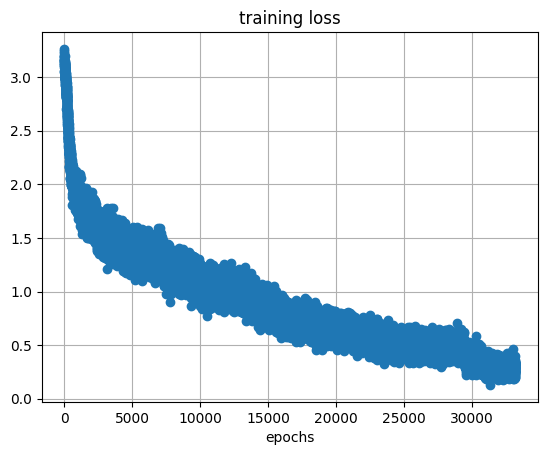

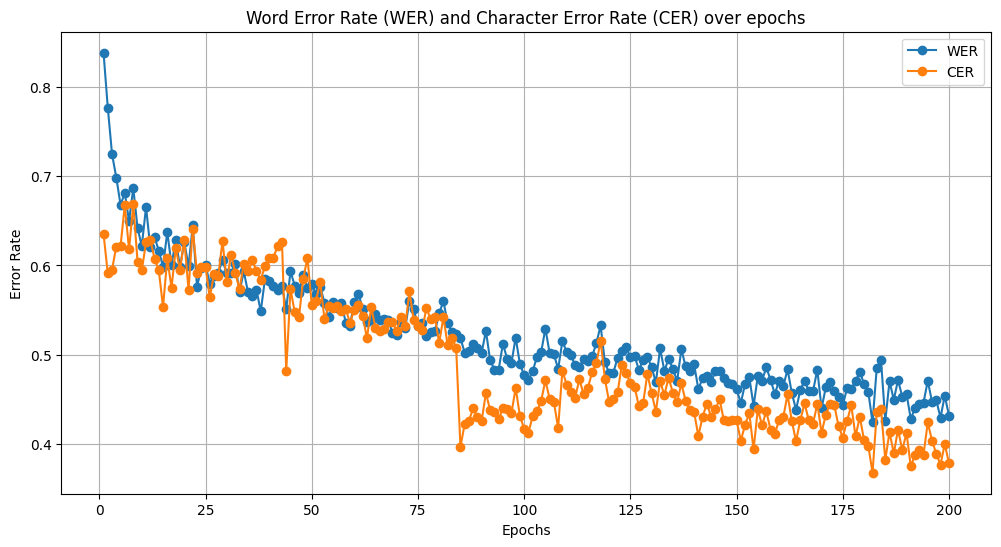

In [37]:

# Let's plot the training metrics versus the number of iteration.

#loss
plt.plot(losses,label='loss',marker='o' );
plt.title("training loss")
plt.xlabel("epochs")
plt.grid()
# WER Plotvimport matplotlib.pyplot as plt
epochs = list(range(1, 201))
plt.figure(figsize=(12, 6))
# Plot WER
plt.plot(epochs, wer_over_epochs, label='WER', marker='o')
# Plot CER
plt.plot(epochs, cer_over_epochs, label='CER', marker='o')

plt.title('Word Error Rate (WER) and Character Error Rate (CER) over epochs')
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.legend()
plt.grid(True)



In [38]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [ ]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

In [ ]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):    output = predict(waveform)
if output != utterance:
      ipd.Audio(waveform.numpy(), rate=sample_rate)
      print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

else:
    print("All examples in this dataset were correctly classified!")
    print("In this case, let's just look at the last data point")
    ipd.Audio(waveform.numpy(), rate=sample_rate)
    print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")

In [ ]:
import sounddevice as sd
import numpy as np
import torch
import torchaudio.transforms as T
import random

# Setting up the microphone to capture audio
duration = 1  # seconds
sample_rate = 16000

def record_audio():
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype=np.float32)
    sd.wait()
    print("Recording done.")
    return torch.tensor(audio).squeeze()

# Feature extraction
transform = T.MelSpectrogram(sample_rate=sample_rate)

# Placeholder ASR model
model = nueraspeechASR(n_input=1, n_output=len(labels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Live training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()

    # Select a random label
    true_label_index = random.randint(0, len(labels) - 1)
    true_label_text = labels[true_label_index]
    print(f"Please speak the label: {true_label_text}")

    # Record audio
    waveform = record_audio()

    # Extract features
    features = transform(waveform)
    features = features.unsqueeze(0)  # Adding batch dimension

    # Model forward pass
    outputs = model(features)

    # Compute loss
    true_label_tensor = torch.tensor([true_label_index])  # Convert the true label to tensor
    loss = loss_function(outputs.squeeze(0), true_label_tensor)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}\n")


In [ ]:
scores = torch.tensor([[1.0, -6.0, 2.5, -0.3, 1.2, 0.8]])

# Create a softmax function and apply it on the score tensor
softmax = nn.Softmax(dim=1)
probabilities = softmax(scores)
print(probabilities)